True

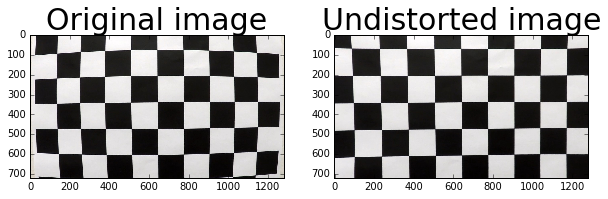

In [176]:
import numpy as np
import cv2
import matplotlib.pyplot as pyplot
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

calib_images = 'camera_cal/*.jpg'
test_image_fname = 'camera_cal/calibration1.jpg'

calib_pickle_file = 'cam_cal_dist.p'

# Perspective transform source and destination coordinates. 
warp_arr_src = [[590, 450], [200, 700], [1110, 700], [690, 450]]
warp_arr_dst = [[320, 0], [320, 700], [970, 700], [970, 0]]


def calibrate_camera(calib_image_path, test_image_fname):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(calib_image_path)

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    img = cv2.imread(test_image_fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def save_calib(mtx, dist, output_fname):
    dst_pickle = {}
    dst_pickle["mtx"] = mtx
    dst_pickle["dist"] = dist
    pickle.dump(dst_pickle, open(calib_pickle_file, "wb"))
    
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(warp_arr_src)
    dst = np.float32(warp_arr_dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def read_image(fname):
    img = mpimg.imread(fname)
    return img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x, y = 0, 0
    if (orient=='x'):
        x = 1
    else:
        y = 1
    print("x= {}, y= {}".format(x,y))
    sobelxy = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelxy = np.absolute(sobelxy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
 
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary 

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx*sobelx + sobely*sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 
    return sxbinary 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(dir_sobelxy)
    sxbinary[(dir_sobelxy >= thresh_min) & (dir_sobelxy <= thresh_max)] = 1
    return sxbinary 

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_hls = hls[:, :, 2]
    thresh_hls = np.zeros_like(s_hls)
    thresh_hls[(s_hls > thresh[0]) & (s_hls <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return thresh_hls

def apply_thresholds(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 200))
    mag_binary = mag_thresh(image, sobel_kernel=13, mag_thresh=(30, 100))

    pi_by_2 = np.pi/2
    dir_binary = dir_threshold(image, sobel_kernel=13, thresh=(0.7, 1.3))

    hls_mask = hls_select(image, (170, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_mask == 1)] = 1
    sobel_s_x = np.zeros_like(dir_binary)
    sobel_s_x[(gradx == 1) | (hls_mask == 1)] = 1
    return combined, sobel_s_x, gradx, grady, mag_binary, dir_binary, hls_mask

def apply_sx_thresholds(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))

    hls_mask = hls_select(image, (170, 255))
    sobel_s_x = np.zeros_like(dir_binary)
    sobel_s_x[(gradx == 1) | (hls_mask == 1)] = 1
    return sobel_s_x

# Step 1: Calibrate the camera and save the calibration matrix
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images, test_image_fname)
save_calib(mtx, dist, calib_pickle_file)
image = read_image(test_image_fname)

# Step 2: Undistort the a test image and plot it side by side.
img_d = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('/tmp/test_undist.jpg', img_d)

dst_pickle = {}
dst_pickle["mtx"] = mtx
dst_pickle["dist"] = dist
pickle.dump(dst_pickle, open("cam_cal_dist.p", "wb") )

f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(10,20))

ax1.imshow(image)
ax1.set_title("Original image", fontsize=30)

ax2.imshow(img_d)
ax2.set_title("Undistorted image", fontsize=30)
pyplot.savefig('output_images/undistort_output.png')


road_test_image = cv2.imread("test_images/test1.jpg")
road_test_undist = cv2.undistort(road_test_image, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg', road_test_undist)

x= 1, y= 0
x= 0, y= 1
x= 1, y= 0
x= 1, y= 0
x= 0, y= 1


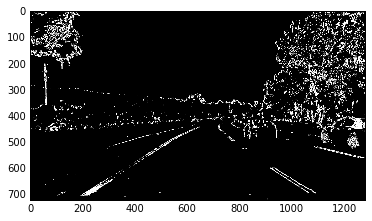

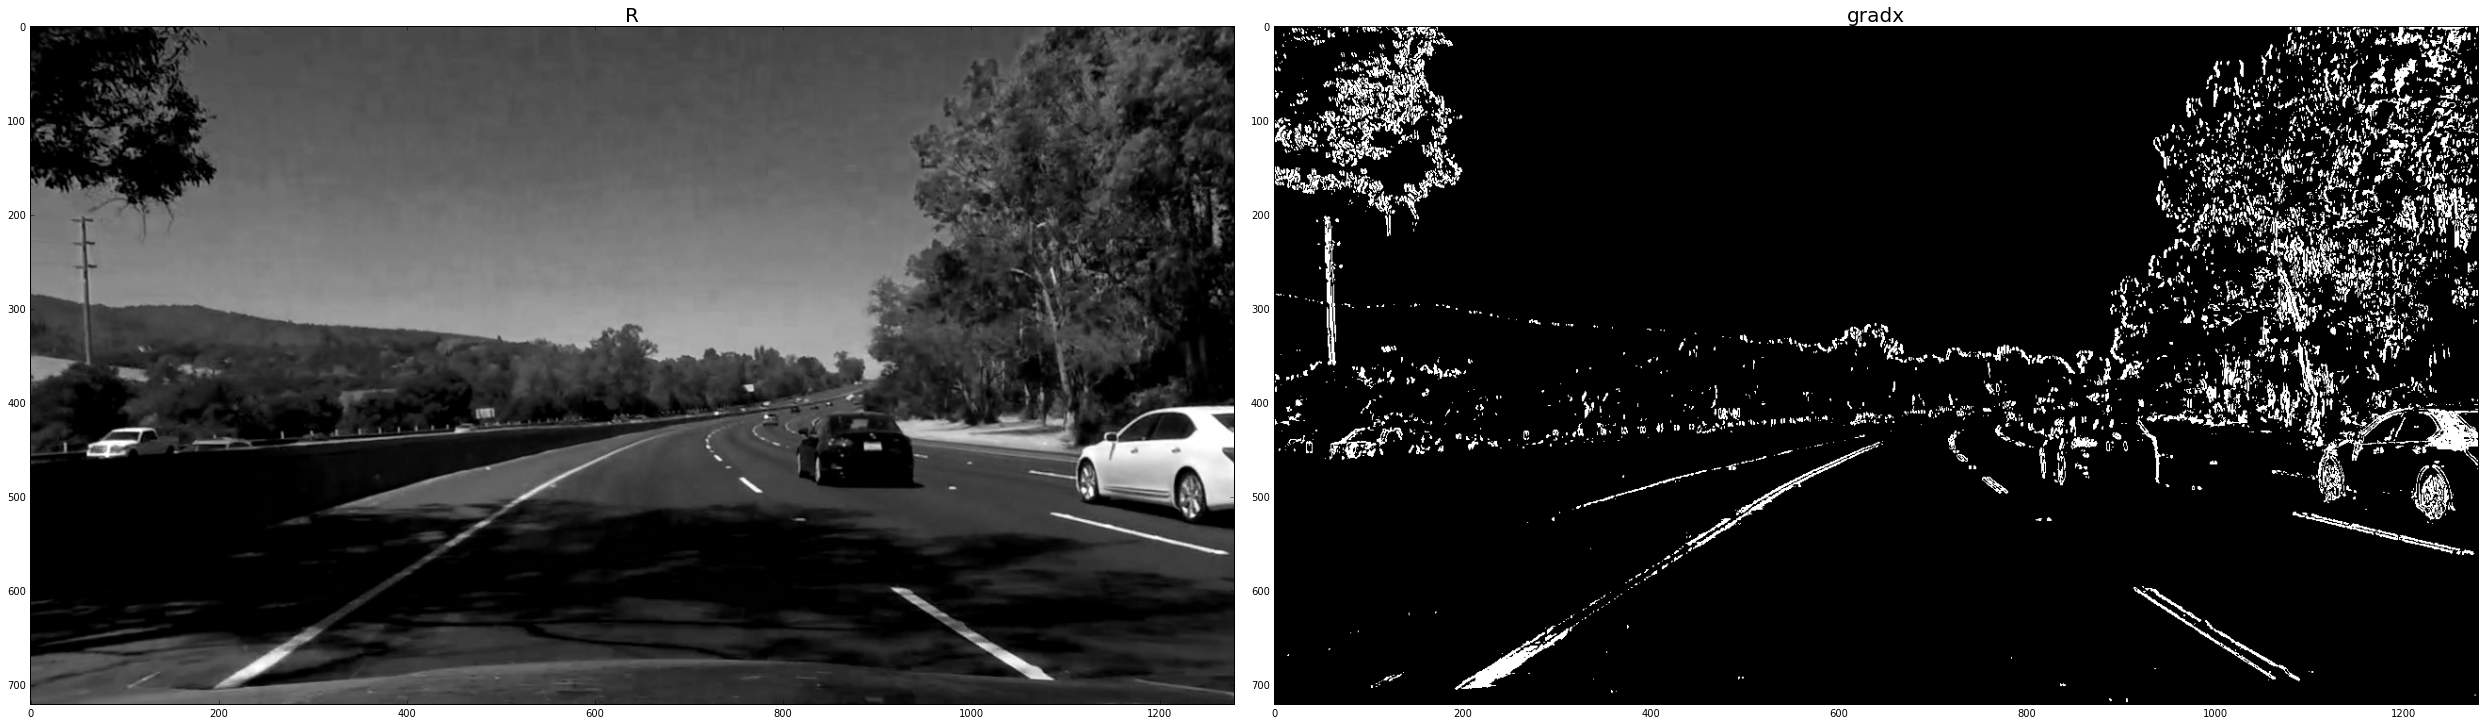

x= 1, y= 0
x= 0, y= 1


True

In [177]:
road_test_image = cv2.imread("debug/input_12.jpg")
road_test_image = cv2.cvtColor(road_test_image, cv2.COLOR_BGR2RGB)
#road_test_undist = cv2.undistort(road_test_image, mtx, dist, None, mtx)
road_test_undist = road_test_image

def apply_s_r_x_thresholds(input_image):
    R = input_image[:, :, 0].astype(np.uint16)
    img_thres, sobel_sx, gradx, grady, mag_binary, dir_binary, hls_mask = apply_thresholds(input_image)
    gradx_16 = (gradx * 255).astype(np.uint16)
    comb = sobel_sx * 255 + gradx_16 + R
    comb = 255 * comb / comb.max()
    comb = comb.astype(np.uint8)
    comb_bin = np.zeros_like(comb, np.uint8)
    comb_bin[(comb >= 90)] = 1
    return comb_bin
    
gray = cv2.cvtColor(road_test_image, cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255.0*abs_sobelx/np.max(abs_sobelx))

R = road_test_image[:, :, 0].astype(np.uint16)
R = road_test_undist[:, :, 0].astype(np.uint16)

R2 = road_test_image[:, :, 0]
R2_bin = np.zeros_like(R2)
R2_bin[(R2 > 140) & (R2 <= 255)] = 1


#cv2.imwrite('output_images/test_undist.jpg', road_test_undist)
img_d = road_test_undist

# Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
img_thres, sobel_sx, gradx, grady, mag_binary, dir_binary, hls_mask = apply_thresholds(img_d)
gradx = abs_sobel_thresh(img_d, orient='x', sobel_kernel=3, thresh=(20, 100))
gradx_16 = (gradx * 255).astype(np.uint16)

hls = cv2.cvtColor(road_test_undist, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2].astype(np.uint16)

comb = sobel_sx * 255 + gradx_16 + R

comb = 255 * comb / comb.max()
comb = comb.astype(np.uint8)
comb_bin = np.zeros_like(comb)
comb_bin[(comb > 90)] = 1
pyplot.imshow(comb_bin, cmap='gray')

f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(34, 19))

f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R', fontsize=20)

ax2.imshow(apply_s_r_x_thresholds(road_test_undist), cmap='gray')
ax2.set_title('gradx', fontsize=20)
pyplot.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
pyplot.show()
cv2.imwrite("debug/test-7.jpg", apply_s_r_x_thresholds(road_test_undist)* 255)


x= 1, y= 0
x= 0, y= 1
x= 1, y= 0
x= 0, y= 1


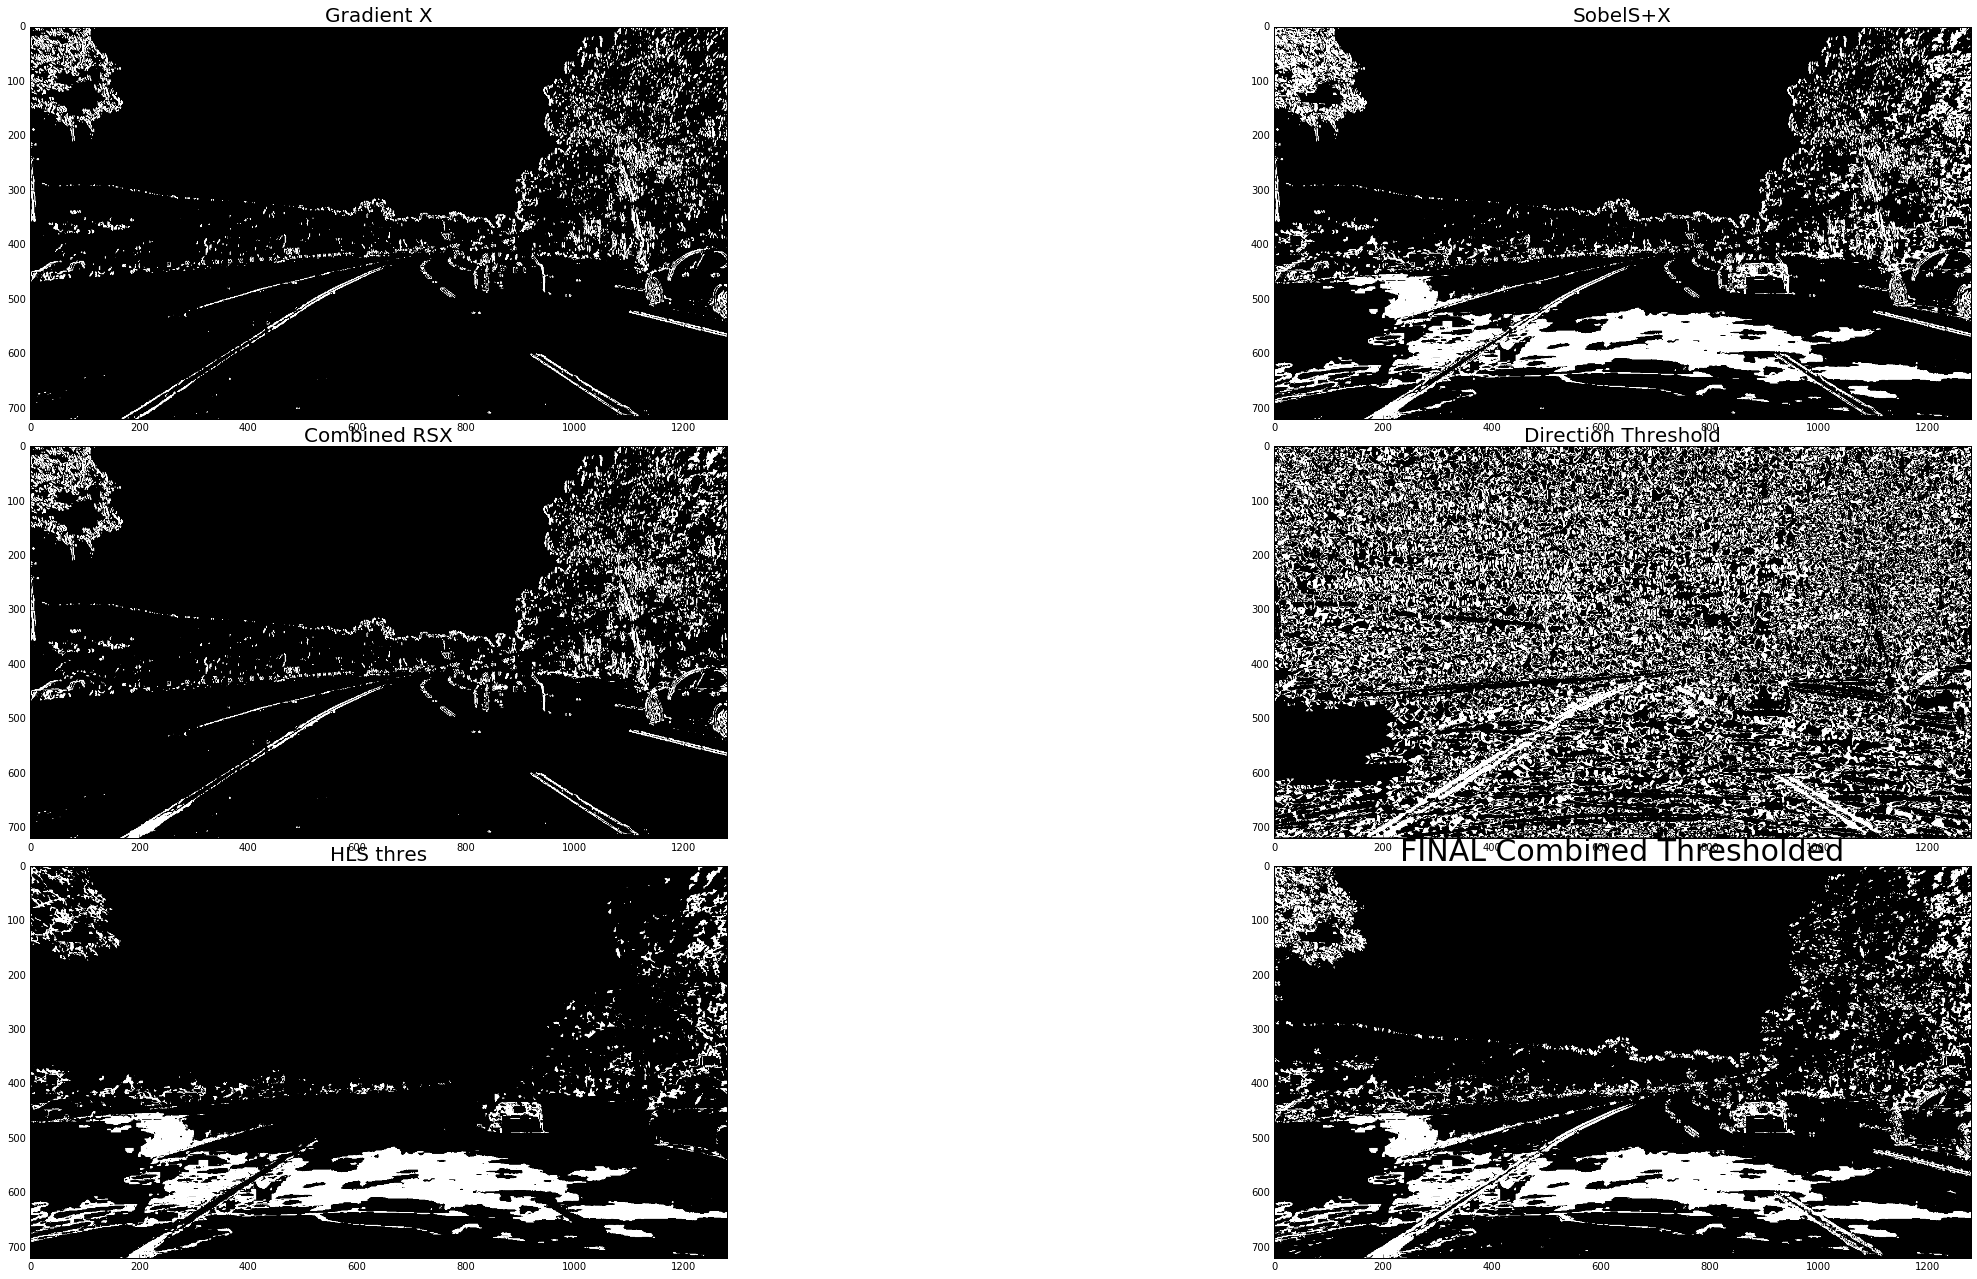

(720, 1280, 3)


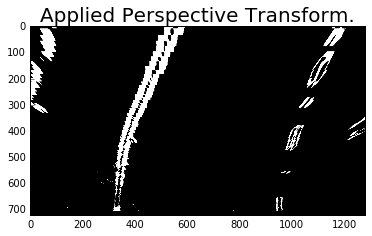

In [178]:

road_test_undist = cv2.undistort(road_test_image, mtx, dist, None, mtx)
#cv2.imwrite('output_images/test_undist.jpg', road_test_undist)
img_d = road_test_undist

# Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
img_thres, sobel_sx, gradx, grady, mag_binary, dir_binary, hls_mask = apply_thresholds(img_d)

combined_sx = apply_s_r_x_thresholds(img_d)

# Plot the result
f, all_plots = pyplot.subplots(3, 2, figsize=(34, 19))
f.tight_layout()
all_plots[0,0].imshow(gradx, cmap='gray')
all_plots[0,0].set_title('Gradient X', fontsize=20)

all_plots[0,1].imshow(sobel_sx, cmap='gray')
all_plots[0,1].set_title('SobelS+X', fontsize=20)

all_plots[1,0].imshow(combined_sx, cmap='gray')
all_plots[1,0].set_title('Combined RSX', fontsize=20)

all_plots[1,1].imshow(dir_binary, cmap='gray')
all_plots[1,1].set_title('Direction Threshold', fontsize=20)

all_plots[2,0].imshow(hls_mask, cmap='gray')
all_plots[2,0].set_title('HLS thres', fontsize=20)

all_plots[2,1].imshow(img_thres, cmap='gray')
all_plots[2,1].set_title('FINAL Combined Thresholded', fontsize=30)

pyplot.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
pyplot.show()


# Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").
img_w, M, Minv = warp(combined_sx)
pyplot.imshow(img_w, cmap='gray')
pyplot.title("Applied Perspective Transform.", fontsize=20)
print(img_d.shape)


x= 1, y= 0
x= 0, y= 1
436.456658825 m 722.908481032 m
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

x= 1, y= 0
x= 0, y= 1


  0%|          | 1/1261 [00:00<06:40,  3.15it/s]

438.911683024 m 713.208290819 m
var1 = 61.89474786783376, cleft = 438.91168302390344, cright = 713.2082908186648, mean2 = 0.1016032750739634, mean3 = 0.08112629032463584, mean1 = 600.443778734535
438.911683024 m 713.208290819 m
x= 1, y= 0
x= 0, y= 1


  0%|          | 2/1261 [00:00<06:55,  3.03it/s]

402.863587472 m 624.025344138 m
var1 = 66.09609448531177, cleft = 402.86358747210943, cright = 624.025344137595, mean2 = 5.112890332596351, mean3 = 1.5425312533408149, mean1 = 595.0271122325589
402.863587472 m 624.025344138 m
x= 1, y= 0
x= 0, y= 1


  0%|          | 3/1261 [00:01<06:54,  3.03it/s]

415.226696463 m 657.734649196 m
var1 = 84.27246760059585, cleft = 415.22669646349283, cright = 657.7346491956383, mean2 = 4.858758760632706, mean3 = 1.09471158386969, mean1 = 590.733964862937
415.226696463 m 657.734649196 m
x= 1, y= 0
x= 0, y= 1


  0%|          | 4/1261 [00:01<06:49,  3.07it/s]

403.148211272 m 593.614388622 m
var1 = 103.98181657685717, cleft = 403.14821127221273, cright = 593.6143886218485, mean2 = 3.4838500972712723, mean3 = 0.8037621613077157, mean1 = 586.5426634352294
403.148211272 m 593.614388622 m
x= 1, y= 0
x= 0, y= 1


  0%|          | 5/1261 [00:01<06:52,  3.04it/s]

427.252253289 m 475.575916989 m
var1 = 84.29212973495272, cleft = 427.2522532894501, cright = 475.5759169890853, mean2 = 2.346873835423044, mean3 = 1.04828622813409, mean1 = 585.848854613066
427.252253289 m 475.575916989 m
x= 1, y= 0
x= 0, y= 1


  0%|          | 6/1261 [00:01<06:49,  3.07it/s]

453.452148029 m 424.129322803 m
var1 = 154.93398311637068, cleft = 453.45214802865854, cright = 424.1293228025337, mean2 = 6.12563743310776, mean3 = 1.0201045689636286, mean1 = 579.8141328292663
453.452148029 m 424.129322803 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 7/1261 [00:02<06:44,  3.10it/s]

467.787014965 m 410.507657394 m
var1 = 113.10856477512984, cleft = 467.7870149654331, cright = 410.50765739388316, mean2 = 2.255485326124766, mean3 = 1.1641441460550326, mean1 = 582.9237899462646
467.787014965 m 410.507657394 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 8/1261 [00:02<06:49,  3.06it/s]

452.568528619 m 474.888381632 m
var1 = 128.59765622497784, cleft = 452.5685286187893, cright = 474.8883816323827, mean2 = 4.917148209231661, mean3 = 1.17633874585137, mean1 = 578.2098217281061
452.568528619 m 474.888381632 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 9/1261 [00:02<06:46,  3.08it/s]

506.978976837 m 597.390349414 m
var1 = 87.72706560585655, cleft = 506.97897683668253, cright = 597.3903494135328, mean2 = 4.674249742520054, mean3 = 2.2467571813701457, mean1 = 584.9577903534199
506.978976837 m 597.390349414 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 10/1261 [00:03<06:45,  3.09it/s]

484.395919146 m 694.528521689 m
var1 = 101.39054894564846, cleft = 484.3959191458383, cright = 694.528521689488, mean2 = 1.6247187999616313, mean3 = 2.3492581022913206, mean1 = 587.2532007001067
484.395919146 m 694.528521689 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 11/1261 [00:03<06:45,  3.08it/s]

507.262332458 m 882.493626359 m
var1 = 163.76605731417388, cleft = 507.2623324581347, cright = 882.4936263594041, mean2 = 4.195856736797724, mean3 = 0.6197203466015166, mean1 = 583.6974945349622
507.262332458 m 882.493626359 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 12/1261 [00:03<06:49,  3.05it/s]

615.99756692 m 820.291044293 m
var1 = 11.365991738349987, cleft = 615.9975669197365, cright = 820.2910442925075, mean2 = 11.985957191659585, mean3 = 5.262343944102004, mean1 = 600.327259148098
615.99756692 m 820.291044293 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 13/1261 [00:04<06:48,  3.06it/s]

595.812274941 m 1013.27937267 m
var1 = 42.7503742783177, cleft = 595.812274941244, cright = 1013.2793726682812, mean2 = 4.791192107307129, mean3 = 0.4057215339925315, mean1 = 596.3220269263682
595.812274941 m 1013.27937267 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 14/1261 [00:04<06:44,  3.09it/s]

560.726315369 m 583.378527708 m
var1 = 22.278010191597208, cleft = 560.7263153686342, cright = 583.3785277082995, mean2 = 4.125383997843494, mean3 = 1.3762790211446243, mean1 = 594.638748198379
560.726315369 m 583.378527708 m
x= 1, y= 0
x= 0, y= 1


  1%|          | 15/1261 [00:04<06:45,  3.07it/s]

531.960923736 m 593.818164201 m
var1 = 147.50635036537636, cleft = 531.9609237364527, cright = 593.8181642010362, mean2 = 12.347318216549194, mean3 = 1.784196943346121, mean1 = 580.5974369131187
531.960923736 m 593.818164201 m
x= 1, y= 0
x= 0, y= 1


  1%|▏         | 16/1261 [00:05<06:42,  3.09it/s]

522.701339778 m 388.613220747 m
var1 = 320.3789659162235, cleft = 522.7013397778809, cright = 388.6132207470186, mean2 = 9.924968934412702, mean3 = 0.7923124400876776, mean1 = 569.8801555386183
522.701339778 m 388.613220747 m
x= 1, y= 0
x= 0, y= 1


  1%|▏         | 17/1261 [00:05<06:46,  3.06it/s]

533.406628939 m 342.051717787 m
var1 = 431.88928044608457, cleft = 533.4066289394789, cright = 342.0517177873466, mean2 = 3.3099202432536066, mean3 = 1.2165561395312574, mean1 = 567.7781806539605
533.406628939 m 342.051717787 m
x= 1, y= 0
x= 0, y= 1


  1%|▏         | 18/1261 [00:05<06:50,  3.03it/s]

556.880643783 m 392.585202975 m
var1 = 473.74051694665, cleft = 556.8806437825776, cright = 392.5852029749858, mean2 = 4.358249584443912, mean3 = 0.659642391198864, mean1 = 563.0327519068443
556.880643783 m 392.585202975 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 19/1261 [00:06<06:48,  3.04it/s]

530.685034461 m 380.183218403 m
var1 = 300.3322793661206, cleft = 530.6850344605567, cright = 380.1832184032098, mean2 = 6.1112834197679025, mean3 = 2.3422165218399633, mean1 = 571.0692606276018
530.685034461 m 380.183218403 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 20/1261 [00:06<06:49,  3.03it/s]

534.649585923 m 369.371727045 m
var1 = 161.13017960977692, cleft = 534.6495859232667, cright = 369.37172704516036, mean2 = 4.678277268941423, mean3 = 2.733783926446754, mean1 = 576.95838816884
534.649585923 m 369.371727045 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 21/1261 [00:06<06:55,  2.99it/s]

596.518681851 m 390.784717411 m
var1 = 90.06113377250237, cleft = 596.5186818511338, cright = 390.7847174113519, mean2 = 5.736330700687981, mean3 = 1.9933646540690466, mean1 = 584.426956565513
596.518681851 m 390.784717411 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 22/1261 [00:07<06:50,  3.02it/s]

571.291109976 m 392.48792484 m
var1 = 42.131352499161, cleft = 571.2911099759378, cright = 392.4879248398695, mean2 = 7.046591896087914, mean3 = 2.9986005817912775, mean1 = 594.4721490433922
571.291109976 m 392.48792484 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 23/1261 [00:07<06:48,  3.03it/s]

595.640833621 m 433.502381684 m
var1 = 20.022508427099694, cleft = 595.6408336209441, cright = 433.50238168404707, mean2 = 5.294733164562448, mean3 = 2.010762403769808, mean1 = 601.7776446117243
595.640833621 m 433.502381684 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 24/1261 [00:07<06:45,  3.05it/s]

541.603039077 m 503.849411885 m
var1 = 30.11365360578123, cleft = 541.6030390769773, cright = 503.84941188465245, mean2 = 4.029078802525943, mean3 = 1.1972853657263787, mean1 = 598.4942455564862
541.603039077 m 503.849411885 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 25/1261 [00:08<06:44,  3.05it/s]

502.135813203 m 732.817544825 m
var1 = 81.00432407678606, cleft = 502.13581320343445, cright = 732.8175448252493, mean2 = 4.605579626387711, mean3 = 1.0890441157627149, mean1 = 595.2131900562089
502.135813203 m 732.817544825 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 26/1261 [00:08<06:42,  3.07it/s]

529.927554136 m 803.757139366 m
var1 = 33.624122221322, cleft = 529.9275541358527, cright = 803.757139366392, mean2 = 8.29124474972923, mean3 = 2.073294894971352, mean1 = 605.5602017075524
529.927554136 m 803.757139366 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 27/1261 [00:08<06:40,  3.08it/s]

482.393558922 m 792.138250755 m
var1 = 39.808822766111206, cleft = 482.3935589220659, cright = 792.1382507548643, mean2 = 0.8306516787905515, mean3 = 1.0315235036825694, mean1 = 606.2041510536343
482.393558922 m 792.138250755 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 28/1261 [00:09<06:38,  3.09it/s]

514.601349459 m 666.860430649 m
var1 = 10.239931683635765, cleft = 514.6013494591259, cright = 666.8604306491312, mean2 = 10.042016879439082, mean3 = 1.9639063080937107, mean1 = 617.9001190428337
514.601349459 m 666.860430649 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 29/1261 [00:09<06:38,  3.10it/s]

464.739713895 m 521.286845932 m
var1 = 9.74050462555435, cleft = 464.7397138953593, cright = 521.2868459324653, mean2 = 5.834755639517161, mean3 = 1.7969697812994658, mean1 = 610.531978449659
464.739713895 m 521.286845932 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 30/1261 [00:09<06:35,  3.11it/s]

417.38812924 m 572.475248873 m
var1 = 40.852450809075194, cleft = 417.3881292396227, cright = 572.4752488734363, mean2 = 6.1437968889001615, mean3 = 1.9270835023369008, mean1 = 603.0183065576765
417.38812924 m 572.475248873 m
x= 1, y= 0
x= 0, y= 1


  2%|▏         | 31/1261 [00:10<06:39,  3.08it/s]

398.628573833 m 338.855313647 m
var1 = 166.593760171604, cleft = 398.6285738328688, cright = 338.85531364691957, mean2 = 9.027992364929451, mean3 = 1.9525245408612044, mean1 = 592.9357019028007
398.628573833 m 338.855313647 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 32/1261 [00:10<06:40,  3.07it/s]

373.875293845 m 332.632121443 m
var1 = 320.7671883177193, cleft = 373.8752938451473, cright = 332.63212144266066, mean2 = 9.130106433197435, mean3 = 3.0136195970023687, mean1 = 580.7922658480228
373.875293845 m 332.632121443 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 33/1261 [00:10<06:40,  3.07it/s]

355.689907788 m 307.215548979 m
var1 = 129.44015492498767, cleft = 355.6899077878597, cright = 307.2155489791132, mean2 = 6.735428080102798, mean3 = 1.957803780721166, mean1 = 587.4446046864693
355.689907788 m 307.215548979 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 34/1261 [00:11<06:37,  3.08it/s]

341.810886194 m 392.089148055 m
var1 = 223.94336661443154, cleft = 341.8108861944207, cright = 392.08914805477445, mean2 = 6.008822828696162, mean3 = 1.3203014224638518, mean1 = 585.0454342677599
341.810886194 m 392.089148055 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 35/1261 [00:11<06:36,  3.09it/s]

336.692410586 m 452.853336364 m
var1 = 270.90908500828687, cleft = 336.69241058617393, cright = 452.8533363639429, mean2 = 2.192313107365918, mean3 = 0.8802969828930876, mean1 = 584.1548444179072
336.692410586 m 452.853336364 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 36/1261 [00:11<06:34,  3.11it/s]

325.527080364 m 492.844875279 m
var1 = 363.22983261785225, cleft = 325.527080364236, cright = 492.8448752786081, mean2 = 4.959486102607375, mean3 = 1.615725532044012, mean1 = 578.4500691658911
325.527080364 m 492.844875279 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 37/1261 [00:12<06:31,  3.12it/s]

311.595842672 m 422.62128489 m
var1 = 308.25995681935603, cleft = 311.59584267248704, cright = 422.62128488990913, mean2 = 3.773752250591683, mean3 = 1.4502175061839124, mean1 = 575.2654514651839
311.595842672 m 422.62128489 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 38/1261 [00:12<06:29,  3.14it/s]

310.874607218 m 355.25274066 m
var1 = 338.3693950144103, cleft = 310.87460721767883, cright = 355.25274065971513, mean2 = 3.641372739779888, mean3 = 0.949070691837514, mean1 = 570.6750080335665
310.874607218 m 355.25274066 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 39/1261 [00:12<06:30,  3.13it/s]

315.479731899 m 318.915673933 m
var1 = 448.0837773017811, cleft = 315.47973189878394, cright = 318.9156739332166, mean2 = 7.486346009907091, mean3 = 0.99763249510955, mean1 = 563.2519639199937
315.479731899 m 318.915673933 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 40/1261 [00:13<06:32,  3.11it/s]

324.074944211 m 301.035531829 m
var1 = 397.46093841126986, cleft = 324.0749442112628, cright = 301.0355318288709, mean2 = 2.1085991472174803, mean3 = 1.656523538594586, mean1 = 566.7349220302509
324.074944211 m 301.035531829 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 41/1261 [00:13<06:32,  3.11it/s]

339.063642288 m 291.050483638 m
var1 = 466.7414905970651, cleft = 339.0636422884682, cright = 291.05048363765616, mean2 = 1.2354575959158165, mean3 = 0.7345522673723914, mean1 = 565.6117104908446
339.063642288 m 291.050483638 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 42/1261 [00:13<06:34,  3.09it/s]

351.116128814 m 308.968577578 m
var1 = 426.4294469239714, cleft = 351.1161288141636, cright = 308.96857757755527, mean2 = 1.9385224399481846, mean3 = 0.6130696868876693, mean1 = 567.3241795128587
351.116128814 m 308.968577578 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 43/1261 [00:14<06:38,  3.06it/s]

367.746604505 m 310.030122517 m
var1 = 342.62554173981016, cleft = 367.7466045054654, cright = 310.0301225166312, mean2 = 3.359810030414575, mean3 = 1.3301195303737878, mean1 = 571.5866461186391
367.746604505 m 310.030122517 m
x= 1, y= 0
x= 0, y= 1


  3%|▎         | 44/1261 [00:14<06:36,  3.07it/s]

384.39436969 m 313.508564396 m
var1 = 189.20746592506197, cleft = 384.3943696902526, cright = 313.5085643961152, mean2 = 6.331664234189284, mean3 = 1.905013841699332, mean1 = 579.6735879537707
384.39436969 m 313.508564396 m
x= 1, y= 0
x= 0, y= 1


  4%|▎         | 45/1261 [00:14<06:34,  3.08it/s]

411.250877017 m 315.303747364 m
var1 = 125.93524049785543, cleft = 411.25087701650534, cright = 315.30374736400876, mean2 = 3.20137781167219, mean3 = 1.4799284181351549, mean1 = 583.8112961299611
411.250877017 m 315.303747364 m
x= 1, y= 0
x= 0, y= 1


  4%|▎         | 46/1261 [00:14<06:34,  3.08it/s]

417.49692113 m 335.386949196 m
var1 = 86.6415108472703, cleft = 417.4969211304801, cright = 335.3869491962663, mean2 = 1.6724538352950775, mean3 = 0.4623838027716644, mean1 = 584.5179081645679
417.49692113 m 335.386949196 m
x= 1, y= 0
x= 0, y= 1


  4%|▎         | 47/1261 [00:15<06:32,  3.10it/s]

427.044636989 m 411.551584207 m
var1 = 74.07384890879443, cleft = 427.0446369894644, cright = 411.55158420651975, mean2 = 3.745780314338979, mean3 = 1.167295631314861, mean1 = 589.3954574854538
427.044636989 m 411.551584207 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 48/1261 [00:15<06:32,  3.09it/s]

419.924460468 m 487.029650305 m
var1 = 151.0439830031264, cleft = 419.9244604675928, cright = 487.0296503046904, mean2 = 5.162416205653559, mean3 = 0.31104340509471834, mean1 = 586.3052297214662
419.924460468 m 487.029650305 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 49/1261 [00:15<06:33,  3.08it/s]

462.251364428 m 502.875396089 m
var1 = 82.94430999631935, cleft = 462.2513644283278, cright = 502.8753960890898, mean2 = 5.590350192597757, mean3 = 2.044348727711406, mean1 = 593.7007963628969
462.251364428 m 502.875396089 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 50/1261 [00:16<06:32,  3.08it/s]

459.655041434 m 458.044279677 m
var1 = 89.88404057058466, cleft = 459.65504143372823, cright = 458.0442796774804, mean2 = 2.6063751030732987, mean3 = 0.7593648142587861, mean1 = 591.849225677203
459.655041434 m 458.044279677 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 51/1261 [00:16<06:33,  3.08it/s]

488.647181438 m 500.530056971 m
var1 = 84.5823249688326, cleft = 488.64718143807374, cright = 500.53005697085536, mean2 = 1.2728720978905286, mean3 = 0.9591627206514708, mean1 = 591.8590774799787
488.647181438 m 500.530056971 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 52/1261 [00:16<06:34,  3.06it/s]

479.931005754 m 491.116222103 m
var1 = 144.27518071977642, cleft = 479.93100575351053, cright = 491.11622210258776, mean2 = 6.95817365711091, mean3 = 0.4592041127165164, mean1 = 585.1497552830183
479.931005754 m 491.116222103 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 53/1261 [00:17<06:31,  3.08it/s]

463.757320495 m 454.985352051 m
var1 = 172.3508632605684, cleft = 463.75732049530404, cright = 454.9853520509159, mean2 = 2.9788733434775705, mean3 = 0.7556304204224585, mean1 = 581.670218543593
463.757320495 m 454.985352051 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 54/1261 [00:17<06:29,  3.10it/s]

474.005857866 m 374.165349018 m
var1 = 300.91526323988643, cleft = 474.00585786584617, cright = 374.1653490180535, mean2 = 4.644258439993856, mean3 = 0.7336143278132841, mean1 = 577.3353522908094
474.005857866 m 374.165349018 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 55/1261 [00:17<06:31,  3.08it/s]

510.791084439 m 369.328813955 m
var1 = 298.9882964781536, cleft = 510.79108443869274, cright = 369.3288139551428, mean2 = 1.6954443123503855, mean3 = 1.1617386276800612, mean1 = 579.857766407096
510.791084439 m 369.328813955 m
x= 1, y= 0
x= 0, y= 1


  4%|▍         | 56/1261 [00:18<06:37,  3.03it/s]

519.01656916 m 381.623789247 m
var1 = 239.48690535467261, cleft = 519.0165691596886, cright = 381.62378924665614, mean2 = 2.6861112190094536, mean3 = 0.8065389337718109, mean1 = 583.2652581075733
519.01656916 m 381.623789247 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 57/1261 [00:18<06:36,  3.04it/s]

504.992425748 m 400.971495323 m
var1 = 234.00203886705057, cleft = 504.9924257477208, cright = 400.97149532327387, mean2 = 1.0843904926140804, mean3 = 0.5935768798385926, mean1 = 582.1429250323644
504.992425748 m 400.971495323 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 58/1261 [00:18<06:34,  3.05it/s]

512.291900026 m 447.83714579 m
var1 = 262.3778420454622, cleft = 512.2919000262146, cright = 447.8371457904802, mean2 = 1.38987704900299, mean3 = 1.009472446987786, mean1 = 582.6163107768532
512.291900026 m 447.83714579 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 59/1261 [00:19<06:35,  3.04it/s]

480.282746868 m 654.999220382 m
var1 = 487.63201178817036, cleft = 480.2827468675747, cright = 654.9992203823617, mean2 = 8.765025504108879, mean3 = 2.7406955181188524, mean1 = 573.1110312549154
480.282746868 m 654.999220382 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 60/1261 [00:19<06:41,  2.99it/s]

486.243913478 m 432.681326586 m
var1 = 615.5310276055513, cleft = 486.24391347841146, cright = 432.68132658622005, mean2 = 9.714063738249505, mean3 = 2.4315942469836487, mean1 = 561.0955574717473
486.243913478 m 432.681326586 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 61/1261 [00:19<06:40,  2.99it/s]

518.626531055 m 381.475214021 m
var1 = 800.0515385970149, cleft = 518.6265310546555, cright = 381.4752140211484, mean2 = 3.794746585024194, mean3 = 1.644219268831438, mean1 = 555.7904406690122
518.626531055 m 381.475214021 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 62/1261 [00:20<06:40,  2.99it/s]

482.415903775 m 300.237806652 m
var1 = 1097.2639395439073, cleft = 482.41590377475256, cright = 300.23780665194965, mean2 = 7.445161872947794, mean3 = 1.1616686035644934, mean1 = 547.4286166025374
482.415903775 m 300.237806652 m
x= 1, y= 0
x= 0, y= 1


  5%|▍         | 63/1261 [00:20<06:35,  3.03it/s]

516.122694514 m 315.738425094 m
var1 = 909.5624201504294, cleft = 516.1226945136652, cright = 315.7384250943222, mean2 = 5.727784406729178, mean3 = 1.4062513522197064, mean1 = 553.3255046382224
516.122694514 m 315.738425094 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 64/1261 [00:20<06:38,  3.00it/s]

500.966472981 m 313.264837872 m
var1 = 1133.919731833878, cleft = 500.9664729807259, cright = 313.2648378716041, mean2 = 2.8863326709716484, mean3 = 2.1406360983712953, mean1 = 548.5870854443169
500.966472981 m 313.264837872 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 65/1261 [00:21<06:38,  3.00it/s]

522.795234131 m 320.865381757 m
var1 = 938.5954963572259, cleft = 522.7952341308969, cright = 320.8653817566078, mean2 = 5.7316682686016796, mean3 = 1.3699658412027604, mean1 = 555.3131699598745
522.795234131 m 320.865381757 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 66/1261 [00:21<06:34,  3.03it/s]

540.773632657 m 366.658533498 m
var1 = 1077.988347621314, cleft = 540.7736326567033, cright = 366.65853349845634, mean2 = 2.9514025389362044, mean3 = 2.2792722969450376, mean1 = 550.9394893755496
540.773632657 m 366.658533498 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 67/1261 [00:21<06:35,  3.02it/s]

538.07459843 m 409.829894025 m
var1 = 908.501108196811, cleft = 538.0745984301504, cright = 409.829894024657, mean2 = 2.2111638329118457, mean3 = 0.8786242014219653, mean1 = 553.4729848060267
538.07459843 m 409.829894025 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 68/1261 [00:22<06:33,  3.03it/s]

546.683182206 m 432.629990158 m
var1 = 747.2199526512463, cleft = 546.6831822062322, cright = 432.6299901582847, mean2 = 3.27442286183026, mean3 = 1.4989289217754365, mean1 = 558.2463365896324
546.683182206 m 432.629990158 m
x= 1, y= 0
x= 0, y= 1


  5%|▌         | 69/1261 [00:22<06:29,  3.06it/s]

523.468945663 m 421.438953548 m
var1 = 893.3872156023066, cleft = 523.4689456625576, cright = 421.43895354840566, mean2 = 4.729442511580794, mean3 = 1.476685205975229, mean1 = 552.1519654311256
523.468945663 m 421.438953548 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 70/1261 [00:22<06:28,  3.06it/s]

548.143849202 m 463.189440743 m
var1 = 612.4329715143706, cleft = 548.1438492017438, cright = 463.18944074331745, mean2 = 6.724133811798867, mean3 = 1.6906538710951995, mean1 = 560.5667531140197
548.143849202 m 463.189440743 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 71/1261 [00:23<06:30,  3.04it/s]

571.818055286 m 438.547778014 m
var1 = 686.991300815184, cleft = 571.818055285729, cright = 438.5477780136653, mean2 = 2.8965191944640987, mean3 = 0.5623565475825331, mean1 = 557.1751876104688
571.818055286 m 438.547778014 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 72/1261 [00:23<06:28,  3.06it/s]

573.553092435 m 442.333520965 m
var1 = 561.1158608835401, cleft = 573.5530924352097, cright = 442.33352096485464, mean2 = 3.2938642655293684, mean3 = 1.5133533293841455, mean1 = 561.7354952041262
573.553092435 m 442.333520965 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 73/1261 [00:23<06:29,  3.05it/s]

565.272800168 m 429.878514498 m
var1 = 505.85141662837793, cleft = 565.2728001684359, cright = 429.8785144978642, mean2 = 2.001760157365446, mean3 = 0.9106238949121471, mean1 = 564.3838335845854
565.272800168 m 429.878514498 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 74/1261 [00:24<06:29,  3.05it/s]

573.310539141 m 431.292639273 m
var1 = 530.2567482257491, cleft = 573.3105391412145, cright = 431.29263927334375, mean2 = 1.218570881630847, mean3 = 0.3590966970487271, mean1 = 563.4251225810634
573.310539141 m 431.292639273 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 75/1261 [00:24<06:25,  3.07it/s]

619.487314141 m 418.339222447 m
var1 = 371.79185919529783, cleft = 619.4873141414204, cright = 418.33922244742075, mean2 = 5.479162958550652, mean3 = 2.7783457655686736, mean1 = 571.4119959678821
619.487314141 m 418.339222447 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 76/1261 [00:24<06:28,  3.05it/s]

611.311110486 m 398.404332732 m
var1 = 473.3602282608741, cleft = 611.3111104860297, cright = 398.4043327322717, mean2 = 2.279379960921879, mean3 = 0.8242210413796581, mean1 = 568.5172844568101
611.311110486 m 398.404332732 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 77/1261 [00:25<06:28,  3.05it/s]

667.676141918 m 492.597247735 m
var1 = 212.59687115431814, cleft = 667.6761419182722, cright = 492.5972477346495, mean2 = 10.70056197422487, mean3 = 4.567447957365656, mean1 = 583.7852943884005
667.676141918 m 492.597247735 m
x= 1, y= 0
x= 0, y= 1


  6%|▌         | 78/1261 [00:25<06:26,  3.06it/s]

663.294667433 m 500.254914027 m
var1 = 162.99232428291555, cleft = 663.2946674333467, cright = 500.254914026751, mean2 = 3.8999754336451535, mean3 = 1.0398119749251375, mean1 = 588.7250817969709
663.294667433 m 500.254914027 m
x= 1, y= 0
x= 0, y= 1


  6%|▋         | 79/1261 [00:25<06:27,  3.05it/s]

701.101643784 m 457.002009677 m
var1 = 161.8848909121121, cleft = 701.1016437836175, cright = 457.00200967740454, mean2 = 3.058464747589318, mean3 = 1.668789703767625, mean1 = 593.1488918839709
701.101643784 m 457.002009677 m
x= 1, y= 0
x= 0, y= 1


  6%|▋         | 80/1261 [00:26<06:30,  3.03it/s]

710.324479709 m 401.137852536 m
var1 = 233.46893626958874, cleft = 710.3244797088461, cright = 401.13785253607585, mean2 = 1.7610967743675174, mean3 = 0.910038833362213, mean1 = 592.3582719143265
710.324479709 m 401.137852536 m
x= 1, y= 0
x= 0, y= 1


  6%|▋         | 81/1261 [00:26<06:29,  3.03it/s]

670.272692627 m 359.051219117 m
var1 = 365.7359096363605, cleft = 670.2726926272129, cright = 359.0512191170077, mean2 = 5.120192087472703, mean3 = 1.3206750611272413, mean1 = 586.0994095501636
670.272692627 m 359.051219117 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 82/1261 [00:26<06:32,  3.00it/s]

607.57665912 m 367.71894335 m
var1 = 307.66809586363246, cleft = 607.5766591202181, cright = 367.71894334995693, mean2 = 1.6330410715506976, mean3 = 1.2954346852013756, mean1 = 588.7853295217561
607.57665912 m 367.71894335 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 83/1261 [00:27<06:32,  3.00it/s]

587.84858494 m 372.692638858 m
var1 = 265.25980169310066, cleft = 587.8485849401594, cright = 372.69263885764957, mean2 = 1.1178199998693115, mean3 = 1.13582978394548, mean1 = 590.2729492943469
587.84858494 m 372.692638858 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 84/1261 [00:27<06:31,  3.00it/s]

613.618321358 m 353.376965891 m
var1 = 115.73772826303713, cleft = 613.6183213577926, cright = 353.37696589090234, mean2 = 10.824980333096704, mean3 = 3.6879282719504056, mean1 = 604.002474648641
613.618321358 m 353.376965891 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 85/1261 [00:27<06:29,  3.02it/s]

574.263716773 m 428.983786611 m
var1 = 115.21205000842559, cleft = 574.2637167725827, cright = 428.9837866112596, mean2 = 3.072828885159305, mean3 = 0.5957546477945708, mean1 = 605.4740198668029
574.263716773 m 428.983786611 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 86/1261 [00:28<06:30,  3.01it/s]

520.411995332 m 486.017694362 m
var1 = 125.97174944691801, cleft = 520.4119953318686, cright = 486.01769436178733, mean2 = 1.5132339649254776, mean3 = 1.484767777365298, mean1 = 604.7362457114567
520.411995332 m 486.017694362 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 87/1261 [00:28<06:28,  3.03it/s]

468.046699567 m 519.353002393 m
var1 = 392.82575865597045, cleft = 468.04669956716236, cright = 519.3530023934879, mean2 = 10.943598653268939, mean3 = 6.375461483294645, mean1 = 587.6526486955687
468.046699567 m 519.353002393 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 88/1261 [00:28<06:27,  3.03it/s]

428.187297227 m 470.545183484 m
var1 = 530.8393841593037, cleft = 428.18729722748134, cright = 470.5451834843391, mean2 = 7.252500836763597, mean3 = 2.835203347649028, mean1 = 577.5662035890786
428.187297227 m 470.545183484 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 89/1261 [00:29<06:29,  3.01it/s]

406.844755358 m 438.594307626 m
var1 = 637.2964183765132, cleft = 406.84475535757014, cright = 438.59430762584185, mean2 = 4.863394901936, mean3 = 2.9869270301956337, mean1 = 569.7158816569469
406.844755358 m 438.594307626 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 90/1261 [00:29<06:32,  2.98it/s]

392.835296123 m 319.251066945 m
var1 = 1066.9583412462657, cleft = 392.8352961227038, cright = 319.25106694490535, mean2 = 10.475871824269502, mean3 = 4.139271573313417, mean1 = 555.100738259364
392.835296123 m 319.251066945 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 91/1261 [00:29<06:38,  2.94it/s]

389.155502538 m 372.691118014 m
var1 = 749.479012685, cleft = 389.1555025378064, cright = 372.69111801405745, mean2 = 7.460743764190403, mean3 = 1.2603785241636611, mean1 = 563.821860547718
389.155502538 m 372.691118014 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 92/1261 [00:30<06:46,  2.87it/s]

406.216414672 m 358.22563689 m
var1 = 757.9295863882882, cleft = 406.21641467180547, cright = 358.2256368897264, mean2 = 1.1438647094738974, mean3 = 0.6615804560281336, mean1 = 565.1234073894377
406.216414672 m 358.22563689 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 93/1261 [00:30<06:42,  2.90it/s]

407.100238609 m 384.852948304 m
var1 = 773.7508328173083, cleft = 407.10023860930795, cright = 384.85294830388904, mean2 = 3.059163924392044, mean3 = 2.710079762041378, mean1 = 559.3724937004692
407.100238609 m 384.852948304 m
x= 1, y= 0
x= 0, y= 1


  7%|▋         | 94/1261 [00:30<06:36,  2.94it/s]

388.310285314 m 417.279210612 m
var1 = 760.9360509385104, cleft = 388.31028531365257, cright = 417.2792106118033, mean2 = 1.646611566979608, mean3 = 1.1417278830253403, mean1 = 557.3705448600739
388.310285314 m 417.279210612 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 95/1261 [00:31<06:38,  2.93it/s]

417.301549383 m 411.558518676 m
var1 = 540.0586258657453, cleft = 417.3015493834335, cright = 411.5585186756977, mean2 = 5.18462676378798, mean3 = 1.2037956388738766, mean1 = 562.5487225670663
417.301549383 m 411.558518676 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 96/1261 [00:31<06:35,  2.95it/s]

389.274346659 m 427.53413779 m
var1 = 435.48667485420606, cleft = 389.27434665911306, cright = 427.53413778986726, mean2 = 1.156527977750746, mean3 = 1.170138150784484, mean1 = 564.1035787686953
389.274346659 m 427.53413779 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 97/1261 [00:31<06:39,  2.91it/s]

393.644982306 m 462.024701538 m
var1 = 422.7441848091507, cleft = 393.6449823063672, cright = 462.0247015382527, mean2 = 0.935249811523016, mean3 = 0.47677641014901123, mean1 = 564.052373468531
393.644982306 m 462.024701538 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 98/1261 [00:32<06:45,  2.87it/s]

416.131383509 m 448.124381573 m
var1 = 276.2761418695713, cleft = 416.1313835087152, cright = 448.12438157320224, mean2 = 5.412259347500737, mean3 = 1.7416100419059388, mean1 = 570.9591661809674
416.131383509 m 448.124381573 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 99/1261 [00:32<06:36,  2.93it/s]

401.238070844 m 392.790194993 m
var1 = 357.02931393935313, cleft = 401.23807084444803, cright = 392.7901949926748, mean2 = 4.327802147978283, mean3 = 1.5768924826881148, mean1 = 565.054471550301
401.238070844 m 392.790194993 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 100/1261 [00:32<06:35,  2.93it/s]

407.350234521 m 425.43138061 m
var1 = 266.01035362103033, cleft = 407.35023452061614, cright = 425.4313806102491, mean2 = 4.613666298902282, mean3 = 0.7181413562178834, mean1 = 570.3839512994746
407.350234521 m 425.43138061 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 101/1261 [00:33<06:29,  2.98it/s]

398.840376458 m 421.848681301 m
var1 = 293.54313749104847, cleft = 398.84037645800004, cright = 421.84868130073323, mean2 = 1.4680535794716671, mean3 = 0.8832107175813465, mean1 = 568.5455744660948
398.840376458 m 421.848681301 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 102/1261 [00:33<06:22,  3.03it/s]

393.555499728 m 336.576626453 m
var1 = 358.7083726670567, cleft = 393.55549972790794, cright = 336.5766264525244, mean2 = 3.6038500002383285, mean3 = 1.0826376905253627, mean1 = 564.5718418079747
393.555499728 m 336.576626453 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 103/1261 [00:33<06:17,  3.07it/s]

379.874718932 m 311.590129273 m
var1 = 375.59020851332184, cleft = 379.8747189316359, cright = 311.5901292730789, mean2 = 2.1768058032270483, mean3 = 0.6014284668289279, mean1 = 566.3019816946459
379.874718932 m 311.590129273 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 104/1261 [00:34<06:13,  3.10it/s]

388.12164798 m 308.73020314 m
var1 = 375.0243755518938, cleft = 388.12164797967915, cright = 308.73020313999365, mean2 = 1.2716805651773062, mean3 = 0.5903776361303286, mean1 = 566.9832846236928
388.12164798 m 308.73020314 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 105/1261 [00:34<06:05,  3.16it/s]

411.090479777 m 319.563991036 m
var1 = 237.03204660613244, cleft = 411.09047977720996, cright = 319.56399103623573, mean2 = 9.225972641223565, mean3 = 1.6064191694796912, mean1 = 577.7344801918182
411.090479777 m 319.563991036 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 106/1261 [00:34<05:59,  3.21it/s]

415.210860468 m 322.369779682 m
var1 = 151.29604252910943, cleft = 415.21086046826963, cright = 322.3697796821163, mean2 = 5.0955047805844025, mean3 = 0.9300147723721172, mean1 = 583.4537109947889
415.210860468 m 322.369779682 m
x= 1, y= 0
x= 0, y= 1


  8%|▊         | 107/1261 [00:35<05:56,  3.24it/s]

430.313090214 m 330.451330472 m
var1 = 88.97121560863826, cleft = 430.31309021416746, cright = 330.4513304715037, mean2 = 6.163317914994147, mean3 = 0.6540037013987992, mean1 = 590.123129585922
430.313090214 m 330.451330472 m
x= 1, y= 0
x= 0, y= 1


  9%|▊         | 108/1261 [00:35<06:10,  3.11it/s]

388.912825281 m 293.118310587 m
var1 = 129.26024059884614, cleft = 388.91282528081496, cright = 293.11831058708464, mean2 = 6.87349830148771, mean3 = 2.911410684780888, mean1 = 580.6100885288275
388.912825281 m 293.118310587 m
x= 1, y= 0
x= 0, y= 1


  9%|▊         | 109/1261 [00:35<06:05,  3.16it/s]

396.244298853 m 308.628551657 m
var1 = 98.21553342989965, cleft = 396.24429885304147, cright = 308.62855165715166, mean2 = 1.4358593114020095, mean3 = 0.8518440636919473, mean1 = 580.6813665936062
396.244298853 m 308.628551657 m
x= 1, y= 0
x= 0, y= 1


  9%|▊         | 110/1261 [00:36<06:04,  3.16it/s]

401.885490799 m 365.590034812 m
var1 = 139.2878127022413, cleft = 401.8854907990011, cright = 365.59003481162534, mean2 = 3.4589214640060484, mean3 = 1.1204320722987742, mean1 = 582.580123339041
401.885490799 m 365.590034812 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 111/1261 [00:36<06:00,  3.19it/s]

391.931172268 m 438.473284812 m
var1 = 155.42095199767357, cleft = 391.9311722677549, cright = 438.47328481162856, mean2 = 2.53842892355448, mean3 = 0.6669532168500885, mean1 = 582.154061774065
391.931172268 m 438.473284812 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 112/1261 [00:36<06:02,  3.17it/s]

418.354489838 m 441.430599082 m
var1 = 57.0233079310666, cleft = 418.35448983810437, cright = 441.4305990817621, mean2 = 9.57552134650669, mean3 = 2.3950998028460964, mean1 = 594.1213145000997
418.354489838 m 441.430599082 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 113/1261 [00:36<05:56,  3.22it/s]

394.249356444 m 370.656111563 m
var1 = 135.81824833156645, cleft = 394.2493564440537, cright = 370.65611156286326, mean2 = 7.597932487028166, mean3 = 2.0377452304445245, mean1 = 584.6485829429683
394.249356444 m 370.656111563 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 114/1261 [00:37<05:51,  3.27it/s]

384.090843189 m 376.882267875 m
var1 = 160.35488292031266, cleft = 384.0908431893012, cright = 376.8822678746204, mean2 = 1.0573662066019953, mean3 = 1.194160838204595, mean1 = 583.1384307888959
384.090843189 m 376.882267875 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 115/1261 [00:37<05:48,  3.29it/s]

366.155526943 m 345.699173123 m
var1 = 315.63443613057956, cleft = 366.1555269425318, cright = 345.69917312284997, mean2 = 7.197743655256219, mean3 = 2.109050610666416, mean1 = 573.8430184733492
366.155526943 m 345.699173123 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 116/1261 [00:37<05:49,  3.28it/s]

367.348413956 m 295.152610176 m
var1 = 458.87057518252243, cleft = 367.3484139564155, cright = 295.1526101762807, mean2 = 4.17776822261584, mean3 = 0.6693627711826791, mean1 = 569.0467374459092
367.348413956 m 295.152610176 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 117/1261 [00:38<05:50,  3.26it/s]

372.444733987 m 292.193330062 m
var1 = 438.491622205867, cleft = 372.44473398741326, cright = 292.19333006233376, mean2 = 1.6074904193977286, mean3 = 1.1256103440707563, mean1 = 571.6161650211147
372.444733987 m 292.193330062 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 118/1261 [00:38<05:48,  3.28it/s]

362.721049012 m 291.085168566 m
var1 = 473.12611740880305, cleft = 362.72104901211975, cright = 291.0851685661049, mean2 = 1.9130865345382488, mean3 = 0.9402823865600919, mean1 = 569.5041343864573
362.721049012 m 291.085168566 m
x= 1, y= 0
x= 0, y= 1


  9%|▉         | 119/1261 [00:38<05:49,  3.26it/s]

372.811007463 m 310.011275478 m
var1 = 470.96453272968665, cleft = 372.8110074625049, cright = 310.0112754779686, mean2 = 1.3777322871018063, mean3 = 0.48205703645148457, mean1 = 568.7572943571179
372.811007463 m 310.011275478 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 120/1261 [00:39<05:47,  3.28it/s]

345.389105181 m 352.894853089 m
var1 = 564.752311381834, cleft = 345.3891051808957, cright = 352.89485308865284, mean2 = 6.700037566532795, mean3 = 2.14437520239709, mean1 = 562.1665693157266
345.389105181 m 352.894853089 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 121/1261 [00:39<05:49,  3.26it/s]

359.752510022 m 407.732480289 m
var1 = 536.0277519230502, cleft = 359.7525100218224, cright = 407.73248028884205, mean2 = 5.77484076744059, mean3 = 0.6900974567218285, mean1 = 568.1488724825206
359.752510022 m 407.732480289 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 122/1261 [00:39<05:49,  3.26it/s]

356.84929772 m 402.706053345 m
var1 = 584.6208710799727, cleft = 356.84929772029915, cright = 402.70605334475584, mean2 = 2.25828272426667, mean3 = 0.8909714098745891, mean1 = 566.0442403199293
356.84929772 m 402.706053345 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 123/1261 [00:40<05:46,  3.28it/s]

347.944852783 m 371.822216603 m
var1 = 641.2613836236883, cleft = 347.9448527825814, cright = 371.8222166027864, mean2 = 6.236809493720193, mean3 = 1.5853500251204369, mean1 = 558.2288956170544
347.944852783 m 371.822216603 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 124/1261 [00:40<05:46,  3.28it/s]

348.887781862 m 318.912955979 m
var1 = 646.5620973834317, cleft = 348.887781861705, cright = 318.91295597857754, mean2 = 2.551838930843219, mean3 = 0.3546865781584669, mean1 = 556.0781663562376
348.887781862 m 318.912955979 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 125/1261 [00:40<05:46,  3.28it/s]

351.477310157 m 287.63094544 m
var1 = 771.4956981072928, cleft = 351.477310156737, cright = 287.6309454397146, mean2 = 2.9661885475170062, mean3 = 0.5411277454856307, mean1 = 552.5834882648438
351.477310157 m 287.63094544 m
x= 1, y= 0
x= 0, y= 1


 10%|▉         | 126/1261 [00:40<05:44,  3.29it/s]

379.261960458 m 358.772280901 m
var1 = 434.4871976085531, cleft = 379.26196045773406, cright = 358.77228090088636, mean2 = 11.323900430370374, mean3 = 1.939786055868321, mean1 = 565.6795870265705
379.261960458 m 358.772280901 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 127/1261 [00:41<05:42,  3.31it/s]

372.463825672 m 307.358231316 m
var1 = 549.8954348536656, cleft = 372.46382567181786, cright = 307.35823131566906, mean2 = 3.89540541986262, mean3 = 0.762443588002253, mean1 = 561.3541633431936
372.463825672 m 307.358231316 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 128/1261 [00:41<05:41,  3.32it/s]

384.470648944 m 310.031174809 m
var1 = 462.0787153117381, cleft = 384.47064894413336, cright = 310.0311748090811, mean2 = 3.9411375662065584, mean3 = 0.7668257322029515, mean1 = 565.8667438312325
384.470648944 m 310.031174809 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 129/1261 [00:41<05:40,  3.32it/s]

375.398354633 m 348.034260514 m
var1 = 689.9846634418224, cleft = 375.398354632925, cright = 348.03426051356735, mean2 = 10.604726368929464, mean3 = 1.5035232567356382, mean1 = 554.6521413891661
375.398354633 m 348.034260514 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 130/1261 [00:42<05:40,  3.32it/s]

387.072995178 m 355.241002388 m
var1 = 597.7782582166906, cleft = 387.0729951784156, cright = 355.2410023882614, mean2 = 2.90241827713042, mean3 = 0.87783823121866, mean1 = 557.6680659140084
387.072995178 m 355.241002388 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 131/1261 [00:42<05:44,  3.28it/s]

401.297983778 m 388.399804028 m
var1 = 611.5410455849568, cleft = 401.2979837781377, cright = 388.39980402774296, mean2 = 1.6364282770239886, mean3 = 0.6248385407947469, mean1 = 556.1819795305485
401.297983778 m 388.399804028 m
x= 1, y= 0
x= 0, y= 1


 10%|█         | 132/1261 [00:42<05:48,  3.24it/s]

401.117759757 m 411.79811935 m
var1 = 655.8606964455578, cleft = 401.11775975726783, cright = 411.79811935032967, mean2 = 2.756928167123262, mean3 = 1.6359560726244569, mean1 = 551.8493741061351
401.117759757 m 411.79811935 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 133/1261 [00:43<05:45,  3.26it/s]

419.127701921 m 460.259091659 m
var1 = 557.7997447217621, cleft = 419.12770192075504, cright = 460.259091659014, mean2 = 5.357910301594236, mean3 = 0.6512050220315099, mean1 = 556.699051044012
419.127701921 m 460.259091659 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 134/1261 [00:43<05:43,  3.28it/s]

430.212028743 m 427.161364264 m
var1 = 657.0673297264608, cleft = 430.2120287426675, cright = 427.16136426362567, mean2 = 1.580185804692793, mean3 = 1.072210635644322, mean1 = 554.261749120776
430.212028743 m 427.161364264 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 135/1261 [00:43<05:42,  3.29it/s]

444.19044013 m 476.217774142 m
var1 = 548.7365269412128, cleft = 444.19044013046374, cright = 476.2177741418109, mean2 = 4.224376422870826, mean3 = 0.49792542653526894, mean1 = 557.9925041059365
444.19044013 m 476.217774142 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 136/1261 [00:43<05:41,  3.30it/s]

472.481680432 m 467.12341858 m
var1 = 454.3114881382948, cleft = 472.481680431525, cright = 467.1234185797285, mean2 = 4.35463074767747, mean3 = 1.0731414776091577, mean1 = 561.1917914285302
472.481680432 m 467.12341858 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 137/1261 [00:44<05:38,  3.32it/s]

468.501771619 m 531.635056559 m
var1 = 297.2621692369039, cleft = 468.5017716191484, cright = 531.6350565588928, mean2 = 6.602589130029666, mean3 = 1.3375106246290114, mean1 = 569.1318911831887
468.501771619 m 531.635056559 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 138/1261 [00:44<05:37,  3.33it/s]

494.464085342 m 518.418972214 m
var1 = 170.62417620858312, cleft = 494.4640853415902, cright = 518.4189722138859, mean2 = 7.067862322447038, mean3 = 1.4148221416694606, mean1 = 577.1913483284147
494.464085342 m 518.418972214 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 139/1261 [00:44<05:37,  3.32it/s]

497.353565274 m 542.29228115 m
var1 = 152.94192937644573, cleft = 497.3535652735329, cright = 542.292281149554, mean2 = 1.6596428143414215, mean3 = 0.5815736551589125, mean1 = 578.8688780340246
497.353565274 m 542.29228115 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 140/1261 [00:45<05:40,  3.30it/s]

548.241347366 m 603.995127332 m
var1 = 79.94093057771141, cleft = 548.241347365801, cright = 603.9951273315147, mean2 = 7.830303761070061, mean3 = 2.1556694955256197, mean1 = 588.3247010994321
548.241347366 m 603.995127332 m
x= 1, y= 0
x= 0, y= 1


 11%|█         | 141/1261 [00:45<05:40,  3.29it/s]

578.913544193 m 495.547914302 m
var1 = 116.00058201706044, cleft = 578.9135441932212, cright = 495.5479143022316, mean2 = 2.789684008239437, mean3 = 0.5669713365449738, mean1 = 585.4206568467781
578.913544193 m 495.547914302 m
x= 1, y= 0
x= 0, y= 1


 11%|█▏        | 142/1261 [00:45<05:36,  3.32it/s]

547.928609808 m 468.681697601 m
var1 = 154.08868096581242, cleft = 547.9286098084935, cright = 468.68169760141905, mean2 = 0.9127662012646068, mean3 = 0.7991048349656255, mean1 = 584.5861907998425
547.928609808 m 468.681697601 m
x= 1, y= 0
x= 0, y= 1


 11%|█▏        | 143/1261 [00:46<05:37,  3.31it/s]

527.482814038 m 387.45050511 m
var1 = 351.1984347394636, cleft = 527.4828140381544, cright = 387.45050510970225, mean2 = 8.580604611362169, mean3 = 1.782774777227683, mean1 = 574.2228114112527
527.482814038 m 387.45050511 m
x= 1, y= 0
x= 0, y= 1


 11%|█▏        | 144/1261 [00:46<05:40,  3.28it/s]

522.867661949 m 423.904433167 m
var1 = 354.9518160722756, cleft = 522.8676619489385, cright = 423.9044331670013, mean2 = 2.014416907353169, mean3 = 0.6475803755193231, mean1 = 572.2582900281999
522.867661949 m 423.904433167 m
x= 1, y= 0
x= 0, y= 1


 11%|█▏        | 145/1261 [00:46<05:46,  3.22it/s]

551.922325188 m 440.830219834 m
var1 = 345.4837517905601, cleft = 551.9223251876364, cright = 440.83021983428966, mean2 = 1.9286894395225103, mean3 = 1.0639364291433193, mean1 = 573.7553125844628
551.922325188 m 440.830219834 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 146/1261 [00:47<05:44,  3.24it/s]

503.535842243 m 540.266004139 m
var1 = 367.16619893641854, cleft = 503.5358422428823, cright = 540.2660041386603, mean2 = 2.7733400237046837, mean3 = 1.3602500024300008, mean1 = 571.2172159134151
503.535842243 m 540.266004139 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 147/1261 [00:47<05:42,  3.25it/s]

555.696992446 m 534.316418307 m
var1 = 325.4262689512379, cleft = 555.6969924463457, cright = 534.3164183072319, mean2 = 3.718530493437992, mean3 = 1.3349403191543927, mean1 = 574.0480104868795
555.696992446 m 534.316418307 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 148/1261 [00:47<05:42,  3.25it/s]

478.966361846 m 409.524332623 m
var1 = 676.8365643699582, cleft = 478.9663618461178, cright = 409.5243326228546, mean2 = 13.641619132789755, mean3 = 4.145795978633488, mean1 = 556.2713435110201
478.966361846 m 409.524332623 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 149/1261 [00:47<05:41,  3.26it/s]

476.359108391 m 389.778596264 m
var1 = 676.1563936383072, cleft = 476.3591083911081, cright = 389.77859626362476, mean2 = 0.7376474305567982, mean3 = 0.4827318253786441, mean1 = 555.9248306437951
476.359108391 m 389.778596264 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 150/1261 [00:48<05:38,  3.28it/s]

483.6639894 m 412.808932296 m
var1 = 475.3352791522224, cleft = 483.66398940037453, cright = 412.80893229609757, mean2 = 6.380479875009716, mean3 = 1.5405633132341616, mean1 = 563.8458738320389
483.6639894 m 412.808932296 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 151/1261 [00:48<05:41,  3.25it/s]

494.010296098 m 448.024519662 m
var1 = 410.9454263335136, cleft = 494.0102960975657, cright = 448.02451966217143, mean2 = 2.5891162647580708, mean3 = 1.6215081173743944, mean1 = 568.0564982141714
494.010296098 m 448.024519662 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 152/1261 [00:48<05:41,  3.25it/s]

508.255892932 m 410.145764954 m
var1 = 335.3894996982107, cleft = 508.2558929320882, cright = 410.14576495423245, mean2 = 4.028146464661646, mean3 = 1.7242527447424012, mean1 = 573.123921086179
508.255892932 m 410.145764954 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 153/1261 [00:49<05:40,  3.25it/s]

478.596837221 m 331.825531728 m
var1 = 574.7504739021977, cleft = 478.5968372210048, cright = 331.82553172841955, mean2 = 8.034386058348321, mean3 = 0.894003180668131, mean1 = 564.7003671568042
478.596837221 m 331.825531728 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 154/1261 [00:49<05:38,  3.27it/s]

487.659257 m 371.813848728 m
var1 = 329.7064339809441, cleft = 487.6592569999627, cright = 371.81384872803204, mean2 = 8.810393481151856, mean3 = 2.914992598711248, mean1 = 576.4257532366674
487.659257 m 371.813848728 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 155/1261 [00:49<05:35,  3.30it/s]

474.670172537 m 375.570318344 m
var1 = 237.59286101205848, cleft = 474.6701725367757, cright = 375.57031834392143, mean2 = 3.239293962540709, mean3 = 3.1963483842883824, mean1 = 582.8613955834965
474.670172537 m 375.570318344 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 156/1261 [00:50<05:34,  3.30it/s]

474.620776269 m 379.848789325 m
var1 = 281.99441722619383, cleft = 474.6207762685707, cright = 379.84878932549, mean2 = 2.8795753695484385, mean3 = 0.9516114435351882, mean1 = 580.935248188399
474.620776269 m 379.848789325 m
x= 1, y= 0
x= 0, y= 1


 12%|█▏        | 157/1261 [00:50<05:33,  3.31it/s]

467.16240403 m 399.647569692 m
var1 = 251.5612021439743, cleft = 467.16240402956294, cright = 399.64756969246275, mean2 = 1.4348847508149407, mean3 = 1.807075401192924, mean1 = 581.3709629011687
467.16240403 m 399.647569692 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 158/1261 [00:50<05:36,  3.27it/s]

435.727471932 m 458.958687802 m
var1 = 443.84273935291844, cleft = 435.7274719320409, cright = 458.9586878024142, mean2 = 9.73741735706055, mean3 = 1.4506566289275389, mean1 = 570.7214410172933
435.727471932 m 458.958687802 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 159/1261 [00:51<05:39,  3.24it/s]

434.18791888 m 437.925833408 m
var1 = 359.5342090101627, cleft = 434.1879188800613, cright = 437.9258334081264, mean2 = 2.633789464235288, mean3 = 2.6988824194388985, mean1 = 575.7680407275183
434.18791888 m 437.925833408 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 160/1261 [00:51<05:37,  3.26it/s]

411.976384751 m 374.150289175 m
var1 = 386.37409807980134, cleft = 411.976384750858, cright = 374.15028917514906, mean2 = 6.002512949149728, mean3 = 1.0519060658919241, mean1 = 570.7809031004967
411.976384751 m 374.150289175 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 161/1261 [00:51<05:36,  3.27it/s]

433.404947034 m 461.679197996 m
var1 = 270.6918375889028, cleft = 433.4049470343556, cright = 461.6791979955048, mean2 = 7.184139258911485, mean3 = 3.2718629290789503, mean1 = 581.2369052884873
433.404947034 m 461.679197996 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 162/1261 [00:51<05:37,  3.25it/s]

425.513778886 m 416.249479562 m
var1 = 227.13605568295316, cleft = 425.513778885713, cright = 416.24947956168063, mean2 = 1.3100698955271637, mean3 = 2.095689265508361, mean1 = 583.0579911143944
425.513778886 m 416.249479562 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 163/1261 [00:52<05:35,  3.27it/s]

437.112599886 m 448.252705467 m
var1 = 120.5477079698416, cleft = 437.11259988629416, cright = 448.25270546728444, mean2 = 5.446790522865608, mean3 = 2.65508690965989, mean1 = 591.1598685469199
437.112599886 m 448.252705467 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 164/1261 [00:52<05:34,  3.28it/s]

462.359815458 m 331.115734957 m
var1 = 334.025115044715, cleft = 462.3598154582785, cright = 331.1157349571664, mean2 = 9.275750709116371, mean3 = 1.2402142364994537, mean1 = 580.6439036013041
462.359815458 m 331.115734957 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 165/1261 [00:52<05:35,  3.27it/s]

413.83254746 m 250.208308813 m
var1 = 728.467791160415, cleft = 413.83254746029587, cright = 250.2083088129626, mean2 = 12.364984575263467, mean3 = 1.7792016730115796, mean1 = 568.2359801866941
413.83254746 m 250.208308813 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 166/1261 [00:53<05:35,  3.26it/s]

433.911755107 m 265.762020202 m
var1 = 675.3888480163505, cleft = 433.9117551066451, cright = 265.762020202178, mean2 = 1.5990348580988345, mean3 = 1.7342542582527791, mean1 = 571.5313098211179
433.911755107 m 265.762020202 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 167/1261 [00:53<05:32,  3.29it/s]

379.639881896 m 270.539137773 m
var1 = 920.1990621799256, cleft = 379.63988189550935, cright = 270.5391377726618, mean2 = 8.224181505546683, mean3 = 1.9765469649305256, mean1 = 563.4799200677619
379.639881896 m 270.539137773 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 168/1261 [00:53<05:30,  3.31it/s]

430.390513575 m 287.296950614 m
var1 = 570.1704746694461, cleft = 430.3905135754043, cright = 287.29695061375566, mean2 = 10.269741392102194, mean3 = 2.7388920317333043, mean1 = 576.1712991312176
430.390513575 m 287.296950614 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 169/1261 [00:54<05:30,  3.31it/s]

434.158164546 m 283.200589221 m
var1 = 449.7109669177941, cleft = 434.1581645464843, cright = 283.2005892209319, mean2 = 2.2908043266998512, mean3 = 3.3614022068248066, mean1 = 581.6567744708465
434.158164546 m 283.200589221 m
x= 1, y= 0
x= 0, y= 1


 13%|█▎        | 170/1261 [00:54<05:29,  3.31it/s]

470.706357369 m 280.717758284 m
var1 = 299.7185674121306, cleft = 470.7063573691713, cright = 280.7177582839091, mean2 = 6.051333063927892, mean3 = 2.6243532797488154, mean1 = 589.0713663613225
470.706357369 m 280.717758284 m
x= 1, y= 0
x= 0, y= 1


 14%|█▎        | 171/1261 [00:54<05:29,  3.31it/s]

471.962267305 m 268.706524686 m
var1 = 219.64323898418075, cleft = 471.96226730478605, cright = 268.70652468649143, mean2 = 2.904915756932724, mean3 = 1.8821106204615048, mean1 = 589.2181116009566
471.962267305 m 268.706524686 m
x= 1, y= 0
x= 0, y= 1


 14%|█▎        | 172/1261 [00:54<05:30,  3.29it/s]

452.697753982 m 262.728057757 m
var1 = 255.63006981011074, cleft = 452.69775398172857, cright = 262.72805775717336, mean2 = 2.7642664462484468, mean3 = 1.1816774322477201, mean1 = 587.6355225869557
452.697753982 m 262.728057757 m
x= 1, y= 0
x= 0, y= 1


 14%|█▎        | 173/1261 [00:55<05:30,  3.29it/s]

420.842468612 m 259.320178367 m
var1 = 402.74189236668076, cleft = 420.8424686115731, cright = 259.3201783667388, mean2 = 6.868951345839025, mean3 = 0.9097283689815728, mean1 = 581.6436768291239
420.842468612 m 259.320178367 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 174/1261 [00:55<05:31,  3.28it/s]

385.087593346 m 241.070902173 m
var1 = 768.0720292784948, cleft = 385.0875933463439, cright = 241.07090217348346, mean2 = 11.686342267167847, mean3 = 1.5988165242522103, mean1 = 568.824301342583
385.087593346 m 241.070902173 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 175/1261 [00:55<05:29,  3.30it/s]

355.880562801 m 212.194343178 m
var1 = 1014.9192567075968, cleft = 355.8805628013785, cright = 212.19434317821103, mean2 = 5.927794361443505, mean3 = 1.2322495751815516, mean1 = 563.0919450494242
355.880562801 m 212.194343178 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 176/1261 [00:56<05:33,  3.26it/s]

344.325777082 m 208.50127054 m
var1 = 1258.4047601545594, cleft = 344.32577708171937, cright = 208.50127054029275, mean2 = 4.111988969126278, mean3 = 0.7593660429249449, mean1 = 560.7717559661786
344.325777082 m 208.50127054 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 177/1261 [00:56<05:36,  3.22it/s]

374.183411353 m 232.275194508 m
var1 = 831.028165953443, cleft = 374.1834113528375, cright = 232.2751945080385, mean2 = 11.432126814625972, mean3 = 2.619377268150923, mean1 = 574.5875741834255
374.183411353 m 232.275194508 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 178/1261 [00:56<05:34,  3.24it/s]

369.224410552 m 236.98167914 m
var1 = 835.8120747849363, cleft = 369.2244105515614, cright = 236.9816791396873, mean2 = 3.1362567134017203, mean3 = 0.8318773810342655, mean1 = 578.5557082778615
369.224410552 m 236.98167914 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 179/1261 [00:57<05:31,  3.26it/s]

375.771412364 m 244.601880225 m
var1 = 893.6213963955391, cleft = 375.771412363841, cright = 244.6018802250071, mean2 = 2.456833716630813, mean3 = 0.6980469081249405, mean1 = 580.4592848128907
375.771412364 m 244.601880225 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 180/1261 [00:57<05:40,  3.17it/s]

395.760113106 m 258.043623757 m
var1 = 801.0024178480157, cleft = 395.7601131057339, cright = 258.0436237573509, mean2 = 6.127444742682414, mean3 = 0.9190346673817497, mean1 = 586.7063009891265
395.760113106 m 258.043623757 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 181/1261 [00:57<05:49,  3.09it/s]

348.818731429 m 287.598558259 m
var1 = 880.1293426658926, cleft = 348.81873142859104, cright = 287.5985582589116, mean2 = 5.990421439340333, mean3 = 2.4207310470642276, mean1 = 580.1312488565392
348.818731429 m 287.598558259 m
x= 1, y= 0
x= 0, y= 1


 14%|█▍        | 182/1261 [00:58<05:49,  3.09it/s]

347.870757984 m 302.084251323 m
var1 = 721.2568921962918, cleft = 347.8707579844112, cright = 302.08425132338954, mean2 = 6.633690958242217, mean3 = 0.8945808644078481, mean1 = 587.6286502044869
347.870757984 m 302.084251323 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 183/1261 [00:58<05:46,  3.11it/s]

336.246505905 m 339.544190072 m
var1 = 1122.951717189075, cleft = 336.24650590483094, cright = 339.5441900715467, mean2 = 7.707819064296207, mean3 = 2.5807937527883786, mean1 = 579.7484368024537
336.246505905 m 339.544190072 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 184/1261 [00:58<05:43,  3.13it/s]

313.627878847 m 337.34376688 m
var1 = 1414.2645900399073, cleft = 313.6278788466155, cright = 337.3437668799081, mean2 = 6.414171842317669, mean3 = 1.9735466349084843, mean1 = 571.5990342332096
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 185/1261 [00:59<05:39,  3.17it/s]

299.654888791 m 289.811982878 m
var1 = 1638.7917532659064, cleft = 299.65488879145886, cright = 289.8119828779478, mean2 = 7.233606053348824, mean3 = 1.8608755123553218, mean1 = 562.5448786526281
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 186/1261 [00:59<05:35,  3.20it/s]

269.839908933 m 235.506866159 m
var1 = 2464.8123682671862, cleft = 269.839908932968, cright = 235.5068661593822, mean2 = 25.42380575787621, mean3 = 5.606466792004952, mean1 = 541.1112188857694
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 187/1261 [00:59<05:33,  3.22it/s]

266.040452403 m 248.31490632 m
var1 = 2276.176999224408, cleft = 266.0404524028948, cright = 248.31490632029792, mean2 = 23.774149414348297, mean3 = 6.379211439778377, mean1 = 541.9482544608852
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 188/1261 [00:59<05:33,  3.22it/s]

258.64449462 m 265.402162447 m
var1 = 2538.7041710995163, cleft = 258.64449461958844, cright = 265.40216244702765, mean2 = 29.00207847074178, mean3 = 8.077009145340405, mean1 = 535.3302382189702
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▍        | 189/1261 [01:00<05:33,  3.22it/s]

265.766711972 m 285.509115042 m
var1 = 2324.384118750079, cleft = 265.76671197213597, cright = 285.5091150424272, mean2 = 26.36316010030732, mean3 = 8.810567403434455, mean1 = 536.7509552652085
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 190/1261 [01:00<05:32,  3.22it/s]

267.411120695 m 274.481075967 m
var1 = 2272.4438269713855, cleft = 267.41112069534904, cright = 274.4810759667777, mean2 = 27.66976552922002, mean3 = 9.234316082086412, mean1 = 535.3967682474254
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 191/1261 [01:00<05:30,  3.24it/s]

264.688523867 m 269.405700583 m
var1 = 2281.393998374798, cleft = 264.6885238665473, cright = 269.40570058334134, mean2 = 31.02012609604433, mean3 = 10.975190383354102, mean1 = 530.3588663236993
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 192/1261 [01:01<05:26,  3.27it/s]

285.534891306 m 290.024052402 m
var1 = 1908.6109457515017, cleft = 285.5348913060222, cright = 290.0240524017198, mean2 = 25.263632852652094, mean3 = 10.502939855721088, mean1 = 536.054051282068
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 193/1261 [01:01<05:26,  3.27it/s]

272.353328722 m 273.675837727 m
var1 = 2012.4742240707294, cleft = 272.353328722044, cright = 273.6758377267409, mean2 = 29.594376359951426, mean3 = 12.022330631838283, mean1 = 531.1062929443244
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 194/1261 [01:01<05:25,  3.28it/s]

292.46779289 m 279.539674533 m
var1 = 1751.263752599292, cleft = 292.4677928899486, cright = 279.5396745326748, mean2 = 25.992015094684287, mean3 = 12.157830212581393, mean1 = 533.5596266977393
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 15%|█▌        | 195/1261 [01:02<05:24,  3.29it/s]

297.930412683 m 248.609862567 m
var1 = 1613.1747671614546, cleft = 297.93041268339266, cright = 248.60986256719386, mean2 = 25.42521204433688, mean3 = 12.018357773069289, mean1 = 534.1846477935037
SKIP: Continuing with previous result.
313.627878847 m 337.34376688 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 196/1261 [01:02<05:27,  3.25it/s]

358.99916358 m 359.020216407 m
var1 = 747.1285531601959, cleft = 358.9991635803165, cright = 359.02021640705357, mean2 = 5.595536771105912, mean3 = 8.304087980291504, mean1 = 561.0643208965331
358.99916358 m 359.020216407 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 197/1261 [01:02<05:27,  3.25it/s]

422.576229626 m 455.570669897 m
var1 = 309.05120315114385, cleft = 422.5762296257911, cright = 455.5706698971023, mean2 = 18.35088316671649, mean3 = 4.57760926229383, mean1 = 583.7214492132481
422.576229626 m 455.570669897 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 198/1261 [01:03<05:23,  3.28it/s]

479.967424687 m 402.80438972 m
var1 = 55.15737747393325, cleft = 479.9674246867667, cright = 402.80438972010654, mean2 = 16.027385271915787, mean3 = 5.123298444424542, mean1 = 603.7401090572936
479.967424687 m 402.80438972 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 199/1261 [01:03<05:28,  3.23it/s]

488.860556658 m 395.138649606 m
var1 = 13.170699594189726, cleft = 488.86055665813495, cright = 395.1386496063675, mean2 = 12.790510140638586, mean3 = 5.388925475129001, mean1 = 621.812804077351
488.860556658 m 395.138649606 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 200/1261 [01:03<05:29,  3.22it/s]

483.786531469 m 475.034375218 m
var1 = 2.5090293603506737, cleft = 483.7865314687901, cright = 475.0343752180478, mean2 = 5.486270889915432, mean3 = 0.5613013570251714, mean1 = 618.4298897748502
483.786531469 m 475.034375218 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 201/1261 [01:03<05:33,  3.18it/s]

490.878607313 m 527.566567908 m
var1 = 1.03174151917174, cleft = 490.8786073127187, cright = 527.566567907893, mean2 = 3.1881375544358983, mean3 = 2.197515107226919, mean1 = 623.8155424365128
490.878607313 m 527.566567908 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 202/1261 [01:04<05:28,  3.22it/s]

457.585938282 m 468.780961841 m
var1 = 33.898207879373324, cleft = 457.5859382820879, cright = 468.78096184123643, mean2 = 10.708742921485515, mean3 = 1.3028664368561493, mean1 = 612.0834698203707
457.585938282 m 468.780961841 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 203/1261 [01:04<05:28,  3.22it/s]

443.806711843 m 446.367531641 m
var1 = 109.51446875907762, cleft = 443.8067118429546, cright = 446.36753164100213, mean2 = 7.43029048570091, mean3 = 1.2978429630775141, mean1 = 603.5714194844056
443.806711843 m 446.367531641 m
x= 1, y= 0
x= 0, y= 1


 16%|█▌        | 204/1261 [01:04<05:28,  3.22it/s]

455.069872272 m 420.359656023 m
var1 = 156.14690323785481, cleft = 455.06987227172505, cright = 420.35965602267873, mean2 = 1.699265586071578, mean3 = 0.5939517940310645, mean1 = 602.2001299823928
455.069872272 m 420.359656023 m
x= 1, y= 0
x= 0, y= 1


 16%|█▋        | 205/1261 [01:05<05:26,  3.23it/s]

430.338650765 m 345.060827256 m
var1 = 383.24036334527887, cleft = 430.338650765213, cright = 345.0608272563543, mean2 = 9.881722900295058, mean3 = 2.473150567448754, mean1 = 589.8452565146491
430.338650765 m 345.060827256 m
x= 1, y= 0
x= 0, y= 1


 16%|█▋        | 206/1261 [01:05<05:24,  3.25it/s]

408.934946814 m 335.315985293 m
var1 = 428.1838890978322, cleft = 408.9349468144347, cright = 335.31598529325464, mean2 = 3.2076436559677655, mean3 = 1.0041091453633075, mean1 = 586.0568175617533
408.934946814 m 335.315985293 m
x= 1, y= 0
x= 0, y= 1


 16%|█▋        | 207/1261 [01:05<05:21,  3.28it/s]

352.627438865 m 450.442919324 m
var1 = 808.181959485868, cleft = 352.62743886531393, cright = 450.4429193240355, mean2 = 14.230378839348719, mean3 = 3.88762469398311, mean1 = 570.1484087209047
352.627438865 m 450.442919324 m
x= 1, y= 0
x= 0, y= 1


 16%|█▋        | 208/1261 [01:06<05:23,  3.26it/s]

336.004432047 m 460.449901494 m
var1 = 986.5941854640787, cleft = 336.0044320469928, cright = 460.4499014942999, mean2 = 4.58381320674257, mean3 = 1.7839907354608058, mean1 = 564.0079765219634
336.004432047 m 460.449901494 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 209/1261 [01:06<05:23,  3.25it/s]

355.35624062 m 468.600411029 m
var1 = 753.6645140107395, cleft = 355.35624061972044, cright = 468.60041102900027, mean2 = 6.478136915207857, mean3 = 1.5236706557725521, mean1 = 571.8354264564217
355.35624062 m 468.600411029 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 210/1261 [01:06<05:23,  3.25it/s]

376.143915573 m 571.715925447 m
var1 = 555.328139163575, cleft = 376.14391557309125, cright = 571.715925447208, mean2 = 6.696942837753936, mean3 = 1.2163960992866427, mean1 = 579.4967720189076
376.143915573 m 571.715925447 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 211/1261 [01:07<05:22,  3.25it/s]

401.97805496 m 579.893778672 m
var1 = 221.1649069433837, cleft = 401.9780549601975, cright = 579.8937786721579, mean2 = 11.987724903024874, mean3 = 3.27270891930399, mean1 = 594.4886980756135
401.97805496 m 579.893778672 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 212/1261 [01:07<05:22,  3.25it/s]

398.650536208 m 542.862232321 m
var1 = 281.3307777574843, cleft = 398.6505362079199, cright = 542.8622323208973, mean2 = 4.2872983858033935, mean3 = 0.8323384264523355, mean1 = 589.3690612633577
398.650536208 m 542.862232321 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 213/1261 [01:07<05:29,  3.18it/s]

402.819887031 m 583.618230501 m
var1 = 242.99859072196458, cleft = 402.81988703139507, cright = 583.6182305007396, mean2 = 1.0079043473417102, mean3 = 0.8725580647614489, mean1 = 590.7265346856993
402.819887031 m 583.618230501 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 214/1261 [01:08<05:28,  3.19it/s]

388.170419114 m 611.513269925 m
var1 = 246.11528317833006, cleft = 388.1704191135757, cright = 611.5132699252086, mean2 = 3.3930811061070805, mean3 = 0.7630700636615065, mean1 = 587.8511617335512
388.170419114 m 611.513269925 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 215/1261 [01:08<05:23,  3.24it/s]

398.635866982 m 457.183656524 m
var1 = 287.3370295100315, cleft = 398.63586698173583, cright = 457.18365652419226, mean2 = 5.637310214616332, mean3 = 0.5842416737924732, mean1 = 582.7217130363777
398.635866982 m 457.183656524 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 216/1261 [01:08<05:21,  3.25it/s]

405.466719853 m 398.849489105 m
var1 = 293.6358991159317, cleft = 405.46671985277976, cright = 398.84948910499656, mean2 = 2.63866301653905, mean3 = 1.7402396588925513, mean1 = 581.8232896787313
405.466719853 m 398.849489105 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 217/1261 [01:08<05:21,  3.24it/s]

405.515676367 m 386.603598083 m
var1 = 325.8615541687971, cleft = 405.51567636723587, cright = 386.6035980834728, mean2 = 4.1880716559915685, mean3 = 0.8073727452662155, mean1 = 578.1203696855557
405.515676367 m 386.603598083 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 218/1261 [01:09<05:18,  3.27it/s]

421.670160293 m 377.609409973 m
var1 = 166.6925800719741, cleft = 421.67016029283735, cright = 377.60940997293454, mean2 = 6.380495325855063, mean3 = 2.5835267479563835, mean1 = 586.3934976987781
421.670160293 m 377.609409973 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 219/1261 [01:09<05:15,  3.30it/s]

427.511941512 m 447.450487164 m
var1 = 332.94244568868714, cleft = 427.5119415115748, cright = 447.4504871642505, mean2 = 10.475119161571872, mean3 = 1.4580297992007167, mean1 = 574.907997019386
427.511941512 m 447.450487164 m
x= 1, y= 0
x= 0, y= 1


 17%|█▋        | 220/1261 [01:09<05:13,  3.32it/s]

459.247031011 m 406.835804914 m
var1 = 107.52674786064155, cleft = 459.24703101079035, cright = 406.83580491448754, mean2 = 8.993645555638, mean3 = 3.3827106742495543, mean1 = 585.3662618390838
459.247031011 m 406.835804914 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 221/1261 [01:10<05:12,  3.33it/s]

463.194027047 m 449.941456165 m
var1 = 81.29115942882267, cleft = 463.1940270469452, cright = 449.9414561652085, mean2 = 1.2781008027368652, mean3 = 1.430783398647519, mean1 = 587.4362681204356
463.194027047 m 449.941456165 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 222/1261 [01:10<05:10,  3.35it/s]

481.352258225 m 534.470046716 m
var1 = 95.22089226162669, cleft = 481.3522582249154, cright = 534.4700467161385, mean2 = 1.8703904395322228, mean3 = 0.6956241374525417, mean1 = 587.9852148574955
481.352258225 m 534.470046716 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 223/1261 [01:10<05:14,  3.30it/s]

518.706569556 m 539.145882238 m
var1 = 93.5917238981479, cleft = 518.7065695558639, cright = 539.1458822382915, mean2 = 0.7335192399990184, mean3 = 1.0175735321270551, mean1 = 588.9936135314506
518.706569556 m 539.145882238 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 224/1261 [01:11<05:12,  3.32it/s]

465.263588733 m 430.638011577 m
var1 = 223.1578914152189, cleft = 465.26358873322016, cright = 430.6380115774834, mean2 = 10.585882712609802, mean3 = 2.344622140704535, mean1 = 576.1824871954952
465.263588733 m 430.638011577 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 225/1261 [01:11<05:12,  3.32it/s]

489.626841676 m 442.203555811 m
var1 = 173.65806649281677, cleft = 489.62684167592, cright = 442.2035558114971, mean2 = 3.7078178887001263, mean3 = 1.3890432418845744, mean1 = 580.8533373881032
489.626841676 m 442.203555811 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 226/1261 [01:11<05:10,  3.34it/s]

476.821706293 m 328.686238262 m
var1 = 407.4382877803709, cleft = 476.8217062933573, cright = 328.6862382618586, mean2 = 8.847180683506807, mean3 = 1.6997453354654353, mean1 = 570.3964391446053
476.821706293 m 328.686238262 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 227/1261 [01:11<05:08,  3.35it/s]

526.902261893 m 311.201176643 m
var1 = 425.41395932270746, cleft = 526.9022618932593, cright = 311.2011766433273, mean2 = 2.3677555605726996, mean3 = 1.5714384172040057, mean1 = 573.3003714689816
526.902261893 m 311.201176643 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 228/1261 [01:12<05:09,  3.34it/s]

515.646373178 m 328.91133368 m
var1 = 320.8363337814775, cleft = 515.646373178164, cright = 328.9113336798161, mean2 = 3.7822063323293778, mean3 = 2.2444636009275944, mean1 = 579.3270414022385
515.646373178 m 328.91133368 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 229/1261 [01:12<05:09,  3.34it/s]

515.721556469 m 322.969716482 m
var1 = 329.23980560473467, cleft = 515.7215564694654, cright = 322.9697164823878, mean2 = 0.5204449129971203, mean3 = 0.7957612612379392, mean1 = 579.6024133996567
515.721556469 m 322.969716482 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 230/1261 [01:12<05:07,  3.35it/s]

564.286140896 m 315.311611882 m
var1 = 232.14674974871093, cleft = 564.2861408959433, cright = 315.3116118815048, mean2 = 5.324174256723444, mean3 = 3.5618808111365197, mean1 = 587.9051487413318
564.286140896 m 315.311611882 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 231/1261 [01:13<05:13,  3.28it/s]

531.15112264 m 320.31944661 m
var1 = 264.23654263260823, cleft = 531.1511226396385, cright = 320.3194466103044, mean2 = 5.01522825928275, mean3 = 0.5886575098949121, mean1 = 583.0533055863984
531.15112264 m 320.31944661 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 232/1261 [01:13<05:21,  3.21it/s]

548.551417157 m 314.259425054 m
var1 = 172.46546125516164, cleft = 548.5514171569369, cright = 314.2594250536799, mean2 = 4.540800556950312, mean3 = 3.1445780594478276, mean1 = 588.9771352636859
548.551417157 m 314.259425054 m
x= 1, y= 0
x= 0, y= 1


 18%|█▊        | 233/1261 [01:13<05:17,  3.23it/s]

541.557413151 m 327.002099919 m
var1 = 158.56287995889576, cleft = 541.5574131505558, cright = 327.00209991930654, mean2 = 2.1032026944977114, mean3 = 0.9648288059182306, mean1 = 587.8590599422593
541.557413151 m 327.002099919 m
x= 1, y= 0
x= 0, y= 1


 19%|█▊        | 234/1261 [01:14<05:14,  3.26it/s]

521.561175818 m 357.267696166 m
var1 = 167.49835203710353, cleft = 521.5611758183596, cright = 357.267696166008, mean2 = 2.5271366203382892, mean3 = 1.4677370920088921, mean1 = 588.1265169221278
521.561175818 m 357.267696166 m
x= 1, y= 0
x= 0, y= 1


 19%|█▊        | 235/1261 [01:14<05:12,  3.28it/s]

509.164463037 m 353.683793393 m
var1 = 213.23098972847453, cleft = 509.1644630369587, cright = 353.6837933925545, mean2 = 1.2861102853248505, mean3 = 1.0518186490762778, mean1 = 588.118458907761
509.164463037 m 353.683793393 m
x= 1, y= 0
x= 0, y= 1


 19%|█▊        | 236/1261 [01:14<05:13,  3.27it/s]

461.205988912 m 275.491933389 m
var1 = 613.3221400114911, cleft = 461.2059889117795, cright = 275.4919333887047, mean2 = 14.293816329064063, mean3 = 2.4571175435353223, mean1 = 571.4761983093389
461.205988912 m 275.491933389 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 237/1261 [01:14<05:16,  3.24it/s]

459.156317052 m 271.252107887 m
var1 = 625.1546827345363, cleft = 459.1563170519369, cright = 271.25210788742424, mean2 = 0.5891778520495423, mean3 = 1.0658500481383717, mean1 = 573.09672502868
459.156317052 m 271.252107887 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 238/1261 [01:15<05:17,  3.22it/s]

438.860293914 m 251.63778904 m
var1 = 901.3128754044052, cleft = 438.86029391409687, cright = 251.6377890401262, mean2 = 4.973690200757012, mean3 = 0.8307844056022821, mean1 = 567.4931319622409
438.860293914 m 251.63778904 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 239/1261 [01:15<05:17,  3.22it/s]

418.065769426 m 268.574587632 m
var1 = 1078.7030710140302, cleft = 418.06576942576976, cright = 268.5745876322232, mean2 = 4.443671889240151, mean3 = 1.0955338602617133, mean1 = 563.3444961345959
418.065769426 m 268.574587632 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 240/1261 [01:15<05:15,  3.24it/s]

414.568737704 m 288.839887554 m
var1 = 1032.6243731964935, cleft = 414.5687377035481, cright = 288.8398875537908, mean2 = 1.750065261766782, mean3 = 1.1457814163841236, mean1 = 566.2079758876758
414.568737704 m 288.839887554 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 241/1261 [01:16<05:14,  3.25it/s]

419.18506786 m 315.739657037 m
var1 = 874.225176980766, cleft = 419.1850678601848, cright = 315.73965703741015, mean2 = 2.2553955375201635, mean3 = 0.15552687563330553, mean1 = 567.786452016664
419.18506786 m 315.739657037 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 242/1261 [01:16<05:12,  3.26it/s]

444.142416304 m 323.483944218 m
var1 = 637.4784693264461, cleft = 444.142416304399, cright = 323.4839442178265, mean2 = 8.204868314663532, mean3 = 2.810659512299506, mean1 = 578.8019798436271
444.142416304 m 323.483944218 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 243/1261 [01:16<05:10,  3.28it/s]

403.93114981 m 341.293720066 m
var1 = 967.4191536750441, cleft = 403.9311498103607, cright = 341.2937200662446, mean2 = 9.048743745420161, mean3 = 2.713455328187257, mean1 = 567.5422692436712
403.93114981 m 341.293720066 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 244/1261 [01:17<05:07,  3.30it/s]

412.11852071 m 358.791019954 m
var1 = 755.2015050100863, cleft = 412.11852071040715, cright = 358.7910199542486, mean2 = 4.52394771453991, mean3 = 0.7145545436033385, mean1 = 572.7684427090961
412.11852071 m 358.791019954 m
x= 1, y= 0
x= 0, y= 1


 19%|█▉        | 245/1261 [01:17<05:07,  3.30it/s]

400.430511152 m 279.924673316 m
var1 = 1084.5042935521835, cleft = 400.43051115214973, cright = 279.9246733156596, mean2 = 9.598642091992495, mean3 = 1.9374595070582494, mean1 = 561.463218742736
400.430511152 m 279.924673316 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 246/1261 [01:17<05:08,  3.29it/s]

392.507421844 m 244.983561491 m
var1 = 1204.5795591419812, cleft = 392.5074218438688, cright = 244.9835614907108, mean2 = 4.313006004187769, mean3 = 1.0084212183707397, mean1 = 556.2218733052896
392.507421844 m 244.983561491 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 247/1261 [01:18<05:05,  3.32it/s]

406.633390317 m 262.68349439 m
var1 = 1106.7492296458304, cleft = 406.63339031693215, cright = 262.68349438999576, mean2 = 3.5384089825246003, mean3 = 1.0604850922697324, mean1 = 560.7272829635884
406.633390317 m 262.68349439 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 248/1261 [01:18<05:05,  3.31it/s]

377.416266062 m 243.400834662 m
var1 = 1591.2015307351637, cleft = 377.4162660617669, cright = 243.40083466187454, mean2 = 9.057447418646696, mean3 = 2.554260115189422, mean1 = 549.1190459019241
SKIP: Continuing with previous result.
406.633390317 m 262.68349439 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 249/1261 [01:18<05:03,  3.34it/s]

402.981549489 m 269.178603545 m
var1 = 1163.183253458901, cleft = 402.9815494892773, cright = 269.17860354538556, mean2 = 0.7968663270078203, mean3 = 1.097421375601919, mean1 = 559.5493026637365
402.981549489 m 269.178603545 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 250/1261 [01:18<05:04,  3.32it/s]

413.549168178 m 274.57413383 m
var1 = 1275.2265209317748, cleft = 413.5491681775552, cright = 274.57413382997674, mean2 = 1.2310164429273254, mean3 = 1.594555018260467, mean1 = 557.0121394603335
413.549168178 m 274.57413383 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 251/1261 [01:19<05:04,  3.32it/s]

420.60071628 m 305.80464777 m
var1 = 1088.6782937133278, cleft = 420.60071627987486, cright = 305.80464776971615, mean2 = 5.102554939248608, mean3 = 1.1702205813151854, mean1 = 563.2849149808973
420.60071628 m 305.80464777 m
x= 1, y= 0
x= 0, y= 1


 20%|█▉        | 252/1261 [01:19<05:06,  3.29it/s]

435.447979356 m 305.124623155 m
var1 = 928.3800512415282, cleft = 435.4479793561125, cright = 305.12462315530297, mean2 = 4.162293318185073, mean3 = 0.5786817409321536, mean1 = 567.7467821642817
435.447979356 m 305.124623155 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 253/1261 [01:19<05:04,  3.31it/s]

448.099179931 m 334.624386012 m
var1 = 937.4624979362338, cleft = 448.09917993140306, cright = 334.6243860120473, mean2 = 1.6202646566960457, mean3 = 1.7051241452969716, mean1 = 566.0372530225055
448.099179931 m 334.624386012 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 254/1261 [01:20<05:02,  3.33it/s]

478.789361622 m 349.067088534 m
var1 = 718.9598175167631, cleft = 478.78936162193463, cright = 349.06708853390825, mean2 = 6.985165286581024, mean3 = 1.2662810344238211, mean1 = 574.00437685374
478.789361622 m 349.067088534 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 255/1261 [01:20<05:03,  3.32it/s]

458.877251279 m 336.983244395 m
var1 = 913.0452461931625, cleft = 458.87725127927655, cright = 336.9832443952011, mean2 = 4.121099671570203, mean3 = 3.4289379041820944, mean1 = 566.4543392779877
458.877251279 m 336.983244395 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 256/1261 [01:20<05:03,  3.31it/s]

466.084550108 m 357.940782985 m
var1 = 816.6494135945114, cleft = 466.0845501083382, cright = 357.94078298505957, mean2 = 2.5130409901635438, mean3 = 1.337418270595737, mean1 = 567.4527541679992
466.084550108 m 357.940782985 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 257/1261 [01:21<05:03,  3.30it/s]

454.776550433 m 314.592274163 m
var1 = 909.1571542968284, cleft = 454.7765504329504, cright = 314.5922741625673, mean2 = 3.3673939803985085, mean3 = 2.5642129568409184, mean1 = 561.523622173121
454.776550433 m 314.592274163 m
x= 1, y= 0
x= 0, y= 1


 20%|██        | 258/1261 [01:21<05:02,  3.32it/s]

432.762070057 m 288.376437825 m
var1 = 962.899179702285, cleft = 432.7620700570923, cright = 288.3764378254137, mean2 = 1.585525930104888, mean3 = 2.649242834643904, mean1 = 557.9656570857551
432.762070057 m 288.376437825 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 259/1261 [01:21<05:00,  3.33it/s]

454.033461421 m 274.274554195 m
var1 = 907.7006693374013, cleft = 454.0334614212353, cright = 274.2745541954789, mean2 = 4.604315408867171, mean3 = 1.1645943627471138, mean1 = 561.0886242144811
454.033461421 m 274.274554195 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 260/1261 [01:21<05:10,  3.23it/s]

443.55030683 m 257.639526266 m
var1 = 1207.734444740976, cleft = 443.5503068297528, cright = 257.6395262662832, mean2 = 3.2227244757589535, mean3 = 3.163332291122437, mean1 = 555.034748076308
443.55030683 m 257.639526266 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 261/1261 [01:22<05:12,  3.20it/s]

468.491865634 m 305.358905721 m
var1 = 674.2991187730842, cleft = 468.4918656341146, cright = 305.3589057205481, mean2 = 14.416795469580357, mean3 = 1.1754947788884205, mean1 = 570.5282393783185
468.491865634 m 305.358905721 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 262/1261 [01:22<05:12,  3.20it/s]

459.362658085 m 300.68506496 m
var1 = 833.1471044212863, cleft = 459.3626580847162, cright = 300.68506496020615, mean2 = 1.677712830234622, mean3 = 2.6413216957317287, mean1 = 567.8308107784451
459.362658085 m 300.68506496 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 263/1261 [01:22<05:13,  3.18it/s]

473.468702874 m 308.990765487 m
var1 = 827.5233501103202, cleft = 473.4687028740776, cright = 308.99076548724076, mean2 = 3.2401212015503953, mean3 = 1.0810917225917613, mean1 = 569.9898402574037
473.468702874 m 308.990765487 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 264/1261 [01:23<05:13,  3.18it/s]

478.886332376 m 329.960529194 m
var1 = 727.4956143603645, cleft = 478.8863323759141, cright = 329.9605291941944, mean2 = 4.753309749674932, mean3 = 0.7680210743705636, mean1 = 574.1277764999296
478.886332376 m 329.960529194 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 265/1261 [01:23<05:12,  3.19it/s]

504.994530212 m 345.897058104 m
var1 = 689.8444068570855, cleft = 504.9945302115991, cright = 345.89705810384834, mean2 = 2.477637766751475, mean3 = 0.688712443879281, mean1 = 576.1143450150283
504.994530212 m 345.897058104 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 266/1261 [01:23<05:08,  3.23it/s]

497.28383996 m 376.518115344 m
var1 = 395.2145137701179, cleft = 497.28383996027804, cright = 376.518115344264, mean2 = 9.509968470236702, mean3 = 2.3199742909652645, mean1 = 587.9442877762303
497.28383996 m 376.518115344 m
x= 1, y= 0
x= 0, y= 1


 21%|██        | 267/1261 [01:24<05:04,  3.27it/s]

494.072109934 m 412.543993859 m
var1 = 517.7837457025885, cleft = 494.0721099336291, cright = 412.543993858865, mean2 = 3.5210402333417608, mean3 = 3.2022147574689535, mean1 = 581.759869442217
494.072109934 m 412.543993859 m
x= 1, y= 0
x= 0, y= 1


 21%|██▏       | 268/1261 [01:24<05:05,  3.25it/s]

500.594167777 m 458.313657595 m
var1 = 401.86336013157495, cleft = 500.5941677772554, cright = 458.31365759532935, mean2 = 4.268650640750678, mean3 = 0.4473098117829837, mean1 = 586.3948250781787
500.594167777 m 458.313657595 m
x= 1, y= 0
x= 0, y= 1


 21%|██▏       | 269/1261 [01:24<05:03,  3.27it/s]

506.106424095 m 474.525233108 m
var1 = 304.32056722687435, cleft = 506.10642409478703, cright = 474.5252331075563, mean2 = 6.9868647713937575, mean3 = 1.1452357624569023, mean1 = 594.5269256120293
506.106424095 m 474.525233108 m
x= 1, y= 0
x= 0, y= 1


 21%|██▏       | 270/1261 [01:25<05:00,  3.29it/s]

530.330786782 m 571.792843983 m
var1 = 387.7990253109349, cleft = 530.330786782075, cright = 571.7928439834963, mean2 = 1.9740771428847121, mean3 = 1.7539055995224377, mean1 = 593.2927277230173
530.330786782 m 571.792843983 m
x= 1, y= 0
x= 0, y= 1


 21%|██▏       | 271/1261 [01:25<05:00,  3.29it/s]

514.092745008 m 572.558836593 m
var1 = 479.1064699827688, cleft = 514.0927450075982, cright = 572.5588365925908, mean2 = 4.1002385400658925, mean3 = 2.527126828744504, mean1 = 586.6653623542068
514.092745008 m 572.558836593 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 272/1261 [01:25<05:00,  3.29it/s]

508.818489824 m 465.791508889 m
var1 = 857.4468179174847, cleft = 508.81848982436003, cright = 465.79150888875427, mean2 = 9.764016216505942, mean3 = 5.653348128760632, mean1 = 571.2479980089403
508.818489824 m 465.791508889 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 273/1261 [01:25<05:02,  3.27it/s]

527.698738111 m 376.832038179 m
var1 = 866.7606797884712, cleft = 527.698738110782, cright = 376.83203817850875, mean2 = 2.730143183153643, mean3 = 1.1749762911716497, mean1 = 569.4396164178282
527.698738111 m 376.832038179 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 274/1261 [01:26<05:08,  3.20it/s]

534.402589102 m 388.745201876 m
var1 = 1219.6032808211692, cleft = 534.4025891020158, cright = 388.74520187640724, mean2 = 6.19738209991963, mean3 = 5.125618828591216, mean1 = 558.3316623719679
534.402589102 m 388.745201876 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 275/1261 [01:26<05:06,  3.22it/s]

538.177903785 m 425.165260042 m
var1 = 985.550681533247, cleft = 538.1779037852835, cright = 425.16526004163467, mean2 = 6.009850217984924, mean3 = 0.15685020963936186, mean1 = 564.4927197095832
538.177903785 m 425.165260042 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 276/1261 [01:26<05:09,  3.18it/s]

604.254051286 m 431.280938841 m
var1 = 774.5005648743397, cleft = 604.2540512861337, cright = 431.2809388409869, mean2 = 7.2996130501514545, mean3 = 1.3814987251734139, mean1 = 572.6217729272865
604.254051286 m 431.280938841 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 277/1261 [01:27<05:11,  3.16it/s]

624.922168984 m 443.266691755 m
var1 = 695.0093816996996, cleft = 624.9221689844863, cright = 443.26669175452537, mean2 = 2.5122003986979142, mean3 = 0.7507582793287438, mean1 = 574.3832150466558
624.922168984 m 443.266691755 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 278/1261 [01:27<05:06,  3.20it/s]

658.739636652 m 465.140708271 m
var1 = 469.1133790917009, cleft = 658.7396366515842, cright = 465.1407082706317, mean2 = 6.969892752534703, mean3 = 0.5867819562747015, mean1 = 581.7591673093665
658.739636652 m 465.140708271 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 279/1261 [01:27<05:07,  3.19it/s]

661.163504669 m 511.867524954 m
var1 = 621.0406122215913, cleft = 661.1635046692415, cright = 511.86752495353454, mean2 = 4.25509133459289, mean3 = 4.374898984796657, mean1 = 573.3031304984858
661.163504669 m 511.867524954 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 280/1261 [01:28<05:07,  3.20it/s]

691.750322422 m 567.632950253 m
var1 = 630.8252809339169, cleft = 691.750322421972, cright = 567.6329502529667, mean2 = 1.5794140633981835, mean3 = 2.0492152780662, mean1 = 572.8177842036288
691.750322422 m 567.632950253 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 281/1261 [01:28<05:22,  3.04it/s]

711.325110993 m 572.383624464 m
var1 = 651.3405101389131, cleft = 711.3251109934412, cright = 572.3836244643237, mean2 = 2.468720004285048, mean3 = 1.9578941504340286, mean1 = 573.3286100574796
711.325110993 m 572.383624464 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 282/1261 [01:28<05:15,  3.10it/s]

674.586789709 m 491.269139753 m
var1 = 788.8422301465639, cleft = 674.586789708637, cright = 491.2691397532151, mean2 = 3.33362937154813, mean3 = 3.327678851146211, mean1 = 566.6673018347852
674.586789709 m 491.269139753 m
x= 1, y= 0
x= 0, y= 1


 22%|██▏       | 283/1261 [01:29<05:10,  3.15it/s]

726.005449593 m 569.578870471 m
var1 = 571.349826335431, cleft = 726.0054495932527, cright = 569.5788704710775, mean2 = 8.2312942493804, mean3 = 0.6532472791011261, mean1 = 574.905840888304
726.005449593 m 569.578870471 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 284/1261 [01:29<05:13,  3.12it/s]

711.437351036 m 462.409792429 m
var1 = 649.8637212065771, cleft = 711.4373510361683, cright = 462.40979242905956, mean2 = 2.205793959053261, mean3 = 2.8895788493552925, mean1 = 571.8060609622801
711.437351036 m 462.409792429 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 285/1261 [01:29<05:08,  3.16it/s]

751.780223076 m 543.206363908 m
var1 = 437.62938941314803, cleft = 751.7802230758799, cright = 543.2063639077785, mean2 = 7.711127659887966, mean3 = 0.49933153840769606, mean1 = 579.0471654794015
751.780223076 m 543.206363908 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 286/1261 [01:30<05:05,  3.19it/s]

796.920434974 m 531.060654507 m
var1 = 318.9122329072247, cleft = 796.9204349739329, cright = 531.0606545070509, mean2 = 7.83571498428137, mean3 = 0.7279532999482856, mean1 = 587.5076469865649
796.920434974 m 531.060654507 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 287/1261 [01:30<05:01,  3.23it/s]

841.141336586 m 476.40539286 m
var1 = 396.03665961870746, cleft = 841.1413365857032, cright = 476.40539285971744, mean2 = 1.6686024363639433, mean3 = 2.381617761001378, mean1 = 586.4329876275897
841.141336586 m 476.40539286 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 288/1261 [01:30<05:00,  3.24it/s]

860.888451337 m 499.268984641 m
var1 = 295.43775754186214, cleft = 860.8884513370299, cright = 499.2689846407497, mean2 = 7.0281453243522165, mean3 = 0.5306478837836232, mean1 = 593.0424541910213
860.888451337 m 499.268984641 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 289/1261 [01:31<05:00,  3.24it/s]

885.849912291 m 481.781312613 m
var1 = 531.8524932398666, cleft = 885.849912291031, cright = 481.78131261336495, mean2 = 5.999055433203128, mean3 = 6.516232042877567, mean1 = 580.5271667149407
885.849912291 m 481.781312613 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 290/1261 [01:31<04:56,  3.28it/s]

900.467451323 m 525.409798477 m
var1 = 484.16070150980926, cleft = 900.4674513233325, cright = 525.4097984769788, mean2 = 3.8453315717120558, mean3 = 0.724881573324369, mean1 = 583.7622295557138
900.467451323 m 525.409798477 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 291/1261 [01:31<04:55,  3.29it/s]

896.453281535 m 642.258263364 m
var1 = 679.1073065040948, cleft = 896.4532815349667, cright = 642.2582633644325, mean2 = 5.575800012095139, mean3 = 5.424904359366732, mean1 = 573.132567136866
896.453281535 m 642.258263364 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 292/1261 [01:31<04:53,  3.30it/s]

838.079832932 m 671.958376462 m
var1 = 739.8873356354858, cleft = 838.0798329323068, cright = 671.9583764618292, mean2 = 1.1339766567102731, mean3 = 2.81122798075857, mean1 = 569.2501521371804
838.079832932 m 671.958376462 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 293/1261 [01:32<04:57,  3.25it/s]

940.518485335 m 788.614770255 m
var1 = 747.2833691567561, cleft = 940.5184853348817, cright = 788.6147702547833, mean2 = 3.223999862364096, mean3 = 0.7781420631836141, mean1 = 572.6982750021018
940.518485335 m 788.614770255 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 294/1261 [01:32<04:57,  3.25it/s]

878.263788363 m 666.110582205 m
var1 = 803.6220116118819, cleft = 878.263788362677, cright = 666.1105822046084, mean2 = 2.98863760426359, mean3 = 2.1966449807801873, mean1 = 567.5129924170581
878.263788363 m 666.110582205 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 295/1261 [01:32<04:54,  3.28it/s]

898.68024045 m 776.438884157 m
var1 = 701.3142262983188, cleft = 898.6802404502271, cright = 776.4388841568089, mean2 = 4.032122790153003, mean3 = 0.6646855382257759, mean1 = 572.209655624721
898.68024045 m 776.438884157 m
x= 1, y= 0
x= 0, y= 1


 23%|██▎       | 296/1261 [01:33<04:50,  3.32it/s]

917.502964782 m 653.850114187 m
var1 = 849.2789551961489, cleft = 917.5029647824953, cright = 653.8501141866122, mean2 = 3.395939653090452, mean3 = 1.9788447950456083, mean1 = 566.8348711765849
917.502964782 m 653.850114187 m
x= 1, y= 0
x= 0, y= 1


 24%|██▎       | 297/1261 [01:33<04:51,  3.30it/s]

901.329276661 m 777.276422813 m
var1 = 674.9967950382123, cleft = 901.32927666094, cright = 777.2764228130882, mean2 = 3.327334302860816, mean3 = 1.4610538447713537, mean1 = 571.6232593242171
901.329276661 m 777.276422813 m
x= 1, y= 0
x= 0, y= 1


 24%|██▎       | 298/1261 [01:33<04:52,  3.30it/s]

1141.13273797 m 658.016063016 m
var1 = 655.4737540262719, cleft = 1141.1327379744432, cright = 658.0160630164548, mean2 = 1.7129203449149526, mean3 = 1.7892242248833343, mean1 = 574.0943292869674
1141.13273797 m 658.016063016 m
x= 1, y= 0
x= 0, y= 1


 24%|██▎       | 299/1261 [01:34<04:50,  3.32it/s]

1176.20897792 m 707.573335172 m
var1 = 619.6626906315386, cleft = 1176.2089779199507, cright = 707.5733351724408, mean2 = 1.0072688020676224, mean3 = 0.4202568836269448, mean1 = 575.4696902965288
1176.20897792 m 707.573335172 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 300/1261 [01:34<04:48,  3.33it/s]

1247.65519681 m 744.635866177 m
var1 = 458.0447602625902, cleft = 1247.6551968055169, cright = 744.6358661772452, mean2 = 4.812378306447472, mean3 = 2.6378002428740746, mean1 = 582.9198688458504
1247.65519681 m 744.635866177 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 301/1261 [01:34<04:49,  3.31it/s]

1551.5777507 m 817.986129116 m
var1 = 494.880425151952, cleft = 1551.5777507032774, cright = 817.9861291157385, mean2 = 1.7119709490284252, mean3 = 1.1018827422757338, mean1 = 580.1733864824615
SKIP: Continuing with previous result.
1247.65519681 m 744.635866177 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 302/1261 [01:34<04:55,  3.24it/s]

1587.11091021 m 833.384102542 m
var1 = 294.4194150263606, cleft = 1587.1109102062444, cright = 833.384102541716, mean2 = 4.645914080591387, mean3 = 3.701241655791134, mean1 = 591.2407308615432
SKIP: Continuing with previous result.
1247.65519681 m 744.635866177 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 303/1261 [01:35<04:57,  3.22it/s]

1829.76035374 m 1106.78395807 m
var1 = 326.24861861826054, cleft = 1829.760353738749, cright = 1106.7839580667073, mean2 = 3.4177934499667697, mean3 = 3.128578040531162, mean1 = 589.2327182218853
SKIP: Continuing with previous result.
1247.65519681 m 744.635866177 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 304/1261 [01:35<04:58,  3.20it/s]

2008.1561779 m 1521.20555336 m
var1 = 389.9236347424687, cleft = 2008.1561778970743, cright = 1521.2055533604141, mean2 = 4.118146802634465, mean3 = 2.435721152100835, mean1 = 587.56681352521
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 305/1261 [01:35<04:57,  3.21it/s]

1930.54914869 m 2902.86737901 m
var1 = 287.44090728785307, cleft = 1930.5491486944934, cright = 2902.867379010088, mean2 = 6.573577039005179, mean3 = 2.4056267610609074, mean1 = 596.5460173252761
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 306/1261 [01:36<04:59,  3.19it/s]

2001.1625484 m 7194.26114216 m
var1 = 567.7442766611214, cleft = 2001.1625483984258, cright = 7194.261142163731, mean2 = 3.285671516020579, mean3 = 4.152546507436413, mean1 = 582.341095695524
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 307/1261 [01:36<04:58,  3.19it/s]

2620.6163678 m 574325.942933 m
var1 = 338.82633547665756, cleft = 2620.616367795402, cright = 574325.9429332587, mean2 = 6.660774889869803, mean3 = 1.7595710055618115, mean1 = 592.4680174095181
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 24%|██▍       | 308/1261 [01:36<05:00,  3.17it/s]

2269.52155345 m 4199.90766412 m
var1 = 674.8820709331343, cleft = 2269.5215534478825, cright = 4199.907664115219, mean2 = 3.2205115008167127, mean3 = 11.240293078315169, mean1 = 573.8320141537854
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 309/1261 [01:37<05:02,  3.15it/s]

3357.49999373 m 1878.64924257 m
var1 = 611.4966142334969, cleft = 3357.4999937333405, cright = 1878.649242572831, mean2 = 2.284531669960875, mean3 = 13.033366996513182, mean1 = 575.413631273694
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 310/1261 [01:37<05:07,  3.10it/s]

4147.38601293 m 1045.27387966 m
var1 = 767.9239316490847, cleft = 4147.386012934871, cright = 1045.2738796568296, mean2 = 2.182803226908663, mean3 = 16.921543901469306, mean1 = 569.851728405306
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 311/1261 [01:37<05:06,  3.10it/s]

4638.46815437 m 1643.06826554 m
var1 = 970.9047411951191, cleft = 4638.4681543700335, cright = 1643.0682655393891, mean2 = 4.260241003079045, mean3 = 22.300868010794684, mean1 = 561.0057045113364
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 312/1261 [01:38<05:10,  3.06it/s]

6327.46416178 m 1886.66802786 m
var1 = 920.5419403089255, cleft = 6327.464161784317, cright = 1886.668027864205, mean2 = 3.36065350525061, mean3 = 24.193459374810995, mean1 = 561.7145908697967
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 313/1261 [01:38<05:11,  3.04it/s]

9472.48245751 m 1382.55576549 m
var1 = 1428.0258961152092, cleft = 9472.482457509997, cright = 1382.5557654851077, mean2 = 9.57720356274191, mean3 = 32.16750103053719, mean1 = 545.822108931931
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 314/1261 [01:38<05:13,  3.02it/s]

33201.2033902 m 1445.20762767 m
var1 = 1177.6658721485007, cleft = 33201.20339020161, cright = 1445.2076276719183, mean2 = 4.443634596284538, mean3 = 31.99231782937647, mean1 = 551.191448623512
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▍       | 315/1261 [01:39<05:11,  3.03it/s]

49366.7289803 m 1663.10429506 m
var1 = 1060.6844190810991, cleft = 49366.72898032833, cright = 1663.1042950557764, mean2 = 4.934955172970592, mean3 = 32.87405263406165, mean1 = 553.0799975458997
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 316/1261 [01:39<05:13,  3.02it/s]

15538.237139 m 1459.17785576 m
var1 = 821.2738853419177, cleft = 15538.237139025723, cright = 1459.177855764186, mean2 = 9.125943520631477, mean3 = 32.33767179520875, mean1 = 559.456211059928
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 317/1261 [01:39<05:12,  3.02it/s]

92330.0835045 m 1187.56553687 m
var1 = 602.3652132586958, cleft = 92330.08350446346, cright = 1187.5655368708478, mean2 = 13.81090366766085, mean3 = 31.656830373588488, mean1 = 564.5620059053817
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 318/1261 [01:40<05:12,  3.02it/s]

16323.2956227 m 806.48484419 m
var1 = 967.9634374094791, cleft = 16323.295622695608, cright = 806.4848441901074, mean2 = 9.63823880000528, mean3 = 38.19824614314946, mean1 = 549.2782909794547
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 319/1261 [01:40<05:07,  3.06it/s]

93786.8842331 m 744.70745001 m
var1 = 833.4480641766675, cleft = 93786.88423310623, cright = 744.7074500095908, mean2 = 13.482350791313918, mean3 = 37.90961788594599, mean1 = 554.6666604937931
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 320/1261 [01:40<05:05,  3.08it/s]

4810.68750977 m 963.582351114 m
var1 = 1091.8106463156748, cleft = 4810.687509765437, cright = 963.5823511135275, mean2 = 9.296402013585741, mean3 = 41.7303991230675, mean1 = 547.9368882451175
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 25%|██▌       | 321/1261 [01:41<05:05,  3.08it/s]

8197.48082819 m 982.908720854 m
var1 = 925.4760469820257, cleft = 8197.48082819176, cright = 982.9087208542932, mean2 = 13.123121833899123, mean3 = 40.93244818079624, mean1 = 554.3957907961858
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 322/1261 [01:41<05:01,  3.12it/s]

4713.15156208 m 990.70964667 m
var1 = 988.9952571354377, cleft = 4713.151562076079, cright = 990.7096466703192, mean2 = 12.742039771879012, mean3 = 40.88628545104747, mean1 = 555.1542473478426
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 323/1261 [01:41<05:03,  3.09it/s]

4484.39157417 m 1267.21852853 m
var1 = 868.1513767943087, cleft = 4484.391574167057, cright = 1267.218528531665, mean2 = 14.515376593682292, mean3 = 41.799209098604905, mean1 = 556.3073444416605
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 324/1261 [01:42<05:05,  3.07it/s]

11900.2280177 m 1089.0032694 m
var1 = 615.9725482009858, cleft = 11900.22801772611, cright = 1089.0032693978942, mean2 = 21.8443962974251, mean3 = 37.976433961639415, mean1 = 568.5689502323659
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 325/1261 [01:42<05:02,  3.09it/s]

5611.3494434 m 1493.58924569 m
var1 = 663.125121150618, cleft = 5611.349443402404, cright = 1493.5892456929978, mean2 = 20.081131628188448, mean3 = 39.64712266670413, mean1 = 565.5392303742652
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 326/1261 [01:42<05:06,  3.05it/s]

4776.68071887 m 2314.42205923 m
var1 = 626.9183924029682, cleft = 4776.680718868805, cright = 2314.4220592258057, mean2 = 20.542642186433973, mean3 = 40.116370663173825, mean1 = 565.997902917532
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 327/1261 [01:43<05:09,  3.02it/s]

8380.30862358 m 2444.98587677 m
var1 = 518.6550728075104, cleft = 8380.308623579234, cright = 2444.985876771526, mean2 = 24.96950044928101, mean3 = 38.01425177395645, mean1 = 573.3764446604824
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 328/1261 [01:43<05:05,  3.06it/s]

6780.58378014 m 4176.90018901 m
var1 = 508.77866613053243, cleft = 6780.583780140968, cright = 4176.900189013901, mean2 = 25.48499576156163, mean3 = 37.57036877962243, mean1 = 574.9413137083554
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 329/1261 [01:43<05:03,  3.07it/s]

146649.769853 m 2263.09925509 m
var1 = 324.0528634482322, cleft = 146649.76985275693, cright = 2263.099255090929, mean2 = 34.8210468137848, mean3 = 32.09041470881324, mean1 = 590.1827068071199
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 330/1261 [01:44<05:04,  3.06it/s]

9895.87107548 m 145401.590094 m
var1 = 519.5946479591313, cleft = 9895.87107548145, cright = 145401.59009372306, mean2 = 30.09272379795347, mean3 = 36.32902376046474, mean1 = 581.3305135626988
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▌       | 331/1261 [01:44<05:05,  3.04it/s]

4589.92389377 m 3785.80004895 m
var1 = 631.3249157512726, cleft = 4589.923893770217, cright = 3785.800048948598, mean2 = 26.076651119326684, mean3 = 38.743778669193425, mean1 = 574.8304978415362
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▋       | 332/1261 [01:44<05:04,  3.05it/s]

2319.48609552 m 1369.32116471 m
var1 = 1022.7394177260594, cleft = 2319.4860955151153, cright = 1369.3211647059813, mean2 = 16.61368140125961, mean3 = 44.81986251419143, mean1 = 556.8407466126077
SKIP: Continuing with previous result.
2008.1561779 m 1521.20555336 m
x= 1, y= 0
x= 0, y= 1


 26%|██▋       | 333/1261 [01:45<05:03,  3.06it/s]

2086.99424976 m 2260.06895422 m
var1 = 1130.020687291663, cleft = 2086.994249755625, cright = 2260.0689542233526, mean2 = 14.267461882855812, mean3 = 47.205774719038224, mean1 = 552.094831637456
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 26%|██▋       | 334/1261 [01:45<05:01,  3.08it/s]

8455.05381146 m 2231.63553222 m
var1 = 1279.2548476589077, cleft = 8455.053811462096, cright = 2231.635532221852, mean2 = 1.7362217069650165, mean3 = 3.7912746677026297, mean1 = 551.51923926408
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 335/1261 [01:45<04:59,  3.10it/s]

8907.64644618 m 3933.60832641 m
var1 = 1189.8464406534015, cleft = 8907.646446180775, cright = 3933.6083264101844, mean2 = 3.296892825253957, mean3 = 3.6935766750221988, mean1 = 552.9937198096159
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 336/1261 [01:46<05:00,  3.07it/s]

6843.21843949 m 1758.97707593 m
var1 = 636.7784255674674, cleft = 6843.218439490629, cright = 1758.9770759318515, mean2 = 15.082927021655646, mean3 = 5.76711257293135, mean1 = 572.1906770563762
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 337/1261 [01:46<04:58,  3.10it/s]

6870.57745272 m 2605.08105963 m
var1 = 595.9280976377912, cleft = 6870.577452717422, cright = 2605.0810596314172, mean2 = 16.897806737136968, mean3 = 5.338441399493436, mean1 = 573.5338017659619
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 338/1261 [01:46<05:01,  3.06it/s]

5065.12232563 m 3516.79637155 m
var1 = 498.07151949754825, cleft = 5065.122325632151, cright = 3516.796371553379, mean2 = 18.814206756884676, mean3 = 5.65216064293866, mean1 = 575.5260074011983
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 339/1261 [01:47<05:06,  3.00it/s]

7808.47375894 m 4286.1786593 m
var1 = 544.6677400954583, cleft = 7808.473758944575, cright = 4286.1786593012985, mean2 = 18.373284914656878, mean3 = 4.561008710737994, mean1 = 573.8762211083213
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 340/1261 [01:47<05:01,  3.05it/s]

10037.4544634 m 7858.51570714 m
var1 = 747.3158241652683, cleft = 10037.454463414866, cright = 7858.515707142239, mean2 = 13.632546644548727, mean3 = 3.2342244632273447, mean1 = 564.5952055018674
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 341/1261 [01:47<04:59,  3.07it/s]

17533.4184488 m 2807.94560544 m
var1 = 694.9988633692312, cleft = 17533.418448766814, cright = 2807.945605442868, mean2 = 13.82077201322772, mean3 = 3.008102359193246, mean1 = 564.4672021785484
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 342/1261 [01:48<05:04,  3.02it/s]

28382.4969953 m 952.245139347 m
var1 = 1053.7421795162818, cleft = 28382.49699534957, cright = 952.245139347113, mean2 = 7.288298646814571, mean3 = 7.2722363894089135, mean1 = 548.7987835300029
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 343/1261 [01:48<05:03,  3.02it/s]

12369.2071784 m 1172.24402551 m
var1 = 786.4898781162616, cleft = 12369.207178399127, cright = 1172.2440255066429, mean2 = 11.2220332879023, mean3 = 3.8179930754356657, mean1 = 557.6095338548145
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 344/1261 [01:48<05:03,  3.02it/s]

8229.34424717 m 1405.56386353 m
var1 = 596.9698328727618, cleft = 8229.344247168132, cright = 1405.563863533182, mean2 = 14.506374817514123, mean3 = 1.910958840155756, mean1 = 565.2915168901194
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 345/1261 [01:49<05:02,  3.02it/s]

6731.8792699 m 1257.68919815 m
var1 = 474.64459923224024, cleft = 6731.87926990483, cright = 1257.6891981458755, mean2 = 16.67892377201667, mean3 = 2.579269102815905, mean1 = 569.2601362972932
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 27%|██▋       | 346/1261 [01:49<05:05,  3.00it/s]

5338.39915284 m 1689.7158603 m
var1 = 290.4282303253167, cleft = 5338.3991528383, cright = 1689.7158602997556, mean2 = 21.99224526032539, mean3 = 5.420572600414653, mean1 = 578.6081404894921
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 347/1261 [01:49<05:03,  3.01it/s]

7213.62593115 m 1312.60407377 m
var1 = 441.4287510570533, cleft = 7213.625931152289, cright = 1312.6040737671387, mean2 = 18.12282660142666, mean3 = 3.169128459332554, mean1 = 571.5501670340911
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 348/1261 [01:49<05:01,  3.03it/s]

5995.93039178 m 1313.49008444 m
var1 = 270.6199095747679, cleft = 5995.930391780943, cright = 1313.49008443688, mean2 = 23.918284622315603, mean3 = 6.584940888454737, mean1 = 581.5337353681524
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 349/1261 [01:50<05:02,  3.02it/s]

5298.48910532 m 2321.33742754 m
var1 = 375.17914633726684, cleft = 5298.489105318248, cright = 2321.33742754341, mean2 = 20.214361861351936, mean3 = 4.18072173189572, mean1 = 575.6403966172933
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 350/1261 [01:50<05:00,  3.04it/s]

10639.1443683 m 1541.78620053 m
var1 = 251.81508089815608, cleft = 10639.144368346875, cright = 1541.786200527294, mean2 = 25.331084326282223, mean3 = 7.0820143855707745, mean1 = 583.5446555376486
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 351/1261 [01:50<04:57,  3.06it/s]

7479.74871792 m 2414.65592054 m
var1 = 265.60797573989834, cleft = 7479.748717922749, cright = 2414.6559205358335, mean2 = 23.910711066532894, mean3 = 6.365089731874841, mean1 = 581.5244766273069
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 352/1261 [01:51<04:55,  3.08it/s]

8501.90287912 m 3054.17012528 m
var1 = 235.53433163220527, cleft = 8501.902879123558, cright = 3054.1701252803005, mean2 = 24.285196981144967, mean3 = 6.758092487203073, mean1 = 582.3020448822967
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 353/1261 [01:51<04:54,  3.08it/s]

8537.72998158 m 4599.0969766 m
var1 = 96.48365598939883, cleft = 8537.729981578472, cright = 4599.096976603048, mean2 = 31.169466696706838, mean3 = 10.184810343742958, mean1 = 592.9254632382364
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 354/1261 [01:51<04:54,  3.08it/s]

397711.714924 m 4581.0449288 m
var1 = 186.99096806224074, cleft = 397711.7149240135, cright = 4581.044928799324, mean2 = 27.888240196772013, mean3 = 8.437447437192533, mean1 = 587.7138970955192
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 355/1261 [01:52<04:52,  3.09it/s]

20245.2659509 m 10225.8516059 m
var1 = 137.41032187807622, cleft = 20245.265950854642, cright = 10225.85160589306, mean2 = 30.719406454509983, mean3 = 9.383657384930453, mean1 = 591.6690593770795
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 356/1261 [01:52<04:51,  3.10it/s]

13741.6746633 m 2347.62924277 m
var1 = 177.9758603000269, cleft = 13741.674663347265, cright = 2347.629242771528, mean2 = 29.10961797577993, mean3 = 8.5982647808646, mean1 = 589.0157446115937
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 357/1261 [01:52<04:53,  3.08it/s]

2458.09298569 m 1688.01290634 m
var1 = 411.60966479509784, cleft = 2458.0929856938965, cright = 1688.012906341559, mean2 = 23.317259810394546, mean3 = 5.365806654820916, mean1 = 577.3565305953667
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 358/1261 [01:53<04:57,  3.04it/s]

2428.49478856 m 1419.03224382 m
var1 = 345.29696403646483, cleft = 2428.4947885594875, cright = 1419.0322438160815, mean2 = 25.435968690091794, mean3 = 6.20187123808607, mean1 = 581.0472169142621
SKIP: Continuing with previous result.
2086.99424976 m 2260.06895422 m
x= 1, y= 0
x= 0, y= 1


 28%|██▊       | 359/1261 [01:53<04:55,  3.06it/s]

1555.66770041 m 1391.59218311 m
var1 = 636.2213472828057, cleft = 1555.6677004107626, cright = 1391.5921831080252, mean2 = 20.127939195491418, mean3 = 6.015382309358506, mean1 = 570.61268104706
1555.66770041 m 1391.59218311 m
x= 1, y= 0
x= 0, y= 1


 29%|██▊       | 360/1261 [01:53<04:53,  3.07it/s]

1505.26876041 m 1354.37169282 m
var1 = 511.32649838452176, cleft = 1505.2687604101095, cright = 1354.371692822683, mean2 = 4.152749942638122, mean3 = 1.4688121468795872, mean1 = 576.2292926137728
1505.26876041 m 1354.37169282 m
x= 1, y= 0
x= 0, y= 1


 29%|██▊       | 361/1261 [01:54<04:54,  3.05it/s]

1136.37880334 m 1631.84964213 m
var1 = 564.7611503990843, cleft = 1136.3788033426629, cright = 1631.849642130256, mean2 = 0.7790370476745591, mean3 = 1.2336605352272032, mean1 = 575.6540581580507
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▊       | 362/1261 [01:54<04:53,  3.06it/s]

1052.31891002 m 3091.00233899 m
var1 = 669.4357739082814, cleft = 1052.3189100220882, cright = 3091.002338988566, mean2 = 3.4617689587497353, mean3 = 4.255281340235063, mean1 = 568.0555009634026
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 363/1261 [01:54<04:52,  3.07it/s]

1024.47912413 m 4667.40310058 m
var1 = 575.5366721938528, cleft = 1024.4791241291769, cright = 4667.40310058209, mean2 = 2.311625855556216, mean3 = 3.7841691825951504, mean1 = 571.5244315287398
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 364/1261 [01:55<04:52,  3.07it/s]

1025.12286212 m 3726.78700561 m
var1 = 1045.8153853123083, cleft = 1025.1228621232876, cright = 3726.7870056056117, mean2 = 8.79120966692876, mean3 = 11.190646880893327, mean1 = 555.7788196543274
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 365/1261 [01:55<04:52,  3.06it/s]

1102.75793764 m 153491.148159 m
var1 = 846.1068206455461, cleft = 1102.7579376418362, cright = 153491.1481591353, mean2 = 5.088123545111244, mean3 = 8.866810812792854, mean1 = 563.0939516476215
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 366/1261 [01:55<04:53,  3.05it/s]

1226.64897759 m 78504.1127171 m
var1 = 911.0582478401477, cleft = 1226.648977588995, cright = 78504.11271706139, mean2 = 5.556065012368003, mean3 = 9.772166756232687, mean1 = 561.6700375373165
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 367/1261 [01:56<04:52,  3.06it/s]

1164.21360767 m 11424.4627461 m
var1 = 783.9762565903044, cleft = 1164.2136076694396, cright = 11424.462746073885, mean2 = 3.126121476630167, mean3 = 8.038511712184274, mean1 = 566.7022443652894
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 368/1261 [01:56<04:51,  3.06it/s]

1199.69299956 m 4943.8549491 m
var1 = 638.5434707373599, cleft = 1199.6929995632286, cright = 4943.854949103758, mean2 = 2.6823790503694522, mean3 = 6.078778141890954, mean1 = 572.1316245232628
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 369/1261 [01:56<04:53,  3.04it/s]

1460.9751148 m 2019.43905898 m
var1 = 970.4506654679659, cleft = 1460.975114798963, cright = 2019.4390589756906, mean2 = 5.227774850034031, mean3 = 10.42014538592861, mean1 = 560.9483691534199
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 370/1261 [01:57<04:53,  3.03it/s]

1555.10315133 m 2536.65212352 m
var1 = 764.2875383852573, cleft = 1555.1031513296352, cright = 2536.6521235210766, mean2 = 1.86741054034874, mean3 = 8.131043009714743, mean1 = 568.9626351331254
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 29%|██▉       | 371/1261 [01:57<04:54,  3.02it/s]

1867.02321762 m 3823.44032951 m
var1 = 832.9135121383553, cleft = 1867.0232176207714, cright = 3823.440329511565, mean2 = 2.4382699516105593, mean3 = 8.836453415383108, mean1 = 567.9475113027511
SKIP: Continuing with previous result.
1136.37880334 m 1631.84964213 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 372/1261 [01:57<04:54,  3.02it/s]

2327.29334804 m 2793.84386208 m
var1 = 618.1424879595281, cleft = 2327.293348044676, cright = 2793.843862075809, mean2 = 2.7627812694060445, mean3 = 6.092899971647278, mean1 = 575.7349502371962
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 373/1261 [01:58<04:51,  3.05it/s]

2155.88132067 m 2825.94095345 m
var1 = 583.9088845987312, cleft = 2155.8813206740597, cright = 2825.9409534498554, mean2 = 1.1935313797553488, mean3 = 1.95021658640163, mean1 = 578.8786982033531
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 374/1261 [01:58<04:57,  2.98it/s]

3534.68112125 m 14406.4772792 m
var1 = 626.3031291928523, cleft = 3534.6811212509297, cright = 14406.477279182402, mean2 = 3.052589162241661, mean3 = 0.9603723952706968, mean1 = 573.0767954093216
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 375/1261 [01:58<04:56,  2.99it/s]

5617.17262684 m 19596.3907076 m
var1 = 738.3019818537733, cleft = 5617.172626839377, cright = 19596.390707550545, mean2 = 5.498961321873029, mean3 = 2.2566566994799486, mean1 = 569.3688271843464
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 376/1261 [01:59<04:55,  3.00it/s]

40838.3669537 m 52529.36187 m
var1 = 1115.754644452627, cleft = 40838.366953722645, cright = 52529.36186998994, mean2 = 13.799710711663904, mean3 = 7.600895143533037, mean1 = 555.4229228553468
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 377/1261 [01:59<04:54,  3.00it/s]

7773.32282445 m 5993.60849721 m
var1 = 968.0623755515003, cleft = 7773.322824449084, cright = 5993.608497213039, mean2 = 11.681964861478127, mean3 = 6.662349630877654, mean1 = 558.8410017510886
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|██▉       | 378/1261 [01:59<04:54,  3.00it/s]

4245.22903996 m 24377.1410804 m
var1 = 1044.123456122516, cleft = 4245.229039960411, cright = 24377.14108035469, mean2 = 13.578199470879817, mean3 = 7.56068980585932, mean1 = 555.9287733981531
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 379/1261 [02:00<04:50,  3.04it/s]

3658.06707397 m 9318.80791675 m
var1 = 752.0186893711236, cleft = 3658.0670739679467, cright = 9318.807916753563, mean2 = 8.41832403854875, mean3 = 5.170524346055811, mean1 = 563.952143577256
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 380/1261 [02:00<04:46,  3.07it/s]

2858.8201575 m 5910.54129788 m
var1 = 580.0165519859056, cleft = 2858.8201574975437, cright = 5910.54129788177, mean2 = 4.914011252933341, mean3 = 4.499168343697407, mean1 = 570.1216094485518
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 381/1261 [02:00<04:52,  3.01it/s]

2573.33392075 m 10850.4281759 m
var1 = 410.06315828570064, cleft = 2573.333920752277, cright = 10850.428175887853, mean2 = 3.205348529512803, mean3 = 4.57532182681571, mean1 = 575.616702063699
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 382/1261 [02:01<04:52,  3.01it/s]

3111.57748177 m 9568.20267418 m
var1 = 348.575155343909, cleft = 3111.577481772158, cright = 9568.202674179665, mean2 = 3.533206725269561, mean3 = 4.281183627023783, mean1 = 577.6084950127424
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 383/1261 [02:01<04:51,  3.01it/s]

2624.75887614 m 4630.71193033 m
var1 = 425.28950474748694, cleft = 2624.758876135061, cright = 4630.711930327347, mean2 = 3.5001835415190614, mean3 = 4.798692066284732, mean1 = 571.9596634676685
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 30%|███       | 384/1261 [02:01<04:55,  2.96it/s]

2695.50156174 m 4287.79126473 m
var1 = 424.98081703532574, cleft = 2695.5015617365957, cright = 4287.791264730026, mean2 = 4.1347421208672115, mean3 = 4.868161892921655, mean1 = 571.2364649069651
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 385/1261 [02:02<04:54,  2.98it/s]

2140.9238461 m 3788.51801614 m
var1 = 361.54666879094987, cleft = 2140.9238460964225, cright = 3788.5180161403587, mean2 = 3.259584881067826, mean3 = 5.670292766608584, mean1 = 573.7695373971698
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 386/1261 [02:02<04:55,  2.96it/s]

2761.44788834 m 3821.2106792 m
var1 = 260.0518061155541, cleft = 2761.447888341616, cright = 3821.21067920367, mean2 = 2.0278116407034723, mean3 = 6.002537356964595, mean1 = 578.7680570019252
SKIP: Continuing with previous result.
2327.29334804 m 2793.84386208 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 387/1261 [02:02<04:51,  3.00it/s]

2383.14514367 m 2617.01747813 m
var1 = 125.44994195087962, cleft = 2383.1451436704215, cright = 2617.0174781262845, mean2 = 4.91433780818403, mean3 = 8.674274772648301, mean1 = 588.2915458784161
2383.14514367 m 2617.01747813 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 388/1261 [02:03<04:52,  2.98it/s]

2510.54590603 m 4318.45516085 m
var1 = 159.1847780027579, cleft = 2510.54590603097, cright = 4318.455160849527, mean2 = 3.960096989054368, mean3 = 1.084472255335441, mean1 = 583.3014873215421
SKIP: Continuing with previous result.
2383.14514367 m 2617.01747813 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 389/1261 [02:03<04:50,  3.00it/s]

2226.43579364 m 2882.98794411 m
var1 = 76.90289483748563, cleft = 2226.4357936427264, cright = 2882.987944110676, mean2 = 2.340017514669138, mean3 = 2.3771048357257403, mean1 = 588.185856283526
SKIP: Continuing with previous result.
2383.14514367 m 2617.01747813 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 390/1261 [02:03<04:50,  3.00it/s]

2578.58151527 m 7488.00532643 m
var1 = 26.809286314071873, cleft = 2578.5815152695836, cright = 7488.005326427657, mean2 = 2.237235451507747, mean3 = 5.891117722315049, mean1 = 594.4471178288076
SKIP: Continuing with previous result.
2383.14514367 m 2617.01747813 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 391/1261 [02:04<04:48,  3.02it/s]

3443.32256125 m 3851.50588827 m
var1 = 47.61782266210513, cleft = 3443.3225612481333, cright = 3851.505888266062, mean2 = 3.551712658418845, mean3 = 7.676607329407347, mean1 = 595.4990299908393
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 392/1261 [02:04<04:48,  3.02it/s]

3181.37924422 m 2063.01473734 m
var1 = 34.50678854236444, cleft = 3181.3792442243307, cright = 2063.014737344733, mean2 = 1.8336239220824893, mean3 = 3.2718258049218933, mean1 = 600.6044797178437
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 393/1261 [02:04<04:47,  3.02it/s]

3666.58154593 m 1812.41760201 m
var1 = 78.16905160451334, cleft = 3666.5815459263913, cright = 1812.417602011008, mean2 = 5.5375107942786, mean3 = 0.977338957514127, mean1 = 590.8521612744017
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███       | 394/1261 [02:05<04:45,  3.04it/s]

3831.18858136 m 1707.9940923 m
var1 = 40.59244847596665, cleft = 3831.18858135542, cright = 1707.9940922975618, mean2 = 3.1751205497382373, mean3 = 4.428878353945924, mean1 = 596.9495128245311
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███▏      | 395/1261 [02:05<04:45,  3.03it/s]

4884.11948465 m 2530.27363775 m
var1 = 28.580276089650233, cleft = 4884.119484653138, cright = 2530.2736377543615, mean2 = 5.890569394907566, mean3 = 5.027653824475835, mean1 = 594.6058100293494
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███▏      | 396/1261 [02:05<04:44,  3.04it/s]

5446.84923996 m 2468.18045684 m
var1 = 17.680620368595193, cleft = 5446.849239960546, cright = 2468.1804568402385, mean2 = 6.024927858158238, mean3 = 6.1896852698474545, mean1 = 595.6565216146398
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 31%|███▏      | 397/1261 [02:06<04:43,  3.05it/s]

10031.2121673 m 3295.24492882 m
var1 = 6.848309521021133, cleft = 10031.21216728968, cright = 3295.244928816992, mean2 = 4.282227328847731, mean3 = 9.383159282089139, mean1 = 600.5979233251625
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 398/1261 [02:06<04:44,  3.03it/s]

15981.4152642 m 2479.27867552 m
var1 = 8.788888860402855, cleft = 15981.415264163352, cright = 2479.2786755193565, mean2 = 4.994443661984188, mean3 = 9.843434214516842, mean1 = 600.344798592204
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 399/1261 [02:06<04:42,  3.05it/s]

46756.3808974 m 3519.0137678 m
var1 = 7.8555123517877, cleft = 46756.38089739403, cright = 3519.013767802376, mean2 = 3.292924908779361, mean3 = 12.118980453742738, mean1 = 605.3019114928187
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 400/1261 [02:07<04:34,  3.14it/s]

18962.1866865 m 3990.4678841 m
var1 = 1.609001669519733, cleft = 18962.18668654389, cright = 3990.4678841011123, mean2 = 4.3811076815166325, mean3 = 11.202870658036657, mean1 = 602.3207929673594
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 401/1261 [02:07<04:28,  3.20it/s]

178015.206347 m 2026.08580719 m
var1 = 13.941106321496239, cleft = 178015.2063474324, cright = 2026.08580718615, mean2 = 4.9030880697681924, mean3 = 13.111979270401278, mean1 = 604.4982684228473
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 402/1261 [02:07<04:29,  3.19it/s]

19491.6405356 m 1261.77811926 m
var1 = 36.04072990626097, cleft = 19491.640535595834, cright = 1261.778119255585, mean2 = 6.540562952719489, mean3 = 13.990303597935283, mean1 = 604.194959400371
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 403/1261 [02:08<04:30,  3.17it/s]

27915.1924998 m 3907.05176534 m
var1 = 6.202509456852933, cleft = 27915.192499783287, cright = 3907.0517653433953, mean2 = 8.699771565292572, mean3 = 11.88463520768848, mean1 = 598.6838936332352
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 404/1261 [02:08<04:27,  3.20it/s]

14427.8371525 m 34457.9791709 m
var1 = 3.3661673011995537, cleft = 14427.837152549131, cright = 34457.97917087803, mean2 = 4.166874494192945, mean3 = 14.950235367834097, mean1 = 606.2823908644805
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 405/1261 [02:08<04:24,  3.23it/s]

55167.1780515 m 10315.3649902 m
var1 = 5.801503933268565, cleft = 55167.17805153504, cright = 10315.364990228525, mean2 = 8.743265509462365, mean3 = 13.161909489400722, mean1 = 599.9176739707776
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 406/1261 [02:08<04:22,  3.26it/s]

25742.7179362 m 1881.3881103 m
var1 = 13.875792101602292, cleft = 25742.71793624695, cright = 1881.3881102950359, mean2 = 5.425563334415455, mean3 = 16.57419598596276, mean1 = 607.380135552274
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 407/1261 [02:09<04:23,  3.24it/s]

23764.2720561 m 2159.93549782 m
var1 = 15.32259331762295, cleft = 23764.27205608605, cright = 2159.9354978215465, mean2 = 5.466252837856079, mean3 = 18.32877965743237, mean1 = 609.40075822865
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 408/1261 [02:09<04:29,  3.16it/s]

10896.9523225 m 2860.68001293 m
var1 = 8.285624415073407, cleft = 10896.952322509098, cright = 2860.6800129266603, mean2 = 6.455028406419196, mean3 = 18.62937965051948, mean1 = 607.7683521197073
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 32%|███▏      | 409/1261 [02:09<04:27,  3.19it/s]

17204.9106314 m 14878.3504155 m
var1 = 2.904798431604438, cleft = 17204.91063144708, cright = 14878.350415503397, mean2 = 7.197708038092328, mean3 = 19.987120281244707, mean1 = 608.2884422339916
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 410/1261 [02:10<04:27,  3.18it/s]

68736.5837394 m 3194.55960865 m
var1 = 3.7427962641872163, cleft = 68736.58373941836, cright = 3194.5596086496416, mean2 = 10.71680809714481, mean3 = 18.107276774149764, mean1 = 602.8894986678442
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 411/1261 [02:10<04:30,  3.14it/s]

185099.98542 m 10451.6219037 m
var1 = 0.526087675190901, cleft = 185099.98541997158, cright = 10451.62190368873, mean2 = 11.087556658065678, mean3 = 19.767715525106166, mean1 = 604.1791888578798
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 412/1261 [02:10<04:25,  3.20it/s]

15078.4442692 m 3800.66770459 m
var1 = 2.8251055104565266, cleft = 15078.444269229472, cright = 3800.667704588069, mean2 = 12.3079856362683, mean3 = 19.506026992536707, mean1 = 602.6970713471077
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 413/1261 [02:11<04:20,  3.25it/s]

8280.66430615 m 2695.52926522 m
var1 = 3.1779326722565147, cleft = 8280.664306151015, cright = 2695.5292652199846, mean2 = 14.415495834455871, mean3 = 20.026111569006, mean1 = 601.1096457253894
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 414/1261 [02:11<04:18,  3.27it/s]

5786.38025195 m 1766.09923647 m
var1 = 6.526307078571281, cleft = 5786.380251953253, cright = 1766.0992364732936, mean2 = 14.686096666944685, mean3 = 20.12796427910281, mean1 = 600.9408976029974
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 415/1261 [02:11<04:15,  3.31it/s]

3647.08673316 m 6566.77264247 m
var1 = 75.37334559564398, cleft = 3647.0867331604436, cright = 6566.7726424716, mean2 = 19.54026521612257, mean3 = 15.500786875633898, mean1 = 591.4595516503506
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 416/1261 [02:12<04:15,  3.31it/s]

4295.71777405 m 15402.2084605 m
var1 = 6.265081406572191, cleft = 4295.717774051902, cright = 15402.208460455233, mean2 = 13.889861925827775, mean3 = 21.11752744982839, mean1 = 602.72669551484
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 417/1261 [02:12<04:16,  3.29it/s]

3543.97094108 m 2180.50906733 m
var1 = 54.28979625783788, cleft = 3543.970941075, cright = 2180.5090673313834, mean2 = 17.835534174049187, mean3 = 19.120640318255983, mean1 = 596.7841361350461
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 418/1261 [02:12<04:19,  3.25it/s]

3725.44264351 m 1896.52664792 m
var1 = 38.28844757885707, cleft = 3725.4426435050514, cright = 1896.526647917312, mean2 = 15.950850257828955, mean3 = 21.255946680986263, mean1 = 600.8041264139966
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 419/1261 [02:12<04:25,  3.17it/s]

3437.67212018 m 2282.43452684 m
var1 = 22.208645054485245, cleft = 3437.6721201820596, cright = 2282.4345268350157, mean2 = 14.886909169914766, mean3 = 23.415380572914067, mean1 = 604.0275013938386
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 420/1261 [02:13<04:22,  3.20it/s]

2239.08092028 m 10983.8628562 m
var1 = 22.379653435879575, cleft = 2239.080920275997, cright = 10983.862856213524, mean2 = 18.946749666674595, mean3 = 20.448469547325146, mean1 = 597.0007498714898
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 421/1261 [02:13<04:29,  3.12it/s]

2071.32673393 m 4183.78788883 m
var1 = 24.428386987901277, cleft = 2071.3267339309687, cright = 4183.787888828661, mean2 = 18.883244717225423, mean3 = 21.01163404625505, mean1 = 597.627419319869
SKIP: Continuing with previous result.
3443.32256125 m 3851.50588827 m
x= 1, y= 0
x= 0, y= 1


 33%|███▎      | 422/1261 [02:13<04:29,  3.11it/s]

3256.16959117 m 3482.57108469 m
var1 = 62.97709830413788, cleft = 3256.1695911721113, cright = 3482.5710846853594, mean2 = 25.90218613582075, mean3 = 17.192620970516764, mean1 = 586.7894648255353
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▎      | 423/1261 [02:14<04:26,  3.14it/s]

3272.89418606 m 2685.99777417 m
var1 = 26.98937857079421, cleft = 3272.894186064058, cright = 2685.99777417073, mean2 = 2.8087646817436576, mean3 = 3.744543721760073, mean1 = 593.1607067969832
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▎      | 424/1261 [02:14<04:32,  3.07it/s]

6762.01566726 m 2354.30721243 m
var1 = 22.875876095751103, cleft = 6762.015667255166, cright = 2354.3072124284527, mean2 = 2.9198016016828823, mean3 = 5.203233907823313, mean1 = 594.048144543039
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▎      | 425/1261 [02:14<04:37,  3.01it/s]

4091.81749358 m 2333.12957162 m
var1 = 6.239145882675383, cleft = 4091.8174935784396, cright = 2333.129571621697, mean2 = 3.4101090835768857, mean3 = 6.642957200528983, mean1 = 593.6282340900389
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 426/1261 [02:15<04:37,  3.01it/s]

4453.32269927 m 1427.09801519 m
var1 = 26.53241858715762, cleft = 4453.322699268478, cright = 1427.0980151880226, mean2 = 9.15497093730336, mean3 = 12.333320194819468, mean1 = 604.8548594469191
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 427/1261 [02:15<04:32,  3.06it/s]

18072.3856882 m 3182.00211386 m
var1 = 3.27282687305955, cleft = 18072.38568815717, cright = 3182.0021138640177, mean2 = 5.075797552817586, mean3 = 11.614539219195462, mean1 = 601.6335723399693
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 428/1261 [02:15<04:31,  3.07it/s]

23542.8045637 m 8590.41122562 m
var1 = 2.2457892372493085, cleft = 23542.8045637234, cright = 8590.41122562479, mean2 = 3.441026951087472, mean3 = 11.682025952288889, mean1 = 601.2623776467854
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 429/1261 [02:16<04:31,  3.06it/s]

9447.88549274 m 25804.2130831 m
var1 = 12.715689623311851, cleft = 9447.88549274227, cright = 25804.213083115133, mean2 = 3.211415318936654, mean3 = 9.89079317122406, mean1 = 596.1195482580581
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 430/1261 [02:16<04:26,  3.12it/s]

6719.52718293 m 4294.70025799 m
var1 = 14.962486979410745, cleft = 6719.527182928897, cright = 4294.700257985175, mean2 = 3.2448058089698177, mean3 = 10.943349205690568, mean1 = 596.859969399727
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 431/1261 [02:16<04:27,  3.10it/s]

5378.68269901 m 45373.6955353 m
var1 = 5.057718040687356, cleft = 5378.68269900984, cright = 45373.69553529231, mean2 = 5.480153143777314, mean3 = 16.450472815147894, mean1 = 607.1630150883121
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 432/1261 [02:17<04:34,  3.02it/s]

3648.94264047 m 9000.36909544 m
var1 = 6.388583525909197, cleft = 3648.9426404702226, cright = 9000.369095442631, mean2 = 4.545953535004937, mean3 = 15.259794649615742, mean1 = 604.1569925769935
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 433/1261 [02:17<04:36,  2.99it/s]

3836.32459871 m 6466.57750154 m
var1 = 33.151332123675225, cleft = 3836.3245987116834, cright = 6466.577501538057, mean2 = 9.262035992819337, mean3 = 21.425454872883822, mean1 = 616.5953157544401
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 434/1261 [02:17<04:36,  2.99it/s]

3099.61908912 m 6140.81699315 m
var1 = 10.315030015070331, cleft = 3099.619089116823, cright = 6140.8169931518105, mean2 = 5.972007727814487, mean3 = 18.90580354392013, mean1 = 610.5193883812443
SKIP: Continuing with previous result.
3256.16959117 m 3482.57108469 m
x= 1, y= 0
x= 0, y= 1


 34%|███▍      | 435/1261 [02:18<04:29,  3.07it/s]

2527.0376043 m 2450.80366805 m
var1 = 26.028563898673085, cleft = 2527.0376042966823, cright = 2450.8036680549512, mean2 = 6.3737610787744075, mean3 = 18.909275704031156, mean1 = 610.3472773022629
2527.0376043 m 2450.80366805 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 436/1261 [02:18<04:26,  3.09it/s]

1952.22885518 m 1382.67744898 m
var1 = 79.73215527870737, cleft = 1952.2288551805027, cright = 1382.677448981511, mean2 = 3.156082689701859, mean3 = 3.0390850411914565, mean1 = 604.1521095713696
SKIP: Continuing with previous result.
2527.0376043 m 2450.80366805 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 437/1261 [02:18<04:26,  3.09it/s]

2014.6984281 m 3570.08545554 m
var1 = 142.29887333355978, cleft = 2014.6984280997835, cright = 3570.0854555441565, mean2 = 9.786552622768676, mean3 = 8.999359953742553, mean1 = 591.5715954082264
SKIP: Continuing with previous result.
2527.0376043 m 2450.80366805 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 438/1261 [02:19<04:22,  3.13it/s]

1895.05468007 m 2763.77594472 m
var1 = 85.91655219663981, cleft = 1895.0546800695422, cright = 2763.775944717344, mean2 = 5.829597785572044, mean3 = 5.455608610001129, mean1 = 599.5962076161694
SKIP: Continuing with previous result.
2527.0376043 m 2450.80366805 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 439/1261 [02:19<04:18,  3.18it/s]

1839.2525723 m 34194.9899316 m
var1 = 246.78504720413682, cleft = 1839.2525722978114, cright = 34194.98993155717, mean2 = 12.028462726094643, mean3 = 11.92340703123486, mean1 = 587.0130224886143
SKIP: Continuing with previous result.
2527.0376043 m 2450.80366805 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 440/1261 [02:19<04:16,  3.20it/s]

1830.8725678 m 2229.4408126 m
var1 = 505.37072092572635, cleft = 1830.8725678046899, cright = 2229.4408126003864, mean2 = 18.51572202299739, mean3 = 17.69721470882735, mean1 = 574.3479549383619
1830.8725678 m 2229.4408126 m
x= 1, y= 0
x= 0, y= 1


 35%|███▍      | 441/1261 [02:20<04:13,  3.24it/s]

1833.3094863 m 4776.92567381 m
var1 = 387.6279222546573, cleft = 1833.3094863003057, cright = 4776.925673807713, mean2 = 3.7042383401749444, mean3 = 2.8168267857095013, mean1 = 580.8690200642465
SKIP: Continuing with previous result.
1830.8725678 m 2229.4408126 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 442/1261 [02:20<04:11,  3.26it/s]

2389.79368971 m 3334.16033256 m
var1 = 360.2194728860783, cleft = 2389.7936897055265, cright = 3334.160332560298, mean2 = 3.7790311252060533, mean3 = 3.8458553594403546, mean1 = 581.9728414230084
SKIP: Continuing with previous result.
1830.8725678 m 2229.4408126 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 443/1261 [02:20<04:09,  3.28it/s]

1935.85807361 m 3312.33813128 m
var1 = 106.94895688573705, cleft = 1935.858073611737, cright = 3312.3381312779466, mean2 = 14.288666026912498, mean3 = 13.69908246306478, mean1 = 602.3357034283392
SKIP: Continuing with previous result.
1830.8725678 m 2229.4408126 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 444/1261 [02:21<04:08,  3.28it/s]

1992.40940428 m 3493.13582433 m
var1 = 167.14080908259513, cleft = 1992.409404279222, cright = 3493.1358243334716, mean2 = 12.067891246933257, mean3 = 12.346536964575828, mean1 = 598.7623831498711
SKIP: Continuing with previous result.
1830.8725678 m 2229.4408126 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 445/1261 [02:21<04:07,  3.30it/s]

2044.94004884 m 2517.96966643 m
var1 = 123.57877619117077, cleft = 2044.9400488355539, cright = 2517.969666430771, mean2 = 14.7268707810031, mean3 = 15.587014478505447, mean1 = 604.6618401978704
2044.94004884 m 2517.96966643 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 446/1261 [02:21<04:15,  3.19it/s]

2252.77210884 m 1620.27220784 m
var1 = 246.9706805771902, cleft = 2252.772108842728, cright = 1620.272207836761, mean2 = 3.7918945015667243, mean3 = 2.821119427518742, mean1 = 598.1688699427909
SKIP: Continuing with previous result.
2044.94004884 m 2517.96966643 m
x= 1, y= 0
x= 0, y= 1


 35%|███▌      | 447/1261 [02:21<04:17,  3.16it/s]

2319.40889287 m 2032.13163523 m
var1 = 440.50954323069794, cleft = 2319.4088928711053, cright = 2032.1316352294034, mean2 = 10.302028771119295, mean3 = 8.326380778439795, mean1 = 586.136882234129
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 448/1261 [02:22<04:13,  3.21it/s]

3007.28246808 m 5322.65693988 m
var1 = 343.46048886338855, cleft = 3007.282468079654, cright = 5322.6569398775855, mean2 = 2.3929449006581764, mean3 = 1.4603992910658166, mean1 = 589.9878846995382
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 449/1261 [02:22<04:12,  3.21it/s]

2903.4115172 m 16015.0429935 m
var1 = 567.5530076964235, cleft = 2903.4115171973976, cright = 16015.042993542116, mean2 = 3.385471797575892, mean3 = 3.2474576253145795, mean1 = 582.3282932489499
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 450/1261 [02:22<04:10,  3.24it/s]

4786.72739048 m 25435.8124235 m
var1 = 456.49830653696927, cleft = 4786.727390476429, cright = 25435.812423456227, mean2 = 2.8545331491435015, mean3 = 2.4388295550196117, mean1 = 585.5971644782238
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 451/1261 [02:23<04:08,  3.25it/s]

10442.3500076 m 27794.7547294 m
var1 = 516.2213104457046, cleft = 10442.350007612662, cright = 27794.754729392378, mean2 = 2.590456817362467, mean3 = 3.751269062312772, mean1 = 583.2430272676631
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 452/1261 [02:23<04:06,  3.28it/s]

172029.520864 m 18598.3821152 m
var1 = 451.90565663534056, cleft = 172029.5208640468, cright = 18598.382115237277, mean2 = 2.565420073277254, mean3 = 3.8803372404801126, mean1 = 585.7298598953037
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 453/1261 [02:23<04:04,  3.30it/s]

1105811.2012 m 62569.2081856 m
var1 = 384.010858625003, cleft = 1105811.2012048578, cright = 62569.20818556348, mean2 = 5.5615473555883606, mean3 = 2.538838206624028, mean1 = 591.7279005996916
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 454/1261 [02:24<04:06,  3.27it/s]

6504.15837743 m 4186.82014725 m
var1 = 553.1110239379522, cleft = 6504.158377432248, cright = 4186.820147247612, mean2 = 3.92740811062156, mean3 = 7.365090379239018, mean1 = 582.0079272626796
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 455/1261 [02:24<04:04,  3.29it/s]

4068.03215187 m 8435.06894213 m
var1 = 469.5440313774517, cleft = 4068.032151874295, cright = 8435.068942125568, mean2 = 4.009544460572287, mean3 = 8.568429368041004, mean1 = 582.3365808680715
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 456/1261 [02:24<04:05,  3.28it/s]

2912.87215349 m 6226.86565784 m
var1 = 466.6593159205774, cleft = 2912.8721534913407, cright = 6226.865657842105, mean2 = 4.172014410901223, mean3 = 9.113244461563736, mean1 = 582.2443424451959
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▌      | 457/1261 [02:25<04:06,  3.27it/s]

3151.8875078 m 5339.35629604 m
var1 = 479.91628514768865, cleft = 3151.887507798334, cright = 5339.3562960446425, mean2 = 4.041544679172587, mean3 = 10.736520307463884, mean1 = 580.1332212659743
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▋      | 458/1261 [02:25<04:09,  3.21it/s]

3215.43908229 m 6800.75537691 m
var1 = 400.61027996229825, cleft = 3215.4390822872683, cright = 6800.7553769143115, mean2 = 6.423227832903533, mean3 = 11.299060634749765, mean1 = 581.710506597635
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▋      | 459/1261 [02:25<04:07,  3.23it/s]

2751.32160422 m 4716.41957611 m
var1 = 521.4192994880309, cleft = 2751.3216042160575, cright = 4716.419576105107, mean2 = 4.180139618953839, mean3 = 16.766687863911393, mean1 = 571.9475441738285
SKIP: Continuing with previous result.
2319.40889287 m 2032.13163523 m
x= 1, y= 0
x= 0, y= 1


 36%|███▋      | 460/1261 [02:25<04:09,  3.21it/s]

2632.24508269 m 3042.25382621 m
var1 = 407.3450843249984, cleft = 2632.245082687214, cright = 3042.253826206185, mean2 = 6.195498939864243, mean3 = 14.686737169364749, mean1 = 577.6687293107149
2632.24508269 m 3042.25382621 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 461/1261 [02:26<04:09,  3.21it/s]

2302.25577645 m 1329.2793216 m
var1 = 408.2386594548644, cleft = 2302.2557764454114, cright = 1329.2793215979164, mean2 = 3.5560841706392834, mean3 = 1.1204603617296196, mean1 = 581.9168546165059
SKIP: Continuing with previous result.
2632.24508269 m 3042.25382621 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 462/1261 [02:26<04:15,  3.13it/s]

2323.53282714 m 1613.98876335 m
var1 = 265.5732042751554, cleft = 2323.532827141026, cright = 1613.988763351174, mean2 = 7.688526945510871, mean3 = 3.866886679658032, mean1 = 589.2241429358838
SKIP: Continuing with previous result.
2632.24508269 m 3042.25382621 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 463/1261 [02:26<04:17,  3.09it/s]

2852.76166686 m 2390.77384291 m
var1 = 113.42343856160058, cleft = 2852.7616668603555, cright = 2390.773842910773, mean2 = 12.877612870017911, mean3 = 8.020500702410478, mean1 = 598.5569982888114
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 464/1261 [02:27<04:12,  3.16it/s]

3010.29966962 m 1212.86160394 m
var1 = 203.5148876039929, cleft = 3010.2996696157957, cright = 1212.8616039374945, mean2 = 4.78484134846039, mean3 = 5.056155511119352, mean1 = 589.0224269203654
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 465/1261 [02:27<04:12,  3.16it/s]

3022.99937978 m 1319.16637915 m
var1 = 145.9586567104598, cleft = 3022.999379780687, cright = 1319.1663791455785, mean2 = 3.489227907672328, mean3 = 4.9451785933306365, mean1 = 590.5104476982553
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 466/1261 [02:27<04:14,  3.13it/s]

3012.9898597 m 1745.89008338 m
var1 = 212.90752210901823, cleft = 3012.989859698368, cright = 1745.890083384224, mean2 = 7.498999001310223, mean3 = 8.546886755043998, mean1 = 582.5111125324571
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 467/1261 [02:28<04:09,  3.18it/s]

3590.92321448 m 1970.5122915 m
var1 = 147.9302520575675, cleft = 3590.9232144840144, cright = 1970.512291500253, mean2 = 6.348371711089472, mean3 = 7.02535114006024, mean1 = 585.1832754376617
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 468/1261 [02:28<04:08,  3.19it/s]

4124.99515439 m 2800.34624514 m
var1 = 95.8774309628601, cleft = 4124.995154391244, cright = 2800.3462451438127, mean2 = 5.350015896117204, mean3 = 7.028847648540262, mean1 = 586.1781347441539
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 469/1261 [02:28<04:15,  3.10it/s]

6300.54651066 m 27821.0814434 m
var1 = 88.46669602288063, cleft = 6300.546510663125, cright = 27821.08144340627, mean2 = 6.435413659048026, mean3 = 7.138098823380057, mean1 = 584.9834858063833
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 470/1261 [02:29<04:20,  3.04it/s]

9293.12038876 m 4793.76121241 m
var1 = 5.7992234648267535, cleft = 9293.120388761177, cright = 4793.761212405569, mean2 = 4.2056962875367185, mean3 = 3.133975622572416, mean1 = 598.3207271695555
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 471/1261 [02:29<04:13,  3.11it/s]

10796.7675886 m 82545.156406 m
var1 = 38.96230561646929, cleft = 10796.767588565877, cright = 82545.156405992, mean2 = 5.413933595253093, mean3 = 4.613011282821656, mean1 = 588.5300534107366
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 37%|███▋      | 472/1261 [02:29<04:09,  3.16it/s]

16254.3266714 m 3785.6195485 m
var1 = 10.070318933750382, cleft = 16254.326671363466, cright = 3785.619548500003, mean2 = 4.978651118700398, mean3 = 2.69125627242454, mean1 = 591.3792012407783
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 473/1261 [02:30<04:07,  3.19it/s]

32529.9993466 m 2702.14746879 m
var1 = 7.640029149351717, cleft = 32529.999346563058, cright = 2702.1474687910086, mean2 = 5.704896510668227, mean3 = 3.038224257421416, mean1 = 591.5379877800898
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 474/1261 [02:30<04:09,  3.16it/s]

14401.2359107 m 6864.46502615 m
var1 = 14.222797293522252, cleft = 14401.235910679095, cright = 6864.465026153397, mean2 = 5.536688678332585, mean3 = 4.8688842801288335, mean1 = 588.15142533035
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 475/1261 [02:30<04:07,  3.17it/s]

6608.42044734 m 5634.04219153 m
var1 = 8.21918419677163, cleft = 6608.4204473394375, cright = 5634.042191534652, mean2 = 7.027211602437206, mean3 = 5.289715494553381, mean1 = 602.2393196757537
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 476/1261 [02:31<04:05,  3.20it/s]

6257.10665649 m 2974.89801712 m
var1 = 3.2169170911043143, cleft = 6257.106656485245, cright = 2974.898017118379, mean2 = 5.8741203913088915, mean3 = 4.387426662799019, mean1 = 600.2465621408073
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 477/1261 [02:31<04:05,  3.20it/s]

6398.01929479 m 15639.9250042 m
var1 = 25.15591717821235, cleft = 6398.019294785741, cright = 15639.925004223274, mean2 = 9.858926598630491, mean3 = 7.07227410143169, mean1 = 609.0340641833826
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 478/1261 [02:31<04:03,  3.21it/s]

5018.89291735 m 2287.0084879 m
var1 = 52.44296493865493, cleft = 5018.89291735297, cright = 2287.0084879000437, mean2 = 11.487292732012692, mean3 = 8.53791930044836, mean1 = 614.0877691306462
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 479/1261 [02:31<04:02,  3.23it/s]

4375.39415473 m 3799.01959649 m
var1 = 70.30638530075568, cleft = 4375.394154728279, cright = 3799.019596489173, mean2 = 13.547825219606754, mean3 = 9.699060474884277, mean1 = 617.3758566959714
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 480/1261 [02:32<03:59,  3.27it/s]

4294.29897328 m 5465.73258957 m
var1 = 136.7138589805903, cleft = 4294.298973275292, cright = 5465.732589574651, mean2 = 18.271469443393627, mean3 = 12.380366502557726, mean1 = 625.8648955195664
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 481/1261 [02:32<04:02,  3.22it/s]

4297.53897928 m 25520.9124085 m
var1 = 75.23892585505693, cleft = 4297.538979277017, cright = 25520.912408472814, mean2 = 16.766083892096535, mean3 = 9.454618362317929, mean1 = 620.8760101325554
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 482/1261 [02:32<04:11,  3.10it/s]

3825.59373538 m 25502.5664173 m
var1 = 134.22942223543149, cleft = 3825.5937353831687, cright = 25502.566417258946, mean2 = 20.88640993053252, mean3 = 12.714691637449782, mean1 = 629.329240170861
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 483/1261 [02:33<04:09,  3.11it/s]

3935.88893682 m 3415561.08768 m
var1 = 152.42292215591894, cleft = 3935.888936819867, cright = 3415561.087683658, mean2 = 22.342905537105302, mean3 = 14.303498243668693, mean1 = 633.1320454168582
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 484/1261 [02:33<04:08,  3.12it/s]

5159.1273341 m 2892.25868129 m
var1 = 74.19777371868406, cleft = 5159.127334096318, cright = 2892.258681290063, mean2 = 18.487024755913378, mean3 = 10.95749830574657, mean1 = 624.8816713649422
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 38%|███▊      | 485/1261 [02:33<04:03,  3.19it/s]

6065.97935639 m 1298.53512751 m
var1 = 101.45803465073247, cleft = 6065.979356386995, cright = 1298.5351275076055, mean2 = 19.62252401168449, mean3 = 10.212513071937689, mean1 = 623.8385862237941
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▊      | 486/1261 [02:34<04:05,  3.16it/s]

5459.39015037 m 1066.87080074 m
var1 = 51.61072356374363, cleft = 5459.390150372432, cright = 1066.8708007411842, mean2 = 13.407833216205777, mean3 = 5.12615311324373, mean1 = 611.1847870691387
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▊      | 487/1261 [02:34<04:14,  3.05it/s]

6842.52250948 m 1982.53655602 m
var1 = 24.02565065311762, cleft = 6842.522509478622, cright = 1982.5365560235753, mean2 = 11.590748737569273, mean3 = 3.4709062638184087, mean1 = 610.1712146986682
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▊      | 488/1261 [02:34<04:10,  3.08it/s]

8726.67035766 m 18746.821847 m
var1 = 64.14165545707876, cleft = 8726.67035766182, cright = 18746.821847001986, mean2 = 6.958550730812587, mean3 = 4.308005655265819, mean1 = 600.6639004078951
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 489/1261 [02:35<04:04,  3.16it/s]

9449.62720683 m 7471.33519154 m
var1 = 137.72549916794085, cleft = 9449.627206825702, cright = 7471.3351915358335, mean2 = 3.817986071421603, mean3 = 7.2241913638926105, mean1 = 593.820891679986
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 490/1261 [02:35<04:03,  3.17it/s]

54312.3140755 m 8282.72331039 m
var1 = 114.90606003921576, cleft = 54312.31407545974, cright = 8282.72331038718, mean2 = 4.090426518035325, mean3 = 7.019057375074605, mean1 = 594.5344718885611
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 491/1261 [02:35<03:59,  3.21it/s]

9068.07166838 m 10154.8988118 m
var1 = 151.667991304568, cleft = 9068.071668380444, cright = 10154.89881177281, mean2 = 3.20832291162314, mean3 = 8.94225079373967, mean1 = 591.0792869149125
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 492/1261 [02:36<03:57,  3.24it/s]

60109.470456 m 10176.8311306 m
var1 = 57.20040417783237, cleft = 60109.47045600624, cright = 10176.831130597573, mean2 = 6.7096707944945235, mean3 = 4.484122964305891, mean1 = 600.3756446020691
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 493/1261 [02:36<03:55,  3.27it/s]

13170.3871281 m 5112.02178125 m
var1 = 53.770614380303336, cleft = 13170.387128101142, cright = 5112.021781253957, mean2 = 6.103983555011107, mean3 = 3.893527153247967, mean1 = 600.2360983861095
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 494/1261 [02:36<03:53,  3.28it/s]

190521.954768 m 8936.3872042 m
var1 = 7.4572741994362834, cleft = 190521.95476833484, cright = 8936.387204198618, mean2 = 10.717740011554033, mean3 = 3.3967991442364753, mean1 = 609.6512557440005
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 495/1261 [02:36<03:52,  3.29it/s]

69384.0578526 m 3335.95798933 m
var1 = 5.662096068648902, cleft = 69384.0578526419, cright = 3335.9579893287205, mean2 = 12.60924976295173, mean3 = 4.329162314194516, mean1 = 612.8087912161172
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 496/1261 [02:37<03:51,  3.30it/s]

228559.347472 m 1891.22353352 m
var1 = 22.64513485869142, cleft = 228559.34747198815, cright = 1891.2235335195012, mean2 = 9.618856278433928, mean3 = 3.9220008076656105, mean1 = 608.5532950460761
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 497/1261 [02:37<03:50,  3.31it/s]

12687.9340928 m 1347.7706906 m
var1 = 24.209253289494196, cleft = 12687.93409275757, cright = 1347.7706905979553, mean2 = 9.607927293645275, mean3 = 4.227820450204598, mean1 = 607.8052000750469
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 39%|███▉      | 498/1261 [02:37<03:50,  3.31it/s]

15300.4068337 m 11001.5071085 m
var1 = 63.37207510634239, cleft = 15300.40683373178, cright = 11001.50710851799, mean2 = 5.114466478578535, mean3 = 2.404559105820679, mean1 = 602.4883975571627
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 499/1261 [02:38<03:49,  3.32it/s]

11928.3983155 m 7844.57219337 m
var1 = 15.043567362048053, cleft = 11928.39831551382, cright = 7844.572193365867, mean2 = 8.317561324404185, mean3 = 5.043921730487359, mean1 = 609.9334825514591
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 500/1261 [02:38<03:53,  3.26it/s]

42497.4706483 m 3591.81549866 m
var1 = 4.652780132533231, cleft = 42497.47064825559, cright = 3591.8154986622644, mean2 = 14.0012157598757, mean3 = 9.575214779974058, mean1 = 620.6606019547766
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 501/1261 [02:38<04:00,  3.16it/s]

8282.75012315 m 6007.29946029 m
var1 = 28.387637355516805, cleft = 8282.750123151798, cright = 6007.299460288137, mean2 = 18.294439438488148, mean3 = 13.340055787191659, mean1 = 629.2047602155711
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 502/1261 [02:39<04:03,  3.12it/s]

13566.5424897 m 15528.9359839 m
var1 = 119.46923600968856, cleft = 13566.542489660502, cright = 15528.935983889818, mean2 = 25.75691962104345, mean3 = 18.43481558401896, mean1 = 641.8993840872669
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 503/1261 [02:39<04:01,  3.14it/s]

23772.5493249 m 2850.15968608 m
var1 = 38.584704631313, cleft = 23772.549324927666, cright = 2850.1596860783256, mean2 = 20.630542142886178, mean3 = 12.662413067484312, mean1 = 630.2751424377732
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|███▉      | 504/1261 [02:39<03:58,  3.17it/s]

17883.995628 m 4007.46210182 m
var1 = 60.29138420713922, cleft = 17883.99562800107, cright = 4007.4621018213475, mean2 = 22.382624935462747, mean3 = 13.015947982494772, mean1 = 632.3832680020984
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 505/1261 [02:40<03:57,  3.18it/s]

16446.5340034 m 10074.3769651 m
var1 = 66.3006101498833, cleft = 16446.534003392273, cright = 10074.376965132009, mean2 = 22.071476378591473, mean3 = 13.607479398015451, mean1 = 632.5334737517462
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 506/1261 [02:40<03:58,  3.17it/s]

67013.8280063 m 9787.34998075 m
var1 = 49.863976566271425, cleft = 67013.8280062692, cright = 9787.34998074648, mean2 = 20.251770475355038, mean3 = 12.83847716464458, mean1 = 629.6914791700523
SKIP: Continuing with previous result.
2852.76166686 m 2390.77384291 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 507/1261 [02:40<03:56,  3.18it/s]

9642.12202258 m 9301.59729769 m
var1 = 87.91230428836415, cleft = 9642.122022582418, cright = 9301.597297692324, mean2 = 22.354809944754095, mean3 = 15.552657895883204, mean1 = 635.058738064788
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 508/1261 [02:41<03:53,  3.23it/s]

11129.7582901 m 7066.54130163 m
var1 = 57.56040501322639, cleft = 11129.758290096253, cright = 7066.541301627357, mean2 = 3.406450519770667, mean3 = 0.7684740791815573, mean1 = 630.8838134658359
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 509/1261 [02:41<03:52,  3.24it/s]

35484.4495078 m 2260.60964683 m
var1 = 130.73260115738864, cleft = 35484.44950784326, cright = 2260.60964683364, mean2 = 3.2634231315252857, mean3 = 2.100233492967437, mean1 = 634.4967441391635
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 40%|████      | 510/1261 [02:41<03:53,  3.21it/s]

16196.9124505 m 849.731294293 m
var1 = 140.40802434950834, cleft = 16196.91245051315, cright = 849.7312942929922, mean2 = 8.71986730217726, mean3 = 1.2018648475235023, mean1 = 627.2193323539296
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 511/1261 [02:41<03:58,  3.15it/s]

77092.8118745 m 1011.66012451 m
var1 = 78.67177068179211, cleft = 77092.81187445366, cright = 1011.6601245109792, mean2 = 10.77055632412703, mean3 = 1.6576475415299095, mean1 = 625.9295423521218
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 512/1261 [02:42<03:56,  3.17it/s]

6687.51090575 m 1625.44959012 m
var1 = 27.899314899069363, cleft = 6687.5109057479185, cright = 1625.4495901222153, mean2 = 13.05846511550136, mean3 = 1.5074447829692945, mean1 = 621.642922633956
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 513/1261 [02:42<03:55,  3.18it/s]

26008.067478 m 9964.24616543 m
var1 = 9.783274286730858, cleft = 26008.06747797843, cright = 9964.24616543493, mean2 = 18.847686176366174, mean3 = 5.098646504824104, mean1 = 611.1124053835979
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 514/1261 [02:42<03:53,  3.20it/s]

7035.47475529 m 11855.3491053 m
var1 = 2.3225821313018367, cleft = 7035.4747552850995, cright = 11855.34910534003, mean2 = 17.26343408425833, mean3 = 2.9861037296543613, mean1 = 614.8092002508754
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 515/1261 [02:43<03:53,  3.19it/s]

17215.6075755 m 31343.1612626 m
var1 = 10.466233916420098, cleft = 17215.607575538193, cright = 31343.161262649843, mean2 = 19.755688496280847, mean3 = 4.03682149280794, mean1 = 611.2662280756994
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 516/1261 [02:43<03:53,  3.19it/s]

10248.0919296 m 5412.55317981 m
var1 = 2.227150681035336, cleft = 10248.091929580429, cright = 5412.553179806572, mean2 = 15.80958147729829, mean3 = 1.2489151642342329, mean1 = 618.8278871068692
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 517/1261 [02:43<03:52,  3.21it/s]

8323.73035218 m 34685.4512085 m
var1 = 16.335209434677353, cleft = 8323.7303521795, cright = 34685.451208473416, mean2 = 12.73737326909672, mean3 = 2.2368414955991422, mean1 = 624.3754324139396
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 518/1261 [02:44<03:51,  3.20it/s]

6924.35019904 m 2336.25224947 m
var1 = 17.51462959011316, cleft = 6924.350199037552, cright = 2336.2522494670725, mean2 = 14.226737974468241, mean3 = 1.4554375861768323, mean1 = 621.2584122675167
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 519/1261 [02:44<03:53,  3.18it/s]

6460.39818424 m 2957.42433761 m
var1 = 42.115881994299144, cleft = 6460.398184237348, cright = 2957.424337609552, mean2 = 8.933229983583864, mean3 = 2.431940148937629, mean1 = 628.2788634011308
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████      | 520/1261 [02:44<03:50,  3.21it/s]

5608.91618004 m 9776.6622563 m
var1 = 3.4264112948649217, cleft = 5608.9161800396705, cright = 9776.662256304233, mean2 = 11.678011996386287, mean3 = 3.5842804294087993, mean1 = 619.7964456389932
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████▏     | 521/1261 [02:45<03:49,  3.23it/s]

124885.924947 m 2937.48441674 m
var1 = 5.0374619611996785, cleft = 124885.9249466254, cright = 2937.4844167387046, mean2 = 11.094823646335284, mean3 = 4.884721615035478, mean1 = 619.0791928034174
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████▏     | 522/1261 [02:45<03:49,  3.23it/s]

16772.2769656 m 7620.44812951 m
var1 = 2.387914809374028, cleft = 16772.276965554647, cright = 7620.4481295136575, mean2 = 8.887189115935916, mean3 = 6.007384519949183, mean1 = 620.4889944934986
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 41%|████▏     | 523/1261 [02:45<03:50,  3.20it/s]

7162.48683963 m 8188.44264051 m
var1 = 0.6733058802244917, cleft = 7162.48683962691, cright = 8188.442640512611, mean2 = 9.568612321354372, mean3 = 8.42976851858033, mean1 = 617.0605734690002
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 524/1261 [02:46<03:50,  3.19it/s]

3594.54032024 m 7502.69541184 m
var1 = 7.88531544123549, cleft = 3594.540320236753, cright = 7502.695411844093, mean2 = 11.825982089787809, mean3 = 11.673086118984816, mean1 = 611.6218564923194
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 525/1261 [02:46<03:51,  3.18it/s]

493.603839426 m 7124.68302595 m
var1 = 157.5650556456558, cleft = 493.603839426349, cright = 7124.6830259521485, mean2 = 14.881096791831856, mean3 = 13.148755101885632, mean1 = 611.886530957266
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 526/1261 [02:46<03:52,  3.16it/s]

6753.63333035 m 5289.64771779 m
var1 = 4.601110505023003, cleft = 6753.633330347641, cright = 5289.647717790388, mean2 = 6.7139439362774915, mean3 = 10.267385499439209, mean1 = 618.0774086290714
SKIP: Continuing with previous result.
9642.12202258 m 9301.59729769 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 527/1261 [02:46<03:50,  3.18it/s]

1339.44420454 m 1040.57814423 m
var1 = 135.76787089779899, cleft = 1339.4442045361388, cright = 1040.578144227328, mean2 = 7.315605616556814, mean3 = 9.948507666092437, mean1 = 618.2975610297568
1339.44420454 m 1040.57814423 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 528/1261 [02:47<03:52,  3.16it/s]

1024.09546652 m 322.121418341 m
var1 = 716.3171538588631, cleft = 1024.095466519108, cright = 322.12141834139226, mean2 = 12.644219430526674, mean3 = 5.140958317720341, mean1 = 625.5940924192012
SKIP: Continuing with previous result.
1339.44420454 m 1040.57814423 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 529/1261 [02:47<03:49,  3.18it/s]

675.901073778 m 466.42420595 m
var1 = 824.9970542873136, cleft = 675.9010737781986, cright = 466.424205950317, mean2 = 8.939024744612349, mean3 = 4.570059511006557, mean1 = 613.7078378730339
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 530/1261 [02:47<03:49,  3.19it/s]

463.45110511 m 6776.12012525 m
var1 = 630.7635666461456, cleft = 463.45110510989014, cright = 6776.120125248503, mean2 = 12.474892599406596, mean3 = 12.392676871493999, mean1 = 597.1624595428393
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 531/1261 [02:48<03:48,  3.20it/s]

429.137481895 m 5445.05660961 m
var1 = 866.4047637219162, cleft = 429.1374818947365, cright = 5445.056609607403, mean2 = 14.83843217051693, mean3 = 20.2946147443968, mean1 = 587.3625653954471
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 532/1261 [02:48<03:47,  3.21it/s]

434.06677927 m 8391.42143107 m
var1 = 1402.9164223713028, cleft = 434.0667792702744, cright = 8391.421431071509, mean2 = 18.15834649784064, mean3 = 31.353302197196363, mean1 = 567.9303114391745
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 533/1261 [02:48<03:47,  3.19it/s]

353.358503801 m 253517.358749 m
var1 = 1951.1623828406, cleft = 353.35850380062584, cright = 253517.3587487609, mean2 = 17.169991952989918, mean3 = 36.8303559209612, mean1 = 563.3491727442646
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 534/1261 [02:49<03:52,  3.12it/s]

310.863355389 m 1577.83033239 m
var1 = 2333.6485199015715, cleft = 310.8633553892823, cright = 1577.8303323903824, mean2 = 18.54547226878579, mean3 = 41.274383169456534, mean1 = 561.7406266680275
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 42%|████▏     | 535/1261 [02:49<03:51,  3.14it/s]

300.296856864 m 1330.25200496 m
var1 = 2145.297493606263, cleft = 300.2968568643087, cright = 1330.2520049610737, mean2 = 17.470761663634576, mean3 = 38.957637990273696, mean1 = 569.0749334941443
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 536/1261 [02:49<03:49,  3.16it/s]

263.81192088 m 755.572925832 m
var1 = 2156.4184330365724, cleft = 263.81192088031645, cright = 755.5729258321494, mean2 = 19.03674066596392, mean3 = 37.84723711884755, mean1 = 577.383498069128
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 537/1261 [02:50<03:45,  3.21it/s]

260.43729962 m 1847.00392951 m
var1 = 2400.9032679123416, cleft = 260.4372996204975, cright = 1847.0039295068805, mean2 = 15.422920440306944, mean3 = 41.41209974389181, mean1 = 572.0563200183794
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 538/1261 [02:50<03:44,  3.22it/s]

236.097836784 m 920.61603018 m
var1 = 2438.088836851622, cleft = 236.09783678363468, cright = 920.6160301800296, mean2 = 18.783007643149507, mean3 = 44.53944933920122, mean1 = 577.583362169584
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 539/1261 [02:50<03:42,  3.24it/s]

261.4046249 m 1722.19827882 m
var1 = 2085.881932617157, cleft = 261.40462490011356, cright = 1722.1982788187163, mean2 = 17.24352278604488, mean3 = 44.71476286782423, mean1 = 576.0050753443159
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 540/1261 [02:51<03:42,  3.24it/s]

241.176767794 m 7741.91182922 m
var1 = 3360.910028256511, cleft = 241.1767677940212, cright = 7741.911829220496, mean2 = 14.628318719927591, mean3 = 53.97088425700593, mean1 = 565.9374429314432
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 541/1261 [02:51<03:45,  3.20it/s]

363.595320325 m 18601.1389817 m
var1 = 1767.1763165578072, cleft = 363.59532032507843, cright = 18601.138981669123, mean2 = 13.273164853639416, mean3 = 41.73206210577952, mean1 = 575.8296229280633
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 542/1261 [02:51<03:43,  3.21it/s]

701.645065909 m 53439.9760066 m
var1 = 547.8863685721789, cleft = 701.6450659085091, cright = 53439.976006563455, mean2 = 14.016231712983913, mean3 = 29.10949323397475, mean1 = 587.546190766818
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 543/1261 [02:51<03:43,  3.21it/s]

409.638758274 m 4664.74236877 m
var1 = 1464.3692717369936, cleft = 409.63875827434407, cright = 4664.742368771212, mean2 = 15.24133449099551, mean3 = 44.54910490889595, mean1 = 573.5056046411421
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 544/1261 [02:52<03:41,  3.23it/s]

426.384558453 m 2068.57695646 m
var1 = 1479.2671520427632, cleft = 426.3845584529242, cright = 2068.5769564566763, mean2 = 16.32811637016569, mean3 = 46.17847444697137, mean1 = 570.2923611076822
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 545/1261 [02:52<03:41,  3.23it/s]

500.41146452 m 1701.05839084 m
var1 = 1008.8634943572608, cleft = 500.4114645196792, cright = 1701.0583908378296, mean2 = 16.628728834895732, mean3 = 39.07206983607463, mean1 = 581.6284836747676
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 546/1261 [02:52<03:41,  3.23it/s]

440.49306025 m 1022.31280029 m
var1 = 1418.1524158096292, cleft = 440.49306025029557, cright = 1022.3128002891701, mean2 = 18.20419388405243, mean3 = 45.227812095522715, mean1 = 575.978658671608
SKIP: Continuing with previous result.
675.901073778 m 466.42420595 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 547/1261 [02:53<03:39,  3.25it/s]

779.489059118 m 1074.17896217 m
var1 = 328.8804657489735, cleft = 779.4890591175999, cright = 1074.1789621748906, mean2 = 19.271078200961504, mean3 = 18.68177448620713, mean1 = 619.6570260221797
779.489059118 m 1074.17896217 m
x= 1, y= 0
x= 0, y= 1


 43%|████▎     | 548/1261 [02:53<03:38,  3.27it/s]

412.386407858 m 724.840030373 m
var1 = 1407.8012954869278, cleft = 412.38640785848196, cright = 724.8400303726534, mean2 = 4.0015479995681895, mean3 = 13.500244437555208, mean1 = 631.0548557793998
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▎     | 549/1261 [02:53<03:37,  3.27it/s]

345.131761251 m 523.718467242 m
var1 = 2950.943836105427, cleft = 345.13176125058584, cright = 523.7184672417438, mean2 = 6.028349265917639, mean3 = 11.094149373244939, mean1 = 639.3725912283421
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▎     | 550/1261 [02:54<03:37,  3.27it/s]

428.782373131 m 679.989417218 m
var1 = 3188.2917721432455, cleft = 428.7823731313218, cright = 679.9894172175165, mean2 = 11.851982613092893, mean3 = 16.636916806250955, mean1 = 656.4246335248015
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▎     | 551/1261 [02:54<03:40,  3.22it/s]

473.305303118 m 550.355836101 m
var1 = 3141.024878296583, cleft = 473.3053031182447, cright = 550.3558361011977, mean2 = 13.24162821897765, mean3 = 12.788546152404999, mean1 = 653.0832024438361
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 552/1261 [02:54<03:39,  3.23it/s]

479.14790279 m 595.053454053 m
var1 = 3799.8879639776424, cleft = 479.1479027896254, cright = 595.0534540526811, mean2 = 18.70459389649811, mean3 = 17.91010394698304, mean1 = 664.1830055029212
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 553/1261 [02:55<03:39,  3.23it/s]

476.118670348 m 782.70104964 m
var1 = 3794.1866634304183, cleft = 476.11867034767545, cright = 782.7010496395916, mean2 = 21.39482408431074, mean3 = 16.89924373586894, mean1 = 664.4668886430387
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 554/1261 [02:55<03:40,  3.20it/s]

509.759118082 m 1577.83492259 m
var1 = 4518.865297905745, cleft = 509.75911808185424, cright = 1577.8349225935203, mean2 = 26.19643809470924, mean3 = 23.279443217250876, mean1 = 672.2846459945608
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 555/1261 [02:55<03:46,  3.12it/s]

274.368777391 m 2788.00388839 m
var1 = 8786.751643347554, cleft = 274.3687773906647, cright = 2788.0038883905977, mean2 = 26.85214558171392, mean3 = 46.525169108072646, mean1 = 691.5163759835566
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 556/1261 [02:56<03:52,  3.03it/s]

204.758581851 m 854.38812186 m
var1 = 11619.666603858159, cleft = 204.75858185096462, cright = 854.3881218603808, mean2 = 21.0013030944427, mean3 = 67.40838897055421, mean1 = 706.8021543264414
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 557/1261 [02:56<03:56,  2.98it/s]

965.953137735 m 1017.06946803 m
var1 = 2316.3923209554846, cleft = 965.9531377347614, cright = 1017.0694680254519, mean2 = 19.07281912365361, mean3 = 15.91069511743549, mean1 = 653.4723692339375
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 558/1261 [02:56<03:50,  3.05it/s]

542.788651865 m 1140.12260484 m
var1 = 371.59654762089195, cleft = 542.7886518652756, cright = 1140.1226048418416, mean2 = 22.415085235284046, mean3 = 32.70104710276462, mean1 = 622.8415549599049
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 559/1261 [02:57<03:46,  3.10it/s]

558.727610086 m 1272.92554667 m
var1 = 711.2940474877333, cleft = 558.7276100862515, cright = 1272.925546671919, mean2 = 39.610163015663225, mean3 = 30.10335997765083, mean1 = 659.0677760062777
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 560/1261 [02:57<03:45,  3.11it/s]

946.728148827 m 593.455620061 m
var1 = 2159.4098040078684, cleft = 946.7281488271933, cright = 593.4556200606377, mean2 = 59.86072925540587, mean3 = 32.72044092531019, mean1 = 718.3487773852069
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 44%|████▍     | 561/1261 [02:57<03:43,  3.13it/s]

5455.65016498 m 426.617608988 m
var1 = 2776.5266745330014, cleft = 5455.650164981211, cright = 426.6176089884903, mean2 = 60.219727383736405, mean3 = 46.624483019274955, mean1 = 736.8391378091451
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 562/1261 [02:58<03:44,  3.12it/s]

6392.43294478 m 777.676345505 m
var1 = 3859.89442287086, cleft = 6392.432944781768, cright = 777.6763455049346, mean2 = 69.98367209114258, mean3 = 55.69329230154599, mean1 = 756.6325244933257
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 563/1261 [02:58<03:47,  3.07it/s]

1498.55739098 m 3251.73065644 m
var1 = 1569.079380976985, cleft = 1498.5573909799914, cright = 3251.7306564415567, mean2 = 60.089323236276414, mean3 = 30.128408548067, mean1 = 716.2871390548293
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 564/1261 [02:58<03:45,  3.08it/s]

1900.13166799 m 3446.17783933 m
var1 = 351.14133988045035, cleft = 1900.1316679898703, cright = 3446.177839329108, mean2 = 35.86569108489532, mean3 = 24.296497826354628, mean1 = 671.6783234680449
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 565/1261 [02:58<03:43,  3.12it/s]

12843.60919 m 662.684613429 m
var1 = 142.46413623088213, cleft = 12843.60919000876, cright = 662.6846134285486, mean2 = 21.183189591539747, mean3 = 21.1662280882597, mean1 = 644.6297871216505
SKIP: Continuing with previous result.
412.386407858 m 724.840030373 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 566/1261 [02:59<03:38,  3.18it/s]

587.988380819 m 921.025200264 m
var1 = 366.22277061034197, cleft = 587.9883808187287, cright = 921.0252002636514, mean2 = 15.184499590228418, mean3 = 13.407474080845713, mean1 = 642.8335065442383
587.988380819 m 921.025200264 m
x= 1, y= 0
x= 0, y= 1


 45%|████▍     | 567/1261 [02:59<03:39,  3.16it/s]

18733.0223887 m 955.602405848 m
var1 = 261.17074801935536, cleft = 18733.02238865447, cright = 955.6024058481534, mean2 = 10.4375019400894, mean3 = 30.827963085786845, mean1 = 601.5680415183621
SKIP: Continuing with previous result.
587.988380819 m 921.025200264 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 568/1261 [02:59<03:41,  3.13it/s]

8781.5862788 m 1205.36227888 m
var1 = 226.2025215531572, cleft = 8781.586278800407, cright = 1205.3622788766877, mean2 = 10.91059459413995, mean3 = 29.613522599259067, mean1 = 602.6945057253896
SKIP: Continuing with previous result.
587.988380819 m 921.025200264 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 569/1261 [03:00<03:38,  3.17it/s]

9308.88991157 m 1047.74057496 m
var1 = 42.05950180096032, cleft = 9308.889911565031, cright = 1047.7405749635925, mean2 = 2.938630399850035, mean3 = 19.389250707490138, mean1 = 623.5695699880625
SKIP: Continuing with previous result.
587.988380819 m 921.025200264 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 570/1261 [03:00<03:36,  3.19it/s]

4557.88607274 m 1105.58710399 m
var1 = 93.8895465368877, cleft = 4557.886072735678, cright = 1105.5871039946367, mean2 = 7.740273658360323, mean3 = 24.786426739486338, mean1 = 625.7982784588546
SKIP: Continuing with previous result.
587.988380819 m 921.025200264 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 571/1261 [03:00<03:35,  3.20it/s]

1065.08215924 m 1482.62264147 m
var1 = 130.85982234848143, cleft = 1065.082159244524, cright = 1482.6226414720988, mean2 = 19.971780491917734, mean3 = 27.812176068074628, mean1 = 637.1937137126571
1065.08215924 m 1482.62264147 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 572/1261 [03:01<03:34,  3.21it/s]

1158.41364228 m 1300.06537125 m
var1 = 169.65785035158382, cleft = 1158.4136422817985, cright = 1300.065371253622, mean2 = 1.8406136735944283, mean3 = 2.6111900691367684, mean1 = 632.8349449896342
1158.41364228 m 1300.06537125 m
x= 1, y= 0
x= 0, y= 1


 45%|████▌     | 573/1261 [03:01<03:35,  3.19it/s]

2372.35135973 m 1478.66472347 m
var1 = 51.42987062667798, cleft = 2372.35135972642, cright = 1478.6647234655554, mean2 = 5.127663110401569, mean3 = 9.190553859958698, mean1 = 647.1531619599945
SKIP: Continuing with previous result.
1158.41364228 m 1300.06537125 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 574/1261 [03:01<03:32,  3.23it/s]

5799.66847447 m 1679.67505104 m
var1 = 32.66569356412456, cleft = 5799.668474466682, cright = 1679.6750510394336, mean2 = 2.428867499108525, mean3 = 12.581433729219432, mean1 = 647.7994114210256
SKIP: Continuing with previous result.
1158.41364228 m 1300.06537125 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 575/1261 [03:02<03:33,  3.21it/s]

740.149870197 m 1256.82385736 m
var1 = 563.6823571675114, cleft = 740.1498701973668, cright = 1256.823857357817, mean2 = 4.091387681235774, mean3 = 34.78325077926689, mean1 = 667.4885672092844
740.149870197 m 1256.82385736 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 576/1261 [03:02<03:35,  3.18it/s]

1947.15311595 m 1869.98082367 m
var1 = 30.29005126693048, cleft = 1947.153115952246, cright = 1869.9808236739345, mean2 = 4.5453772521816, mean3 = 15.83812629892159, mean1 = 648.7999949331205
1947.15311595 m 1869.98082367 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 577/1261 [03:02<03:40,  3.11it/s]

3638.43178598 m 5432.06707625 m
var1 = 123.3589231880293, cleft = 3638.4317859769867, cright = 5432.067076246821, mean2 = 6.3166941903241, mean3 = 16.292956857876813, mean1 = 627.309669953838
SKIP: Continuing with previous result.
1947.15311595 m 1869.98082367 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 578/1261 [03:03<03:39,  3.12it/s]

475.599108127 m 1316.95976734 m
var1 = 1970.1742957966376, cleft = 475.5991081272626, cright = 1316.9597673367982, mean2 = 11.876326807461652, mean3 = 49.12240962060195, mean1 = 589.393118401382
SKIP: Continuing with previous result.
1947.15311595 m 1869.98082367 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 579/1261 [03:03<03:37,  3.13it/s]

1849.31720662 m 1129.55909473 m
var1 = 91.75566276705118, cleft = 1849.3172066192465, cright = 1129.5590947261614, mean2 = 15.767003415006341, mean3 = 11.091183709563921, mean1 = 622.6403616347178
SKIP: Continuing with previous result.
1947.15311595 m 1869.98082367 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 580/1261 [03:03<03:34,  3.17it/s]

528.636746862 m 932.392728238 m
var1 = 1729.5918766522661, cleft = 528.636746861897, cright = 932.3927282383377, mean2 = 15.103740037273928, mean3 = 50.78239893996882, mean1 = 584.1591289161463
SKIP: Continuing with previous result.
1947.15311595 m 1869.98082367 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 581/1261 [03:04<03:31,  3.21it/s]

1289.58153931 m 898.856876082 m
var1 = 183.61808112439118, cleft = 1289.581539308965, cright = 898.856876081951, mean2 = 13.65008818284605, mean3 = 2.9124514205260628, mean1 = 637.149799645119
1289.58153931 m 898.856876082 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 582/1261 [03:04<03:36,  3.14it/s]

1647.36506916 m 893.663883415 m
var1 = 267.0898864068905, cleft = 1647.365069159933, cright = 893.6638834150899, mean2 = 2.918812232202383, mean3 = 5.11701557039615, mean1 = 642.8486598899618
SKIP: Continuing with previous result.
1289.58153931 m 898.856876082 m
x= 1, y= 0
x= 0, y= 1


 46%|████▌     | 583/1261 [03:04<03:36,  3.13it/s]

1068.16564679 m 1092.77630022 m
var1 = 274.88461947593265, cleft = 1068.1656467914665, cright = 1092.776300221978, mean2 = 3.6521758975784078, mean3 = 1.988108386707239, mean1 = 635.5086259946034
1068.16564679 m 1092.77630022 m
x= 1, y= 0
x= 0, y= 1


 46%|████▋     | 584/1261 [03:04<03:37,  3.12it/s]

683.284599614 m 730.03928251 m
var1 = 476.5582506049347, cleft = 683.2845996143676, cright = 730.0392825104545, mean2 = 6.967893690248748, mean3 = 3.818250341997202, mean1 = 627.8621379471303
683.284599614 m 730.03928251 m
x= 1, y= 0
x= 0, y= 1


 46%|████▋     | 585/1261 [03:05<03:34,  3.15it/s]

913.371332368 m 730.84754351 m
var1 = 685.7288031543692, cleft = 913.3713323683023, cright = 730.8475435102522, mean2 = 7.136242125147928, mean3 = 9.73944581270851, mean1 = 644.3041801851612
913.371332368 m 730.84754351 m
x= 1, y= 0
x= 0, y= 1


 46%|████▋     | 586/1261 [03:05<03:35,  3.13it/s]

30941.9794898 m 837.637413236 m
var1 = 274.98305627473997, cleft = 30941.979489792408, cright = 837.637413235518, mean2 = 4.556125277831317, mean3 = 6.420573140072825, mean1 = 641.5516042909856
SKIP: Continuing with previous result.
913.371332368 m 730.84754351 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 587/1261 [03:05<03:31,  3.18it/s]

1018.70159913 m 882.702885763 m
var1 = 353.81291727508983, cleft = 1018.7015991254112, cright = 882.7028857634671, mean2 = 1.795996571243377, mean3 = 15.1604657253909, mean1 = 653.4802547782895
1018.70159913 m 882.702885763 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 588/1261 [03:06<03:29,  3.21it/s]

203.365671378 m 855.168727711 m
var1 = 603.5558025090926, cleft = 203.36567137844423, cright = 855.1687277114322, mean2 = 2.071106727190988, mean3 = 25.04152512807984, mean1 = 657.275553859509
SKIP: Continuing with previous result.
1018.70159913 m 882.702885763 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 589/1261 [03:06<03:28,  3.22it/s]

366.469588328 m 874.048469673 m
var1 = 105.75881684528427, cleft = 366.4695883282462, cright = 874.0484696726882, mean2 = 2.394653283041938, mean3 = 17.696730446096392, mean1 = 639.1113434960508
366.469588328 m 874.048469673 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 590/1261 [03:06<03:29,  3.20it/s]

1855.5193276 m 1446.00142292 m
var1 = 50.70340236139542, cleft = 1855.5193275981894, cright = 1446.0014229191395, mean2 = 10.818757586989147, mean3 = 18.033418488313245, mean1 = 632.4203542543955
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 591/1261 [03:07<03:26,  3.24it/s]

3686.71718472 m 1304.27001078 m
var1 = 123.72882589581505, cleft = 3686.7171847245054, cright = 1304.2700107783514, mean2 = 4.11088078905382, mean3 = 4.118654548573606, mean1 = 640.6498895920229
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 592/1261 [03:07<03:25,  3.25it/s]

264.102792634 m 3381.20700638 m
var1 = 687.2114941683722, cleft = 264.10279263407534, cright = 3381.20700637819, mean2 = 5.051026002876268, mean3 = 38.731318580199556, mean1 = 601.214931169411
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 593/1261 [03:07<03:23,  3.28it/s]

221.8391932 m 3372.21802802 m
var1 = 1011.6829595085114, cleft = 221.8391931996362, cright = 3372.218028019267, mean2 = 7.214787293690473, mean3 = 40.7469831746932, mean1 = 602.0312054079476
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 594/1261 [03:08<03:22,  3.29it/s]

237.363734539 m 7782.12145646 m
var1 = 924.5514033865417, cleft = 237.36373453908732, cright = 7782.121456463057, mean2 = 8.698173176977587, mean3 = 34.03642718958114, mean1 = 613.1792962221017
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 595/1261 [03:08<03:23,  3.27it/s]

424.165930981 m 2829.42679446 m
var1 = 494.262809539602, cleft = 424.16593098127913, cright = 2829.426794461751, mean2 = 4.677380389980657, mean3 = 17.41826956928118, mean1 = 627.1885693388705
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 596/1261 [03:08<03:23,  3.26it/s]

337.223080251 m 2074.60623729 m
var1 = 767.3713394789186, cleft = 337.2230802513701, cright = 2074.60623728785, mean2 = 8.193904210710768, mean3 = 20.46350929523963, mean1 = 635.5106970200255
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 597/1261 [03:08<03:22,  3.28it/s]

874.557668477 m 1833.17650432 m
var1 = 592.8709361636834, cleft = 874.5576684770706, cright = 1833.1765043153398, mean2 = 11.253474374759152, mean3 = 13.09460876125338, mean1 = 656.6223102422376
SKIP: Continuing with previous result.
1855.5193276 m 1446.00142292 m
x= 1, y= 0
x= 0, y= 1


 47%|████▋     | 598/1261 [03:09<03:21,  3.29it/s]

729.358919566 m 1017.62483571 m
var1 = 697.3649417863186, cleft = 729.3589195664613, cright = 1017.624835712651, mean2 = 14.68550083353643, mean3 = 12.538286269001764, mean1 = 658.7398713569331
729.358919566 m 1017.62483571 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 599/1261 [03:09<03:20,  3.30it/s]

1471.42057522 m 1079.51269628 m
var1 = 710.6359834769818, cleft = 1471.4205752171104, cright = 1079.5126962777802, mean2 = 3.0625315699296056, mean3 = 6.746488743879567, mean1 = 667.492361683334
1471.42057522 m 1079.51269628 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 600/1261 [03:09<03:21,  3.28it/s]

688.065494566 m 727.257122863 m
var1 = 390.37350838856884, cleft = 688.0654945659553, cright = 727.257122862601, mean2 = 2.59910442816144, mean3 = 13.969468387145676, mean1 = 676.0772578331438
688.065494566 m 727.257122863 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 601/1261 [03:10<03:21,  3.27it/s]

601.494952 m 732.117783722 m
var1 = 781.357949319273, cleft = 601.4949520000088, cright = 732.1177837223213, mean2 = 8.898345786934529, mean3 = 11.008380500744108, mean1 = 695.952526348405
601.494952 m 732.117783722 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 602/1261 [03:10<03:21,  3.28it/s]

426.823680022 m 665.833559156 m
var1 = 880.4232277475106, cleft = 426.82368002226985, cright = 665.8335591562604, mean2 = 6.018805692922609, mean3 = 6.819893731320225, mean1 = 708.3486053544342
426.823680022 m 665.833559156 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 603/1261 [03:10<03:19,  3.30it/s]

402.422624109 m 466.36080929 m
var1 = 704.4106394634522, cleft = 402.4226241089406, cright = 466.3608092896945, mean2 = 3.721078097002061, mean3 = 4.109007417503668, mean1 = 708.9435836043327
402.422624109 m 466.36080929 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 604/1261 [03:11<03:19,  3.30it/s]

447.725180926 m 436.851385316 m
var1 = 621.9576861977013, cleft = 447.72518092600853, cright = 436.85138531560506, mean2 = 3.021013771987326, mean3 = 6.6627411624856006, mean1 = 699.4162257082468
447.725180926 m 436.851385316 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 605/1261 [03:11<03:21,  3.26it/s]

449.257585399 m 421.455120706 m
var1 = 193.22816675952592, cleft = 449.2575853985113, cright = 421.45512070574387, mean2 = 6.19681967247727, mean3 = 15.5170760432322, mean1 = 678.325411975442
449.257585399 m 421.455120706 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 606/1261 [03:11<03:20,  3.26it/s]

356.815754518 m 378.85982225 m
var1 = 5.473187467135422, cleft = 356.81575451775217, cright = 378.8598222502907, mean2 = 10.052722437982611, mean3 = 13.565165781411553, mean1 = 656.9229244529811
356.815754518 m 378.85982225 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 607/1261 [03:12<03:20,  3.27it/s]

316.272816299 m 354.663645504 m
var1 = 129.7517214766566, cleft = 316.27281629933225, cright = 354.66364550443166, mean2 = 6.501373718999624, mean3 = 11.33280483513305, mean1 = 639.1331355282839
316.272816299 m 354.663645504 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 608/1261 [03:12<03:23,  3.21it/s]

344.851357546 m 375.399907116 m
var1 = 44.75716269888791, cleft = 344.8513575458062, cright = 375.39990711587603, mean2 = 4.344418670686469, mean3 = 6.630857985538216, mean1 = 649.1523270187287
344.851357546 m 375.399907116 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 609/1261 [03:12<03:21,  3.24it/s]

338.898329268 m 367.986835731 m
var1 = 17.593415042659228, cleft = 338.8983292678498, cright = 367.98683573066626, mean2 = 1.8965225850328065, mean3 = 2.545434208708873, mean1 = 653.3456674078708
338.898329268 m 367.986835731 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 610/1261 [03:12<03:20,  3.24it/s]

366.493328427 m 420.479760891 m
var1 = 16.528811236264485, cleft = 366.4933284270074, cright = 420.47976089134283, mean2 = 2.3655002793505306, mean3 = 3.191777692302364, mean1 = 657.8589142335459
366.493328427 m 420.479760891 m
x= 1, y= 0
x= 0, y= 1


 48%|████▊     | 611/1261 [03:13<03:20,  3.25it/s]

349.024608018 m 419.78054767 m
var1 = 9.467818713552619, cleft = 349.0246080175606, cright = 419.78054767004386, mean2 = 2.000560081590856, mean3 = 1.0379558298070761, mean1 = 657.9062028612622
349.024608018 m 419.78054767 m
x= 1, y= 0
x= 0, y= 1


 49%|████▊     | 612/1261 [03:13<03:22,  3.21it/s]

352.441789067 m 394.581790779 m
var1 = 88.36999327050539, cleft = 352.44178906691945, cright = 394.5817907790159, mean2 = 3.691257273680049, mean3 = 10.26230768429978, mean1 = 644.4424676677222
352.441789067 m 394.581790779 m
x= 1, y= 0
x= 0, y= 1


 49%|████▊     | 613/1261 [03:13<03:24,  3.16it/s]

351.999773329 m 514.701611782 m
var1 = 109.37670222923227, cleft = 351.99977332873607, cright = 514.7016117815116, mean2 = 4.210373195589932, mean3 = 4.911012226481316, mean1 = 638.3753106696624
351.999773329 m 514.701611782 m
x= 1, y= 0
x= 0, y= 1


 49%|████▊     | 614/1261 [03:14<03:22,  3.20it/s]

352.76885711 m 441.581531811 m
var1 = 231.43658815638696, cleft = 352.76885711047396, cright = 441.5815318108776, mean2 = 1.8316083254459241, mean3 = 6.187393973095807, mean1 = 632.9393958232432
352.76885711 m 441.581531811 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 615/1261 [03:14<03:21,  3.20it/s]

366.659689339 m 434.372637311 m
var1 = 221.148077542957, cleft = 366.6596893388017, cright = 434.37263731130616, mean2 = 3.3301247776595257, mean3 = 0.6675990139478494, mean1 = 636.8859527125509
366.659689339 m 434.372637311 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 616/1261 [03:14<03:21,  3.20it/s]

365.542377711 m 451.25529303 m
var1 = 273.4707190685455, cleft = 365.54237771089703, cright = 451.25529302997813, mean2 = 6.164592491619786, mean3 = 10.088871906449791, mean1 = 622.0596273648575
365.542377711 m 451.25529303 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 617/1261 [03:15<03:21,  3.19it/s]

334.081917218 m 669.403859951 m
var1 = 429.6308947537605, cleft = 334.0819172175282, cright = 669.4038599511077, mean2 = 5.7652029026037575, mean3 = 10.09914344210968, mean1 = 606.5331946085252
334.081917218 m 669.403859951 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 618/1261 [03:15<03:20,  3.21it/s]

316.411850016 m 571.491386738 m
var1 = 494.13740530589195, cleft = 316.4118500163319, cright = 571.4913867376397, mean2 = 4.515697616062802, mean3 = 3.727211563843646, mean1 = 607.3216806607444
316.411850016 m 571.491386738 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 619/1261 [03:15<03:19,  3.22it/s]

328.42518902 m 486.534343917 m
var1 = 1012.294508196302, cleft = 328.42518901961733, cright = 486.5343439165335, mean2 = 3.074527554125582, mean3 = 16.70269898001762, mean1 = 588.0698689912375
328.42518902 m 486.534343917 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 620/1261 [03:16<03:23,  3.15it/s]

360.819681739 m 533.570542295 m
var1 = 799.7381410572661, cleft = 360.81968173908035, cright = 533.5705422951601, mean2 = 4.954937587913396, mean3 = 1.6931818357968673, mean1 = 593.835006805224
360.819681739 m 533.570542295 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 621/1261 [03:16<03:22,  3.16it/s]

348.514377096 m 469.774224092 m
var1 = 1099.1716221349122, cleft = 348.5143770958906, cright = 469.7742240923057, mean2 = 1.4673851412925127, mean3 = 8.154191570939162, mean1 = 586.7866177339611
348.514377096 m 469.774224092 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 622/1261 [03:16<03:20,  3.19it/s]

353.669573115 m 545.994997782 m
var1 = 683.3215859400389, cleft = 353.66957311506445, cright = 545.9949977823886, mean2 = 9.154400157061657, mean3 = 4.582685228778822, mean1 = 599.3036859686077
353.669573115 m 545.994997782 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 623/1261 [03:17<03:18,  3.22it/s]

349.675499131 m 580.658887397 m
var1 = 628.1657610951061, cleft = 349.6754991314088, cright = 580.6588873970333, mean2 = 5.124830883753638, mean3 = 4.683312441118522, mean1 = 599.745204411243
349.675499131 m 580.658887397 m
x= 1, y= 0
x= 0, y= 1


 49%|████▉     | 624/1261 [03:17<03:19,  3.20it/s]

368.662986191 m 573.31091472 m
var1 = 542.9482555777059, cleft = 368.66298619087695, cright = 573.3109147199804, mean2 = 5.89437240938312, mean3 = 4.804799330322157, mean1 = 600.8364349336738
368.662986191 m 573.31091472 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 625/1261 [03:17<03:17,  3.21it/s]

329.381807521 m 397.046139321 m
var1 = 1770.2579770908148, cleft = 329.3818075211813, cright = 397.0461393213082, mean2 = 8.644087998207684, mean3 = 31.83826766594441, mean1 = 560.7627541510636
SKIP: Continuing with previous result.
368.662986191 m 573.31091472 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 626/1261 [03:17<03:15,  3.25it/s]

358.860069433 m 369.244083657 m
var1 = 1550.2679477928002, cleft = 358.8600694326947, cright = 369.24408365736906, mean2 = 6.201859498666969, mean3 = 37.25296296481372, mean1 = 560.4695468744342
SKIP: Continuing with previous result.
368.662986191 m 573.31091472 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 627/1261 [03:18<03:14,  3.26it/s]

368.543143422 m 373.133227917 m
var1 = 1434.8563689523594, cleft = 368.54314342192, cright = 373.13322791742956, mean2 = 5.313440069266158, mean3 = 39.83579502746782, mean1 = 563.003031446585
368.543143422 m 373.133227917 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 628/1261 [03:18<03:13,  3.26it/s]

385.806240635 m 314.229479661 m
var1 = 2227.8633549976976, cleft = 385.80624063502626, cright = 314.22947966063373, mean2 = 3.283399972559538, mean3 = 16.459141626390924, mean1 = 545.1291453642898
SKIP: Continuing with previous result.
368.543143422 m 373.133227917 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 629/1261 [03:18<03:13,  3.26it/s]

370.75912023 m 325.334450457 m
var1 = 1949.9152689401972, cleft = 370.759120230444, cright = 325.33445045675165, mean2 = 6.526524877565515, mean3 = 11.133072506472097, mean1 = 558.3964838176785
SKIP: Continuing with previous result.
368.543143422 m 373.133227917 m
x= 1, y= 0
x= 0, y= 1


 50%|████▉     | 630/1261 [03:19<03:16,  3.22it/s]

488.746631729 m 425.031168554 m
var1 = 588.5814387919086, cleft = 488.746631729249, cright = 425.031168554018, mean2 = 19.939110876564712, mean3 = 14.520832923347522, mean1 = 597.4629752464972
488.746631729 m 425.031168554 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 631/1261 [03:19<03:16,  3.20it/s]

567.806549284 m 525.343922896 m
var1 = 75.66038124675353, cleft = 567.8065492836339, cright = 525.3439228962499, mean2 = 10.47181578003026, mean3 = 19.79685663758693, mean1 = 627.5440986159969
567.806549284 m 525.343922896 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 632/1261 [03:19<03:16,  3.20it/s]

596.827785 m 641.31207504 m
var1 = 0.5610978366812567, cleft = 596.8277849999797, cright = 641.312075040156, mean2 = 4.234603738376443, mean3 = 12.27625362311099, mean1 = 643.674472637352
596.827785 m 641.31207504 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 633/1261 [03:20<03:16,  3.19it/s]

666.365341516 m 584.348330076 m
var1 = 2.0883326654725742, cleft = 666.3653415160063, cright = 584.348330075939, mean2 = 1.3581014739010047, mean3 = 1.5990646526107213, mean1 = 644.4437527951529
666.365341516 m 584.348330076 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 634/1261 [03:20<03:16,  3.20it/s]

613.485970841 m 466.47132214 m
var1 = 87.90487929403542, cleft = 613.4859708409298, cright = 466.4713221402707, mean2 = 7.823530547653651, mean3 = 11.264211535229856, mean1 = 625.616636426236
613.485970841 m 466.47132214 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 635/1261 [03:20<03:17,  3.17it/s]

619.607538358 m 419.832323021 m
var1 = 466.4416476596428, cleft = 619.6075383579689, cright = 419.832323021225, mean2 = 12.469121922065177, mean3 = 19.48506604992881, mean1 = 593.662448454242
619.607538358 m 419.832323021 m
x= 1, y= 0
x= 0, y= 1


 50%|█████     | 636/1261 [03:21<03:16,  3.18it/s]

582.080926785 m 366.029882838 m
var1 = 1054.6817564602914, cleft = 582.0809267850693, cright = 366.0298828378421, mean2 = 8.755539607490295, mean3 = 20.757623758458283, mean1 = 564.1492850882936
582.080926785 m 366.029882838 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 637/1261 [03:21<03:16,  3.17it/s]

430.058850003 m 283.38455572 m
var1 = 2111.17813020866, cleft = 430.05885000319995, cright = 283.38455572021417, mean2 = 8.791480400602467, mean3 = 24.59008398646371, mean1 = 531.0277676802251
SKIP: Continuing with previous result.
582.080926785 m 366.029882838 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 638/1261 [03:21<03:14,  3.20it/s]

463.769358888 m 306.812530153 m
var1 = 1911.7022234250287, cleft = 463.7693588879174, cright = 306.81253015311006, mean2 = 6.44863850847498, mean3 = 26.64240457775704, mean1 = 531.117699066004
SKIP: Continuing with previous result.
582.080926785 m 366.029882838 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 639/1261 [03:22<03:15,  3.18it/s]

471.404684486 m 339.173554008 m
var1 = 1352.1037231425112, cleft = 471.404684485724, cright = 339.1735540082369, mean2 = 1.2662721922442755, mean3 = 17.59967923849025, mean1 = 546.1775100320448
471.404684486 m 339.173554008 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 640/1261 [03:22<03:15,  3.18it/s]

603.313732713 m 422.699279663 m
var1 = 474.01135167854244, cleft = 603.313732713122, cright = 422.69927966336786, mean2 = 10.804980524738102, mean3 = 19.51818629936032, mean1 = 576.5006768561433
603.313732713 m 422.699279663 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 641/1261 [03:22<03:14,  3.18it/s]

700.134788455 m 460.318612865 m
var1 = 41.02299497587157, cleft = 700.1347884548563, cright = 460.3186128647996, mean2 = 13.622687706246296, mean3 = 19.632748851718592, mean1 = 609.7324253165493
700.134788455 m 460.318612865 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 642/1261 [03:22<03:16,  3.15it/s]

765.252891031 m 643.811167592 m
var1 = 6.028050104572305, cleft = 765.2528910313085, cright = 643.8111675921152, mean2 = 4.259351315758294, mean3 = 5.119405429896482, mean1 = 616.8482423611348
765.252891031 m 643.811167592 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 643/1261 [03:23<03:13,  3.19it/s]

725.374948482 m 480.437156714 m
var1 = 24.547385046007257, cleft = 725.3749484821135, cright = 480.4371567136148, mean2 = 3.0889279686855198, mean3 = 6.034980051498327, mean1 = 610.5645753005133
725.374948482 m 480.437156714 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 644/1261 [03:23<03:14,  3.18it/s]

620.768040195 m 449.792263917 m
var1 = 108.186370223092, cleft = 620.7680401953752, cright = 449.7922639170693, mean2 = 5.23709705447467, mean3 = 9.725811773786566, mean1 = 595.7920733602564
620.768040195 m 449.792263917 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 645/1261 [03:23<03:14,  3.17it/s]

578.933121581 m 460.607870496 m
var1 = 115.73334905116761, cleft = 578.9331215814799, cright = 460.60787049563726, mean2 = 1.387737161128416, mean3 = 4.4660429038505605, mean1 = 589.9382932952775
578.933121581 m 460.607870496 m
x= 1, y= 0
x= 0, y= 1


 51%|█████     | 646/1261 [03:24<03:14,  3.17it/s]

503.238644592 m 425.783854196 m
var1 = 303.27397173155816, cleft = 503.23864459187183, cright = 425.7838541962993, mean2 = 5.5833095556868475, mean3 = 9.082407289774853, mean1 = 575.3042718643409
503.238644592 m 425.783854196 m
x= 1, y= 0
x= 0, y= 1


 51%|█████▏    | 647/1261 [03:24<03:12,  3.19it/s]

480.655571549 m 454.254500304 m
var1 = 252.89850161986283, cleft = 480.65557154879525, cright = 454.2545003041754, mean2 = 1.376585105477191, mean3 = 1.3311786309222204, mean1 = 577.2487567559607
480.655571549 m 454.254500304 m
x= 1, y= 0
x= 0, y= 1


 51%|█████▏    | 648/1261 [03:24<03:11,  3.20it/s]

467.106601773 m 484.947529836 m
var1 = 217.68478037044073, cleft = 467.10660177329925, cright = 484.94752983573164, mean2 = 0.8714989460535375, mean3 = 2.0080158389408673, mean1 = 578.8021028746551
467.106601773 m 484.947529836 m
x= 1, y= 0
x= 0, y= 1


 51%|█████▏    | 649/1261 [03:25<03:12,  3.18it/s]

456.776791558 m 578.415849169 m
var1 = 244.38333338163932, cleft = 456.77679155776684, cright = 578.4158491688527, mean2 = 2.198170070176816, mean3 = 0.4027952007118508, mean1 = 576.4619881811369
456.776791558 m 578.415849169 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 650/1261 [03:25<03:10,  3.20it/s]

494.451114976 m 594.60766122 m
var1 = 119.55609853405961, cleft = 494.4511149760961, cright = 594.6076612202414, mean2 = 2.4796661553545043, mean3 = 6.514369575881257, mean1 = 585.4560239123726
494.451114976 m 594.60766122 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 651/1261 [03:25<03:08,  3.23it/s]

469.787857679 m 569.006838017 m
var1 = 145.1067615259674, cleft = 469.7878576794763, cright = 569.0068380173752, mean2 = 2.0688506824824064, mean3 = 0.5957330465999944, mean1 = 583.1058578349533
469.787857679 m 569.006838017 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 652/1261 [03:26<03:08,  3.24it/s]

473.450596907 m 610.993168289 m
var1 = 148.496428029323, cleft = 473.45059690683274, cright = 610.9931682893632, mean2 = 0.723470815775458, mean3 = 0.8348066928247454, mean1 = 583.56955708082
473.450596907 m 610.993168289 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 653/1261 [03:26<03:08,  3.22it/s]

432.221779885 m 561.109401773 m
var1 = 209.54488128207134, cleft = 432.2217798854802, cright = 561.1094017733978, mean2 = 2.536288751830492, mean3 = 3.6933975976304145, mean1 = 577.3458066055464
432.221779885 m 561.109401773 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 654/1261 [03:26<03:07,  3.23it/s]

408.559924353 m 475.075552893 m
var1 = 199.49035967981507, cleft = 408.55992435343734, cright = 475.07555289321715, mean2 = 1.8005622785637054, mean3 = 0.8701570057769318, mean1 = 577.9515527884345
408.559924353 m 475.075552893 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 655/1261 [03:27<03:05,  3.26it/s]

394.065278143 m 487.706695199 m
var1 = 241.60993484688225, cleft = 394.0652781427684, cright = 487.7066951993307, mean2 = 1.5451533069029901, mean3 = 1.966845579801305, mean1 = 574.4395539017303
394.065278143 m 487.706695199 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 656/1261 [03:27<03:06,  3.24it/s]

398.310442788 m 544.161571296 m
var1 = 241.53255050455837, cleft = 398.3104427875222, cright = 544.1615712956184, mean2 = 1.5552007784675106, mean3 = 0.2389274257091101, mean1 = 575.6955016211397
398.310442788 m 544.161571296 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 657/1261 [03:27<03:09,  3.19it/s]

401.465081258 m 597.499190045 m
var1 = 264.63823619811996, cleft = 401.46508125766155, cright = 597.4991900446641, mean2 = 0.9196491298572932, mean3 = 0.7954638060562855, mean1 = 574.6013980619415
401.465081258 m 597.499190045 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 658/1261 [03:27<03:07,  3.22it/s]

397.648195075 m 583.828371322 m
var1 = 367.5240598327362, cleft = 397.64819507495275, cright = 583.8283713222186, mean2 = 2.3987765252541617, mean3 = 4.191805205654839, mean1 = 568.0108163310325
397.648195075 m 583.828371322 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 659/1261 [03:28<03:06,  3.24it/s]

420.719289364 m 587.305917724 m
var1 = 283.86749157474173, cleft = 420.71928936433056, cright = 587.3059177241342, mean2 = 1.6573623016384431, mean3 = 4.223873341669243, mean1 = 573.8920519743402
420.719289364 m 587.305917724 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 660/1261 [03:28<03:07,  3.20it/s]

435.196291167 m 634.167593621 m
var1 = 322.2315667059868, cleft = 435.19629116681267, cright = 634.1675936211002, mean2 = 1.8423167395782722, mean3 = 1.3615048869533157, mean1 = 570.907520534845
435.196291167 m 634.167593621 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 661/1261 [03:28<03:08,  3.19it/s]

447.086624859 m 582.321317075 m
var1 = 229.26219000395258, cleft = 447.08662485924, cright = 582.3213170748325, mean2 = 2.3332205321458073, mean3 = 4.416088659148846, mean1 = 577.6568297261398
447.086624859 m 582.321317075 m
x= 1, y= 0
x= 0, y= 1


 52%|█████▏    | 662/1261 [03:29<03:06,  3.21it/s]

469.506884908 m 697.589603832 m
var1 = 181.71325162709962, cleft = 469.5068849080391, cright = 697.589603832106, mean2 = 2.1257195127982724, mean3 = 3.9921696726818543, mean1 = 583.2293742541768
469.506884908 m 697.589603832 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 663/1261 [03:29<03:05,  3.22it/s]

496.422325271 m 730.168305587 m
var1 = 192.32629628178697, cleft = 496.42232527096655, cright = 730.1683055866944, mean2 = 0.5566486823696292, mean3 = 0.6753737965776212, mean1 = 583.683557751446
496.422325271 m 730.168305587 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 664/1261 [03:29<03:07,  3.19it/s]

505.043653054 m 696.027872796 m
var1 = 201.60630684370093, cleft = 505.0436530539769, cright = 696.027872795621, mean2 = 1.253165853833833, mean3 = 0.8801845268601156, mean1 = 583.9738416342707
505.043653054 m 696.027872796 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 665/1261 [03:30<03:06,  3.20it/s]

497.011438673 m 587.894416794 m
var1 = 276.34044628922305, cleft = 497.01143867320434, cright = 587.8944167939532, mean2 = 2.7057132387320704, mean3 = 2.729128411393749, mean1 = 579.1194061216308
497.011438673 m 587.894416794 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 666/1261 [03:30<03:05,  3.21it/s]

508.387271019 m 570.602149096 m
var1 = 357.6907459697883, cleft = 508.387271019259, cright = 570.602149096067, mean2 = 2.1653912534644952, mean3 = 3.67267692438519, mean1 = 573.2813379437812
508.387271019 m 570.602149096 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 667/1261 [03:30<03:05,  3.20it/s]

517.52936938 m 518.168575959 m
var1 = 473.7018973702979, cleft = 517.5293693798192, cright = 518.1685759594199, mean2 = 2.124960038679918, mean3 = 1.7283593290897685, mean1 = 571.4348007447624
517.52936938 m 518.168575959 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 668/1261 [03:31<03:07,  3.16it/s]

541.389630118 m 497.809214239 m
var1 = 342.08336164606834, cleft = 541.3896301180655, cright = 497.8092142393908, mean2 = 3.7980635700243273, mean3 = 4.016922856665998, mean1 = 579.2497871714526
541.389630118 m 497.809214239 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 669/1261 [03:31<03:07,  3.15it/s]

584.579005136 m 547.30718013 m
var1 = 294.42580100814337, cleft = 584.5790051362782, cright = 547.307180130069, mean2 = 1.581669635491138, mean3 = 2.094226370759819, mean1 = 582.6186931303661
584.579005136 m 547.30718013 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 670/1261 [03:31<03:05,  3.19it/s]

592.007903234 m 532.897665921 m
var1 = 228.31895761699732, cleft = 592.0079032342876, cright = 532.8976659213184, mean2 = 0.9822697483099236, mean3 = 1.0726640711100768, mean1 = 584.3630721599554
592.007903234 m 532.897665921 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 671/1261 [03:32<03:03,  3.22it/s]

668.51963815 m 602.888901089 m
var1 = 177.72071371538263, cleft = 668.5196381504261, cright = 602.8889010888881, mean2 = 2.058788612906584, mean3 = 1.4263928724711352, mean1 = 587.423822267958
668.51963815 m 602.888901089 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 672/1261 [03:32<03:02,  3.23it/s]

655.284657601 m 522.409941537 m
var1 = 281.3302413819693, cleft = 655.2846576012352, cright = 522.4099415371128, mean2 = 3.5436524916836714, mean3 = 4.623898567134162, mean1 = 579.3670347801936
655.284657601 m 522.409941537 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 673/1261 [03:32<03:05,  3.17it/s]

661.254866781 m 605.460314132 m
var1 = 209.19547127933458, cleft = 661.2548667812543, cright = 605.4603141320734, mean2 = 2.013635973046619, mean3 = 1.7034355139264241, mean1 = 582.3162753850208
661.254866781 m 605.460314132 m
x= 1, y= 0
x= 0, y= 1


 53%|█████▎    | 674/1261 [03:32<03:04,  3.18it/s]

651.556473088 m 597.867998781 m
var1 = 268.25020553662796, cleft = 651.5564730878674, cright = 597.8679987806029, mean2 = 1.927319994031043, mean3 = 1.5563970312610145, mean1 = 578.8569685813452
651.556473088 m 597.867998781 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▎    | 675/1261 [03:33<03:02,  3.20it/s]

687.314029818 m 568.701935759 m
var1 = 273.9089655239378, cleft = 687.3140298179196, cright = 568.7019357593241, mean2 = 0.9006574050976691, mean3 = 0.8617593080404139, mean1 = 577.1987414203953
687.314029818 m 568.701935759 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▎    | 676/1261 [03:33<03:04,  3.17it/s]

669.977100275 m 523.896321975 m
var1 = 304.443485664639, cleft = 669.9771002754994, cright = 523.8963219749359, mean2 = 1.9148293137343382, mean3 = 1.9208213486969226, mean1 = 573.4679759155276
669.977100275 m 523.896321975 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▎    | 677/1261 [03:33<03:03,  3.19it/s]

617.731842393 m 537.540046529 m
var1 = 371.47390240332766, cleft = 617.7318423926732, cright = 537.5400465285145, mean2 = 1.0986231473196844, mean3 = 1.3398658170337545, mean1 = 571.4259626378389
617.731842393 m 537.540046529 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 678/1261 [03:34<03:00,  3.23it/s]

720.808591148 m 552.072696719 m
var1 = 240.02885445424948, cleft = 720.8085911476148, cright = 552.072696718678, mean2 = 2.0921450038419023, mean3 = 2.7775402074496216, mean1 = 576.2004974375849
720.808591148 m 552.072696719 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 679/1261 [03:34<02:58,  3.25it/s]

613.963317223 m 536.964984459 m
var1 = 263.0382142462067, cleft = 613.9633172231318, cright = 536.9649844590607, mean2 = 2.2559292068928163, mean3 = 1.579735929663554, mean1 = 572.4316579488045
613.963317223 m 536.964984459 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 680/1261 [03:34<02:58,  3.25it/s]

565.206754545 m 514.454435528 m
var1 = 251.5384610648974, cleft = 565.2067545449014, cright = 514.4544355279294, mean2 = 0.48966405792753387, mean3 = 1.2952723992903723, mean1 = 573.4783595587324
565.206754545 m 514.454435528 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 681/1261 [03:35<02:58,  3.24it/s]

507.392296759 m 515.627704413 m
var1 = 313.8658113556958, cleft = 507.39229675906364, cright = 515.627704412568, mean2 = 0.506497004369065, mean3 = 1.9111137221712466, mean1 = 571.1096584607096
507.392296759 m 515.627704413 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 682/1261 [03:35<02:56,  3.28it/s]

499.972626747 m 493.753657045 m
var1 = 286.34708001695833, cleft = 499.9726267472637, cright = 493.7536570454189, mean2 = 0.48189561733056824, mean3 = 1.3639469310485814, mean1 = 572.5855527276932
499.972626747 m 493.753657045 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 683/1261 [03:35<02:57,  3.26it/s]

524.684710822 m 503.850465441 m
var1 = 232.23417707364496, cleft = 524.6847108223847, cright = 503.8504654407035, mean2 = 0.24973569566630402, mean3 = 1.8023725167543048, mean1 = 574.2306345656818
524.684710822 m 503.850465441 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 684/1261 [03:36<02:57,  3.25it/s]

502.310329369 m 580.883072447 m
var1 = 175.54783443784214, cleft = 502.31032936892296, cright = 580.8830724466189, mean2 = 2.519615580574471, mean3 = 2.1762360810483474, mean1 = 578.2829333299159
502.310329369 m 580.883072447 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 685/1261 [03:36<02:57,  3.24it/s]

492.732613182 m 529.401104928 m
var1 = 200.28590350016262, cleft = 492.7326131816482, cright = 529.4011049279115, mean2 = 1.6939966083367393, mean3 = 0.5619532495008877, mean1 = 576.5471925417972
492.732613182 m 529.401104928 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 686/1261 [03:36<02:58,  3.22it/s]

454.679459068 m 532.447544019 m
var1 = 295.71106346277503, cleft = 454.6794590678246, cright = 532.4475440192448, mean2 = 2.880690517634203, mean3 = 3.7420742420189708, mean1 = 569.9244277821441
454.679459068 m 532.447544019 m
x= 1, y= 0
x= 0, y= 1


 54%|█████▍    | 687/1261 [03:36<02:56,  3.25it/s]

468.036222425 m 515.644382046 m
var1 = 282.31003014715566, cleft = 468.0362224253594, cright = 515.6443820459716, mean2 = 0.4935996897544233, mean3 = 0.42814860965722984, mean1 = 569.9608652302711
468.036222425 m 515.644382046 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 688/1261 [03:37<02:55,  3.27it/s]

455.944446015 m 557.079285314 m
var1 = 273.08231950206914, cleft = 455.9444460154945, cright = 557.0792853137408, mean2 = 1.1510184527241814, mean3 = 2.573079531631691, mean1 = 573.0090463050417
455.944446015 m 557.079285314 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 689/1261 [03:37<02:57,  3.22it/s]

487.474006413 m 595.248250172 m
var1 = 116.77476230300833, cleft = 487.47400641337765, cright = 595.2482501718133, mean2 = 4.596083375286396, mean3 = 7.093100962747867, mean1 = 584.6982306430759
487.474006413 m 595.248250172 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 690/1261 [03:37<02:55,  3.25it/s]

437.633654494 m 554.732054613 m
var1 = 164.22973268462516, cleft = 437.63365449419035, cright = 554.7320546126421, mean2 = 2.0289258299363615, mean3 = 2.254688296676199, mean1 = 580.4406744145849
437.633654494 m 554.732054613 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 691/1261 [03:38<02:56,  3.24it/s]

413.608493213 m 519.32702093 m
var1 = 149.52809650908006, cleft = 413.60849321332915, cright = 519.3270209296842, mean2 = 1.0530110677370104, mean3 = 0.743924352888645, mean1 = 579.8563920707032
413.608493213 m 519.32702093 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 692/1261 [03:38<02:56,  3.23it/s]

398.050955891 m 479.342567416 m
var1 = 248.72033548687276, cleft = 398.05095589055264, cright = 479.34256741564684, mean2 = 2.736748094536599, mean3 = 3.826515073050581, mean1 = 573.338343377692
398.050955891 m 479.342567416 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▍    | 693/1261 [03:38<02:55,  3.24it/s]

395.31263158 m 498.268116779 m
var1 = 291.40510758765225, cleft = 395.3126315801243, cright = 498.26811677918994, mean2 = 1.0197621508020558, mean3 = 0.12587567972498978, mean1 = 572.2848961514209
395.31263158 m 498.268116779 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 694/1261 [03:39<02:56,  3.21it/s]

388.523666619 m 521.430265447 m
var1 = 240.25639454310632, cleft = 388.5236666188116, cright = 521.4302654471331, mean2 = 2.1743387108089016, mean3 = 0.9129919493837538, mean1 = 574.4118334472
388.523666619 m 521.430265447 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 695/1261 [03:39<02:55,  3.23it/s]

384.186140999 m 517.679668976 m
var1 = 305.2805685909752, cleft = 384.18614099924145, cright = 517.6796689757003, mean2 = 1.0971099818523775, mean3 = 1.029960473408998, mean1 = 572.7468047186198
384.186140999 m 517.679668976 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 696/1261 [03:39<02:56,  3.21it/s]

385.913631451 m 497.608420162 m
var1 = 295.05390848696936, cleft = 385.9136314507567, cright = 497.6084201619081, mean2 = 0.7422991810241979, mean3 = 1.3701959497042557, mean1 = 574.8592998493483
385.913631451 m 497.608420162 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 697/1261 [03:40<02:57,  3.18it/s]

405.392914622 m 489.60163338 m
var1 = 351.5764522000315, cleft = 405.39291462156825, cright = 489.6016333799369, mean2 = 1.5221218372883318, mean3 = 2.97622006005638, mean1 = 570.7108875797379
405.392914622 m 489.60163338 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 698/1261 [03:40<02:56,  3.19it/s]

375.491769538 m 479.229714001 m
var1 = 498.28494018561145, cleft = 375.49176953776475, cright = 479.2297140012097, mean2 = 1.5723392798283975, mean3 = 3.661141132856097, mean1 = 565.4774071670535
375.491769538 m 479.229714001 m
x= 1, y= 0
x= 0, y= 1


 55%|█████▌    | 699/1261 [03:40<02:55,  3.20it/s]

388.740881596 m 496.997753175 m
var1 = 585.7218809896797, cleft = 388.74088159636744, cright = 496.9977531751046, mean2 = 1.160939666015756, mean3 = 1.9830039079581259, mean1 = 562.4878721381893
388.740881596 m 496.997753175 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 700/1261 [03:41<02:53,  3.23it/s]

373.176030523 m 457.375672794 m
var1 = 821.3129065911888, cleft = 373.1760305234397, cright = 457.37567279418147, mean2 = 3.650785843481487, mean3 = 5.07506066047365, mean1 = 553.7706059956307
373.176030523 m 457.375672794 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 701/1261 [03:41<02:51,  3.26it/s]

386.292597897 m 431.818070332 m
var1 = 771.4941979291037, cleft = 386.2925978974008, cright = 431.8180703315162, mean2 = 0.9198914005773025, mean3 = 0.9657981709786343, mean1 = 553.1550530856207
386.292597897 m 431.818070332 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 702/1261 [03:41<02:50,  3.27it/s]

399.363919527 m 426.518892148 m
var1 = 676.8463077752451, cleft = 399.36391952653696, cright = 426.5188921477546, mean2 = 1.6810060627110608, mean3 = 3.270903248448067, mean1 = 558.1069623967799
399.363919527 m 426.518892148 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 703/1261 [03:41<02:54,  3.19it/s]

406.80719258 m 410.643260475 m
var1 = 625.4521619344729, cleft = 406.80719257969605, cright = 410.6432604749488, mean2 = 1.2894681265878474, mean3 = 0.24652542886243375, mean1 = 559.4317676375142
406.80719258 m 410.643260475 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 704/1261 [03:42<02:58,  3.12it/s]

417.098670574 m 397.927511474 m
var1 = 719.3731976923378, cleft = 417.09867057382564, cright = 397.9275114739166, mean2 = 1.554202023000686, mean3 = 0.34423424759497, mean1 = 559.1628521539492
417.098670574 m 397.927511474 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 705/1261 [03:42<02:59,  3.11it/s]

415.25977132 m 403.403800821 m
var1 = 742.5205834308995, cleft = 415.25977131995285, cright = 403.4038008210613, mean2 = 1.1759100703847218, mean3 = 2.1793257471263, mean1 = 556.3313479877831
415.25977132 m 403.403800821 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 706/1261 [03:42<03:01,  3.05it/s]

444.023062061 m 372.141082133 m
var1 = 697.2796195224863, cleft = 444.02306206072734, cright = 372.14108213253036, mean2 = 1.204389166090539, mean3 = 2.4944548985579926, mean1 = 559.6699104130832
444.023062061 m 372.141082133 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 707/1261 [03:43<02:59,  3.08it/s]

438.978489735 m 396.813146688 m
var1 = 558.3865973399392, cleft = 438.97848973467063, cright = 396.8131466877719, mean2 = 2.3448090653981364, mean3 = 1.6282901725912313, mean1 = 562.5714380983617
438.978489735 m 396.813146688 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 708/1261 [03:43<03:01,  3.05it/s]

457.211850048 m 404.843745701 m
var1 = 576.1021275229391, cleft = 457.21185004815817, cright = 404.84374570077057, mean2 = 1.2611785334275967, mean3 = 0.7773865902942428, mean1 = 562.0876461552283
457.211850048 m 404.843745701 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▌    | 709/1261 [03:43<02:57,  3.11it/s]

458.062689127 m 417.097607035 m
var1 = 600.3304592062188, cleft = 458.06268912674983, cright = 417.0976070352636, mean2 = 2.133038076431241, mean3 = 1.486035012833937, mean1 = 558.4688504773006
458.062689127 m 417.097607035 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▋    | 710/1261 [03:44<02:53,  3.17it/s]

432.915504907 m 419.357607916 m
var1 = 653.7923944595535, cleft = 432.9155049070652, cright = 419.35760791550035, mean2 = 0.5333404478960565, mean3 = 1.8196126794969523, mean1 = 556.1348334455004
432.915504907 m 419.357607916 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▋    | 711/1261 [03:44<02:50,  3.22it/s]

462.795808941 m 443.179741927 m
var1 = 548.4890255495083, cleft = 462.79580894135256, cright = 443.1797419266348, mean2 = 1.0787212469994192, mean3 = 1.6906014783249115, mean1 = 558.5882704691466
462.795808941 m 443.179741927 m
x= 1, y= 0
x= 0, y= 1


 56%|█████▋    | 712/1261 [03:44<02:49,  3.25it/s]

472.159463276 m 464.059185814 m
var1 = 445.8654081695723, cleft = 472.15946327638517, cright = 464.0591858137374, mean2 = 1.2611043884741866, mean3 = 3.257285021807853, mean1 = 562.9544958343889
472.159463276 m 464.059185814 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 713/1261 [03:45<02:47,  3.27it/s]

491.224739272 m 501.764444136 m
var1 = 379.06324304460156, cleft = 491.224739272435, cright = 501.7644441355351, mean2 = 2.049168194318417, mean3 = 1.5538948462885465, mean1 = 566.2988904969004
491.224739272 m 501.764444136 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 714/1261 [03:45<02:46,  3.28it/s]

435.636398896 m 460.651530638 m
var1 = 482.1154062985693, cleft = 435.6363988958502, cright = 460.6515306378731, mean2 = 2.179876100853547, mean3 = 4.333677749951721, mean1 = 559.8030003692057
435.636398896 m 460.651530638 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 715/1261 [03:45<02:49,  3.23it/s]

392.009751271 m 401.862555088 m
var1 = 594.467835025963, cleft = 392.00975127087344, cright = 401.86255508842095, mean2 = 2.0293770785610294, mean3 = 4.73480721073221, mean1 = 554.0185190593936
392.009751271 m 401.862555088 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 716/1261 [03:46<02:51,  3.18it/s]

389.04758073 m 418.652771641 m
var1 = 554.7634241099877, cleft = 389.0475807304555, cright = 418.6527716413104, mean2 = 2.1863715936542265, mean3 = 0.3350976532273421, mean1 = 555.8496851425951
389.04758073 m 418.652771641 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 717/1261 [03:46<02:49,  3.21it/s]

444.855326652 m 420.367508723 m
var1 = 343.44226082865896, cleft = 444.85532665170194, cright = 420.3675087234937, mean2 = 3.8703347436072937, mean3 = 4.33894728352775, mean1 = 564.0589671697303
444.855326652 m 420.367508723 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 718/1261 [03:46<02:48,  3.23it/s]

413.112238333 m 435.961462701 m
var1 = 306.64166450475204, cleft = 413.11223833344025, cright = 435.96146270064077, mean2 = 3.8153071360659183, mean3 = 2.0823574146309833, mean1 = 569.6233287309626
413.112238333 m 435.961462701 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 719/1261 [03:46<02:46,  3.25it/s]

438.208259142 m 482.710670896 m
var1 = 266.028077093193, cleft = 438.20825914182785, cright = 482.7106708956199, mean2 = 1.9780110598207752, mean3 = 1.306814929885889, mean1 = 569.4804876485452
438.208259142 m 482.710670896 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 720/1261 [03:47<02:45,  3.27it/s]

462.996905466 m 482.498724028 m
var1 = 189.99505689063184, cleft = 462.9969054663101, cright = 482.49872402809103, mean2 = 2.812237615794111, mean3 = 1.471111817333698, mean1 = 573.763837081673
462.996905466 m 482.498724028 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 721/1261 [03:47<02:45,  3.27it/s]

435.854845951 m 499.412654761 m
var1 = 161.27010111847525, cleft = 435.8548459512489, cright = 499.4126547609673, mean2 = 3.1082521380433694, mean3 = 0.7557501179029368, mean1 = 576.3142511268221
435.854845951 m 499.412654761 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 722/1261 [03:47<02:44,  3.27it/s]

466.112870691 m 506.689262564 m
var1 = 122.31946829607764, cleft = 466.1128706905594, cright = 506.68926256418104, mean2 = 2.0561462169370386, mean3 = 0.9402572230620305, mean1 = 578.9775502185262
466.112870691 m 506.689262564 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 723/1261 [03:48<02:48,  3.18it/s]

466.303949849 m 512.135536167 m
var1 = 118.29486738164164, cleft = 466.3039498488274, cright = 512.1355361671359, mean2 = 3.1779484292671354, mean3 = 1.2195762162599815, mean1 = 580.9359224315333
466.303949849 m 512.135536167 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 724/1261 [03:48<02:50,  3.15it/s]

462.421186358 m 554.292779981 m
var1 = 125.62498503737184, cleft = 462.4211863578071, cright = 554.2927799811645, mean2 = 1.2734226580712498, mean3 = 0.4837101884671088, mean1 = 581.5639933774964
462.421186358 m 554.292779981 m
x= 1, y= 0
x= 0, y= 1


 57%|█████▋    | 725/1261 [03:48<02:50,  3.15it/s]

476.177499029 m 615.658043436 m
var1 = 58.126727151221935, cleft = 476.1774990293973, cright = 615.658043435777, mean2 = 5.37704976884438, mean3 = 3.2445912941246005, mean1 = 590.1796813754274
476.177499029 m 615.658043436 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 726/1261 [03:49<02:51,  3.12it/s]

470.411496472 m 625.796382498 m
var1 = 101.7598745164112, cleft = 470.41149647234147, cright = 625.7963824979641, mean2 = 0.6655867942887761, mean3 = 4.041752075680271, mean1 = 585.4723425054583
470.411496472 m 625.796382498 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 727/1261 [03:49<02:48,  3.18it/s]

450.531602146 m 576.093331928 m
var1 = 130.0116232476479, cleft = 450.5316021459493, cright = 576.0933319278806, mean2 = 0.8045367235764396, mean3 = 2.8618077755925464, mean1 = 583.2758787101292
450.531602146 m 576.093331928 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 728/1261 [03:49<02:45,  3.21it/s]

430.703195374 m 578.245321607 m
var1 = 153.7516395629322, cleft = 430.7031953743016, cright = 578.2453216072513, mean2 = 0.40023807197208183, mean3 = 2.584569386476953, mean1 = 581.0915473956243
430.703195374 m 578.245321607 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 729/1261 [03:50<02:44,  3.24it/s]

428.093223246 m 482.077580545 m
var1 = 189.2847272649631, cleft = 428.09322324586975, cright = 482.07758054525476, mean2 = 2.390265129254518, mean3 = 2.893732157483268, mean1 = 580.5809736349371
428.093223246 m 482.077580545 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 730/1261 [03:50<02:42,  3.26it/s]

440.333134301 m 469.107550798 m
var1 = 164.77148054780568, cleft = 440.33313430123656, cright = 469.1075507980431, mean2 = 2.00142604169325, mean3 = 1.0169617126752741, mean1 = 581.668815312821
440.333134301 m 469.107550798 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 731/1261 [03:50<02:40,  3.29it/s]

430.236441685 m 458.603221859 m
var1 = 214.91880820902458, cleft = 430.2364416848452, cright = 458.60322185937173, mean2 = 0.718609395066953, mean3 = 4.384282337191565, mean1 = 576.7075750627808
430.236441685 m 458.603221859 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 732/1261 [03:50<02:40,  3.30it/s]

432.701231658 m 424.933838165 m
var1 = 291.06159122279576, cleft = 432.7012316581613, cright = 424.9338381645474, mean2 = 2.027253887789289, mean3 = 5.185832722037491, mean1 = 569.559036235212
432.701231658 m 424.933838165 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 733/1261 [03:51<02:39,  3.31it/s]

418.10830368 m 412.923140925 m
var1 = 492.684740283033, cleft = 418.10830367970397, cright = 412.9231409246412, mean2 = 2.4827805245065546, mean3 = 6.685782322210212, mean1 = 560.391848165134
418.10830368 m 412.923140925 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 734/1261 [03:51<02:38,  3.33it/s]

424.91983623 m 426.683427805 m
var1 = 479.8510288818545, cleft = 424.9198362303638, cright = 426.6834278048689, mean2 = 0.896392359072931, mean3 = 0.4269142954619669, mean1 = 560.7311841503774
424.91983623 m 426.683427805 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 735/1261 [03:51<02:45,  3.18it/s]

434.272622492 m 450.927326019 m
var1 = 415.992634632111, cleft = 434.27262249153375, cright = 450.92732601921017, mean2 = 1.2747117970561586, mean3 = 1.4691865842448055, mean1 = 562.7833872935622
434.272622492 m 450.927326019 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 736/1261 [03:52<02:46,  3.14it/s]

442.028378238 m 416.87045504 m
var1 = 370.6375434594426, cleft = 442.02837823777037, cright = 416.87045504048194, mean2 = 1.367934078951563, mean3 = 1.427094148084393, mean1 = 562.6094088085562
442.028378238 m 416.87045504 m
x= 1, y= 0
x= 0, y= 1


 58%|█████▊    | 737/1261 [03:52<02:45,  3.17it/s]

459.368912148 m 457.797649462 m
var1 = 326.17957872371204, cleft = 459.3689121480485, cright = 457.7976494616989, mean2 = 1.6943455334677613, mean3 = 1.1556333801717793, mean1 = 564.7524297025816
459.368912148 m 457.797649462 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▊    | 738/1261 [03:52<02:42,  3.21it/s]

438.211430084 m 436.979109007 m
var1 = 406.5694008613796, cleft = 438.2114300838664, cright = 436.979109006626, mean2 = 1.085617180231572, mean3 = 3.328573860794864, mean1 = 560.6258196031256
438.211430084 m 436.979109007 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▊    | 739/1261 [03:53<02:41,  3.23it/s]

454.406891657 m 444.160493919 m
var1 = 313.71362505269883, cleft = 454.4068916572451, cright = 444.16049391873975, mean2 = 3.6958874610313437, mean3 = 1.680050713779099, mean1 = 566.0017577779362
454.406891657 m 444.160493919 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▊    | 740/1261 [03:53<02:40,  3.25it/s]

449.395397371 m 370.274765325 m
var1 = 470.3781302197755, cleft = 449.3953973711631, cright = 370.27476532526805, mean2 = 3.2114135601207257, mean3 = 4.275449014281138, mean1 = 560.5286849450812
449.395397371 m 370.274765325 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 741/1261 [03:53<02:39,  3.27it/s]

448.869418411 m 390.373383697 m
var1 = 409.04201825152495, cleft = 448.8694184106089, cright = 390.3733836973905, mean2 = 1.275815342828131, mean3 = 0.6700589165254595, mean1 = 560.0364699067649
448.869418411 m 390.373383697 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 742/1261 [03:54<02:37,  3.30it/s]

471.558454318 m 382.070142991 m
var1 = 445.01043955799963, cleft = 471.5584543177723, cright = 382.0701429909559, mean2 = 1.030397767180969, mean3 = 2.6911333334527905, mean1 = 556.3233672210654
471.558454318 m 382.070142991 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 743/1261 [03:54<02:38,  3.26it/s]

468.634014819 m 367.078058644 m
var1 = 393.59524178661604, cleft = 468.63401481945294, cright = 367.0780586435557, mean2 = 0.7720091699266335, mean3 = 1.2172506806915784, mean1 = 555.4417323244753
468.634014819 m 367.078058644 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 744/1261 [03:54<02:45,  3.12it/s]

454.210885691 m 381.388615741 m
var1 = 435.74048199922515, cleft = 454.2108856911249, cright = 381.38861574125536, mean2 = 0.7095056217250951, mean3 = 1.9848581148982936, mean1 = 552.7515740816057
454.210885691 m 381.388615741 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 745/1261 [03:55<02:43,  3.16it/s]

478.405687396 m 410.316700364 m
var1 = 323.28920184052123, cleft = 478.40568739562707, cright = 410.31670036435224, mean2 = 2.3855182655180203, mean3 = 2.140953244767415, mean1 = 557.0918040830402
478.405687396 m 410.316700364 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 746/1261 [03:55<02:41,  3.19it/s]

491.916857856 m 415.237016505 m
var1 = 250.63877451497294, cleft = 491.916857855504, cright = 415.2370165047021, mean2 = 2.652443786733393, mean3 = 1.5575020998584503, mean1 = 561.1660713385505
491.916857856 m 415.237016505 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 747/1261 [03:55<02:40,  3.20it/s]

500.621226487 m 431.328728768 m
var1 = 180.9999066079984, cleft = 500.62122648663563, cright = 431.328728767799, mean2 = 2.6817716549570005, mean3 = 1.5229147909152119, mean1 = 564.3970376730426
500.621226487 m 431.328728768 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 748/1261 [03:56<02:42,  3.15it/s]

527.909484548 m 461.954767454 m
var1 = 140.5414891583231, cleft = 527.9094845483132, cright = 461.95476745375095, mean2 = 2.879523862222344, mean3 = 1.6421697958340202, mean1 = 568.9187313310991
527.909484548 m 461.954767454 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 749/1261 [03:56<02:41,  3.17it/s]

533.13856113 m 454.178587261 m
var1 = 60.739603666807945, cleft = 533.1385611296575, cright = 454.178587260758, mean2 = 4.497254362192371, mean3 = 1.4844234908051785, mean1 = 574.5465979742296
533.13856113 m 454.178587261 m
x= 1, y= 0
x= 0, y= 1


 59%|█████▉    | 750/1261 [03:56<02:39,  3.20it/s]

506.64429025 m 462.872963384 m
var1 = 81.53956925909787, cleft = 506.64429025016335, cright = 462.8729633844589, mean2 = 0.7997159033553779, mean3 = 3.0852898207669264, mean1 = 572.2421605908514
506.64429025 m 462.872963384 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 751/1261 [03:56<02:38,  3.23it/s]

513.671335873 m 470.149531489 m
var1 = 52.55112491507775, cleft = 513.6713358730259, cright = 470.14953148944704, mean2 = 3.042799575393446, mean3 = 1.3932041928698333, mean1 = 573.8604454487083
513.671335873 m 470.149531489 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 752/1261 [03:57<02:36,  3.25it/s]

483.23890676 m 546.733604196 m
var1 = 22.332862328332975, cleft = 483.2389067599653, cright = 546.7336041957333, mean2 = 3.5687027013429082, mean3 = 0.9138085548276229, mean1 = 576.6999023375018
483.23890676 m 546.733604196 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 753/1261 [03:57<02:35,  3.27it/s]

471.201529045 m 496.968240901 m
var1 = 34.763344009831975, cleft = 471.20152904500804, cright = 496.968240900563, mean2 = 2.1088383338605494, mean3 = 2.911932935540953, mean1 = 575.8968077358214
471.201529045 m 496.968240901 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 754/1261 [03:57<02:33,  3.30it/s]

434.666854834 m 491.610405114 m
var1 = 123.74781510754, cleft = 434.6668548336004, cright = 491.6104051144663, mean2 = 1.5328904583298086, mean3 = 7.43344015484697, mean1 = 567.1078077776071
434.666854834 m 491.610405114 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 755/1261 [03:58<02:35,  3.26it/s]

407.88121662 m 493.24537449 m
var1 = 174.23098428221192, cleft = 407.88121662041374, cright = 493.2453744902154, mean2 = 1.1685541288833394, mean3 = 3.383103209632576, mean1 = 564.8932586968579
407.88121662 m 493.24537449 m
x= 1, y= 0
x= 0, y= 1


 60%|█████▉    | 756/1261 [03:58<02:36,  3.22it/s]

439.028165996 m 550.366386571 m
var1 = 70.9637505904301, cleft = 439.028165995506, cright = 550.3663865705303, mean2 = 5.66069214099325, mean3 = 2.8510214091010275, mean1 = 573.296801446001
439.028165996 m 550.366386571 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 757/1261 [03:58<02:35,  3.23it/s]

434.969965607 m 533.172668627 m
var1 = 51.343367077931006, cleft = 434.96996560711733, cright = 533.1726686268553, mean2 = 2.8694632094111463, mean3 = 1.3469164544677077, mean1 = 577.0858795168105
434.969965607 m 533.172668627 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 758/1261 [03:59<02:34,  3.26it/s]

443.0774456 m 608.083683342 m
var1 = 36.38082543948261, cleft = 443.0774455995032, cright = 608.0836833415634, mean2 = 2.059096977820131, mean3 = 1.8683580897361254, mean1 = 580.6143961751111
443.0774456 m 608.083683342 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 759/1261 [03:59<02:36,  3.21it/s]

444.30528347 m 567.06233708 m
var1 = 29.113348202529142, cleft = 444.3052834697372, cright = 567.0623370804931, mean2 = 0.8338823916512509, mean3 = 0.9392915866046225, mean1 = 581.875811382869
444.30528347 m 567.06233708 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 760/1261 [03:59<02:36,  3.20it/s]

424.424757998 m 609.117218585 m
var1 = 51.46365692312902, cleft = 424.4247579981917, cright = 609.1172185846442, mean2 = 1.191811515369403, mean3 = 0.7133217863842576, mean1 = 581.478674578775
424.424757998 m 609.117218585 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 761/1261 [04:00<02:34,  3.23it/s]

408.063049924 m 657.473684325 m
var1 = 81.61463971423514, cleft = 408.0630499239816, cright = 657.4736843251568, mean2 = 1.0762317756719064, mean3 = 0.518889072466976, mean1 = 580.8347858516886
408.063049924 m 657.473684325 m
x= 1, y= 0
x= 0, y= 1


 60%|██████    | 762/1261 [04:00<02:33,  3.26it/s]

442.373791587 m 713.155711779 m
var1 = 46.06490337174192, cleft = 442.37379158674247, cright = 713.1557117786958, mean2 = 1.5571486345497785, mean3 = 4.842140451862127, mean1 = 586.973868113888
442.373791587 m 713.155711779 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 763/1261 [04:00<02:33,  3.25it/s]

443.251419782 m 650.648309956 m
var1 = 31.782594753742654, cleft = 443.2514197823662, cright = 650.6483099562073, mean2 = 0.8595698212613317, mean3 = 0.1199402113541167, mean1 = 587.5502596203205
443.251419782 m 650.648309956 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 764/1261 [04:00<02:35,  3.19it/s]

400.137108669 m 816.076479175 m
var1 = 80.93700855986813, cleft = 400.13710866860197, cright = 816.0764791747025, mean2 = 1.9052829030898522, mean3 = 1.6804673889867432, mean1 = 588.3759333223404
400.137108669 m 816.076479175 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 765/1261 [04:01<02:36,  3.16it/s]

418.151401542 m 615.496284351 m
var1 = 39.442808831269744, cleft = 418.1514015422513, cright = 615.4962843507356, mean2 = 2.1910120817319982, mean3 = 1.0541805307762047, mean1 = 590.55306064818
418.151401542 m 615.496284351 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 766/1261 [04:01<02:35,  3.18it/s]

402.609883226 m 616.160641598 m
var1 = 106.36071365813615, cleft = 402.6098832257744, cright = 616.1606415975485, mean2 = 3.5315377705920987, mean3 = 3.283300321543144, mean1 = 583.7763648089561
402.609883226 m 616.160641598 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 767/1261 [04:01<02:38,  3.12it/s]

412.131225713 m 564.106048154 m
var1 = 69.84602685350188, cleft = 412.13122571279973, cright = 564.1060481539505, mean2 = 1.3394098454193755, mean3 = 2.2061640260741515, mean1 = 587.3193133173253
412.131225713 m 564.106048154 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 768/1261 [04:02<02:35,  3.17it/s]

414.944435835 m 560.174650305 m
var1 = 101.45984935463979, cleft = 414.9444358351351, cright = 560.1746503048594, mean2 = 2.0343099771072173, mean3 = 2.048071523132014, mean1 = 583.2708278349544
414.944435835 m 560.174650305 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 769/1261 [04:02<02:34,  3.18it/s]

401.219913682 m 522.8302035 m
var1 = 212.44071353634115, cleft = 401.2199136823674, cright = 522.8302035002192, mean2 = 3.7231938848604424, mean3 = 4.0494100572995, mean1 = 575.7987761793021
401.219913682 m 522.8302035 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 770/1261 [04:02<02:33,  3.19it/s]

402.73205151 m 620.713971871 m
var1 = 305.9019020772432, cleft = 402.7320515100991, cright = 620.7139718712706, mean2 = 1.9296115498237827, mean3 = 1.9602892583527447, mean1 = 572.2656122122931
402.73205151 m 620.713971871 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 771/1261 [04:03<02:33,  3.19it/s]

420.446996841 m 621.509763709 m
var1 = 283.12960957038774, cleft = 420.4469968407674, cright = 621.5097637088395, mean2 = 1.944518078151698, mean3 = 0.8942299787923706, mean1 = 575.1005943850603
420.446996841 m 621.509763709 m
x= 1, y= 0
x= 0, y= 1


 61%|██████    | 772/1261 [04:03<02:34,  3.17it/s]

435.276629282 m 636.21080065 m
var1 = 173.55077868901733, cleft = 435.27662928247554, cright = 636.2108006496285, mean2 = 3.945700816618537, mean3 = 4.807654069733271, mean1 = 583.853949271412
435.276629282 m 636.21080065 m
x= 1, y= 0
x= 0, y= 1


 61%|██████▏   | 773/1261 [04:03<02:31,  3.22it/s]

447.535256749 m 636.430281714 m
var1 = 152.91010636880344, cleft = 447.5352567492475, cright = 636.430281714268, mean2 = 1.0913487599385892, mean3 = 1.6287226285521035, mean1 = 586.5740206599027
447.535256749 m 636.430281714 m
x= 1, y= 0
x= 0, y= 1


 61%|██████▏   | 774/1261 [04:04<02:30,  3.23it/s]

472.348391673 m 611.349053844 m
var1 = 168.96828768538435, cleft = 472.34839167284474, cright = 611.3490538442765, mean2 = 1.764782377943787, mean3 = 0.716935143319813, mean1 = 585.7306391584491
472.348391673 m 611.349053844 m
x= 1, y= 0
x= 0, y= 1


 61%|██████▏   | 775/1261 [04:04<02:31,  3.21it/s]

482.060529324 m 641.511571421 m
var1 = 179.7710427497955, cleft = 482.060529324491, cright = 641.5115714207803, mean2 = 0.630916333684623, mean3 = 0.8306215713074301, mean1 = 586.1808538470527
482.060529324 m 641.511571421 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 776/1261 [04:04<02:30,  3.22it/s]

443.480689942 m 422.032256441 m
var1 = 324.45536220114883, cleft = 443.48068994231795, cright = 422.03225644113775, mean2 = 5.199142596451575, mean3 = 3.4728834592895503, mean1 = 581.5136577972187
443.480689942 m 422.032256441 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 777/1261 [04:05<02:29,  3.23it/s]

471.476120143 m 424.994429154 m
var1 = 403.71669905592734, cleft = 471.47612014341667, cright = 424.9944291542438, mean2 = 2.857973554081408, mean3 = 1.7835110394759803, mean1 = 577.0712906237042
471.476120143 m 424.994429154 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 778/1261 [04:05<02:30,  3.20it/s]

445.353967249 m 465.335484151 m
var1 = 598.5755583012515, cleft = 445.35396724852745, cright = 465.33548415066514, mean2 = 5.215487875989741, mean3 = 3.9541732791315924, mean1 = 567.9016294685828
445.353967249 m 465.335484151 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 779/1261 [04:05<02:30,  3.21it/s]

479.492463877 m 448.43448423 m
var1 = 599.2366108206744, cleft = 479.49246387746587, cright = 448.4344842303424, mean2 = 1.9954369869936306, mean3 = 1.1456474810588737, mean1 = 566.7776777313644
479.492463877 m 448.43448423 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 780/1261 [04:05<02:31,  3.17it/s]

506.167841586 m 475.025438733 m
var1 = 500.42395829270714, cleft = 506.16784158587984, cright = 475.0254387328223, mean2 = 0.668606029568721, mean3 = 2.6224453277354063, mean1 = 569.0941701194904
506.167841586 m 475.025438733 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 781/1261 [04:06<02:30,  3.19it/s]

538.631027601 m 505.217705345 m
var1 = 414.63059507248795, cleft = 538.631027601433, cright = 505.21770534523506, mean2 = 0.8282450623552636, mean3 = 3.35831137782876, mean1 = 572.8462709112697
538.631027601 m 505.217705345 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 782/1261 [04:06<02:29,  3.21it/s]

582.288400579 m 513.841596794 m
var1 = 198.93909386338254, cleft = 582.2884005793566, cright = 513.8415967940257, mean2 = 3.7296561279658693, mean3 = 7.336325323852607, mean1 = 583.9122523630882
582.288400579 m 513.841596794 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 783/1261 [04:06<02:29,  3.20it/s]

602.033855272 m 544.819221379 m
var1 = 216.34398764162106, cleft = 602.0338552716869, cright = 544.8192213788693, mean2 = 3.516592437364862, mean3 = 0.37547931225985937, mean1 = 580.5827922164391
602.033855272 m 544.819221379 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 784/1261 [04:07<02:29,  3.20it/s]

655.899456175 m 586.555302896 m
var1 = 169.10464577932993, cleft = 655.8994561752754, cright = 586.5553028960913, mean2 = 0.902775041161174, mean3 = 3.394490628629258, mean1 = 583.3148190314249
655.899456175 m 586.555302896 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 785/1261 [04:07<02:27,  3.22it/s]

671.236898227 m 634.561145014 m
var1 = 101.72992394233655, cleft = 671.236898227004, cright = 634.5611450136153, mean2 = 1.2979282377737216, mean3 = 4.009499222526321, mean1 = 588.5230720340973
671.236898227 m 634.561145014 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 786/1261 [04:07<02:28,  3.20it/s]

728.810595548 m 698.76372174 m
var1 = 152.4320149527543, cleft = 728.8105955475659, cright = 698.7637217401648, mean2 = 3.361482359861324, mean3 = 1.4735630780905107, mean1 = 583.7108591108591
728.810595548 m 698.76372174 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 787/1261 [04:08<02:28,  3.20it/s]

730.660088432 m 687.253464512 m
var1 = 125.97560911016124, cleft = 730.6600884323251, cright = 687.2534645124945, mean2 = 0.5059042085463717, mean3 = 1.1378146490801389, mean1 = 584.7808366011583
730.660088432 m 687.253464512 m
x= 1, y= 0
x= 0, y= 1


 62%|██████▏   | 788/1261 [04:08<02:28,  3.19it/s]

728.503200895 m 719.658287926 m
var1 = 130.88966332731235, cleft = 728.5032008946523, cright = 719.6582879255704, mean2 = 4.058591050987241, mean3 = 1.691553499250948, mean1 = 579.03069205092
728.503200895 m 719.658287926 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 789/1261 [04:08<02:27,  3.20it/s]

689.531076486 m 621.19395728 m
var1 = 227.82766906863452, cleft = 689.5310764861971, cright = 621.1939572798516, mean2 = 4.41653141866255, mean3 = 2.378230090989285, mean1 = 572.7892567456191
689.531076486 m 621.19395728 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 790/1261 [04:09<02:25,  3.23it/s]

742.256598875 m 680.006189025 m
var1 = 234.13568891381757, cleft = 742.2565988746954, cright = 680.0061890246498, mean2 = 2.5245707910315818, mean3 = 0.8820853677549483, mean1 = 570.0238055040976
742.256598875 m 680.006189025 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 791/1261 [04:09<02:24,  3.25it/s]

742.743769644 m 722.914005411 m
var1 = 205.07697019455162, cleft = 742.7437696439807, cright = 722.9140054109419, mean2 = 0.8314782964265623, mean3 = 1.4343731110080271, mean1 = 571.836633772803
742.743769644 m 722.914005411 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 792/1261 [04:09<02:25,  3.23it/s]

813.958902464 m 724.752383763 m
var1 = 141.18374962775212, cleft = 813.958902464402, cright = 724.7523837629402, mean2 = 1.366266569649248, mean3 = 3.0139159889234217, mean1 = 576.2168163313756
813.958902464 m 724.752383763 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 793/1261 [04:10<02:25,  3.22it/s]

842.181726484 m 865.269604421 m
var1 = 205.35838461054416, cleft = 842.1817264838999, cright = 865.2696044206224, mean2 = 3.8288950457616724, mean3 = 1.7838508840485292, mean1 = 570.6040704015654
842.181726484 m 865.269604421 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 794/1261 [04:10<02:24,  3.24it/s]

825.420584817 m 1020.73400096 m
var1 = 234.70912033134118, cleft = 825.4205848169375, cright = 1020.7340009577795, mean2 = 2.434028656824145, mean3 = 0.8108300151791829, mean1 = 568.9120179974077
825.420584817 m 1020.73400096 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 795/1261 [04:10<02:22,  3.27it/s]

798.339907217 m 981.672562152 m
var1 = 318.8174603433401, cleft = 798.3399072165968, cright = 981.6725621523747, mean2 = 4.778153342277712, mean3 = 1.185814731977981, mean1 = 562.9482289212843
798.339907217 m 981.672562152 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 796/1261 [04:10<02:22,  3.26it/s]

727.722751864 m 761.913039136 m
var1 = 404.2103864557144, cleft = 727.7227518643829, cright = 761.9130391357372, mean2 = 3.9607479876171485, mean3 = 1.900814910227537, mean1 = 557.3934208999134
727.722751864 m 761.913039136 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 797/1261 [04:11<02:20,  3.29it/s]

754.989986718 m 823.748082656 m
var1 = 327.9904319275018, cleft = 754.9899867178968, cright = 823.748082655906, mean2 = 0.8111612733692675, mean3 = 3.887478144379961, mean1 = 561.1005024444985
754.989986718 m 823.748082656 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 798/1261 [04:11<02:21,  3.28it/s]

729.887778125 m 770.276011773 m
var1 = 299.00027153155884, cleft = 729.887778125482, cright = 770.2760117730406, mean2 = 0.8486462105229532, mean3 = 1.3988068708736316, mean1 = 561.5702620978508
729.887778125 m 770.276011773 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 799/1261 [04:11<02:21,  3.26it/s]

715.710776723 m 875.271557883 m
var1 = 174.84126034289952, cleft = 715.7107767226886, cright = 875.2715578832818, mean2 = 2.326983717737224, mean3 = 6.321425595178345, mean1 = 570.1628342203383
715.710776723 m 875.271557883 m
x= 1, y= 0
x= 0, y= 1


 63%|██████▎   | 800/1261 [04:12<02:22,  3.24it/s]

734.264799666 m 942.472949295 m
var1 = 78.11989098579531, cleft = 734.2647996659568, cright = 942.4729492947939, mean2 = 1.9363979586093072, mean3 = 4.6286165018253245, mean1 = 576.2826337877168
734.264799666 m 942.472949295 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▎   | 801/1261 [04:12<02:22,  3.24it/s]

730.336562633 m 805.441605959 m
var1 = 71.3325665193247, cleft = 730.3365626330199, cright = 805.4416059588877, mean2 = 1.3625445540778098, mean3 = 3.4277496383243413, mean1 = 580.3581763022042
730.336562633 m 805.441605959 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▎   | 802/1261 [04:12<02:21,  3.25it/s]

711.692696044 m 831.350040206 m
var1 = 59.83192014315309, cleft = 711.6926960439032, cright = 831.3500402064633, mean2 = 1.123383542572364, mean3 = 3.8218287363498678, mean1 = 584.0196687549472
711.692696044 m 831.350040206 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▎   | 803/1261 [04:13<02:21,  3.25it/s]

645.472544116 m 831.150759241 m
var1 = 75.0838510234258, cleft = 645.472544116075, cright = 831.1507592414624, mean2 = 1.473008883459488, mean3 = 0.9941385619220108, mean1 = 583.0210470160374
645.472544116 m 831.150759241 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 804/1261 [04:13<02:20,  3.25it/s]

542.203450548 m 690.669345096 m
var1 = 295.32621324158686, cleft = 542.2034505482625, cright = 690.6693450957349, mean2 = 9.127727784215265, mean3 = 5.21217279282247, mean1 = 568.9176168167078
542.203450548 m 690.669345096 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 805/1261 [04:13<02:19,  3.26it/s]

526.565844117 m 675.237605927 m
var1 = 471.6757133481471, cleft = 526.5658441166809, cright = 675.2376059273042, mean2 = 6.63199221670257, mean3 = 4.30903144731021, mean1 = 557.9766490651394
526.565844117 m 675.237605927 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 806/1261 [04:13<02:20,  3.24it/s]

514.929257334 m 587.536701508 m
var1 = 435.5903151807943, cleft = 514.9292573340375, cright = 587.5367015083309, mean2 = 2.281750969991595, mean3 = 1.7187678698895095, mean1 = 557.5017906322744
514.929257334 m 587.536701508 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 807/1261 [04:14<02:20,  3.24it/s]

500.312460992 m 623.326218711 m
var1 = 429.6839957028929, cleft = 500.31246099190463, cright = 623.3262187107329, mean2 = 0.6400953768844351, mean3 = 2.3188792865769705, mean1 = 559.3192579392289
500.312460992 m 623.326218711 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 808/1261 [04:14<02:18,  3.27it/s]

498.325262065 m 570.579751392 m
var1 = 459.4323358305712, cleft = 498.32526206480776, cright = 570.5797513923587, mean2 = 2.551340535790729, mean3 = 0.7595765191958082, mean1 = 556.0884686750313
498.325262065 m 570.579751392 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 809/1261 [04:14<02:18,  3.27it/s]

519.31664632 m 597.369638662 m
var1 = 292.9231219098059, cleft = 519.316646320303, cright = 597.3696386619408, mean2 = 3.0828571747395004, mean3 = 6.534299011781031, mean1 = 565.7056248615519
519.31664632 m 597.369638662 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 810/1261 [04:15<02:21,  3.20it/s]

505.609152494 m 622.472506783 m
var1 = 213.73800711370188, cleft = 505.609152493995, cright = 622.4725067834609, mean2 = 2.925045458044748, mean3 = 4.703808316077751, mean1 = 573.3344786356744
505.609152494 m 622.472506783 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 811/1261 [04:15<02:19,  3.23it/s]

505.374371764 m 548.97990663 m
var1 = 194.70512384915517, cleft = 505.3743717642902, cright = 548.9799066304846, mean2 = 1.58159662917048, mean3 = 3.936508146256045, mean1 = 578.4699420178356
505.374371764 m 548.97990663 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 812/1261 [04:15<02:18,  3.23it/s]

533.231607786 m 495.01068384 m
var1 = 95.04753629233801, cleft = 533.2316077855658, cright = 495.0106838403345, mean2 = 6.262946029593869, mean3 = 7.892780665427118, mean1 = 592.6256687128565
533.231607786 m 495.01068384 m
x= 1, y= 0
x= 0, y= 1


 64%|██████▍   | 813/1261 [04:16<02:18,  3.24it/s]

564.35801022 m 494.597378958 m
var1 = 92.07930439708382, cleft = 564.3580102199782, cright = 494.59737895822025, mean2 = 0.3700907907600017, mean3 = 2.86512598951652, mean1 = 595.1207039116131
564.35801022 m 494.597378958 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 814/1261 [04:16<02:19,  3.21it/s]

541.893697758 m 465.561761108 m
var1 = 64.13072685626798, cleft = 541.893697757886, cright = 465.56176110752904, mean2 = 1.5282243652272163, mean3 = 3.016594409165153, mean1 = 597.900822269719
541.893697758 m 465.561761108 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 815/1261 [04:16<02:19,  3.20it/s]

570.843586275 m 427.259932337 m
var1 = 63.011577809885054, cleft = 570.8435862752025, cright = 427.2599323369439, mean2 = 2.857115009034284, mean3 = 1.1268764066116448, mean1 = 596.6745015186247
570.843586275 m 427.259932337 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 816/1261 [04:17<02:18,  3.21it/s]

539.269292928 m 395.293865982 m
var1 = 198.19892672026572, cleft = 539.2692929281073, cright = 395.2938659821256, mean2 = 8.718928393144308, mean3 = 5.203955326496044, mean1 = 582.7760355889592
539.269292928 m 395.293865982 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 817/1261 [04:17<02:19,  3.18it/s]

531.838229857 m 381.895128763 m
var1 = 390.8950975507459, cleft = 531.8382298574448, cright = 381.895128763061, mean2 = 8.015354964941563, mean3 = 6.614630287549229, mean1 = 568.4257666652461
531.838229857 m 381.895128763 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 818/1261 [04:17<02:19,  3.18it/s]

496.226834503 m 389.4560869 m
var1 = 414.5184473707684, cleft = 496.22683450251515, cright = 389.45608690044844, mean2 = 1.8330236467018437, mean3 = 1.481612788980664, mean1 = 565.6140285555715
496.226834503 m 389.4560869 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▍   | 819/1261 [04:18<02:18,  3.19it/s]

562.191460992 m 391.778355204 m
var1 = 253.3420890548873, cleft = 562.191460992305, cright = 391.77835520374066, mean2 = 2.3920149146280645, mean3 = 4.6026660472532175, mean1 = 572.2398857743343
562.191460992 m 391.778355204 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 820/1261 [04:18<02:17,  3.20it/s]

554.72639385 m 444.223964336 m
var1 = 184.967033068911, cleft = 554.7263938495638, cright = 444.22396433649976, mean2 = 2.5236278958012828, mean3 = 1.7261113517247746, mean1 = 575.3025444451172
554.72639385 m 444.223964336 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 821/1261 [04:18<02:16,  3.23it/s]

612.093686138 m 452.663440225 m
var1 = 106.5542587829863, cleft = 612.0936861383083, cright = 452.6634402248516, mean2 = 1.7260225023850826, mean3 = 4.948381173018888, mean1 = 581.8677184229387
612.093686138 m 452.663440225 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 822/1261 [04:18<02:17,  3.20it/s]

636.013912259 m 472.160144147 m
var1 = 20.700100871395968, cleft = 636.0139122590055, cright = 472.16014414656627, mean2 = 5.111714018039218, mean3 = 7.159076996953301, mean1 = 593.7875711938805
636.013912259 m 472.160144147 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 823/1261 [04:19<02:16,  3.20it/s]

669.936371175 m 492.541809726 m
var1 = 11.714218245363062, cleft = 669.9363711753601, cright = 492.54180972567906, mean2 = 2.0100857848523574, mean3 = 1.8489847707512452, mean1 = 595.4540388923741
669.936371175 m 492.541809726 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 824/1261 [04:19<02:16,  3.21it/s]

685.544304691 m 469.564718071 m
var1 = 18.27664790776101, cleft = 685.5443046910872, cright = 469.56471807126155, mean2 = 1.1694703387696117, mean3 = 0.9601385248691392, mean1 = 595.3272758398211
685.544304691 m 469.564718071 m
x= 1, y= 0
x= 0, y= 1


 65%|██████▌   | 825/1261 [04:19<02:15,  3.21it/s]

588.802109658 m 464.116393733 m
var1 = 8.864241203586493, cleft = 588.8021096580892, cright = 464.11639373263273, mean2 = 1.5899287307802303, mean3 = 2.1263502396079232, mean1 = 592.5892776367646
588.802109658 m 464.116393733 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 826/1261 [04:20<02:15,  3.20it/s]

539.264826692 m 431.732463663 m
var1 = 23.187907975449324, cleft = 539.2648266915196, cright = 431.73246366287697, mean2 = 3.3702379278311274, mean3 = 2.875620888130383, mean1 = 586.35455456453
539.264826692 m 431.732463663 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 827/1261 [04:20<02:15,  3.21it/s]

511.200903438 m 438.700406039 m
var1 = 24.114384677878146, cleft = 511.20090343753486, cright = 438.7004060387307, mean2 = 1.4833832602146435, mean3 = 1.3969951648531296, mean1 = 583.7136932042764
511.200903438 m 438.700406039 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 828/1261 [04:20<02:14,  3.21it/s]

521.966876306 m 432.10815328 m
var1 = 25.15867608324365, cleft = 521.9668763057429, cright = 432.1081532804057, mean2 = 0.7597866774705, mean3 = 0.37619654550761006, mean1 = 583.3839304029706
521.966876306 m 432.10815328 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 829/1261 [04:21<02:14,  3.21it/s]

464.039762768 m 415.852361714 m
var1 = 26.954053551673546, cleft = 464.0397627679951, cright = 415.8523617143158, mean2 = 1.2377022098363724, mean3 = 1.7954225612882402, mean1 = 581.2561417842269
464.039762768 m 415.852361714 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 830/1261 [04:21<02:16,  3.15it/s]

482.785428344 m 405.339165573 m
var1 = 7.556685789438528, cleft = 482.7854283435564, cright = 405.3391655729089, mean2 = 2.649840479201572, mean3 = 2.846064678108716, mean1 = 586.1013423185408
482.785428344 m 405.339165573 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 831/1261 [04:21<02:16,  3.16it/s]

468.280597561 m 439.468199836 m
var1 = 1.5052208667468114, cleft = 468.28059756076755, cright = 439.4681998359091, mean2 = 1.0316328466949076, mean3 = 1.3431160774967699, mean1 = 587.3065758489824
468.280597561 m 439.468199836 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 832/1261 [04:22<02:15,  3.16it/s]

466.624159567 m 459.764345196 m
var1 = 1.0107976192636632, cleft = 466.6241595669402, cright = 459.76434519568306, mean2 = 1.119372220741167, mean3 = 2.4732324005503865, mean1 = 590.5470936457822
466.624159567 m 459.764345196 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 833/1261 [04:22<02:16,  3.14it/s]

465.151627585 m 440.513518535 m
var1 = 6.837683601309236, cleft = 465.1516275851235, cright = 440.51351853486136, mean2 = 1.4368694892299971, mean3 = 1.0207847982641576, mean1 = 591.8332182037223
465.151627585 m 440.513518535 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 834/1261 [04:22<02:15,  3.16it/s]

464.283193857 m 516.97436772 m
var1 = 39.960347379125, cleft = 464.28319385698006, cright = 516.9743677199004, mean2 = 2.7337745186607068, mean3 = 6.331446301479949, mean1 = 600.2636175764854
464.283193857 m 516.97436772 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▌   | 835/1261 [04:23<02:13,  3.18it/s]

453.489605056 m 612.434335097 m
var1 = 88.45862564002536, cleft = 453.48960505628054, cright = 612.4343350968379, mean2 = 2.270203468406669, mean3 = 2.75817729329345, mean1 = 602.6318315092542
453.489605056 m 612.434335097 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▋   | 836/1261 [04:23<02:13,  3.18it/s]

454.239602972 m 615.203007619 m
var1 = 153.28343372841093, cleft = 454.2396029724723, cright = 615.2030076190347, mean2 = 2.9664405408783026, mean3 = 6.217626315522039, mean1 = 611.8158983656547
454.239602972 m 615.203007619 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▋   | 837/1261 [04:23<02:14,  3.16it/s]

481.642542821 m 698.135599236 m
var1 = 258.1058448878949, cleft = 481.64254282069965, cright = 698.1355992356381, mean2 = 2.2652823732256833, mean3 = 6.502379334477842, mean1 = 620.2134153529779
481.642542821 m 698.135599236 m
x= 1, y= 0
x= 0, y= 1


 66%|██████▋   | 838/1261 [04:24<02:14,  3.16it/s]

465.67031333 m 558.708190596 m
var1 = 149.31610650163776, cleft = 465.6703133302905, cright = 558.7081905961536, mean2 = 2.677007224148192, mean3 = 2.4043069302700317, mean1 = 616.9833464757484
465.67031333 m 558.708190596 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 839/1261 [04:24<02:13,  3.17it/s]

425.423127967 m 491.264712278 m
var1 = 72.84647843940024, cleft = 425.42312796703237, cright = 491.26471227803745, mean2 = 3.2554138404020745, mean3 = 2.150313029510804, mean1 = 612.779638231342
425.423127967 m 491.264712278 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 840/1261 [04:24<02:11,  3.21it/s]

436.447587316 m 477.133438173 m
var1 = 36.509261268887, cleft = 436.44758731608636, cright = 477.13343817266076, mean2 = 2.272868650290901, mean3 = 2.6077209327169797, mean1 = 609.2584516430687
436.447587316 m 477.133438173 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 841/1261 [04:24<02:12,  3.17it/s]

426.928793857 m 524.491630672 m
var1 = 53.181857093635315, cleft = 426.92879385658176, cright = 524.4916306720147, mean2 = 1.2322859339948475, mean3 = 3.546653772766575, mean1 = 613.4882531624987
426.928793857 m 524.491630672 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 842/1261 [04:25<02:13,  3.14it/s]

447.769211722 m 553.944173224 m
var1 = 136.53585710173576, cleft = 447.7692117223991, cright = 553.9441732235687, mean2 = 3.2910323114905307, mean3 = 8.306143849751756, mean1 = 625.085429323741
447.769211722 m 553.944173224 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 843/1261 [04:25<02:14,  3.11it/s]

470.288748114 m 535.828305547 m
var1 = 148.79389664226466, cleft = 470.28874811387766, cright = 535.828305546887, mean2 = 1.150894754194731, mean3 = 1.5927049699778946, mean1 = 626.6425153544027
470.288748114 m 535.828305547 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 844/1261 [04:25<02:14,  3.11it/s]

511.366619417 m 533.848017338 m
var1 = 238.95997901795505, cleft = 511.3666194170549, cright = 533.8480173382807, mean2 = 2.545843890106787, mean3 = 4.864520081982611, mean1 = 634.0127923285751
511.366619417 m 533.848017338 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 845/1261 [04:26<02:11,  3.15it/s]

531.172120246 m 602.28574171 m
var1 = 177.01976167968456, cleft = 531.1721202458698, cright = 602.2857417097341, mean2 = 1.5067182970762467, mean3 = 1.071689482325578, mean1 = 632.7334909203629
531.172120246 m 602.28574171 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 846/1261 [04:26<02:10,  3.18it/s]

571.882629894 m 667.804782347 m
var1 = 82.17257475524245, cleft = 571.8826298942852, cright = 667.8047823466919, mean2 = 4.3477675114723615, mean3 = 4.853192681458764, mean1 = 623.8778597647253
571.882629894 m 667.804782347 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 847/1261 [04:26<02:09,  3.20it/s]

585.21002412 m 864.820305416 m
var1 = 133.44091944152734, cleft = 585.2100241198092, cright = 864.8203054157617, mean2 = 2.6686298438024605, mean3 = 0.8824627098172343, mean1 = 624.6419015596757
585.21002412 m 864.820305416 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 848/1261 [04:27<02:08,  3.21it/s]

633.142784025 m 962.339787447 m
var1 = 215.94918116913598, cleft = 633.1427840247034, cright = 962.3397874466381, mean2 = 4.960016553527069, mean3 = 4.656723020549008, mean1 = 634.2586411337518
633.142784025 m 962.339787447 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 849/1261 [04:27<02:09,  3.17it/s]

671.826456027 m 879.518954243 m
var1 = 161.71141527219123, cleft = 671.8264560273257, cright = 879.5189542431922, mean2 = 1.274438347746346, mean3 = 0.9734297977071569, mean1 = 635.2312358301006
671.826456027 m 879.518954243 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 850/1261 [04:27<02:08,  3.20it/s]

686.963184322 m 878.629427682 m
var1 = 142.46324986951694, cleft = 686.9631843222091, cright = 878.6294276820615, mean2 = 1.398469000905767, mean3 = 1.9688295094299162, mean1 = 634.8859357054696
686.963184322 m 878.629427682 m
x= 1, y= 0
x= 0, y= 1


 67%|██████▋   | 851/1261 [04:28<02:07,  3.21it/s]

713.688717268 m 717.396870228 m
var1 = 98.54429979671016, cleft = 713.6887172676494, cright = 717.3968702279457, mean2 = 1.375883106056926, mean3 = 3.1939345214583788, mean1 = 632.4143393429539
713.688717268 m 717.396870228 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 852/1261 [04:28<02:07,  3.20it/s]

766.537546629 m 690.113777701 m
var1 = 124.58743787245034, cleft = 766.5375466293568, cright = 690.1137777013612, mean2 = 3.8526018773686816, mean3 = 0.6195342076997944, mean1 = 636.8555254014319
766.537546629 m 690.113777701 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 853/1261 [04:28<02:08,  3.18it/s]

727.201874556 m 570.44752003 m
var1 = 74.22298842656338, cleft = 727.2018745562543, cright = 570.4475200300112, mean2 = 1.899877035139205, mean3 = 4.791800721987224, mean1 = 631.1647108672073
727.201874556 m 570.44752003 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 854/1261 [04:29<02:06,  3.21it/s]

726.701766026 m 585.436761884 m
var1 = 133.94901552617213, cleft = 726.7017660263008, cright = 585.4367618840444, mean2 = 3.553428659209229, mean3 = 2.777972862410487, mean1 = 637.4680510708296
726.701766026 m 585.436761884 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 855/1261 [04:29<02:06,  3.21it/s]

776.433908676 m 611.85925572 m
var1 = 175.2938831272473, cleft = 776.4339086760388, cright = 611.8592557202855, mean2 = 2.451782114121567, mean3 = 1.2791121419141118, mean1 = 641.1884625634661
776.433908676 m 611.85925572 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 856/1261 [04:29<02:08,  3.15it/s]

840.190730219 m 594.562999176 m
var1 = 200.74652321372895, cleft = 840.1907302188002, cright = 594.5629991761627, mean2 = 0.6662612570923309, mean3 = 1.5547693009928976, mean1 = 639.8125013159286
840.190730219 m 594.562999176 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 857/1261 [04:30<02:09,  3.12it/s]

817.115543279 m 600.814916757 m
var1 = 175.95121860121768, cleft = 817.1155432788947, cright = 600.8149167570685, mean2 = 0.7272553901504493, mean3 = 0.2648616926330697, mean1 = 639.1288221764058
817.115543279 m 600.814916757 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 858/1261 [04:30<02:08,  3.14it/s]

833.906272334 m 525.603058116 m
var1 = 143.05662226724553, cleft = 833.9062723338438, cright = 525.6030581164799, mean2 = 2.696406659970134, mean3 = 1.9222167422581995, mean1 = 634.8562979668889
833.906272334 m 525.603058116 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 859/1261 [04:30<02:08,  3.13it/s]

786.93447717 m 599.894754629 m
var1 = 118.86488745330276, cleft = 786.9344771704905, cright = 599.8947546288005, mean2 = 2.582814762808415, mean3 = 2.7274212018123047, mean1 = 629.5460620022682
786.93447717 m 599.894754629 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 860/1261 [04:30<02:08,  3.13it/s]

831.597125272 m 611.445503914 m
var1 = 132.39717948904772, cleft = 831.5971252718567, cright = 611.4455039139256, mean2 = 0.8101595216096291, mean3 = 1.269454758399553, mean1 = 630.0053572390581
831.597125272 m 611.445503914 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 861/1261 [04:31<02:07,  3.14it/s]

750.187787521 m 608.688527809 m
var1 = 101.21562812411484, cleft = 750.1877875213817, cright = 608.6885278092176, mean2 = 1.6573155937861492, mean3 = 1.9516367719647114, mean1 = 626.3964048733071
750.187787521 m 608.688527809 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 862/1261 [04:31<02:08,  3.11it/s]

760.764972805 m 584.083436552 m
var1 = 153.989008132707, cleft = 760.7649728053655, cright = 584.0834365522746, mean2 = 1.0851463691941687, mean3 = 3.3592318808151616, mean1 = 630.8114477158027
760.764972805 m 584.083436552 m
x= 1, y= 0
x= 0, y= 1


 68%|██████▊   | 863/1261 [04:31<02:09,  3.08it/s]

774.356270871 m 528.985829457 m
var1 = 203.31498964931384, cleft = 774.3562708707663, cright = 528.985829456968, mean2 = 1.1865202225269478, mean3 = 1.763984684435348, mean1 = 633.6865806660139
774.356270871 m 528.985829457 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▊   | 864/1261 [04:32<02:07,  3.11it/s]

774.253544437 m 575.454165111 m
var1 = 339.920515944579, cleft = 774.2535444367783, cright = 575.454165110681, mean2 = 3.0987844552312214, mean3 = 4.657644820031704, mean1 = 641.2178696081435
774.253544437 m 575.454165111 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▊   | 865/1261 [04:32<02:04,  3.17it/s]

774.867326481 m 567.234564532 m
var1 = 528.3265626487859, cleft = 774.8673264806408, cright = 567.2345645318774, mean2 = 4.480435888089235, mean3 = 5.203946436592858, mean1 = 650.9022519328256
774.867326481 m 567.234564532 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▊   | 866/1261 [04:32<02:03,  3.21it/s]

760.399461728 m 496.873971981 m
var1 = 474.4855341562222, cleft = 760.3994617280503, cright = 496.87397198099836, mean2 = 2.2921599649318094, mean3 = 3.1989932943544925, mean1 = 645.6302915588277
760.399461728 m 496.873971981 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 867/1261 [04:33<02:03,  3.19it/s]

770.289026706 m 505.665424774 m
var1 = 739.0623321518202, cleft = 770.2890267062539, cright = 505.6654247743155, mean2 = 4.548421622201874, mean3 = 6.146285407947354, mean1 = 656.3249985889768
770.289026706 m 505.665424774 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 868/1261 [04:33<02:01,  3.23it/s]

733.603001281 m 512.517534843 m
var1 = 654.5695691577297, cleft = 733.6030012813939, cright = 512.5175348425155, mean2 = 0.663881327489214, mean3 = 2.9958568697836667, mean1 = 653.375759042095
733.603001281 m 512.517534843 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 869/1261 [04:33<02:00,  3.25it/s]

687.548795931 m 597.140486085 m
var1 = 494.32943475612103, cleft = 687.548795931488, cright = 597.1404860845994, mean2 = 2.579740343177914, mean3 = 4.085336371339412, mean1 = 646.7106823275776
687.548795931 m 597.140486085 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 870/1261 [04:34<02:00,  3.25it/s]

697.44115113 m 643.482596768 m
var1 = 653.0123694028217, cleft = 697.4411511301857, cright = 643.4825967678419, mean2 = 2.676560549549032, mean3 = 1.6522336433416895, mean1 = 650.0814044566533
697.44115113 m 643.482596768 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 871/1261 [04:34<01:59,  3.27it/s]

682.326523595 m 561.107288443 m
var1 = 575.287728085002, cleft = 682.3265235954548, cright = 561.1072884433153, mean2 = 1.225206175987603, mean3 = 2.662678940577499, mean1 = 647.5779923293817
682.326523595 m 561.107288443 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 872/1261 [04:34<02:00,  3.22it/s]

684.995024978 m 697.360824552 m
var1 = 815.3327357563006, cleft = 684.9950249782056, cright = 697.3608245517825, mean2 = 4.8088034186028015, mean3 = 5.699903628979889, mean1 = 657.8057256139953
684.995024978 m 697.360824552 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 873/1261 [04:35<02:02,  3.17it/s]

614.000067711 m 1052.96597387 m
var1 = 809.9213541040647, cleft = 614.0000677114721, cright = 1052.9659738746825, mean2 = 2.611637409173532, mean3 = 1.1113215677261457, mean1 = 656.7386134332772
614.000067711 m 1052.96597387 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 874/1261 [04:35<02:03,  3.14it/s]

662.538546642 m 1061.38450403 m
var1 = 910.0177320111892, cleft = 662.5385466421783, cright = 1061.3845040264127, mean2 = 3.432370553292636, mean3 = 3.7901559177234843, mean1 = 663.9611399042934
662.538546642 m 1061.38450403 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 875/1261 [04:35<02:03,  3.12it/s]

629.965862119 m 1238.12371731 m
var1 = 805.7585111752074, cleft = 629.9658621185038, cright = 1238.1237173143595, mean2 = 1.0064610064233537, mean3 = 1.2461811511356566, mean1 = 662.5609006522187
SKIP: Continuing with previous result.
662.538546642 m 1061.38450403 m
x= 1, y= 0
x= 0, y= 1


 69%|██████▉   | 876/1261 [04:36<02:03,  3.12it/s]

601.924043878 m 946.768868818 m
var1 = 490.3106138039667, cleft = 601.9240438783214, cright = 946.768868818229, mean2 = 4.015159001111201, mean3 = 7.50148712181948, mean1 = 653.513173473549
601.924043878 m 946.768868818 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 877/1261 [04:36<02:03,  3.12it/s]

614.542500095 m 764.753089353 m
var1 = 630.7939507573718, cleft = 614.5425000951279, cright = 764.753089352717, mean2 = 3.617245837419019, mean3 = 3.3576693893660137, mean1 = 660.4880887003342
614.542500095 m 764.753089353 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 878/1261 [04:36<02:03,  3.11it/s]

636.552636705 m 810.404515299 m
var1 = 608.5179386901002, cleft = 636.5526367054002, cright = 810.4045152992824, mean2 = 1.2392973887648409, mean3 = 0.7790498995833117, mean1 = 662.419558982363
636.552636705 m 810.404515299 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 879/1261 [04:36<02:04,  3.06it/s]

581.480859868 m 654.234564121 m
var1 = 482.1523281825629, cleft = 581.4808598678843, cright = 654.2345641213126, mean2 = 1.9432823187650228, mean3 = 4.239925536864366, mean1 = 657.0601432470108
581.480859868 m 654.234564121 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 880/1261 [04:37<02:04,  3.06it/s]

601.353297355 m 655.350339277 m
var1 = 442.63893911699046, cleft = 601.3532973548832, cright = 655.3503392772071, mean2 = 0.6490290256978467, mean3 = 0.35045477629822686, mean1 = 656.6701249272375
601.353297355 m 655.350339277 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 881/1261 [04:37<02:03,  3.08it/s]

652.616001347 m 801.658246705 m
var1 = 367.76930156665907, cleft = 652.6160013474278, cright = 801.6582467054938, mean2 = 1.6133038612421393, mean3 = 2.1925990668076727, mean1 = 653.6111358775153
652.616001347 m 801.658246705 m
x= 1, y= 0
x= 0, y= 1


 70%|██████▉   | 882/1261 [04:37<02:04,  3.05it/s]

701.345770139 m 877.874352006 m
var1 = 555.4219509158794, cleft = 701.3457701392589, cright = 877.8743520055281, mean2 = 3.1799239743799292, mean3 = 5.929322925116166, mean1 = 662.6762458316313
701.345770139 m 877.874352006 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 883/1261 [04:38<02:02,  3.08it/s]

741.476790721 m 687.590400735 m
var1 = 395.85217500475056, cleft = 741.4767907213252, cright = 687.5904007351378, mean2 = 3.276931596092218, mean3 = 2.7386275159238664, mean1 = 657.8439206259728
741.476790721 m 687.590400735 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 884/1261 [04:38<02:02,  3.08it/s]

800.631755293 m 785.350917285 m
var1 = 253.71813468973252, cleft = 800.6317552928015, cright = 785.3509172848612, mean2 = 4.324990249993996, mean3 = 3.520993776407329, mean1 = 650.0198712571023
800.631755293 m 785.350917285 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 885/1261 [04:38<02:02,  3.07it/s]

916.625506219 m 1185.87902174 m
var1 = 152.41357142724448, cleft = 916.6255062188019, cright = 1185.87902174085, mean2 = 4.301891075540703, mean3 = 2.682784997509031, mean1 = 643.3184953226294
916.625506219 m 1185.87902174 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 886/1261 [04:39<02:02,  3.06it/s]

1075.39649508 m 853.343998568 m
var1 = 29.55509654744049, cleft = 1075.3964950796467, cright = 853.3439985676196, mean2 = 6.5351173773306135, mean3 = 7.987655331711045, mean1 = 629.4451129721928
1075.39649508 m 853.343998568 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 887/1261 [04:39<02:00,  3.09it/s]

1130.63008222 m 983.620119 m
var1 = 41.73130070516287, cleft = 1130.6300822211313, cright = 983.6201190003516, mean2 = 0.870659880941854, mean3 = 1.7813284992027933, mean1 = 630.7269846131743
1130.63008222 m 983.620119 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 888/1261 [04:39<01:59,  3.11it/s]

1124.5134295 m 700.716814476 m
var1 = 26.931930798265544, cleft = 1124.5134294997733, cright = 700.716814476006, mean2 = 3.442571877389835, mean3 = 3.4405480439791725, mean1 = 624.5459360453815
1124.5134295 m 700.716814476 m
x= 1, y= 0
x= 0, y= 1


 70%|███████   | 889/1261 [04:40<01:59,  3.10it/s]

1126.42433804 m 686.3328601 m
var1 = 30.72205924393332, cleft = 1126.4243380393898, cright = 686.3328600996053, mean2 = 1.0605634035222264, mean3 = 1.2681978053538339, mean1 = 622.2171748365054
1126.42433804 m 686.3328601 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 890/1261 [04:40<01:59,  3.10it/s]

1154.66411772 m 697.685518914 m
var1 = 74.79344201709286, cleft = 1154.6641177164001, cright = 697.6855189137505, mean2 = 3.0283953221528943, mean3 = 4.826518618128501, mean1 = 630.0666325398001
1154.66411772 m 697.685518914 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 891/1261 [04:40<01:59,  3.10it/s]

1272.53709504 m 723.160016993 m
var1 = 132.04632203331465, cleft = 1272.5370950438967, cright = 723.160016993268, mean2 = 2.2027444665887876, mean3 = 2.472121787874288, mean1 = 634.7395481195607
1272.53709504 m 723.160016993 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 892/1261 [04:41<01:59,  3.09it/s]

1227.53979037 m 870.904453755 m
var1 = 164.1949572627171, cleft = 1227.539790373549, cright = 870.9044537550963, mean2 = 2.172351147969823, mean3 = 3.0363952747346112, mean1 = 639.3478407177823
1227.53979037 m 870.904453755 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 893/1261 [04:41<01:57,  3.12it/s]

1236.76314969 m 968.837491158 m
var1 = 158.90510687118174, cleft = 1236.7631496867689, cright = 968.8374911578242, mean2 = 1.1826713751710884, mean3 = 1.7016866231999728, mean1 = 636.4634827194112
1236.76314969 m 968.837491158 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 894/1261 [04:41<01:58,  3.11it/s]

1046.37765244 m 956.225212497 m
var1 = 154.94313029702025, cleft = 1046.3776524411633, cright = 956.2252124967424, mean2 = 0.8196009164903194, mean3 = 2.0903512739117907, mean1 = 633.5535305290092
1046.37765244 m 956.225212497 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 895/1261 [04:42<01:57,  3.12it/s]

1073.30494062 m 818.255942149 m
var1 = 95.323669961009, cleft = 1073.3049406218531, cright = 818.2559421491549, mean2 = 1.5930497551692955, mean3 = 4.941820073408112, mean1 = 627.8037720450934
1073.30494062 m 818.255942149 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 896/1261 [04:42<01:56,  3.13it/s]

990.73875892 m 752.985059079 m
var1 = 61.16523300824708, cleft = 990.7387589203533, cright = 752.9850590789346, mean2 = 1.3568547498207575, mean3 = 3.313193550227209, mean1 = 623.9897487174688
990.73875892 m 752.985059079 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 897/1261 [04:42<01:55,  3.15it/s]

1078.38104329 m 695.438898741 m
var1 = 114.85801441720614, cleft = 1078.3810432939717, cright = 695.4388987405913, mean2 = 3.6538387223558018, mean3 = 1.9284227727110532, mean1 = 629.5720102125358
1078.38104329 m 695.438898741 m
x= 1, y= 0
x= 0, y= 1


 71%|███████   | 898/1261 [04:43<01:55,  3.14it/s]

1068.47363796 m 665.360648199 m
var1 = 159.37033070399352, cleft = 1068.4736379568815, cright = 665.36064819914, mean2 = 1.205227023794494, mean3 = 0.7348489330511966, mean1 = 630.6106904900394
1068.47363796 m 665.360648199 m
x= 1, y= 0
x= 0, y= 1


 71%|███████▏  | 899/1261 [04:43<01:54,  3.15it/s]

1053.90824106 m 632.510885227 m
var1 = 209.68802379856808, cleft = 1053.9082410646151, cright = 632.5108852269809, mean2 = 0.775347600153784, mean3 = 1.5307911303756696, mean1 = 632.6360666600718
1053.90824106 m 632.510885227 m
x= 1, y= 0
x= 0, y= 1


 71%|███████▏  | 900/1261 [04:43<01:55,  3.12it/s]

886.454372257 m 562.963759489 m
var1 = 184.4258411332945, cleft = 886.4543722568862, cright = 562.9637594886561, mean2 = 2.0219624474620916, mean3 = 3.8356957599883135, mean1 = 627.2614474459813
886.454372257 m 562.963759489 m
x= 1, y= 0
x= 0, y= 1


 71%|███████▏  | 901/1261 [04:44<01:56,  3.10it/s]

903.087345646 m 505.468913594 m
var1 = 154.95237616685398, cleft = 903.0873456457506, cright = 505.4689135942603, mean2 = 2.94679780752838, mean3 = 3.9822017277668023, mean1 = 620.3368317374557
903.087345646 m 505.468913594 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 902/1261 [04:44<01:56,  3.07it/s]

872.342862873 m 516.629687551 m
var1 = 247.07012291619733, cleft = 872.3428628726266, cright = 516.629687550844, mean2 = 2.9781360943052535, mean3 = 4.004247788239566, mean1 = 627.26815309691
872.342862873 m 516.629687551 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 903/1261 [04:44<01:57,  3.04it/s]

860.633539965 m 518.997333225 m
var1 = 263.6519260452746, cleft = 860.6335399651601, cright = 518.997333225022, mean2 = 0.5046304491465351, mean3 = 1.6852832345830393, mean1 = 628.6422718592254
860.633539965 m 518.997333225 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 904/1261 [04:45<01:56,  3.05it/s]

827.99088246 m 489.806279286 m
var1 = 417.14020487618575, cleft = 827.9908824598068, cright = 489.80627928588217, mean2 = 3.123222482906717, mean3 = 4.695308808392307, mean1 = 636.3456427606737
827.99088246 m 489.806279286 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 905/1261 [04:45<01:55,  3.09it/s]

796.024583766 m 511.30976472 m
var1 = 528.3468833576304, cleft = 796.0245837664974, cright = 511.3097647199738, mean2 = 2.688115416372351, mean3 = 3.3760482154200804, mean1 = 642.3792793864815
796.024583766 m 511.30976472 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 906/1261 [04:45<01:55,  3.08it/s]

742.13925742 m 502.71303751 m
var1 = 456.82334861708586, cleft = 742.1392574202692, cright = 502.7130375097505, mean2 = 1.4900998738130302, mean3 = 0.8020264688696563, mean1 = 640.1639747597237
742.13925742 m 502.71303751 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 907/1261 [04:46<01:54,  3.08it/s]

716.744522615 m 498.313729576 m
var1 = 583.8081454577574, cleft = 716.7445226149208, cright = 498.3137295760975, mean2 = 1.2457635085304886, mean3 = 4.047784125519859, mean1 = 645.4315586998334
716.744522615 m 498.313729576 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 908/1261 [04:46<01:53,  3.11it/s]

607.11747491 m 579.101154899 m
var1 = 387.1038868834987, cleft = 607.117474909638, cright = 579.1011548986354, mean2 = 5.148147189604251, mean3 = 4.44840312226952, mean1 = 635.8350083879596
607.11747491 m 579.101154899 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 909/1261 [04:46<01:52,  3.12it/s]

622.295273944 m 566.339512198 m
var1 = 377.19727033578624, cleft = 622.2952739439646, cright = 566.3395121982512, mean2 = 1.4238578839160778, mean3 = 0.3679324809458383, mean1 = 634.7790829849894
622.295273944 m 566.339512198 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 910/1261 [04:47<01:55,  3.03it/s]

547.352816465 m 492.174744142 m
var1 = 240.48694016339738, cleft = 547.3528164647913, cright = 492.17474414239337, mean2 = 2.476755141087814, mean3 = 4.454169640055114, mean1 = 628.0587301348486
547.352816465 m 492.174744142 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 911/1261 [04:47<01:55,  3.04it/s]

547.119692233 m 468.963584485 m
var1 = 246.052866883592, cleft = 547.1196922333695, cright = 468.96358448475905, mean2 = 0.5457238476169333, mean3 = 0.37278541539261495, mean1 = 628.5350599001083
547.119692233 m 468.963584485 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 912/1261 [04:47<01:53,  3.07it/s]

497.936006854 m 488.999347475 m
var1 = 311.41638239147454, cleft = 497.9360068540952, cright = 488.9993474747898, mean2 = 2.366514002563409, mean3 = 3.9694121592146447, mean1 = 634.8290472270318
497.936006854 m 488.999347475 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 913/1261 [04:48<01:55,  3.02it/s]

470.57374458 m 482.267152195 m
var1 = 203.49645557514248, cleft = 470.57374457976306, cright = 482.26715219473846, mean2 = 2.8934052324560136, mean3 = 4.657453528690916, mean1 = 627.2891770659335
470.57374458 m 482.267152195 m
x= 1, y= 0
x= 0, y= 1


 72%|███████▏  | 914/1261 [04:48<01:53,  3.06it/s]

488.310953026 m 514.659083146 m
var1 = 187.81456092447257, cleft = 488.3109530260036, cright = 514.6590831456705, mean2 = 0.790091019849704, mean3 = 0.8177620411332535, mean1 = 627.5772533292976
488.310953026 m 514.659083146 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 915/1261 [04:48<01:53,  3.04it/s]

488.348519101 m 565.831278102 m
var1 = 273.68964637216493, cleft = 488.3485191014626, cright = 565.8312781018334, mean2 = 3.1068047183166287, mean3 = 3.0651438536298743, mean1 = 633.5591583553324
488.348519101 m 565.831278102 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 916/1261 [04:48<01:53,  3.04it/s]

468.25002147 m 557.17813061 m
var1 = 206.68668297671834, cleft = 468.2500214699657, cright = 557.1781306097955, mean2 = 0.7465547730046965, mean3 = 2.8469974203300032, mean1 = 629.9656134690692
468.25002147 m 557.17813061 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 917/1261 [04:49<01:53,  3.04it/s]

462.920787955 m 571.068973557 m
var1 = 317.4968703347056, cleft = 462.9207879552598, cright = 571.0689735565422, mean2 = 2.673643328707309, mean3 = 4.158885430525698, mean1 = 636.6510989644114
462.920787955 m 571.068973557 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 918/1261 [04:49<01:52,  3.04it/s]

484.063572139 m 998.162319612 m
var1 = 340.23513428379454, cleft = 484.0635721390563, cright = 998.162319612293, mean2 = 4.520223532751925, mean3 = 2.4655789629892286, mean1 = 630.7410347960598
484.063572139 m 998.162319612 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 919/1261 [04:49<01:53,  3.01it/s]

496.589027472 m 1154.84602165 m
var1 = 364.1836543975718, cleft = 496.58902747236186, cright = 1154.8460216491487, mean2 = 1.9625884903306883, mean3 = 3.110825889852265, mean1 = 635.656406365495
SKIP: Continuing with previous result.
484.063572139 m 998.162319612 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 920/1261 [04:50<01:52,  3.02it/s]

516.087235946 m 918.205502554 m
var1 = 179.99014309896606, cleft = 516.0872359457137, cright = 918.20550255363, mean2 = 2.269716101566545, mean3 = 2.4586264870508168, mean1 = 629.3116533166487
516.087235946 m 918.205502554 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 921/1261 [04:50<01:51,  3.04it/s]

569.79933547 m 811.447641975 m
var1 = 72.6154615385088, cleft = 569.7993354701698, cright = 811.4476419748074, mean2 = 3.282224159769401, mean3 = 3.016410752075419, mean1 = 624.4939534046296
569.79933547 m 811.447641975 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 922/1261 [04:50<01:51,  3.05it/s]

602.5491982 m 645.06430942 m
var1 = 70.31172129254574, cleft = 602.5491981997185, cright = 645.064309420397, mean2 = 1.732936553483181, mean3 = 1.676798829253867, mean1 = 627.2548290351785
602.5491982 m 645.06430942 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 923/1261 [04:51<01:51,  3.04it/s]

646.073562526 m 652.413175728 m
var1 = 44.603040739162516, cleft = 646.0735625255614, cright = 652.4131757275336, mean2 = 0.7031648412435049, mean3 = 1.4909120233003412, mean1 = 625.7405667355071
646.073562526 m 652.413175728 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 924/1261 [04:51<01:51,  3.01it/s]

626.631625315 m 641.119223712 m
var1 = 42.33116291279673, cleft = 626.6316253154874, cright = 641.1192237122493, mean2 = 0.24687813314076298, mean3 = 0.47576395311323716, mean1 = 626.4025393700255
626.631625315 m 641.119223712 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 925/1261 [04:51<01:52,  2.99it/s]

653.351723754 m 580.967943264 m
var1 = 3.510106745511231, cleft = 653.3517237536839, cright = 580.9679432642765, mean2 = 4.801124729210843, mean3 = 5.821846023903082, mean1 = 615.8589169140124
653.351723754 m 580.967943264 m
x= 1, y= 0
x= 0, y= 1


 73%|███████▎  | 926/1261 [04:52<01:50,  3.03it/s]

712.671448664 m 537.988454408 m
var1 = 8.426442615310593, cleft = 712.6714486638082, cright = 537.9884544076475, mean2 = 2.2597556531516445, mean3 = 2.122835344474593, mean1 = 611.7235687324795
712.671448664 m 537.988454408 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▎  | 927/1261 [04:52<01:50,  3.04it/s]

710.336444799 m 553.178813831 m
var1 = 16.238358715374403, cleft = 710.3364447992013, cright = 553.1788138306732, mean2 = 2.8107997043116426, mean3 = 4.44058266150419, mean1 = 618.9467307669045
710.336444799 m 553.178813831 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▎  | 928/1261 [04:52<01:49,  3.03it/s]

728.958939372 m 575.586467927 m
var1 = 13.64169541509411, cleft = 728.9589393722542, cright = 575.5864679273728, mean2 = 0.9567081855946865, mean3 = 0.5071098576963371, mean1 = 620.3704347575642
728.958939372 m 575.586467927 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▎  | 929/1261 [04:53<01:49,  3.04it/s]

799.312450988 m 559.855888394 m
var1 = 55.766579274937605, cleft = 799.3124509884599, cright = 559.8558883939066, mean2 = 3.0455277664145, mean3 = 3.1387378333026787, mean1 = 626.5547003572815
799.312450988 m 559.855888394 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 930/1261 [04:53<01:48,  3.04it/s]

771.114507021 m 600.506211186 m
var1 = 24.539522644942796, cleft = 771.1145070211509, cright = 600.5062111856254, mean2 = 1.4934148762143498, mean3 = 2.649855079231023, mean1 = 622.411430401836
771.114507021 m 600.506211186 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 931/1261 [04:53<01:48,  3.05it/s]

762.724437769 m 502.492079273 m
var1 = 30.469563642776645, cleft = 762.724437769005, cright = 502.49207927261784, mean2 = 1.7550428881601878, mean3 = 2.327572856674178, mean1 = 620.2598037590168
762.724437769 m 502.492079273 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 932/1261 [04:54<01:50,  2.97it/s]

733.787798288 m 507.159369269 m
var1 = 34.69571433439207, cleft = 733.7877982876487, cright = 507.1593692694839, mean2 = 1.8040270409129853, mean3 = 0.3685431929447889, mean1 = 621.8001413033187
733.787798288 m 507.159369269 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 933/1261 [04:54<01:49,  2.99it/s]

702.768494518 m 439.929253125 m
var1 = 41.87861176702467, cleft = 702.7684945178636, cright = 439.92925312503326, mean2 = 1.7445037937980228, mean3 = 4.518592152456377, mean1 = 617.7519963379674
702.768494518 m 439.929253125 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 934/1261 [04:54<01:48,  3.01it/s]

639.741999672 m 435.131210637 m
var1 = 45.29380822521578, cleft = 639.741999671666, cright = 435.1312106366227, mean2 = 1.9688752137938996, mean3 = 2.3723799631038, mean1 = 621.5822357793022
639.741999672 m 435.131210637 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 935/1261 [04:55<01:47,  3.02it/s]

609.240924735 m 418.70716082 m
var1 = 35.552181813493455, cleft = 609.2409247354371, cright = 418.70716082001223, mean2 = 1.3266920382313376, mean3 = 4.508731564118902, mean1 = 616.3490999831358
609.240924735 m 418.70716082 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 936/1261 [04:55<01:46,  3.05it/s]

562.979663918 m 401.026111416 m
var1 = 40.35282454159023, cleft = 562.9796639177549, cright = 401.02611141600016, mean2 = 1.5068442896564718, mean3 = 2.9791682463173585, mean1 = 614.2301847128996
562.979663918 m 401.026111416 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 937/1261 [04:55<01:48,  2.99it/s]

557.587615757 m 427.474012227 m
var1 = 42.9421139668619, cleft = 557.5876157571831, cright = 427.47401222667906, mean2 = 1.8735926676761459, mean3 = 0.654037101519256, mean1 = 616.4510927776967
557.587615757 m 427.474012227 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 938/1261 [04:56<01:48,  2.97it/s]

527.566766865 m 432.61916646 m
var1 = 27.05793136012639, cleft = 527.5667668653967, cright = 432.6191664600603, mean2 = 0.5102658454801837, mean3 = 2.988922213353151, mean1 = 613.6855207937217
527.566766865 m 432.61916646 m
x= 1, y= 0
x= 0, y= 1


 74%|███████▍  | 939/1261 [04:56<01:47,  2.98it/s]

553.36636737 m 457.929556396 m
var1 = 47.74791285024513, cleft = 553.3663673696785, cright = 457.92955639592645, mean2 = 1.0821189108014724, mean3 = 1.5250868556233832, mean1 = 615.8272708032999
553.36636737 m 457.929556396 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 940/1261 [04:56<01:50,  2.91it/s]

501.809060197 m 513.505912245 m
var1 = 43.716160166208255, cleft = 501.80906019711824, cright = 513.5059122449143, mean2 = 1.6021011561124099, mean3 = 1.546341310524896, mean1 = 614.1945194673574
501.809060197 m 513.505912245 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 941/1261 [04:57<01:50,  2.89it/s]

474.134369382 m 540.732291677 m
var1 = 80.58389166147616, cleft = 474.1343693824279, cright = 540.7322916774291, mean2 = 1.7488640941937041, mean3 = 0.6314306610810431, mean1 = 613.4719834883856
474.134369382 m 540.732291677 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 942/1261 [04:57<01:49,  2.91it/s]

478.481262703 m 687.134065066 m
var1 = 115.43061525016024, cleft = 478.481262702672, cright = 687.1340650658631, mean2 = 2.392780481640988, mean3 = 1.9285351099767558, mean1 = 616.1227389611008
478.481262703 m 687.134065066 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 943/1261 [04:58<01:48,  2.93it/s]

482.373359607 m 645.122705335 m
var1 = 61.90938444224888, cleft = 482.37335960672465, cright = 645.1227053353091, mean2 = 1.547306062913132, mean3 = 2.6926640088960854, mean1 = 612.737445794
482.373359607 m 645.122705335 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 944/1261 [04:58<01:46,  2.97it/s]

535.465623012 m 678.220620899 m
var1 = 183.83167412362704, cleft = 535.465623011716, cright = 678.2206208992745, mean2 = 4.982505574572522, mean3 = 8.474202915592512, mean1 = 626.194154284165
535.465623012 m 678.220620899 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▍  | 945/1261 [04:58<01:46,  2.97it/s]

528.218147433 m 565.068475447 m
var1 = 78.42240835452708, cleft = 528.2181474331194, cright = 565.0684754468814, mean2 = 1.9844197836705484, mean3 = 6.107697655178122, mean1 = 619.0065839442125
528.218147433 m 565.068475447 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 946/1261 [04:59<01:47,  2.93it/s]

548.210365205 m 570.384779911 m
var1 = 88.76238399980207, cleft = 548.210365205176, cright = 570.3847799107807, mean2 = 0.9775280728125697, mean3 = 0.7178922870761144, mean1 = 620.5039536367785
548.210365205 m 570.384779911 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 947/1261 [04:59<01:44,  3.00it/s]

606.100384435 m 532.825729271 m
var1 = 166.12481592175007, cleft = 606.1003844348556, cright = 532.8257292709626, mean2 = 3.6814684507435467, mean3 = 4.376420327760219, mean1 = 628.5618424152823
606.100384435 m 532.825729271 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 948/1261 [04:59<01:43,  3.03it/s]

608.164346895 m 600.582833136 m
var1 = 68.61598145504362, cleft = 608.1643468948071, cright = 600.5828331361673, mean2 = 2.7546241653954056, mean3 = 5.57476959836578, mean1 = 620.232448651521
608.164346895 m 600.582833136 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 949/1261 [04:59<01:43,  3.02it/s]

587.056900299 m 652.429364609 m
var1 = 78.24710849500201, cleft = 587.0569002985617, cright = 652.4293646092448, mean2 = 3.0837860298887962, mean3 = 2.493785356211192, mean1 = 625.810020037621
587.056900299 m 652.429364609 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 950/1261 [05:00<01:43,  3.02it/s]

651.544799703 m 617.435773366 m
var1 = 113.07118146418328, cleft = 651.5447997034831, cright = 617.4357733660501, mean2 = 1.5733077682215828, mean3 = 0.9590196902392587, mean1 = 627.1753496704267
651.544799703 m 617.435773366 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 951/1261 [05:00<01:41,  3.04it/s]

637.184027005 m 645.86109003 m
var1 = 137.85929934640964, cleft = 637.1840270049136, cright = 645.8610900297555, mean2 = 1.2265992245123352, mean3 = 2.3443406810092693, mean1 = 630.6526049323327
637.184027005 m 645.86109003 m
x= 1, y= 0
x= 0, y= 1


 75%|███████▌  | 952/1261 [05:00<01:41,  3.05it/s]

623.773238395 m 655.358588427 m
var1 = 288.1001363544986, cleft = 623.7732383954116, cright = 655.3585884265622, mean2 = 5.649747587883805, mean3 = 7.091519861036655, mean1 = 643.3938723812531
623.773238395 m 655.358588427 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 953/1261 [05:01<01:41,  3.02it/s]

662.823410529 m 1178.84537505 m
var1 = 180.0005180768808, cleft = 662.8234105289494, cright = 1178.8453750499264, mean2 = 5.530083302976615, mean3 = 6.992249651969553, mean1 = 630.874586982792
662.823410529 m 1178.84537505 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 954/1261 [05:01<01:41,  3.03it/s]

649.465093851 m 2260.99889756 m
var1 = 323.8924648420178, cleft = 649.4650938511103, cright = 2260.998897557173, mean2 = 4.204674965853523, mean3 = 4.343795937296638, mean1 = 638.9389980730837
SKIP: Continuing with previous result.
662.823410529 m 1178.84537505 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 955/1261 [05:01<01:41,  3.02it/s]

730.595873744 m 1231.84748536 m
var1 = 137.00797574972654, cleft = 730.5958737442672, cright = 1231.847485364183, mean2 = 2.9657288104684585, mean3 = 0.7806198286399456, mean1 = 633.7594948567049
730.595873744 m 1231.84748536 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 956/1261 [05:02<01:40,  3.04it/s]

669.547668985 m 994.370521259 m
var1 = 36.88885269429045, cleft = 669.5476689847378, cright = 994.3705212587514, mean2 = 3.386435657978035, mean3 = 6.265395842254472, mean1 = 625.0912262308217
669.547668985 m 994.370521259 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 957/1261 [05:02<01:39,  3.06it/s]

705.220574928 m 879.240370032 m
var1 = 52.052271468311474, cleft = 705.2205749277862, cright = 879.2403700318465, mean2 = 4.023030742802824, mean3 = 1.9582294635183009, mean1 = 631.0724864371429
705.220574928 m 879.240370032 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 958/1261 [05:02<01:39,  3.04it/s]

651.357818336 m 757.866738792 m
var1 = 5.738148971654341, cleft = 651.3578183355246, cright = 757.8667387922703, mean2 = 2.774391799513241, mean3 = 6.510604397371831, mean1 = 622.3931862286013
651.357818336 m 757.866738792 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 959/1261 [05:03<01:40,  3.00it/s]

698.718762973 m 763.326044165 m
var1 = 23.04233716215835, cleft = 698.71876297317, cright = 763.3260441654485, mean2 = 5.1086887367771165, mean3 = 1.7872471445633464, mean1 = 629.262273405329
698.718762973 m 763.326044165 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 960/1261 [05:03<01:41,  2.98it/s]

723.068509307 m 724.064389001 m
var1 = 0.13035939846125047, cleft = 723.0685093065206, cright = 724.06438900062, mean2 = 3.5957295071383846, mean3 = 8.080312551150794, mean1 = 617.5862313470399
723.068509307 m 724.064389001 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▌  | 961/1261 [05:03<01:40,  2.98it/s]

733.755661916 m 778.163445886 m
var1 = 2.6111477909237504, cleft = 733.7556619163399, cright = 778.1634458859685, mean2 = 1.669479035233854, mean3 = 1.8883338320964804, mean1 = 616.6703909714441
733.755661916 m 778.163445886 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▋  | 962/1261 [05:04<01:39,  3.00it/s]

863.59726639 m 803.583954853 m
var1 = 0.8415090853123258, cleft = 863.5972663901027, cright = 803.5839548534825, mean2 = 3.928667401862145, mean3 = 1.4992563219149828, mean1 = 620.6054516373857
863.59726639 m 803.583954853 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▋  | 963/1261 [05:04<01:38,  3.04it/s]

958.049192178 m 806.567955808 m
var1 = 15.179805085442588, cleft = 958.0491921775288, cright = 806.5679558081272, mean2 = 2.9872533379873625, mean3 = 5.089060570245863, mean1 = 613.1599020408446
958.049192178 m 806.567955808 m
x= 1, y= 0
x= 0, y= 1


 76%|███████▋  | 964/1261 [05:04<01:37,  3.05it/s]

1070.20834935 m 934.574983186 m
var1 = 0.9196783907527103, cleft = 1070.2083493485522, cright = 934.5749831859752, mean2 = 3.7898688406491665, mean3 = 2.3893050145282086, mean1 = 618.7663951060463
1070.20834935 m 934.574983186 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 965/1261 [05:05<01:36,  3.06it/s]

1296.44937155 m 1389.27861811 m
var1 = 5.644392965637254, cleft = 1296.4493715518672, cright = 1389.2786181064475, mean2 = 4.430415483891911, mean3 = 3.0786936274321004, mean1 = 611.258551944398
1296.44937155 m 1389.27861811 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 966/1261 [05:05<01:35,  3.09it/s]

1384.09151639 m 1195.21429919 m
var1 = 37.4565105278856, cleft = 1384.0915163906975, cright = 1195.2142991876701, mean2 = 3.930811365855525, mean3 = 3.49352063099831, mean1 = 604.9051588314322
1384.09151639 m 1195.21429919 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 967/1261 [05:05<01:36,  3.06it/s]

839.759071178 m 1057.74628845 m
var1 = 69.75504947730145, cleft = 839.7590711783926, cright = 1057.7462884526715, mean2 = 1.0445134960850817, mean3 = 2.5821892966640325, mean1 = 605.1561842445432
839.759071178 m 1057.74628845 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 968/1261 [05:06<01:36,  3.04it/s]

994.342783494 m 2054.25351823 m
var1 = 118.55651936781098, cleft = 994.3427834943801, cright = 2054.2535182255237, mean2 = 3.6729473288801793, mean3 = 2.4500189330048046, mean1 = 599.115536802354
SKIP: Continuing with previous result.
839.759071178 m 1057.74628845 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 969/1261 [05:06<01:35,  3.05it/s]

1722.96566761 m 1292.83021502 m
var1 = 28.81595555140111, cleft = 1722.9656676070801, cright = 1292.8302150157465, mean2 = 3.01809356951362, mean3 = 5.39930029863057, mean1 = 605.0808272919235
1722.96566761 m 1292.83021502 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 970/1261 [05:06<01:35,  3.06it/s]

1721.27692931 m 1514.44428105 m
var1 = 4.211318850292753, cleft = 1721.276929309403, cright = 1514.444281051812, mean2 = 2.7054198854485856, mean3 = 5.159507155647319, mean1 = 612.8545111689477
1721.27692931 m 1514.44428105 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 971/1261 [05:07<01:34,  3.06it/s]

2062.2210168 m 2154.546931 m
var1 = 8.238984108212048, cleft = 2062.221016795047, cright = 2154.5469309977025, mean2 = 1.9962878287327408, mean3 = 1.2373983482916755, mean1 = 611.771100299793
2062.2210168 m 2154.546931 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 972/1261 [05:07<01:34,  3.06it/s]

3821.20247252 m 2483.60045217 m
var1 = 0.9397308864067747, cleft = 3821.2024725232295, cright = 2483.6004521708223, mean2 = 1.3547990390143332, mean3 = 3.962512144034832, mean1 = 615.5559142922352
SKIP: Continuing with previous result.
2062.2210168 m 2154.546931 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 973/1261 [05:07<01:33,  3.07it/s]

5530.93183441 m 2474.98263005 m
var1 = 11.199672524897233, cleft = 5530.931834405551, cright = 2474.982630053221, mean2 = 5.655832985712339, mean3 = 4.1002338019688, mean1 = 609.1086025028305
SKIP: Continuing with previous result.
2062.2210168 m 2154.546931 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 974/1261 [05:08<01:34,  3.04it/s]

4488.59211343 m 2626.12420022 m
var1 = 2.6794514586204135, cleft = 4488.592113433179, cright = 2626.124200221019, mean2 = 4.007570466848687, mean3 = 8.273978999848886, mean1 = 615.9528053465356
SKIP: Continuing with previous result.
2062.2210168 m 2154.546931 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 975/1261 [05:08<01:33,  3.06it/s]

2235.56358233 m 1084.82571337 m
var1 = 142.02659770666318, cleft = 2235.5635823263365, cright = 1084.8257133705192, mean2 = 12.506618419610524, mean3 = 7.275543192400651, mean1 = 605.4376867844466
SKIP: Continuing with previous result.
2062.2210168 m 2154.546931 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 976/1261 [05:08<01:33,  3.06it/s]

1063.90404797 m 1266.73052822 m
var1 = 50.850457104753715, cleft = 1063.9040479684923, cright = 1266.730528221647, mean2 = 11.120578418152748, mean3 = 3.641087256651915, mean1 = 602.33323424067
1063.90404797 m 1266.73052822 m
x= 1, y= 0
x= 0, y= 1


 77%|███████▋  | 977/1261 [05:09<01:32,  3.08it/s]

2307.88368502 m 730.724920125 m
var1 = 37.63697764321719, cleft = 2307.8836850229286, cright = 730.7249201246182, mean2 = 3.2232120685877916, mean3 = 8.488122120653465, mean1 = 612.5463036951529
SKIP: Continuing with previous result.
1063.90404797 m 1266.73052822 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 978/1261 [05:09<01:32,  3.04it/s]

2432.62943893 m 563.434694495 m
var1 = 86.04516625433016, cleft = 2432.6294389313243, cright = 563.4346944947843, mean2 = 5.537973986801283, mean3 = 7.437974338470033, mean1 = 607.0422868762604
SKIP: Continuing with previous result.
1063.90404797 m 1266.73052822 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 979/1261 [05:09<01:33,  3.02it/s]

9192.09335658 m 501.135243749 m
var1 = 186.21580305081798, cleft = 9192.09335657887, cright = 501.1352437493313, mean2 = 7.344684628409458, mean3 = 12.26898186197577, mean1 = 608.8664091060913
SKIP: Continuing with previous result.
1063.90404797 m 1266.73052822 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 980/1261 [05:10<01:33,  3.01it/s]

944.558113139 m 458.003705432 m
var1 = 52.54965272626402, cleft = 944.5581131387379, cright = 458.00370543191326, mean2 = 8.362651191663776, mean3 = 4.39455137980315, mean1 = 601.338499323138
944.558113139 m 458.003705432 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 981/1261 [05:10<01:32,  3.03it/s]

993.46315844 m 397.689589615 m
var1 = 91.99844058000106, cleft = 993.4631584399473, cright = 397.68958961494616, mean2 = 2.78491231169182, mean3 = 2.8555764830395693, mean1 = 601.6842266466969
SKIP: Continuing with previous result.
944.558113139 m 458.003705432 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 982/1261 [05:10<01:32,  3.02it/s]

717.99057221 m 493.975143481 m
var1 = 16.063287556276, cleft = 717.9905722096025, cright = 493.9751434808177, mean2 = 1.0825484462543045, mean3 = 2.470680876865846, mean1 = 602.6578991393342
717.99057221 m 493.975143481 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 983/1261 [05:11<01:31,  3.02it/s]

605.266742726 m 468.402150244 m
var1 = 11.055174680306829, cleft = 605.266742725924, cright = 468.4021502443055, mean2 = 1.3539681790309477, mean3 = 2.1848504551049612, mean1 = 600.4096823591651
605.266742726 m 468.402150244 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 984/1261 [05:11<01:31,  3.03it/s]

655.978073175 m 465.833760698 m
var1 = 64.12102068831605, cleft = 655.9780731753004, cright = 465.8337606977652, mean2 = 2.9089684538346665, mean3 = 9.315576526198909, mean1 = 612.6166559964229
655.978073175 m 465.833760698 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 985/1261 [05:11<01:30,  3.06it/s]

768.09507207 m 471.98362874 m
var1 = 106.49148711639181, cleft = 768.0950720695232, cright = 471.98362874001475, mean2 = 0.4705569174775069, mean3 = 2.6500010335315523, mean1 = 614.823654486355
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 986/1261 [05:12<01:29,  3.08it/s]

1187.6237797 m 459.598375727 m
var1 = 295.7554902106331, cleft = 1187.6237797019833, cright = 459.59837572731607, mean2 = 2.427880983075734, mean3 = 6.857479570595102, mean1 = 619.23794307911
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 987/1261 [05:12<01:28,  3.11it/s]

1995.94895866 m 441.001516325 m
var1 = 545.5383954733201, cleft = 1995.9489586552636, cright = 441.00151632545857, mean2 = 2.1430802509065576, mean3 = 13.437989754014668, mean1 = 626.1650214429956
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 988/1261 [05:12<01:28,  3.07it/s]

1972.45804228 m 363.406779089 m
var1 = 575.6451549387959, cleft = 1972.4580422759977, cright = 363.4067790890678, mean2 = 7.128035419892489, mean3 = 13.348625408886997, mean1 = 621.9262845301124
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 78%|███████▊  | 989/1261 [05:13<01:28,  3.09it/s]

11545.4248058 m 288.779876491 m
var1 = 1305.0341391090883, cleft = 11545.424805756278, cright = 288.77987649075226, mean2 = 7.632988268450692, mean3 = 25.29706647374808, mean1 = 638.9201207090808
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▊  | 990/1261 [05:13<01:28,  3.07it/s]

43056.5206489 m 326.98064837 m
var1 = 1466.2297166904561, cleft = 43056.52064893016, cright = 326.98064837043466, mean2 = 5.306505267754256, mean3 = 31.015193326418736, mean1 = 645.0521299160381
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▊  | 991/1261 [05:13<01:28,  3.06it/s]

1160.93439454 m 370.32133302 m
var1 = 754.0995980799082, cleft = 1160.93439454188, cright = 370.3213330198897, mean2 = 5.0090875087208975, mean3 = 24.05582072412242, mean1 = 635.0579874625563
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▊  | 992/1261 [05:14<01:28,  3.06it/s]

1105.16409388 m 519.366121465 m
var1 = 911.7876116409374, cleft = 1105.1640938799305, cright = 519.3661214654148, mean2 = 4.427307678554545, mean3 = 30.886851887003736, mean1 = 641.2831986948042
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▊  | 993/1261 [05:14<01:28,  3.04it/s]

1796.99472942 m 524.942611237 m
var1 = 1081.5966888171783, cleft = 1796.9947294225913, cright = 524.9426112372786, mean2 = 10.441201708755209, mean3 = 34.333620040401, mean1 = 638.7160728180008
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 994/1261 [05:14<01:28,  3.03it/s]

1834.3593314 m 466.406122342 m
var1 = 1144.6483344859605, cleft = 1834.3593314032357, cright = 466.4061223424627, mean2 = 12.37966859705416, mean3 = 36.5778688239314, mean1 = 639.0218547132323
SKIP: Continuing with previous result.
768.09507207 m 471.98362874 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 995/1261 [05:15<01:27,  3.03it/s]

591.627125438 m 448.155502392 m
var1 = 300.8502316041605, cleft = 591.627125438425, cright = 448.15550239155743, mean2 = 16.287817640120007, mean3 = 23.628283997241304, mean1 = 622.1641208434763
591.627125438 m 448.155502392 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 996/1261 [05:15<01:27,  3.03it/s]

358.464203064 m 433.235353841 m
var1 = 59.86404515098517, cleft = 358.4642030642425, cright = 433.2353538414355, mean2 = 3.628004897323797, mean3 = 10.824709770765194, mean1 = 609.3169466661107
358.464203064 m 433.235353841 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 997/1261 [05:15<01:26,  3.07it/s]

222.227358206 m 459.628915198 m
var1 = 311.66597057197856, cleft = 222.22735820558708, cright = 459.6289151982424, mean2 = 4.667398766285503, mean3 = 15.466996226761903, mean1 = 603.1910941728147
222.227358206 m 459.628915198 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 998/1261 [05:16<01:25,  3.09it/s]

231.993707248 m 497.783070019 m
var1 = 312.61971902250474, cleft = 231.9937072483309, cright = 497.78307001913504, mean2 = 1.4531225308042464, mean3 = 1.7071427045521577, mean1 = 603.4407639998084
231.993707248 m 497.783070019 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 999/1261 [05:16<01:24,  3.12it/s]

265.709688817 m 589.768895186 m
var1 = 174.40345864451754, cleft = 265.709688817321, cright = 589.7688951860091, mean2 = 4.124143234206488, mean3 = 11.416702226076191, mean1 = 617.8138064801042
265.709688817 m 589.768895186 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 1000/1261 [05:16<01:24,  3.10it/s]

347.706446036 m 708.54331176 m
var1 = 182.01473510254775, cleft = 347.7064460361753, cright = 708.5433117598624, mean2 = 3.284940511219877, mean3 = 9.55303292159529, mean1 = 624.0818988904796
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 1001/1261 [05:17<01:25,  3.03it/s]

367.068859145 m 2343.6687763 m
var1 = 544.5559582800477, cleft = 367.0688591454822, cright = 2343.6687762955416, mean2 = 7.784240682149475, mean3 = 5.927400846546945, mean1 = 629.2826925564405
SKIP: Continuing with previous result.
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 79%|███████▉  | 1002/1261 [05:17<01:25,  3.04it/s]

548.013282786 m 1105.28052884 m
var1 = 1341.9622546487042, cleft = 548.0132827861474, cright = 1105.2805288394115, mean2 = 15.847282034163083, mean3 = 33.49706866614117, mean1 = 672.883717688711
SKIP: Continuing with previous result.
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1003/1261 [05:17<01:24,  3.04it/s]

700.005920966 m 915.82808778 m
var1 = 2172.0643001230173, cleft = 700.0059209663157, cright = 915.8280877804538, mean2 = 25.018185633817797, mean3 = 50.84521162417579, mean1 = 699.9452961484732
SKIP: Continuing with previous result.
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1004/1261 [05:18<01:25,  3.02it/s]

751.860338089 m 620.667248688 m
var1 = 3091.1126974882036, cleft = 751.860338089446, cright = 620.6672486881679, mean2 = 37.63768248042162, mean3 = 69.15903325635017, mean1 = 730.8786146272514
SKIP: Continuing with previous result.
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1005/1261 [05:18<01:24,  3.05it/s]

609.224499314 m 420.451265341 m
var1 = 1893.1957560697351, cleft = 609.2244993143224, cright = 420.45126534053577, mean2 = 40.90759794396353, mean3 = 60.35711921054565, mean1 = 725.3466160449888
SKIP: Continuing with previous result.
347.706446036 m 708.54331176 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1006/1261 [05:18<01:23,  3.07it/s]

884.769714263 m 548.061403338 m
var1 = 367.36354775920296, cleft = 884.7697142631274, cright = 548.0614033376899, mean2 = 12.281632802968218, mean3 = 22.563698255654295, mean1 = 658.9272299491021
884.769714263 m 548.061403338 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1007/1261 [05:19<01:23,  3.03it/s]

675.818112524 m 672.978809506 m
var1 = 317.21332877325483, cleft = 675.8181125243284, cright = 672.9788095056542, mean2 = 4.966569198121035, mean3 = 3.1373707408333624, mean1 = 660.7943437465559
675.818112524 m 672.978809506 m
x= 1, y= 0
x= 0, y= 1


 80%|███████▉  | 1008/1261 [05:19<01:22,  3.06it/s]

889.025980097 m 429.364590804 m
var1 = 105.21012343017938, cleft = 889.0259800971774, cright = 429.36459080435236, mean2 = 13.278103683461921, mean3 = 14.169077206186042, mean1 = 634.0786600488366
889.025980097 m 429.364590804 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1009/1261 [05:19<01:22,  3.04it/s]

1040.28456664 m 464.406796368 m
var1 = 282.2485732718474, cleft = 1040.2845666401467, cright = 464.4067963682424, mean2 = 2.246844885324989, mean3 = 9.125095794676092, mean1 = 644.337351161027
SKIP: Continuing with previous result.
889.025980097 m 429.364590804 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1010/1261 [05:20<01:23,  3.01it/s]

997.43918731 m 459.226865238 m
var1 = 468.9284255140625, cleft = 997.4391873098656, cright = 459.2268652380311, mean2 = 4.742240754565772, mean3 = 19.938596962701805, mean1 = 657.6507007155584
997.43918731 m 459.226865238 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1011/1261 [05:20<01:23,  3.01it/s]

929.900182483 m 445.331238881 m
var1 = 343.95316462351246, cleft = 929.900182483106, cright = 445.3312388814861, mean2 = 5.697242726293188, mean3 = 3.581956541257264, mean1 = 648.5535729284607
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1012/1261 [05:20<01:22,  3.02it/s]

16326.7537712 m 519.453590447 m
var1 = 2264.9357996017393, cleft = 16326.753771150468, cright = 519.453590446944, mean2 = 11.149476022426375, mean3 = 36.38102967206446, mean1 = 696.0743562249024
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1013/1261 [05:21<01:22,  3.01it/s]

8995.13804117 m 493.737163763 m
var1 = 2797.284538552726, cleft = 8995.13804117106, cright = 493.737163763196, mean2 = 8.25094430256635, mean3 = 45.6821885486552, mean1 = 702.3415540624551
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1014/1261 [05:21<01:21,  3.04it/s]

1248.38191198 m 514.677442643 m
var1 = 1360.141521054489, cleft = 1248.381911980192, cright = 514.677442642718, mean2 = 6.129762572801161, mean3 = 32.96724828819468, mean1 = 687.558761128299
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 80%|████████  | 1015/1261 [05:21<01:20,  3.05it/s]

1084.88151456 m 461.115685849 m
var1 = 1602.5453387043344, cleft = 1084.8815145648202, cright = 461.1156858488152, mean2 = 8.40282800185432, mean3 = 37.58358844772718, mean1 = 694.5399893780423
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1016/1261 [05:22<01:20,  3.04it/s]

606.231712001 m 548.383846594 m
var1 = 1501.7366775709584, cleft = 606.2317120012211, cright = 548.3838465937819, mean2 = 7.335075682615579, mean3 = 38.05065389758998, mean1 = 693.0547544270514
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1017/1261 [05:22<01:21,  2.98it/s]

652.128201895 m 524.237407329 m
var1 = 1605.0430131999924, cleft = 652.1282018948524, cright = 524.2374073290356, mean2 = 9.01234127020078, mean3 = 37.669453833590495, mean1 = 693.8446573521154
SKIP: Continuing with previous result.
929.900182483 m 445.331238881 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1018/1261 [05:22<01:21,  2.97it/s]

975.220258649 m 860.996368674 m
var1 = 1024.491338249158, cleft = 975.2202586491325, cright = 860.9963686740491, mean2 = 6.978059422877424, mean3 = 28.26134040704794, mean1 = 678.1927285989334
975.220258649 m 860.996368674 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1019/1261 [05:23<01:21,  2.95it/s]

708.682005883 m 834.266071968 m
var1 = 938.4695446120362, cleft = 708.6820058830529, cright = 834.2660719678488, mean2 = 1.4953834675564426, mean3 = 2.446448717626462, mean1 = 680.5824879536115
708.682005883 m 834.266071968 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1020/1261 [05:23<01:21,  2.97it/s]

599.715483728 m 886.37301548 m
var1 = 1087.039655854376, cleft = 599.7154837278384, cright = 886.3730154804371, mean2 = 5.07547092243808, mean3 = 4.188316873169343, mean1 = 689.6926546122988
599.715483728 m 886.37301548 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1021/1261 [05:23<01:20,  2.98it/s]

1074.07375511 m 738.778822199 m
var1 = 486.61472341131787, cleft = 1074.073755109117, cright = 738.7788221985722, mean2 = 8.513262755815413, mean3 = 15.160946173273755, mean1 = 666.8297838110954
1074.07375511 m 738.778822199 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1022/1261 [05:24<01:20,  2.97it/s]

864.636231559 m 803.7463783 m
var1 = 720.0523904156503, cleft = 864.6362315590181, cright = 803.7463782999099, mean2 = 4.527643073001016, mean3 = 8.316365131727636, mean1 = 679.6686483957019
864.636231559 m 803.7463783 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1023/1261 [05:24<01:20,  2.95it/s]

885.154631924 m 807.602607924 m
var1 = 939.2921750105951, cleft = 885.1546319235271, cright = 807.6026079238078, mean2 = 3.948342509352808, mean3 = 8.562306625796573, mean1 = 692.1792975308512
885.154631924 m 807.602607924 m
x= 1, y= 0
x= 0, y= 1


 81%|████████  | 1024/1261 [05:24<01:20,  2.95it/s]

533.608930135 m 830.10309975 m
var1 = 831.0285703053606, cleft = 533.608930134824, cright = 830.1030997497738, mean2 = 1.1796718836056175, mean3 = 5.42944958548408, mean1 = 696.7118373809534
533.608930135 m 830.10309975 m
x= 1, y= 0
x= 0, y= 1


 81%|████████▏ | 1025/1261 [05:25<01:20,  2.92it/s]

481.069442908 m 807.705269422 m
var1 = 998.2241147720553, cleft = 481.06944290809764, cright = 807.7052694223472, mean2 = 3.483538450977164, mean3 = 7.483632746055213, mean1 = 707.6790085779858
481.069442908 m 807.705269422 m
x= 1, y= 0
x= 0, y= 1


 81%|████████▏ | 1026/1261 [05:25<01:18,  2.99it/s]

482.189884251 m 820.489694069 m
var1 = 209.6485412217513, cleft = 482.18988425064526, cright = 820.4896940692178, mean2 = 11.820168696037777, mean3 = 18.086254382559904, mean1 = 677.8278450781726
482.189884251 m 820.489694069 m
x= 1, y= 0
x= 0, y= 1


 81%|████████▏ | 1027/1261 [05:25<01:17,  3.04it/s]

500.756981524 m 469.939353609 m
var1 = 15.506428047468454, cleft = 500.7569815242601, cright = 469.93935360860246, mean2 = 6.947304027909237, mean3 = 10.355329848033149, mean1 = 663.1449502408879
500.756981524 m 469.939353609 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1028/1261 [05:26<01:16,  3.06it/s]

575.141447716 m 402.094309495 m
var1 = 23.75468464704822, cleft = 575.1414477160238, cright = 402.0943094949002, mean2 = 5.224974249281067, mean3 = 8.805087104633195, mean1 = 649.2974911216825
575.141447716 m 402.094309495 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1029/1261 [05:26<01:15,  3.08it/s]

598.12681802 m 357.086417176 m
var1 = 60.782762318179124, cleft = 598.1268180200655, cright = 357.0864171761149, mean2 = 2.810901072509405, mean3 = 4.49733423590105, mean1 = 642.2897080041258
598.12681802 m 357.086417176 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1030/1261 [05:26<01:16,  3.02it/s]

584.53606521 m 340.632828533 m
var1 = 62.24233953842842, cleft = 584.536065209907, cright = 340.6328285331558, mean2 = 4.283453342276409, mean3 = 6.1194150388568955, mean1 = 652.6925763852591
584.53606521 m 340.632828533 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1031/1261 [05:27<01:16,  3.02it/s]

566.023775647 m 343.941590479 m
var1 = 63.04909394753653, cleft = 566.0237756465857, cright = 343.94159047891145, mean2 = 5.11063352786537, mean3 = 9.239374192398502, mean1 = 638.3425686649953
566.023775647 m 343.941590479 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1032/1261 [05:27<01:15,  3.04it/s]

676.909177075 m 341.569694492 m
var1 = 86.49147477081415, cleft = 676.9091770748665, cright = 341.56969449210317, mean2 = 1.7632350170475632, mean3 = 3.40558528297068, mean1 = 643.0390828281058
676.909177075 m 341.569694492 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1033/1261 [05:27<01:14,  3.04it/s]

725.114331623 m 366.894458233 m
var1 = 129.81740598882374, cleft = 725.1143316225035, cright = 366.89445823345716, mean2 = 6.382007512601836, mean3 = 8.270701660823935, mean1 = 657.5736717594548
725.114331623 m 366.894458233 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1034/1261 [05:28<01:15,  3.02it/s]

758.397459569 m 363.131092786 m
var1 = 89.1330441714207, cleft = 758.3974595690615, cright = 363.13109278615474, mean2 = 2.6756861339391933, mean3 = 10.280467424589558, mean1 = 644.617518200926
758.397459569 m 363.131092786 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1035/1261 [05:28<01:14,  3.04it/s]

501.727743856 m 364.910646994 m
var1 = 29.491639582318395, cleft = 501.72774385557983, cright = 364.9106469938827, mean2 = 0.9261224429813605, mean3 = 10.361005230722187, mean1 = 633.7000239347465
501.727743856 m 364.910646994 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1036/1261 [05:28<01:14,  3.01it/s]

397.288304133 m 346.208852748 m
var1 = 202.1369607404649, cleft = 397.28830413337647, cright = 346.2088527475163, mean2 = 5.814852013149342, mean3 = 17.046565216780063, mean1 = 610.8386067048172
397.288304133 m 346.208852748 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1037/1261 [05:29<01:16,  2.94it/s]

385.559814637 m 366.650189495 m
var1 = 88.4954156921268, cleft = 385.5598146372742, cright = 366.65018949502405, mean2 = 4.085402147798094, mean3 = 1.1847772524368898, mean1 = 614.0522067846161
385.559814637 m 366.650189495 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1038/1261 [05:29<01:14,  2.99it/s]

379.181605839 m 384.686292404 m
var1 = 39.09511865978877, cleft = 379.1816058385574, cright = 384.6862924035013, mean2 = 4.885923050411764, mean3 = 3.1944691485365935, mean1 = 622.1143706731343
379.181605839 m 384.686292404 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1039/1261 [05:29<01:13,  3.01it/s]

369.77011754 m 335.357560649 m
var1 = 229.26481928871007, cleft = 369.7701175396744, cright = 335.3575606489205, mean2 = 3.76849396927934, mean3 = 12.25303356574177, mean1 = 606.4592432067972
369.77011754 m 335.357560649 m
x= 1, y= 0
x= 0, y= 1


 82%|████████▏ | 1040/1261 [05:30<01:13,  3.00it/s]

366.563283488 m 436.130423138 m
var1 = 20.707951746965936, cleft = 366.5632834884669, cright = 436.13042313762946, mean2 = 7.47024949335964, mean3 = 10.006895749104459, mean1 = 621.5193574711432
366.563283488 m 436.130423138 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1041/1261 [05:30<01:12,  3.04it/s]

403.439302061 m 506.057414208 m
var1 = 17.238524913096995, cleft = 403.43930206110224, cright = 506.05741420791935, mean2 = 3.908287914923257, mean3 = 6.12861370519777, mean1 = 630.2387335850545
403.439302061 m 506.057414208 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1042/1261 [05:30<01:11,  3.07it/s]

370.817145467 m 479.767654766 m
var1 = 18.68482598683442, cleft = 370.81714546651614, cright = 479.7676547664606, mean2 = 2.905361802012159, mean3 = 8.625317576059933, mean1 = 618.7080542069824
370.817145467 m 479.767654766 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1043/1261 [05:30<01:10,  3.09it/s]

396.604039975 m 498.708312249 m
var1 = 14.71294809326586, cleft = 396.60403997467586, cright = 498.70831224948193, mean2 = 4.216868048748246, mean3 = 7.190166548263358, mean1 = 630.115088803994
396.604039975 m 498.708312249 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1044/1261 [05:31<01:10,  3.07it/s]

397.66998098 m 582.802903957 m
var1 = 26.198306024593542, cleft = 397.66998098012306, cright = 582.8029039574827, mean2 = 1.6703793740123654, mean3 = 1.0330332313961412, mean1 = 629.3338310511156
397.66998098 m 582.802903957 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1045/1261 [05:31<01:09,  3.09it/s]

469.895776069 m 570.335140477 m
var1 = 306.17674078367594, cleft = 469.8957760693257, cright = 570.3351404771947, mean2 = 14.515565231909033, mean3 = 18.92005047764389, mean1 = 662.7694467606683
469.895776069 m 570.335140477 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1046/1261 [05:31<01:09,  3.10it/s]

460.625224228 m 593.276172128 m
var1 = 9.470885080014522, cleft = 460.6252242279427, cright = 593.2761721283747, mean2 = 12.586282949778827, mean3 = 19.592137605397756, mean1 = 631.5607936540478
460.625224228 m 593.276172128 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1047/1261 [05:32<01:10,  3.04it/s]

494.071999804 m 693.212597274 m
var1 = 13.651080838133051, cleft = 494.0719998041203, cright = 693.2125972742218, mean2 = 1.9273756043006585, mean3 = 1.4496579498897675, mean1 = 633.3079076480533
494.071999804 m 693.212597274 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1048/1261 [05:32<01:09,  3.04it/s]

551.49546788 m 1139.67542754 m
var1 = 436.0292167597214, cleft = 551.4954678803435, cright = 1139.6754275414762, mean2 = 13.149648834750751, mean3 = 24.33595849346369, mean1 = 669.148862349864
SKIP: Continuing with previous result.
494.071999804 m 693.212597274 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1049/1261 [05:32<01:09,  3.06it/s]

599.947946769 m 830.205837244 m
var1 = 384.38265632307673, cleft = 599.9479467688514, cright = 830.2058372442661, mean2 = 14.381429713627128, mean3 = 28.148604444135568, mean1 = 675.8356368808103
599.947946769 m 830.205837244 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1050/1261 [05:33<01:08,  3.06it/s]

655.501819679 m 932.599044926 m
var1 = 574.5694924592435, cleft = 655.5018196790394, cright = 932.5990449258612, mean2 = 3.7650292423437577, mean3 = 9.434712752190007, mean1 = 689.0353788753441
655.501819679 m 932.599044926 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1051/1261 [05:33<01:07,  3.11it/s]

764.517263524 m 1436.95832576 m
var1 = 119.49140975229247, cleft = 764.5172635239702, cright = 1436.9583257553313, mean2 = 8.717131367257409, mean3 = 14.933800483084854, mean1 = 665.6622127373842
SKIP: Continuing with previous result.
655.501819679 m 932.599044926 m
x= 1, y= 0
x= 0, y= 1


 83%|████████▎ | 1052/1261 [05:33<01:07,  3.11it/s]

853.451059518 m 1162.04917571 m
var1 = 66.1573561389129, cleft = 853.451059517668, cright = 1162.0491757079683, mean2 = 8.290272381028073, mean3 = 16.53008207659117, mean1 = 664.6757605034124
853.451059518 m 1162.04917571 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▎ | 1053/1261 [05:34<01:06,  3.12it/s]

1017.52743141 m 1385.94098949 m
var1 = 125.9706533158755, cleft = 1017.5274314054604, cright = 1385.9409894939947, mean2 = 6.113181112715605, mean3 = 4.5614348533262925, mean1 = 675.3503764694543
1017.52743141 m 1385.94098949 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▎ | 1054/1261 [05:34<01:06,  3.12it/s]

771.971651838 m 632.005789998 m
var1 = 98.11522806194108, cleft = 771.9716518382361, cright = 632.0057899984389, mean2 = 13.898735756626001, mean3 = 29.06223910368717, mean1 = 633.8745727426736
771.971651838 m 632.005789998 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▎ | 1055/1261 [05:34<01:06,  3.11it/s]

837.391795776 m 549.087080822 m
var1 = 235.80289407953978, cleft = 837.3917957760137, cright = 549.0870808223979, mean2 = 2.311988480528841, mean3 = 15.343959413297332, mean1 = 616.4806065851573
837.391795776 m 549.087080822 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▎ | 1056/1261 [05:35<01:06,  3.08it/s]

757.354124362 m 537.780513773 m
var1 = 397.5081259548292, cleft = 757.3541243623474, cright = 537.7805137725853, mean2 = 3.0035293505479497, mean3 = 9.656213680628802, mean1 = 603.8208635539805
757.354124362 m 537.780513773 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1057/1261 [05:35<01:06,  3.07it/s]

825.94131651 m 507.266397382 m
var1 = 618.2359807501252, cleft = 825.9413165095424, cright = 507.2663973823596, mean2 = 4.96615329984492, mean3 = 9.893465140955803, mean1 = 588.9612451131798
825.94131651 m 507.266397382 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1058/1261 [05:35<01:05,  3.09it/s]

766.315701887 m 521.029523949 m
var1 = 641.984303452887, cleft = 766.3157018873505, cright = 521.0295239488048, mean2 = 0.9685594322230284, mean3 = 3.699850158462542, mean1 = 584.4304069721339
766.315701887 m 521.029523949 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1059/1261 [05:36<01:04,  3.11it/s]

730.894668662 m 438.409447363 m
var1 = 919.9919816524033, cleft = 730.8946686616074, cright = 438.4094473626607, mean2 = 5.278957708117369, mean3 = 11.58033369833257, mean1 = 567.7382607965403
730.894668662 m 438.409447363 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1060/1261 [05:36<01:04,  3.11it/s]

620.776923078 m 416.661715815 m
var1 = 1254.619059589517, cleft = 620.7769230784617, cright = 416.6617158146812, mean2 = 5.058229750381033, mean3 = 10.222087200943145, mean1 = 552.5422782982067
620.776923078 m 416.661715815 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1061/1261 [05:36<01:04,  3.10it/s]

584.722701792 m 361.811695052 m
var1 = 1632.4184278950218, cleft = 584.7227017915253, cright = 361.81169505165474, mean2 = 5.293112170955944, mean3 = 11.42871327705029, mean1 = 535.9875734538541
SKIP: Continuing with previous result.
620.776923078 m 416.661715815 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1062/1261 [05:37<01:04,  3.11it/s]

583.350203705 m 390.220986711 m
var1 = 1284.469563855308, cleft = 583.3502037053586, cright = 390.2209867109041, mean2 = 3.8436886514372923, mean3 = 9.979483595621977, mean1 = 538.7191060511475
583.350203705 m 390.220986711 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1063/1261 [05:37<01:04,  3.08it/s]

718.534823359 m 449.648145803 m
var1 = 325.2035062655792, cleft = 718.5348233587589, cright = 449.64814580345444, mean2 = 13.436699833978937, mean3 = 22.92633334737482, mean1 = 575.0821392325012
718.534823359 m 449.648145803 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1064/1261 [05:37<01:05,  3.01it/s]

827.075957451 m 515.017725192 m
var1 = 57.62342968678384, cleft = 827.0759574505886, cright = 515.0177251916668, mean2 = 8.543307472098165, mean3 = 11.831042988852506, mean1 = 595.4493921671975
827.075957451 m 515.017725192 m
x= 1, y= 0
x= 0, y= 1


 84%|████████▍ | 1065/1261 [05:38<01:04,  3.04it/s]

1062.64012248 m 585.352213256 m
var1 = 75.19036034589976, cleft = 1062.6401224801707, cright = 585.3522132564599, mean2 = 10.236277196460598, mean3 = 16.922348436332147, mean1 = 622.6080177999903
1062.64012248 m 585.352213256 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1066/1261 [05:38<01:03,  3.07it/s]

1079.45928625 m 746.559034242 m
var1 = 200.04756961392485, cleft = 1079.459286252294, cright = 746.5590342422329, mean2 = 6.255877367651291, mean3 = 8.918805317183667, mean1 = 637.7281498507848
1079.45928625 m 746.559034242 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1067/1261 [05:38<01:03,  3.06it/s]

1089.75650635 m 539.612645983 m
var1 = 202.5695792276572, cleft = 1089.7565063461964, cright = 539.612645982528, mean2 = 3.19098998849704, mean3 = 3.6234007700741953, mean1 = 632.6541462125365
SKIP: Continuing with previous result.
1079.45928625 m 746.559034242 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1068/1261 [05:39<01:03,  3.03it/s]

1090.4583424 m 559.196922034 m
var1 = 296.88002571183034, cleft = 1090.4583423982929, cright = 559.1969220336287, mean2 = 2.5836796732706535, mean3 = 1.3724213962577498, mean1 = 637.6668000667414
1090.4583424 m 559.196922034 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1069/1261 [05:39<01:03,  3.04it/s]

1054.93538851 m 571.724504619 m
var1 = 157.05481821753636, cleft = 1054.9353885064043, cright = 571.7245046190551, mean2 = 3.519871389108718, mean3 = 7.256811153529539, mean1 = 626.8901175241032
1054.93538851 m 571.724504619 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1070/1261 [05:39<01:03,  3.00it/s]

935.061398097 m 573.087408858 m
var1 = 122.39666908307133, cleft = 935.0613980971137, cright = 573.0874088581343, mean2 = 0.11922810013886473, mean3 = 3.127064057840145, mean1 = 623.8822815664018
935.061398097 m 573.087408858 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▍ | 1071/1261 [05:40<01:02,  3.02it/s]

1016.11883098 m 647.91114773 m
var1 = 373.44614288054606, cleft = 1016.1188309830974, cright = 647.9111477303858, mean2 = 5.878533155697422, mean3 = 7.178594283598434, mean1 = 636.2423943124594
1016.11883098 m 647.91114773 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1072/1261 [05:40<01:02,  3.02it/s]

879.333589636 m 709.484844771 m
var1 = 189.98308481563438, cleft = 879.3335896364931, cright = 709.4848447712651, mean2 = 3.5624076988445426, mean3 = 5.823169628264525, mean1 = 626.8568169853503
879.333589636 m 709.484844771 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1073/1261 [05:40<01:02,  3.01it/s]

885.949731319 m 1287.90447321 m
var1 = 367.62096714389213, cleft = 885.949731318703, cright = 1287.9044732105817, mean2 = 4.69787674224375, mean3 = 3.2191752382119527, mean1 = 632.0630315747153
885.949731319 m 1287.90447321 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1074/1261 [05:41<01:01,  3.04it/s]

963.207281777 m 970.018126021 m
var1 = 229.48979952867663, cleft = 963.2072817766564, cright = 970.0181260208841, mean2 = 2.1351479575899717, mean3 = 3.382536291733288, mean1 = 629.1589405448326
963.207281777 m 970.018126021 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1075/1261 [05:41<01:00,  3.08it/s]

909.527617941 m 1085.59461115 m
var1 = 149.17472236023775, cleft = 909.5276179405552, cright = 1085.5946111457604, mean2 = 1.4117048052217418, mean3 = 4.304520371080696, mean1 = 624.2394136974563
909.527617941 m 1085.59461115 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1076/1261 [05:41<01:00,  3.05it/s]

873.649546733 m 802.798431185 m
var1 = 229.09412824148757, cleft = 873.6495467326695, cright = 802.7984311854783, mean2 = 4.970574844447469, mean3 = 2.0589646424529793, mean1 = 630.9567544214631
873.649546733 m 802.798431185 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1077/1261 [05:42<01:00,  3.05it/s]

715.542219786 m 549.132215167 m
var1 = 35.67986060207048, cleft = 715.5422197857871, cright = 549.1322151672559, mean2 = 7.193448542794565, mean3 = 14.477067214784512, mean1 = 609.8688102336776
715.542219786 m 549.132215167 m
x= 1, y= 0
x= 0, y= 1


 85%|████████▌ | 1078/1261 [05:42<00:59,  3.08it/s]

692.104549851 m 530.04485933 m
var1 = 44.851124781879854, cleft = 692.1045498508824, cright = 530.0448593296035, mean2 = 1.4324669347062113, mean3 = 3.044426636869775, mean1 = 608.2568505315139
692.104549851 m 530.04485933 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1079/1261 [05:42<00:59,  3.08it/s]

728.678411605 m 609.841735894 m
var1 = 57.328106657389604, cleft = 728.6784116050326, cright = 609.8417358936512, mean2 = 3.564288683176009, mean3 = 1.3361055717870733, mean1 = 613.1147719957446
728.678411605 m 609.841735894 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1080/1261 [05:43<00:58,  3.08it/s]

679.39285262 m 632.889472491 m
var1 = 79.96766783878385, cleft = 679.3928526200971, cright = 632.889472491411, mean2 = 3.145700851172943, mean3 = 1.2271069793789853, mean1 = 616.9139171239433
679.39285262 m 632.889472491 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1081/1261 [05:43<00:58,  3.10it/s]

799.991624038 m 652.054149321 m
var1 = 392.28815749941975, cleft = 799.9916240376658, cright = 652.0541493211929, mean2 = 10.97629095225617, mean3 = 10.458238547916803, mean1 = 638.3484466241164
799.991624038 m 652.054149321 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1082/1261 [05:43<00:57,  3.10it/s]

738.427619636 m 672.796241955 m
var1 = 250.07917752844142, cleft = 738.4276196356118, cright = 672.796241955383, mean2 = 1.8541463139095542, mean3 = 3.777850704752799, mean1 = 632.757345475952
738.427619636 m 672.796241955 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1083/1261 [05:44<00:57,  3.09it/s]

720.268422258 m 497.257368188 m
var1 = 265.53025863688623, cleft = 720.2684222575595, cright = 497.25736818765387, mean2 = 3.4064751543981364, mean3 = 0.4398968908558844, mean1 = 636.3935162549025
720.268422258 m 497.257368188 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1084/1261 [05:44<00:58,  3.03it/s]

763.413249775 m 483.806117636 m
var1 = 299.34976591836516, cleft = 763.4132497749696, cright = 483.8061176355465, mean2 = 3.5422337052244366, mean3 = 2.095148551224054, mean1 = 642.0308985113509
763.413249775 m 483.806117636 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1085/1261 [05:44<00:57,  3.05it/s]

782.603502129 m 487.600909313 m
var1 = 291.4737815922818, cleft = 782.603502129118, cright = 487.60090931315136, mean2 = 1.4713100674854307, mean3 = 1.8352444524725116, mean1 = 638.724343991393
782.603502129 m 487.600909313 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1086/1261 [05:45<00:57,  3.03it/s]

847.383593705 m 601.901557917 m
var1 = 568.5113476769001, cleft = 847.3835937047273, cright = 601.9015579171233, mean2 = 5.827705762925204, mean3 = 8.142030150423562, mean1 = 652.0131450859342
847.383593705 m 601.901557917 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▌ | 1087/1261 [05:45<00:57,  3.02it/s]

895.659971093 m 675.98149472 m
var1 = 302.1872880132207, cleft = 895.6599710928413, cright = 675.9814947197007, mean2 = 6.0321682643103, mean3 = 5.645053615172915, mean1 = 640.4377362272731
895.659971093 m 675.98149472 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▋ | 1088/1261 [05:45<00:56,  3.04it/s]

884.259072247 m 657.779068727 m
var1 = 193.01174204065393, cleft = 884.2590722467553, cright = 657.7790687270312, mean2 = 3.675064605602391, mean3 = 3.45969223625593, mean1 = 633.3199562132154
884.259072247 m 657.779068727 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▋ | 1089/1261 [05:46<00:57,  3.01it/s]

947.345467016 m 553.536405382 m
var1 = 203.47782106039918, cleft = 947.3454670164673, cright = 553.5364053822757, mean2 = 2.185809533954077, mean3 = 0.5211719587837537, mean1 = 631.6171223291507
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 86%|████████▋ | 1090/1261 [05:46<00:55,  3.06it/s]

1136.31089133 m 536.782383207 m
var1 = 115.43338781928418, cleft = 1136.3108913309202, cright = 536.7823832071381, mean2 = 6.157245490869001, mean3 = 6.126112584156529, mean1 = 619.382959582276
SKIP: Continuing with previous result.
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1091/1261 [05:46<00:56,  3.01it/s]

1134.15562163 m 542.918846068 m
var1 = 259.76375217948015, cleft = 1134.155621628704, cright = 542.9188460676653, mean2 = 3.911188612054401, mean3 = 1.8688853140625967, mean1 = 628.5752224321025
SKIP: Continuing with previous result.
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1092/1261 [05:46<00:55,  3.04it/s]

1351.58738765 m 574.661881633 m
var1 = 294.1379467459961, cleft = 1351.5873876540516, cright = 574.6618816326115, mean2 = 3.9387814170740354, mean3 = 3.627241045066048, mean1 = 631.096230414038
SKIP: Continuing with previous result.
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1093/1261 [05:47<00:54,  3.07it/s]

1353.32173389 m 648.811728709 m
var1 = 326.91383404003, cleft = 1353.3217338883157, cright = 648.8117287085618, mean2 = 4.516281522438897, mean3 = 6.330849886328114, mean1 = 632.8230284809879
SKIP: Continuing with previous result.
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1094/1261 [05:47<00:53,  3.12it/s]

1562.96955476 m 795.190180387 m
var1 = 444.49810963078136, cleft = 1562.969554761017, cright = 795.1901803869354, mean2 = 4.026990901052822, mean3 = 11.23170075295407, mean1 = 638.9232208090475
SKIP: Continuing with previous result.
947.345467016 m 553.536405382 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1095/1261 [05:47<00:52,  3.17it/s]

1279.3561555 m 935.914152846 m
var1 = 257.1300799640146, cleft = 1279.3561555030776, cright = 935.9141528460677, mean2 = 13.364512193896953, mean3 = 5.7705980801632855, mean1 = 621.9683487800303
1279.3561555 m 935.914152846 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1096/1261 [05:48<00:51,  3.22it/s]

1319.09078233 m 2010.91198752 m
var1 = 238.1350803521043, cleft = 1319.0907823339219, cright = 2010.911987520673, mean2 = 4.112647167613227, mean3 = 0.8221547777395446, mean1 = 617.0335468346774
SKIP: Continuing with previous result.
1279.3561555 m 935.914152846 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1097/1261 [05:48<00:51,  3.20it/s]

1261.36481019 m 1197.2361027 m
var1 = 145.6768415357576, cleft = 1261.3648101939616, cright = 1197.2361027015436, mean2 = 4.975006808756218, mean3 = 2.7324654255822676, mean1 = 614.2608765456918
1261.36481019 m 1197.2361027 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1098/1261 [05:48<00:50,  3.24it/s]

1149.93350023 m 1265.54145635 m
var1 = 80.83474172849836, cleft = 1149.9335002276548, cright = 1265.5414563462623, mean2 = 2.139393903166746, mean3 = 2.0706331847303248, mean1 = 610.493636352075
1149.93350023 m 1265.54145635 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1099/1261 [05:49<00:49,  3.26it/s]

1077.52666941 m 983.209558215 m
var1 = 115.10410865666474, cleft = 1077.5266694105346, cright = 983.2095582148332, mean2 = 3.519247136279681, mean3 = 1.5501688633365218, mean1 = 615.2411072472639
1077.52666941 m 983.209558215 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1100/1261 [05:49<00:49,  3.28it/s]

1021.48666919 m 753.644607027 m
var1 = 99.5344271555279, cleft = 1021.4866691919447, cright = 753.6446070273807, mean2 = 1.8413001999530327, mean3 = 2.437612627636076, mean1 = 612.4853983062255
1021.48666919 m 753.644607027 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1101/1261 [05:49<00:48,  3.28it/s]

987.392802461 m 664.908739299 m
var1 = 61.832052367028986, cleft = 987.3928024613949, cright = 664.9087392992237, mean2 = 1.6807567706319326, mean3 = 3.074676757421682, mean1 = 608.8811080491488
987.392802461 m 664.908739299 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1102/1261 [05:50<00:48,  3.26it/s]

1243.85727216 m 923.754081041 m
var1 = 402.2971467170229, cleft = 1243.8572721596233, cright = 923.7540810414614, mean2 = 14.095060847932091, mean3 = 13.730006927164304, mean1 = 636.7061758242452
1243.85727216 m 923.754081041 m
x= 1, y= 0
x= 0, y= 1


 87%|████████▋ | 1103/1261 [05:50<00:48,  3.27it/s]

1024.50397792 m 814.015503758 m
var1 = 280.16477913645366, cleft = 1024.503977916893, cright = 814.0155037582757, mean2 = 2.5636425183548233, mean3 = 4.431767152344775, mean1 = 630.0725988043691
1024.50397792 m 814.015503758 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1104/1261 [05:50<00:48,  3.25it/s]

1031.99199326 m 730.034717944 m
var1 = 470.03317091459166, cleft = 1031.9919932615933, cright = 730.0347179436521, mean2 = 5.952099251949652, mean3 = 2.259471756998634, mean1 = 637.8886484232936
1031.99199326 m 730.034717944 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1105/1261 [05:50<00:48,  3.24it/s]

954.834689915 m 731.061834079 m
var1 = 380.13573389291736, cleft = 954.8346899148951, cright = 731.0618340791056, mean2 = 1.7544294223887213, mean3 = 0.7816279976096306, mean1 = 637.1328495564014
954.834689915 m 731.061834079 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1106/1261 [05:51<00:48,  3.21it/s]

920.467058948 m 465.150804421 m
var1 = 136.70292052064275, cleft = 920.4670589476885, cright = 465.1508044209378, mean2 = 8.22090885136505, mean3 = 8.70022514901405, mean1 = 622.8542131582898
920.467058948 m 465.150804421 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1107/1261 [05:51<00:48,  3.15it/s]

893.025190419 m 474.919562464 m
var1 = 343.7724677017683, cleft = 893.0251904189315, cright = 474.9195624637172, mean2 = 9.272122586642308, mean3 = 9.551144086011336, mean1 = 641.630398209692
893.025190419 m 474.919562464 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1108/1261 [05:51<00:48,  3.18it/s]

922.343160439 m 496.480041418 m
var1 = 197.61139775449453, cleft = 922.343160438589, cright = 496.480041418402, mean2 = 7.20394559391073, mean3 = 5.515231828463285, mean1 = 628.9234316518371
922.343160439 m 496.480041418 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1109/1261 [05:52<00:48,  3.16it/s]

953.89932968 m 533.974130283 m
var1 = 336.3755639970649, cleft = 953.89932968032, cright = 533.9741302827371, mean2 = 3.7999146888691593, mean3 = 4.830396558267219, mean1 = 637.4314817136616
953.89932968 m 533.974130283 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1110/1261 [05:52<00:48,  3.15it/s]

1042.53687884 m 562.540314946 m
var1 = 233.4276219460596, cleft = 1042.536878841393, cright = 562.5403149462219, mean2 = 4.404547036368375, mean3 = 1.905213855375282, mean1 = 631.6808543818572
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1111/1261 [05:52<00:47,  3.18it/s]

1008.89390737 m 429.896541932 m
var1 = 190.64816770538067, cleft = 1008.893907373432, cright = 429.89654193219195, mean2 = 7.035927665899784, mean3 = 5.083601400205459, mean1 = 619.6092299462907
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1112/1261 [05:53<00:46,  3.20it/s]

1143.84761751 m 443.713509699 m
var1 = 339.976991672473, cleft = 1143.8476175101273, cright = 443.7135096994522, mean2 = 5.533513076504141, mean3 = 0.7593450087662812, mean1 = 627.598216339283
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1113/1261 [05:53<00:45,  3.22it/s]

1218.6355874 m 390.828968033 m
var1 = 361.7949845437564, cleft = 1218.6355873996984, cright = 390.82896803338065, mean2 = 10.53365769736978, mean3 = 2.5851875743154262, mean1 = 619.4034989402601
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1114/1261 [05:53<00:46,  3.20it/s]

1215.54907856 m 392.503085369 m
var1 = 465.6042853906695, cleft = 1215.5490785629006, cright = 392.5030853689138, mean2 = 11.16984087667572, mean3 = 1.1464343305353302, mean1 = 622.546881700605
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 88%|████████▊ | 1115/1261 [05:54<00:45,  3.21it/s]

1246.39979697 m 413.507076076 m
var1 = 604.0437343458094, cleft = 1246.3997969711725, cright = 413.50707607552835, mean2 = 9.770364614397357, mean3 = 7.699437349779411, mean1 = 630.7765831765287
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▊ | 1116/1261 [05:54<00:44,  3.23it/s]

1123.33897273 m 431.495669018 m
var1 = 332.1912913242905, cleft = 1123.3389727313433, cright = 431.49566901753684, mean2 = 17.86503303230922, mean3 = 1.9060692582603427, mean1 = 612.044004695835
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▊ | 1117/1261 [05:54<00:44,  3.24it/s]

1039.40783804 m 487.936833178 m
var1 = 295.93711742160644, cleft = 1039.4078380384879, cright = 487.9368331776135, mean2 = 21.29218599916485, mean3 = 3.5003322977106506, mean1 = 606.892385145038
SKIP: Continuing with previous result.
1042.53687884 m 562.540314946 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▊ | 1118/1261 [05:55<00:43,  3.25it/s]

952.624412347 m 706.722928756 m
var1 = 351.2261057103667, cleft = 952.6244123474688, cright = 706.7229287556194, mean2 = 25.034010480112677, mean3 = 2.907735034114313, mean1 = 603.7391088676303
952.624412347 m 706.722928756 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▊ | 1119/1261 [05:55<00:44,  3.22it/s]

956.062619287 m 723.893642538 m
var1 = 508.71863244016635, cleft = 956.0626192868759, cright = 723.8936425375445, mean2 = 3.898274628510554, mean3 = 3.9719959906002766, mean1 = 611.6093794867411
956.062619287 m 723.893642538 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1120/1261 [05:55<00:43,  3.21it/s]

965.903442272 m 705.854307355 m
var1 = 703.6751450539313, cleft = 965.9034422718928, cright = 705.8543073550488, mean2 = 5.44086276469614, mean3 = 6.349504730557654, mean1 = 623.399746981995
965.903442272 m 705.854307355 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1121/1261 [05:55<00:43,  3.19it/s]

957.253375198 m 867.91747309 m
var1 = 868.882564130593, cleft = 957.2533751980488, cright = 867.9174730899532, mean2 = 3.377493819315824, mean3 = 4.764273726275956, mean1 = 631.4699569674511
957.253375198 m 867.91747309 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1122/1261 [05:56<00:43,  3.19it/s]

1075.78555183 m 975.298139123 m
var1 = 1160.0204099275597, cleft = 1075.785551827858, cright = 975.2981391231419, mean2 = 5.28329566165304, mean3 = 5.59297549074178, mean1 = 642.346228119846
1075.78555183 m 975.298139123 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1123/1261 [05:56<00:42,  3.22it/s]

1047.46439809 m 1002.17629133 m
var1 = 1561.1546364099265, cleft = 1047.4643980859908, cright = 1002.1762913259965, mean2 = 7.506536311931679, mean3 = 7.649236904912649, mean1 = 657.5020013366903
SKIP: Continuing with previous result.
1075.78555183 m 975.298139123 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1124/1261 [05:56<00:42,  3.23it/s]

826.422056919 m 736.768384639 m
var1 = 1064.3235952583245, cleft = 826.422056918736, cright = 736.7683846385096, mean2 = 2.704136938594494, mean3 = 1.6457537798422746, mean1 = 645.2438164304446
826.422056919 m 736.768384639 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1125/1261 [05:57<00:42,  3.22it/s]

738.040899274 m 736.906055415 m
var1 = 1384.1223727336744, cleft = 738.0408992742019, cright = 736.9060554154696, mean2 = 6.621168203673225, mean3 = 6.079933874930281, mean1 = 657.9027307427724
738.040899274 m 736.906055415 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1126/1261 [05:57<00:42,  3.15it/s]

738.345529804 m 662.949113001 m
var1 = 1222.831817731387, cleft = 738.3455298040125, cright = 662.9491130006702, mean2 = 0.9718586660572385, mean3 = 2.541463873806619, mean1 = 655.1117922393946
738.345529804 m 662.949113001 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1127/1261 [05:57<00:42,  3.16it/s]

665.941083379 m 606.463388966 m
var1 = 990.9039468892578, cleft = 665.9410833792405, cright = 606.4633889664091, mean2 = 1.8249708635704627, mean3 = 4.913515357272129, mean1 = 648.3970105588182
665.941083379 m 606.463388966 m
x= 1, y= 0
x= 0, y= 1


 89%|████████▉ | 1128/1261 [05:58<00:42,  3.15it/s]

698.978064782 m 619.556717474 m
var1 = 1244.1228434859377, cleft = 698.9780647816548, cright = 619.5567174744392, mean2 = 4.553372968160041, mean3 = 3.834742798239742, mean1 = 656.785126325218
698.978064782 m 619.556717474 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1129/1261 [05:58<00:41,  3.16it/s]

685.746330792 m 683.161617063 m
var1 = 626.8773103690854, cleft = 685.7463307919054, cright = 683.1616170634476, mean2 = 8.80185857125317, mean3 = 9.193673090568392, mean1 = 638.8633327841798
685.746330792 m 683.161617063 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1130/1261 [05:58<00:41,  3.18it/s]

760.825173982 m 563.144491388 m
var1 = 509.6406786981485, cleft = 760.8251739816183, cright = 563.1444913883898, mean2 = 1.8503972462827625, mean3 = 3.404567590990864, mean1 = 635.3988740358718
760.825173982 m 563.144491388 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1131/1261 [05:59<00:40,  3.22it/s]

821.651302532 m 808.012917487 m
var1 = 415.22332680085714, cleft = 821.6513025321149, cright = 808.0129174867188, mean2 = 2.9431164678046904, mean3 = 0.830993090431427, mean1 = 634.5125790447653
821.651302532 m 808.012917487 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1132/1261 [05:59<00:40,  3.21it/s]

777.044226292 m 699.388885128 m
var1 = 98.8956726603427, cleft = 777.0442262919286, cright = 699.3888851284706, mean2 = 9.759585791176354, mean3 = 9.328296992068541, mean1 = 615.4529453847828
777.044226292 m 699.388885128 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1133/1261 [05:59<00:40,  3.17it/s]

964.37639319 m 856.80582264 m
var1 = 334.5850033719347, cleft = 964.3763931896862, cright = 856.8058226398233, mean2 = 6.807233182686843, mean3 = 10.962754253066667, mean1 = 633.205817759778
964.37639319 m 856.80582264 m
x= 1, y= 0
x= 0, y= 1


 90%|████████▉ | 1134/1261 [06:00<00:39,  3.20it/s]

971.152934562 m 770.50700219 m
var1 = 192.44843208322806, cleft = 971.1529345623413, cright = 770.5070021897121, mean2 = 5.0298078783338624, mean3 = 2.3268007686973364, mean1 = 626.341464856516
971.152934562 m 770.50700219 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1135/1261 [06:00<00:39,  3.22it/s]

1016.72015895 m 626.509712479 m
var1 = 224.01743561671157, cleft = 1016.7201589492511, cright = 626.5097124791776, mean2 = 1.9286507515800455, mean3 = 0.7935681154114619, mean1 = 626.1040921382255
1016.72015895 m 626.509712479 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1136/1261 [06:00<00:38,  3.22it/s]

1143.07658184 m 594.810482638 m
var1 = 206.41162824771132, cleft = 1143.076581842079, cright = 594.8104826375936, mean2 = 2.053562414330825, mean3 = 0.880411657865869, mean1 = 623.4211875527672
1143.07658184 m 594.810482638 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1137/1261 [06:00<00:38,  3.23it/s]

1109.43728391 m 597.375525453 m
var1 = 107.8787765597636, cleft = 1109.4372839065434, cright = 597.3755254527821, mean2 = 4.97088961122193, mean3 = 5.257117515823113, mean1 = 613.1931804257222
1109.43728391 m 597.375525453 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1138/1261 [06:01<00:37,  3.26it/s]

1144.67720453 m 593.599094352 m
var1 = 154.84516671433528, cleft = 1144.6772045259518, cright = 593.599094351964, mean2 = 2.040314088679284, mean3 = 2.584877974685706, mean1 = 617.8161759841088
SKIP: Continuing with previous result.
1109.43728391 m 597.375525453 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1139/1261 [06:01<00:37,  3.27it/s]

1076.0869075 m 614.392798628 m
var1 = 102.1302514622797, cleft = 1076.0869075042615, cright = 614.3927986279248, mean2 = 0.9831919676270637, mean3 = 1.6485585698155825, mean1 = 614.7303193440562
1076.0869075 m 614.392798628 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1140/1261 [06:01<00:37,  3.25it/s]

1097.01485251 m 665.319090028 m
var1 = 87.04773937605725, cleft = 1097.0148525075379, cright = 665.3190900280588, mean2 = 1.840769189957458, mean3 = 1.3552895706121382, mean1 = 611.5342605834866
1097.01485251 m 665.319090028 m
x= 1, y= 0
x= 0, y= 1


 90%|█████████ | 1141/1261 [06:02<00:37,  3.22it/s]

1257.03063279 m 632.84565808 m
var1 = 240.6475907790922, cleft = 1257.0306327941255, cright = 632.845658080385, mean2 = 5.745182368712813, mean3 = 8.03552061405708, mean1 = 625.3149635662564
SKIP: Continuing with previous result.
1097.01485251 m 665.319090028 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1142/1261 [06:02<00:37,  3.19it/s]

1254.88762466 m 715.219920118 m
var1 = 200.69096866296098, cleft = 1254.8876246600123, cright = 715.2199201183754, mean2 = 2.8771195202265574, mean3 = 7.086384602185789, mean1 = 621.4977647058988
1254.88762466 m 715.219920118 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1143/1261 [06:02<00:37,  3.19it/s]

1241.53130059 m 745.372428439 m
var1 = 193.34469705979976, cleft = 1241.5313005908092, cright = 745.3724284389374, mean2 = 1.4027968034247755, mean3 = 0.15102137677250616, mean1 = 619.9439465257016
1241.53130059 m 745.372428439 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1144/1261 [06:03<00:36,  3.21it/s]

1106.31128555 m 644.397832072 m
var1 = 166.91869760404268, cleft = 1106.3112855462007, cright = 644.3978320719639, mean2 = 1.3783012823591596, mean3 = 0.6449831203662786, mean1 = 619.0907852536097
1106.31128555 m 644.397832072 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1145/1261 [06:03<00:36,  3.20it/s]

1069.43778729 m 535.351703627 m
var1 = 94.72157435001205, cleft = 1069.437787285258, cright = 535.3517036271967, mean2 = 5.539658493855036, mean3 = 6.848516432721798, mean1 = 606.770006656647
1069.43778729 m 535.351703627 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1146/1261 [06:03<00:36,  3.19it/s]

1104.66215038 m 556.493825164 m
var1 = 199.120020645782, cleft = 1104.6621503831348, cright = 556.4938251636295, mean2 = 4.447086741626417, mean3 = 5.995065584523561, mean1 = 617.1964692958071
1104.66215038 m 556.493825164 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1147/1261 [06:04<00:35,  3.18it/s]

1012.30961735 m 488.510058864 m
var1 = 224.8274449783894, cleft = 1012.3096173485661, cright = 488.51005886374577, mean2 = 1.6068282789554076, mean3 = 0.570036806004879, mean1 = 616.6879408096486
1012.30961735 m 488.510058864 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1148/1261 [06:04<00:35,  3.19it/s]

868.640605733 m 489.520679848 m
var1 = 184.63363983316125, cleft = 868.6406057330611, cright = 489.5206798483144, mean2 = 2.43520564218599, mean3 = 1.9486176403228999, mean1 = 612.3041175271396
868.640605733 m 489.520679848 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1149/1261 [06:04<00:34,  3.23it/s]

934.518788853 m 550.248860423 m
var1 = 399.3875254284581, cleft = 934.518788853483, cright = 550.2488604233839, mean2 = 7.584357682683769, mean3 = 8.694812086934903, mean1 = 628.5832872967583
934.518788853 m 550.248860423 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████ | 1150/1261 [06:05<00:34,  3.21it/s]

715.350241998 m 545.606451468 m
var1 = 226.6304923312922, cleft = 715.3502419978078, cright = 545.6064514678866, mean2 = 4.471577665266954, mean3 = 4.628487833368737, mean1 = 619.4832217981226
715.350241998 m 545.606451468 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████▏| 1151/1261 [06:05<00:34,  3.22it/s]

703.405949834 m 504.76790355 m
var1 = 332.06431595457485, cleft = 703.4059498341969, cright = 504.7679035499501, mean2 = 2.0441584148130594, mean3 = 1.5454082437869447, mean1 = 622.3793191993233
703.405949834 m 504.76790355 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████▏| 1152/1261 [06:05<00:33,  3.24it/s]

639.709178033 m 501.54151043 m
var1 = 301.1064604171716, cleft = 639.709178032624, cright = 501.5415104299461, mean2 = 0.38129996423873885, mean3 = 1.117070325910584, mean1 = 622.1296320918607
639.709178033 m 501.54151043 m
x= 1, y= 0
x= 0, y= 1


 91%|█████████▏| 1153/1261 [06:05<00:33,  3.24it/s]

623.316352511 m 616.392262499 m
var1 = 236.78609520027547, cleft = 623.3163525105691, cright = 616.3922624990092, mean2 = 2.5937128514439816, mean3 = 1.5074944838958753, mean1 = 618.1525548374121
623.316352511 m 616.392262499 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1154/1261 [06:06<00:32,  3.27it/s]

652.900804889 m 604.240404933 m
var1 = 567.3605969855279, cleft = 652.9008048889036, cright = 604.2404049332633, mean2 = 8.888048777256586, mean3 = 9.644683361416611, mean1 = 636.6852869760853
652.900804889 m 604.240404933 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1155/1261 [06:06<00:32,  3.26it/s]

658.256666616 m 588.844617878 m
var1 = 361.63244659755816, cleft = 658.256666616372, cright = 588.8446178782783, mean2 = 3.3183658446702857, mean3 = 3.7056200149865925, mean1 = 630.0686341328914
658.256666616 m 588.844617878 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1156/1261 [06:06<00:32,  3.27it/s]

616.766605011 m 595.925047762 m
var1 = 380.50112905725473, cleft = 616.766605010531, cright = 595.9250477618785, mean2 = 1.8070205497435425, mean3 = 0.959104570101304, mean1 = 632.4096773452156
616.766605011 m 595.925047762 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1157/1261 [06:07<00:32,  3.23it/s]

628.097477535 m 682.503272755 m
var1 = 731.8863027364642, cleft = 628.0974775353721, cright = 682.5032727550141, mean2 = 7.892062009247338, mean3 = 9.24505048586578, mean1 = 649.5467898403288
628.097477535 m 682.503272755 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1158/1261 [06:07<00:32,  3.18it/s]

575.867768991 m 546.613645292 m
var1 = 510.89300802725677, cleft = 575.8677689905387, cright = 546.6136452915566, mean2 = 2.3281418072378197, mean3 = 6.0287296521541, mean1 = 642.3084874755848
575.867768991 m 546.613645292 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1159/1261 [06:07<00:32,  3.17it/s]

567.04209087 m 612.696277083 m
var1 = 462.3107747867705, cleft = 567.0420908699396, cright = 612.6962770834473, mean2 = 2.07305906308859, mean3 = 1.3455607253908524, mean1 = 643.7261970078556
567.04209087 m 612.696277083 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1160/1261 [06:08<00:31,  3.19it/s]

565.281226573 m 473.158201778 m
var1 = 352.3205936507867, cleft = 565.2812265728636, cright = 473.1582017783672, mean2 = 3.359189684771742, mean3 = 6.208188360498166, mean1 = 636.2551923471383
565.281226573 m 473.158201778 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1161/1261 [06:08<00:31,  3.22it/s]

566.709341952 m 481.523512598 m
var1 = 110.29214720345497, cleft = 566.7093419518941, cright = 481.5235125977632, mean2 = 5.911949131146874, mean3 = 8.995118057503182, mean1 = 621.4615414060082
566.709341952 m 481.523512598 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1162/1261 [06:08<00:30,  3.26it/s]

594.240930824 m 507.634761445 m
var1 = 261.54552183742516, cleft = 594.2409308237583, cright = 507.6347614454265, mean2 = 5.786463993530704, mean3 = 4.62798163243099, mean1 = 631.7996201352738
594.240930824 m 507.634761445 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1163/1261 [06:09<00:29,  3.28it/s]

605.193628044 m 451.666676469 m
var1 = 142.03173525737577, cleft = 605.193628043922, cright = 451.66667646864704, mean2 = 3.658134314340071, mean3 = 6.736294871246491, mean1 = 621.4936012309631
605.193628044 m 451.666676469 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1164/1261 [06:09<00:30,  3.22it/s]

657.516928841 m 559.196152393 m
var1 = 172.31349861186249, cleft = 657.5169288405987, cright = 559.1961523926274, mean2 = 2.824357018567942, mean3 = 1.023314836977618, mean1 = 620.7267542850085
657.516928841 m 559.196152393 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1165/1261 [06:09<00:30,  3.19it/s]

730.050838584 m 520.134162733 m
var1 = 367.20899667441665, cleft = 730.0508385842353, cright = 520.1341627330168, mean2 = 7.245057447423099, mean3 = 7.9306215264902855, mean1 = 635.902433258922
730.050838584 m 520.134162733 m
x= 1, y= 0
x= 0, y= 1


 92%|█████████▏| 1166/1261 [06:09<00:29,  3.23it/s]

741.309114988 m 651.225332109 m
var1 = 279.297462743099, cleft = 741.3091149883977, cright = 651.2253321086021, mean2 = 2.2268455697934275, mean3 = 2.7203275292954543, mean1 = 631.5134851253326
741.309114988 m 651.225332109 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1167/1261 [06:10<00:29,  3.22it/s]

909.273772384 m 666.997410075 m
var1 = 350.01903549719543, cleft = 909.2737723839782, cright = 666.997410074768, mean2 = 2.3523319023505325, mean3 = 1.857186522638672, mean1 = 635.6574830068521
909.273772384 m 666.997410075 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1168/1261 [06:10<00:28,  3.25it/s]

947.958797396 m 596.395855906 m
var1 = 327.16611672466365, cleft = 947.9587973961044, cright = 596.3958559062337, mean2 = 1.197043362724958, mean3 = 0.35999193984316946, mean1 = 635.0324179414372
947.958797396 m 596.395855906 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1169/1261 [06:10<00:28,  3.27it/s]

917.710106339 m 522.649842091 m
var1 = 205.89228997368255, cleft = 917.7101063393142, cright = 522.6498420914714, mean2 = 3.3886413220931937, mean3 = 6.763828065167534, mean1 = 624.909213718334
917.710106339 m 522.649842091 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1170/1261 [06:11<00:28,  3.20it/s]

1013.43112336 m 532.928229816 m
var1 = 256.61574361677253, cleft = 1013.4311233553494, cright = 532.9282298161032, mean2 = 2.042204121673397, mean3 = 1.0325934570433106, mean1 = 627.784414915611
1013.43112336 m 532.928229816 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1171/1261 [06:11<00:27,  3.23it/s]

1078.13326095 m 529.919197708 m
var1 = 150.0223799492025, cleft = 1078.1332609514616, cright = 529.9191977075673, mean2 = 2.430654572965216, mean3 = 6.570089706056466, mean1 = 618.8063249032613
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1172/1261 [06:11<00:28,  3.14it/s]

1126.62655168 m 535.317939431 m
var1 = 155.11464834816476, cleft = 1126.6265516766964, cright = 535.317939431065, mean2 = 0.2163605066242989, mean3 = 0.8506412699822244, mean1 = 617.7775923722943
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1173/1261 [06:12<00:27,  3.15it/s]

1274.54841358 m 547.640345955 m
var1 = 255.7852240053848, cleft = 1274.5484135840807, cright = 547.6403459551065, mean2 = 3.489876430173279, mean3 = 2.5175450579025287, mean1 = 623.9972839901628
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1174/1261 [06:12<00:27,  3.13it/s]

1263.03688147 m 667.05396816 m
var1 = 152.03366691662507, cleft = 1263.0368814717503, cright = 667.0539681603346, mean2 = 2.207315083769413, mean3 = 5.349406412183383, mean1 = 612.3021668562893
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1175/1261 [06:12<00:27,  3.15it/s]

1324.74565456 m 733.235043167 m
var1 = 229.71337823314, cleft = 1324.7456545610112, cright = 733.2350431672808, mean2 = 3.755614643536982, mean3 = 3.9210671648817748, mean1 = 616.9673405057918
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1176/1261 [06:13<00:26,  3.18it/s]

1396.3441116 m 829.413542692 m
var1 = 284.1622370154082, cleft = 1396.3441115957196, cright = 829.4135426919827, mean2 = 6.064824341181679, mean3 = 3.971621219188956, mean1 = 621.7869241793766
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1177/1261 [06:13<00:26,  3.19it/s]

1251.23974266 m 683.263900888 m
var1 = 210.71781803804225, cleft = 1251.2397426551734, cright = 683.2639008882801, mean2 = 4.518508905774677, mean3 = 6.45563917357344, mean1 = 616.60971649248
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1178/1261 [06:13<00:26,  3.18it/s]

1439.96634189 m 725.243737532 m
var1 = 369.42305487830436, cleft = 1439.9663418874516, cright = 725.2437375322854, mean2 = 10.585209397226452, mean3 = 5.8585354914882295, mean1 = 627.733887948624
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 93%|█████████▎| 1179/1261 [06:14<00:26,  3.09it/s]

1369.86928891 m 686.908919732 m
var1 = 340.66338510886067, cleft = 1369.8692889055953, cright = 686.9089197315709, mean2 = 11.112880932660792, mean3 = 6.485232850989195, mean1 = 624.4169723130356
SKIP: Continuing with previous result.
1078.13326095 m 529.919197708 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▎| 1180/1261 [06:14<00:26,  3.09it/s]

1080.39852567 m 578.218440934 m
var1 = 322.8222384444589, cleft = 1080.398525666682, cright = 578.2184409339403, mean2 = 11.774794781609641, mean3 = 7.096835476155239, mean1 = 623.5099265145485
1080.39852567 m 578.218440934 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▎| 1181/1261 [06:14<00:25,  3.11it/s]

1307.52631029 m 546.965091617 m
var1 = 544.8003627003916, cleft = 1307.526310291662, cright = 546.9650916174984, mean2 = 5.776884609487971, mean3 = 3.0288185918127057, mean1 = 632.3156297158492
SKIP: Continuing with previous result.
1080.39852567 m 578.218440934 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▎| 1182/1261 [06:15<00:25,  3.09it/s]

1065.64456027 m 567.228761873 m
var1 = 374.83351900862857, cleft = 1065.6445602655947, cright = 567.2287618730014, mean2 = 4.720630071534366, mean3 = 1.6877298346040757, mean1 = 626.5428267514789
1065.64456027 m 567.228761873 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1183/1261 [06:15<00:25,  3.09it/s]

971.75915498 m 537.311616391 m
var1 = 500.9599627362983, cleft = 971.7591549799064, cright = 537.3116163909676, mean2 = 4.410021634189247, mean3 = 1.8519387917874242, mean1 = 632.3120252831317
971.75915498 m 537.311616391 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1184/1261 [06:15<00:25,  3.02it/s]

859.484433375 m 600.51923993 m
var1 = 429.1933573911851, cleft = 859.4844333751646, cright = 600.5192399302697, mean2 = 1.5543451256176835, mean3 = 2.8923249605611265, mean1 = 630.3050240551594
859.484433375 m 600.51923993 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1185/1261 [06:16<00:25,  3.00it/s]

742.170939147 m 513.390354921 m
var1 = 210.99837977155266, cleft = 742.1709391474859, cright = 513.3903549207683, mean2 = 4.477298701849748, mean3 = 8.155598424215178, mean1 = 618.1438275627091
742.170939147 m 513.390354921 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1186/1261 [06:16<00:24,  3.03it/s]

779.534655331 m 571.560410621 m
var1 = 408.13611526800383, cleft = 779.534655331398, cright = 571.5604106205573, mean2 = 5.7746199785471255, mean3 = 4.749606369492606, mean1 = 628.5638608247428
779.534655331 m 571.560410621 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1187/1261 [06:16<00:24,  3.04it/s]

705.479977671 m 829.078882481 m
var1 = 330.5780267454809, cleft = 705.4799776711831, cright = 829.0788824810752, mean2 = 3.090529375197897, mean3 = 2.2289415444884426, mean1 = 623.9911504906102
705.479977671 m 829.078882481 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1188/1261 [06:17<00:24,  3.04it/s]

740.162916538 m 867.959352047 m
var1 = 259.0955508128547, cleft = 740.1629165377884, cright = 867.9593520468702, mean2 = 1.5490830143004553, mean3 = 0.9328797967810001, mean1 = 622.1988154004689
740.162916538 m 867.959352047 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1189/1261 [06:17<00:23,  3.04it/s]

747.730466395 m 765.368692358 m
var1 = 381.99288972296426, cleft = 747.7304663950756, cright = 765.3686923578621, mean2 = 4.211077714990085, mean3 = 5.6643485392653234, mean1 = 632.0742416547245
747.730466395 m 765.368692358 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1190/1261 [06:17<00:23,  3.00it/s]

654.716443369 m 675.280330788 m
var1 = 216.57088539861618, cleft = 654.7164433689248, cright = 675.2803307883619, mean2 = 4.947435274834256, mean3 = 4.517894066318377, mean1 = 622.7572078372482
654.716443369 m 675.280330788 m
x= 1, y= 0
x= 0, y= 1


 94%|█████████▍| 1191/1261 [06:18<00:23,  2.98it/s]

668.349507239 m 616.122624013 m
var1 = 187.8640983221288, cleft = 668.3495072393171, cright = 616.1226240126814, mean2 = 2.006773494392196, mean3 = 0.3179016541963941, mean1 = 621.3563133847555
668.349507239 m 616.122624013 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1192/1261 [06:18<00:22,  3.03it/s]

665.802941223 m 518.039669664 m
var1 = 114.79898808688898, cleft = 665.8029412228918, cright = 518.0396696639563, mean2 = 3.948207934447555, mean3 = 3.757687058970172, mean1 = 613.8343074951265
665.802941223 m 518.039669664 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1193/1261 [06:18<00:22,  3.06it/s]

634.241233121 m 500.493670128 m
var1 = 56.004965691321175, cleft = 634.2412331205487, cright = 500.4936701281456, mean2 = 3.6321557682278396, mean3 = 3.9163040568650964, mean1 = 606.2858476700336
634.241233121 m 500.493670128 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1194/1261 [06:19<00:21,  3.08it/s]

630.993410775 m 519.391922742 m
var1 = 129.4655192266674, cleft = 630.9934107746585, cright = 519.3919227420397, mean2 = 3.387014404602469, mean3 = 5.77579072268048, mean1 = 615.4312922058141
630.993410775 m 519.391922742 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1195/1261 [06:19<00:21,  3.04it/s]

605.390507384 m 470.307894376 m
var1 = 47.596972517302454, cleft = 605.390507383506, cright = 470.3078943757558, mean2 = 4.4426482888082965, mean3 = 6.43823025738614, mean1 = 604.5540792230918
605.390507384 m 470.307894376 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1196/1261 [06:19<00:21,  3.05it/s]

569.427196827 m 485.928917819 m
var1 = 18.070041375773776, cleft = 569.4271968272537, cright = 485.92891781942444, mean2 = 3.6752385933511897, mean3 = 2.6072306700018055, mean1 = 598.2716099597387
569.427196827 m 485.928917819 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▍| 1197/1261 [06:20<00:21,  3.04it/s]

592.719964785 m 501.928935816 m
var1 = 67.51079246497643, cleft = 592.7199647846854, cright = 501.9289358156424, mean2 = 4.73578360107299, mean3 = 4.632096212168067, mean1 = 607.6394897729798
592.719964785 m 501.928935816 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1198/1261 [06:20<00:20,  3.03it/s]

647.318472664 m 505.264489232 m
var1 = 166.31697406391487, cleft = 647.318472663975, cright = 505.2644892324374, mean2 = 5.001714704477687, mean3 = 5.3743791179769556, mean1 = 618.0155835954344
647.318472664 m 505.264489232 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1199/1261 [06:20<00:20,  3.03it/s]

687.129358853 m 493.383088375 m
var1 = 555.3995153518835, cleft = 687.1293588528827, cright = 493.38308837472636, mean2 = 12.596607436091919, mean3 = 12.635720379339935, mean1 = 643.2479114108662
687.129358853 m 493.383088375 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1200/1261 [06:21<00:20,  3.03it/s]

743.664417333 m 550.051352445 m
var1 = 926.1731526069574, cleft = 743.664417333093, cright = 550.0513524454851, mean2 = 8.07309402551482, mean3 = 8.746047462307311, mean1 = 660.0670528986884
743.664417333 m 550.051352445 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1201/1261 [06:21<00:19,  3.01it/s]

745.77915116 m 555.418523256 m
var1 = 555.3826862918618, cleft = 745.7791511600499, cright = 555.4185232560887, mean2 = 4.534272228269894, mean3 = 7.620075030322516, mean1 = 647.9277780857432
745.77915116 m 555.418523256 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1202/1261 [06:21<00:19,  3.05it/s]

709.356551494 m 626.454103044 m
var1 = 598.367279035151, cleft = 709.3565514938284, cright = 626.4541030444852, mean2 = 3.5287283868294868, mean3 = 1.0954853019154214, mean1 = 652.4309659827409
709.356551494 m 626.454103044 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1203/1261 [06:22<00:19,  3.04it/s]

634.200856629 m 504.480295993 m
var1 = 386.82580744010403, cleft = 634.2008566291797, cright = 504.4802959931825, mean2 = 2.7413501215335625, mean3 = 6.850615156264457, mean1 = 643.8413771743118
634.200856629 m 504.480295993 m
x= 1, y= 0
x= 0, y= 1


 95%|█████████▌| 1204/1261 [06:22<00:18,  3.05it/s]

616.411909275 m 437.382819434 m
var1 = 284.0190835755383, cleft = 616.4119092747277, cright = 437.38281943395407, mean2 = 2.3052337365598765, mean3 = 8.460068382946357, mean1 = 634.6201565037553
616.411909275 m 437.382819434 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1205/1261 [06:22<00:18,  3.09it/s]

650.194623934 m 390.439540771 m
var1 = 298.0008453582595, cleft = 650.1946239338226, cright = 390.4395407706766, mean2 = 2.074191739182878, mean3 = 5.5396827204304335, mean1 = 630.375208804529
650.194623934 m 390.439540771 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1206/1261 [06:22<00:17,  3.09it/s]

608.134283484 m 388.073779912 m
var1 = 98.67854226499472, cleft = 608.1342834839255, cright = 388.07377991248234, mean2 = 5.990503753229177, mean3 = 11.60836701462525, mean1 = 612.7763380366747
608.134283484 m 388.073779912 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1207/1261 [06:23<00:17,  3.11it/s]

607.039975963 m 382.780687334 m
var1 = 65.76940117275048, cleft = 607.0399759626988, cright = 382.78068733398044, mean2 = 2.620501465689569, mean3 = 7.215600055657648, mean1 = 602.9402365153273
607.039975963 m 382.780687334 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1208/1261 [06:23<00:17,  3.07it/s]

617.537306176 m 485.639811771 m
var1 = 116.86776013360351, cleft = 617.5373061755768, cright = 485.6398117707708, mean2 = 5.106962647853624, mean3 = 1.4507094842710735, mean1 = 606.5978513471915
617.537306176 m 485.639811771 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1209/1261 [06:23<00:17,  3.03it/s]

564.941538021 m 516.152998001 m
var1 = 13.8975634572943, cleft = 564.9415380207516, cright = 516.152998001336, mean2 = 5.427553194094868, mean3 = 9.627358838443852, mean1 = 591.5429393146528
564.941538021 m 516.152998001 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1210/1261 [06:24<00:16,  3.06it/s]

645.701927561 m 576.889900675 m
var1 = 91.40280878608884, cleft = 645.7019275606069, cright = 576.889900675097, mean2 = 4.8550081787571795, mean3 = 3.5964013349074193, mean1 = 599.6478962180101
645.701927561 m 576.889900675 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1211/1261 [06:24<00:16,  3.06it/s]

630.537767364 m 491.458578588 m
var1 = 85.67690942206032, cleft = 630.5377673643643, cright = 491.4585785880831, mean2 = 2.040167649494093, mean3 = 0.7763867801734599, mean1 = 600.8659701787182
630.537767364 m 491.458578588 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1212/1261 [06:24<00:16,  3.05it/s]

646.71597413 m 562.993123454 m
var1 = 86.55524498214557, cleft = 646.7159741304255, cright = 562.9931234544528, mean2 = 1.6286118309660391, mean3 = 0.8860186606146334, mean1 = 602.5430724107798
646.71597413 m 562.993123454 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▌| 1213/1261 [06:25<00:15,  3.07it/s]

724.844687395 m 640.882022582 m
var1 = 352.0588818280828, cleft = 724.8446873953425, cright = 640.8820225818951, mean2 = 10.01808427494122, mean3 = 9.752421725882705, mean1 = 622.3135784116037
724.844687395 m 640.882022582 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▋| 1214/1261 [06:25<00:15,  3.04it/s]

764.411004178 m 555.730357885 m
var1 = 300.15173973157323, cleft = 764.4110041780372, cright = 555.7303578851199, mean2 = 1.432275448315764, mean3 = 2.3255075866365327, mean1 = 619.8087896659024
764.411004178 m 555.730357885 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▋| 1215/1261 [06:25<00:15,  3.06it/s]

848.174137771 m 517.595865863 m
var1 = 309.7569459024456, cleft = 848.1741377706836, cright = 517.5958658632475, mean2 = 0.9212983895827347, mean3 = 1.1730777492260374, mean1 = 618.2276654772776
848.174137771 m 517.595865863 m
x= 1, y= 0
x= 0, y= 1


 96%|█████████▋| 1216/1261 [06:26<00:14,  3.07it/s]

889.488139785 m 489.418433369 m
var1 = 482.83522251718284, cleft = 889.4881397847171, cright = 489.41843336880623, mean2 = 5.367378271640762, mean3 = 4.740751801208557, mean1 = 628.3357955501268
889.488139785 m 489.418433369 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1217/1261 [06:26<00:14,  3.06it/s]

954.956577997 m 496.163177781 m
var1 = 343.505967180721, cleft = 954.9565779969835, cright = 496.16317778057424, mean2 = 2.43675321119751, mean3 = 4.458209717566759, mean1 = 621.4537284270647
954.956577997 m 496.163177781 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1218/1261 [06:26<00:13,  3.08it/s]

1048.9393886 m 533.775116257 m
var1 = 472.934684858048, cleft = 1048.9393886021494, cright = 533.7751162568605, mean2 = 2.954736692235201, mean3 = 2.310915994825629, mean1 = 626.5177466964369
1048.9393886 m 533.775116257 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1219/1261 [06:27<00:13,  3.10it/s]

1072.38064592 m 595.815207994 m
var1 = 488.43057921282826, cleft = 1072.3806459218497, cright = 595.8152079940857, mean2 = 1.7549508377696923, mean3 = 0.784516952174516, mean1 = 628.7458268612424
1072.38064592 m 595.815207994 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1220/1261 [06:27<00:13,  3.06it/s]

944.450865314 m 577.512231705 m
var1 = 364.1170564492179, cleft = 944.4508653140356, cright = 577.5122317054696, mean2 = 3.4310926508132003, mean3 = 4.960185838729614, mean1 = 620.3545483716996
944.450865314 m 577.512231705 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1221/1261 [06:27<00:13,  3.01it/s]

1024.6277051 m 581.274172835 m
var1 = 530.7667792055054, cleft = 1024.6277051002955, cright = 581.274172834822, mean2 = 5.758774826143422, mean3 = 3.129969282487011, mean1 = 629.24329248033
1024.6277051 m 581.274172835 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1222/1261 [06:28<00:12,  3.05it/s]

883.165939602 m 656.429621028 m
var1 = 309.4689652466879, cleft = 883.1659396023346, cright = 656.4296210278663, mean2 = 4.026862946617786, mean3 = 5.228741751546509, mean1 = 619.9876877821657
883.165939602 m 656.429621028 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1223/1261 [06:28<00:12,  3.05it/s]

863.815879441 m 536.121930719 m
var1 = 166.0589071386247, cleft = 863.8158794410751, cright = 536.1219307187306, mean2 = 5.459966180255272, mean3 = 6.594767720946214, mean1 = 608.286021455255
863.815879441 m 536.121930719 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1224/1261 [06:28<00:12,  2.99it/s]

875.82678319 m 596.650827516 m
var1 = 185.38212216655532, cleft = 875.8267831898405, cright = 596.6508275159559, mean2 = 2.0357118508416345, mean3 = 2.666667543093066, mean1 = 612.1611698780501
875.82678319 m 596.650827516 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1225/1261 [06:29<00:11,  3.05it/s]

943.715725035 m 520.09533501 m
var1 = 138.61590941150746, cleft = 943.7157250347442, cright = 520.09533500968, mean2 = 4.186187595887247, mean3 = 3.901272229957826, mean1 = 604.3236244087827
943.715725035 m 520.09533501 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1226/1261 [06:29<00:11,  3.05it/s]

1084.29225354 m 523.085713362 m
var1 = 363.83657708967115, cleft = 1084.2922535417492, cright = 523.0857133622253, mean2 = 5.701800147801123, mean3 = 8.262421265805003, mean1 = 618.2878458223888
SKIP: Continuing with previous result.
943.715725035 m 520.09533501 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1227/1261 [06:29<00:11,  3.03it/s]

1215.08501503 m 546.506301826 m
var1 = 663.225409477309, cleft = 1215.08501502744, cright = 546.5063018262045, mean2 = 11.76002545095186, mean3 = 17.245439616018693, mean1 = 633.3290894757532
SKIP: Continuing with previous result.
943.715725035 m 520.09533501 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1228/1261 [06:30<00:10,  3.01it/s]

1215.53247736 m 527.915303815 m
var1 = 754.2214784303269, cleft = 1215.5324773643329, cright = 527.9153038150987, mean2 = 11.241437150066718, mean3 = 20.509579205458067, mean1 = 636.0746407643076
SKIP: Continuing with previous result.
943.715725035 m 520.09533501 m
x= 1, y= 0
x= 0, y= 1


 97%|█████████▋| 1229/1261 [06:30<00:10,  3.01it/s]

1315.38598818 m 563.955237002 m
var1 = 1114.4083508704775, cleft = 1315.3859881841765, cright = 563.9552370015602, mean2 = 15.295302232743916, mean3 = 28.536224898509268, mean1 = 648.155151540036
SKIP: Continuing with previous result.
943.715725035 m 520.09533501 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1230/1261 [06:30<00:10,  3.03it/s]

1470.81557191 m 1034.25901721 m
var1 = 1103.3478209294108, cleft = 1470.815571911465, cright = 1034.259017207532, mean2 = 11.204496829014996, mean3 = 29.486853919234445, mean1 = 643.986647554807
1470.81557191 m 1034.25901721 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1231/1261 [06:31<00:09,  3.04it/s]

1788.46324271 m 1042.72231351 m
var1 = 923.474951510562, cleft = 1788.4632427109582, cright = 1042.722313505384, mean2 = 6.376280246740494, mean3 = 2.282088893059514, mean1 = 635.3917877422485
SKIP: Continuing with previous result.
1470.81557191 m 1034.25901721 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1232/1261 [06:31<00:09,  3.00it/s]

1954.01479089 m 848.897220221 m
var1 = 881.8074602642514, cleft = 1954.0147908901788, cright = 848.8972202214455, mean2 = 6.410972540871318, mean3 = 1.5476261525466801, mean1 = 637.1991075382963
SKIP: Continuing with previous result.
1470.81557191 m 1034.25901721 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1233/1261 [06:31<00:09,  3.01it/s]

1832.35710223 m 2425.883858 m
var1 = 402.5977429951276, cleft = 1832.3571022281387, cright = 2425.8838580020274, mean2 = 16.13805436511412, mean3 = 7.348900962355317, mean1 = 620.4996922273375
SKIP: Continuing with previous result.
1470.81557191 m 1034.25901721 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1234/1261 [06:32<00:08,  3.05it/s]

2006.59462957 m 1795.81685158 m
var1 = 377.3593359603907, cleft = 2006.5946295738877, cright = 1795.8168515800994, mean2 = 15.884685433382076, mean3 = 6.255469597790944, mean1 = 621.9737021191355
2006.59462957 m 1795.81685158 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1235/1261 [06:32<00:08,  3.08it/s]

1894.49045297 m 1755.84739405 m
var1 = 444.38851860525045, cleft = 1894.4904529667335, cright = 1755.8473940509937, mean2 = 2.7676093765375533, mean3 = 3.965025655659479, mean1 = 628.5435959088915
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1236/1261 [06:32<00:08,  3.07it/s]

2298.83760082 m 1373.55925278 m
var1 = 407.62473423203613, cleft = 2298.837600815297, cright = 1373.5592527821264, mean2 = 2.3873598488098144, mean3 = 1.2337753046320425, mean1 = 628.8837946527583
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1237/1261 [06:33<00:07,  3.08it/s]

2883.91351359 m 1448.49138638 m
var1 = 615.9245409030718, cleft = 2883.913513594585, cright = 1448.4913863847814, mean2 = 4.291624247954232, mean3 = 6.827736646990787, mean1 = 639.6629568038364
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1238/1261 [06:33<00:07,  3.07it/s]

2799.8386253 m 1223.19385378 m
var1 = 584.4679237494718, cleft = 2799.8386253028525, cright = 1223.1938537825556, mean2 = 3.551320693830933, mean3 = 8.599331443354753, mean1 = 640.5858015378572
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1239/1261 [06:33<00:07,  3.08it/s]

2753.98078941 m 1556.90096418 m
var1 = 346.8961125162337, cleft = 2753.9807894093, cright = 1556.9009641779687, mean2 = 8.03325680542484, mean3 = 6.350504272131808, mean1 = 630.156952078492
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1240/1261 [06:34<00:06,  3.07it/s]

3056.4560748 m 2277.36243674 m
var1 = 383.2536911396346, cleft = 3056.4560747976234, cright = 2277.3624367408993, mean2 = 8.943466283242197, mean3 = 9.198209861184148, mean1 = 632.6756876851422
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1241/1261 [06:34<00:06,  3.08it/s]

3251.510758 m 1598.5355037 m
var1 = 245.05673182903172, cleft = 3251.5107580026583, cright = 1598.5355036995877, mean2 = 13.867069007831196, mean3 = 8.051529992034032, mean1 = 625.7320979927348
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 98%|█████████▊| 1242/1261 [06:34<00:06,  3.11it/s]

2773.88617547 m 8938.54035414 m
var1 = 221.7141678165721, cleft = 2773.8861754722006, cright = 8938.540354143379, mean2 = 15.737383133913358, mean3 = 8.779313239540071, mean1 = 620.3704349234235
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▊| 1243/1261 [06:35<00:05,  3.11it/s]

3131.35459221 m 929800.092701 m
var1 = 349.44660329506684, cleft = 3131.3545922089847, cright = 929800.0927011213, mean2 = 13.964584547947606, mean3 = 14.708664067694029, mean1 = 631.8020953256481
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▊| 1244/1261 [06:35<00:05,  3.13it/s]

3968.50774729 m 2123.30802031 m
var1 = 168.42065110520372, cleft = 3968.507747291122, cright = 2123.3080203136947, mean2 = 20.56952152681267, mean3 = 13.396762143294938, mean1 = 621.9347511441426
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▊| 1245/1261 [06:35<00:05,  3.13it/s]

2941.46977672 m 2345.80572765 m
var1 = 234.6447285595983, cleft = 2941.46977671857, cright = 2345.8057276527556, mean2 = 20.239072232989724, mean3 = 17.331770161476527, mean1 = 627.3432179921682
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1246/1261 [06:36<00:04,  3.14it/s]

2477.53588558 m 3753.28356507 m
var1 = 199.75239960806383, cleft = 2477.535885583631, cright = 3753.28356506598, mean2 = 22.950799503870186, mean3 = 19.86888135365285, mean1 = 628.9113251753066
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1247/1261 [06:36<00:04,  3.07it/s]

2828.68405755 m 674.387172748 m
var1 = 211.39148280383566, cleft = 2828.6840575514916, cright = 674.3871727479482, mean2 = 24.179213158863174, mean3 = 14.2876222148292, mean1 = 617.2330482305564
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1248/1261 [06:36<00:04,  3.05it/s]

2773.69390898 m 1098.88454742 m
var1 = 162.08426030423894, cleft = 2773.693908981262, cright = 1098.8845474209832, mean2 = 25.22128471781128, mean3 = 18.03284612462783, mean1 = 623.4034717880622
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1249/1261 [06:37<00:03,  3.07it/s]

4172.41617237 m 727.318113979 m
var1 = 147.46274466860515, cleft = 4172.416172368131, cright = 727.3181139794716, mean2 = 28.10197952391133, mean3 = 18.050693097149097, mean1 = 621.9308037009125
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1250/1261 [06:37<00:03,  3.09it/s]

4714.91968313 m 666.90427677 m
var1 = 136.29198379764037, cleft = 4714.9196831266045, cright = 666.9042767695278, mean2 = 30.08377461348791, mean3 = 17.301241967297496, mean1 = 617.8512248679023
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1251/1261 [06:37<00:03,  3.05it/s]

5166.34209452 m 944.552557353 m
var1 = 175.4375107440999, cleft = 5166.34209452376, cright = 944.5525573532387, mean2 = 27.73794181677546, mean3 = 23.506720908978902, mean1 = 628.4097794395394
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1252/1261 [06:38<00:02,  3.02it/s]

7047.83946221 m 679.021306445 m
var1 = 306.9359705803981, cleft = 7047.839462213404, cright = 679.0213064454908, mean2 = 26.958356617945682, mean3 = 26.001224432234647, mean1 = 627.1981905872201
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1253/1261 [06:38<00:02,  3.04it/s]

14486.6795588 m 247.510315903 m
var1 = 1331.1742324645354, cleft = 14486.679558847267, cright = 247.51031590338062, mean2 = 38.34274984588704, mean3 = 28.671782383730275, mean1 = 618.1095511551237
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


 99%|█████████▉| 1254/1261 [06:38<00:02,  3.08it/s]

4659.74071685 m 268.093900945 m
var1 = 1428.704156072171, cleft = 4659.740716846242, cright = 268.09390094505375, mean2 = 32.410128266619914, mean3 = 34.31632635552169, mean1 = 630.031379783331
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1255/1261 [06:38<00:01,  3.10it/s]

3207.77544759 m 317.750220518 m
var1 = 1266.4725671395195, cleft = 3207.775447594788, cright = 317.7502205178262, mean2 = 31.644291900157512, mean3 = 34.28870578147502, mean1 = 630.39423171886
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1256/1261 [06:39<00:01,  3.11it/s]

2370.73349975 m 624.342655676 m
var1 = 1197.172478880991, cleft = 2370.7334997450257, cright = 624.3426556759612, mean2 = 24.87836034047644, mean3 = 38.15845359292889, mean1 = 641.2111017012082
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1257/1261 [06:39<00:01,  3.10it/s]

2186.06371094 m 167.122021797 m
var1 = 5813.885970937305, cleft = 2186.063710943651, cright = 167.1220217969759, mean2 = 31.384057030196, mean3 = 40.71213319947549, mean1 = 677.80673177115
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1258/1261 [06:39<00:00,  3.11it/s]

2329.08388757 m 77.8121434673 m
var1 = 20557.981536251093, cleft = 2329.083887567191, cright = 77.8121434673123, mean2 = 80.94260040262849, mean3 = 40.91897638397585, mean1 = 713.8580865655001
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1259/1261 [06:40<00:00,  3.13it/s]

1774.8124309 m 119.53322021 m
var1 = 11183.407571690012, cleft = 1774.8124308988447, cright = 119.533220209576, mean2 = 49.913472255060654, mean3 = 47.47557543997413, mean1 = 694.7085754644895
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m
x= 1, y= 0
x= 0, y= 1


100%|█████████▉| 1260/1261 [06:40<00:00,  3.13it/s]

1566.00621237 m 107.848911965 m
var1 = 15083.76622979984, cleft = 1566.006212371217, cright = 107.84891196461932, mean2 = 60.260502134525815, mean3 = 50.606321850122875, mean1 = 707.516032988338
SKIP: Continuing with previous result.
1894.49045297 m 1755.84739405 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 4s, sys: 3.13 s, total: 8min 7s
Wall time: 6min 41s


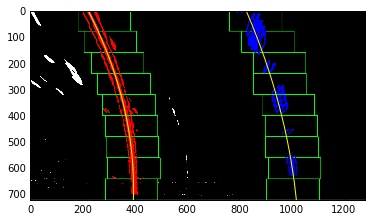

In [192]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
def compute_fresh_lines(binary_warped, save_plot = False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # nwindows = 9
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
    
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        good_left_inds =  ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds =  ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    right_line = Line()
    right_line.detected = True
    right_line.current_fit = right_fit
    right_line.best_fit = right_fit
    
    left_line = Line()
    left_line.detected = True
    left_line.current_fit = left_fit
    left_line.best_fit = left_fit
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_line.allx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    left_line.recent_xfitted.append(left_line.allx)
    left_line.bestx = left_line.allx
    left_line.ally = ploty
    
    right_line.allx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    right_line.recent_xfitted.append(right_line.allx)
    right_line.bestx = right_line.allx
    right_line.ally = ploty
    
    if (save_plot):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        pyplot.plot(left_line.allx, ploty, color='yellow')
        pyplot.plot(right_line.allx, ploty, color='yellow')
        pyplot.xlim(0, 1280)
        pyplot.ylim(720, 0)
        pyplot.imshow(out_img)
        pyplot.savefig("output_images/color_fit_lines.png")
    
    return left_line, right_line

def calculate_curvature_basic(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad, right_curverad

def calculate_curvature_for_lines(left_line, right_line):
    ploty = left_line.ally
    leftx = left_line.allx
    rightx = right_line.allx
    return calculate_curvature_basic(ploty, leftx, rightx)

def add_new_line(fit, fitx, radius, line):
    line.detected = False
    line.recent_xfitted = line.recent_xfitted[-4:0]
    line.recent_xfitted.append(fitx)
    line.bestx = np.average(line.recent_xfitted, axis = 0)
    line.best_fit = np.polyfit(line.ally, line.bestx, 2)
    line.current_fit = fit
    line.radius_of_curvature = radius
    line.allx = fitx
    #print("shape of bestx:{}".format(line.bestx.shape))
    #print(line.bestx)
    
def compute_distance_to_vehicle_center_meters(left_line, right_line, max_x):
    leftx_val = np.mean(left_line.allx[-15:])
    rightx_val = np.mean(right_line.allx[-15:])
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_x_center = (leftx_val + rightx_val) / 2.0
    vehicle_x_center = max_x / 2.0
    distance = (vehicle_x_center - lane_x_center) * xm_per_pix
    return distance
    
def compute_incremental_lines(binary_warped, left_line, right_line):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    cleft, cright = calculate_curvature_basic(ploty, left_fitx, right_fitx)
    #print('Curvature left: {}, right {}'.format(cleft, cright))
    mean1, std1, median1, var1, dist_px1 = line_distance(left_fitx, right_fitx)
    #print('new left-right metrics mean {}, std {}, var {}, dist_px {}'.format(mean1, std1, median1, var1, dist_px1))
    mean2, std2, median2, var2, dist_px2 = line_distance(right_fitx, right_line.allx)
    #print('right x distance to prev: mean {}, std {}, var {}, dist_px {}'.format(mean2, std2, median2, var2, dist_px2))
    mean3, std3, median3, var3, dist_px3 = line_distance(left_fitx, left_line.allx)
    #print('left x distance to prev: mean {}, std {}, var {}, dist_px {}'.format(mean3, std3, median3, var3, dist_px3))
    
    #print(np.average([left_fitx, right_fitx]))
    
    print("var1 = {}, cleft = {}, cright = {}, mean2 = {}, mean3 = {}, mean1 = {}".format(var1, cleft, cright, mean2, mean3, mean1))
    
    good_line = False
    if (var1 < 200.0 and mean2 < 50.0 and mean3 < 50.0 and mean1 < 700.0 and mean1 > 400.0):
        good_line = True
    elif (var1 < 1500.0 and cleft > 100.0 and cleft < 10000.0 and cright > 100.0 and cright < 10000.0 and mean2 < 50.0 and mean3 < 50.0):
        good_line = True
        
    if (math.fabs(cleft-cright) > 550.0):
        good_line = False
        
    if (good_line):
        # Good line
        add_new_line(left_fit, left_fitx, cleft, left_line)
        add_new_line(right_fit, right_fitx, cright, right_line)
    else:
        print("SKIP: Continuing with previous result.")
        left_line.detected = False
        right_line.detected = False
        # Pull averaged result and return.
    return left_line, right_line
    
def line_distance(x1, x2):
    dist_px = np.absolute(x2 - x1)
    mean = np.mean(dist_px)
    std = np.std(dist_px)
    median = np.median(dist_px)
    var = np.var(dist_px)
    #print("mean {} stddev {} median {} variance {}".format(mean, std, median, var))
    #print('{}'.format(dist_px))
    return mean, std, median, var, dist_px
                        
#def compute_best_line(left_fit, right_fit, left_line, right_line):
#          
#    cleft, cright = calculate_curvature_basic(left_line, right_line)

def draw_lines_onto_image(orig_image, warped_image, Minv, left_line, right_line):
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    if (left_line.detected == False):
        left_fit = left_line.best_fit
        
    if (right_line.detected == False):
        right_fit = right_line.best_fit
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    return result

def print_curvature(image, curvature_kms, distance_m):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'Curvature {0:.2f} Kms'.format(curvature_kms),(10,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    dist_str = None
    if (distance_m > 0.0):
        dist_str = 'Right of lane center by {0:.2f} meters'.format(math.fabs(distance_m))
    else:
        dist_str = 'Left of lane center by {0:.2f} meters'.format(math.fabs(distance_m))
    cv2.putText(image, dist_str,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    return image

left_line = None
right_line = None
first_run = True
debug_run = False
debug_ctr = 0
def process_image(p_input_image):
    p_img_d = cv2.undistort(p_input_image, mtx, dist, None, mtx)
    p_img_thres = apply_s_r_x_thresholds(p_img_d)
    p_img_w, M, Minv = warp(p_img_thres)
    global left_line, right_line, first_run, debug_run, debug_ctr
    if (first_run):
        cv2.imwrite('output_images/binary_combo.jpg', p_img_thres * 255)
        cv2.imwrite('output_images/warped_straight_lines.jpg', p_img_w * 255)
        
    if ((left_line == None) or (right_line == None)):
          left_line, right_line = compute_fresh_lines(p_img_w, first_run)
    else:
          left_line, right_line = compute_incremental_lines(p_img_w, left_line, right_line)
        
    output_image = draw_lines_onto_image(p_img_d, p_img_w, Minv, left_line, right_line)
    cleft, cright = calculate_curvature_for_lines(left_line, right_line)
    curvature_meters = np.average([cleft, cright])
    dist_to_center_meters = compute_distance_to_vehicle_center_meters(left_line, right_line, p_input_image.shape[1])
    print_curvature(output_image, curvature_meters/1000.0, dist_to_center_meters)
    if (first_run):
        cv2.imwrite("output_images/output.jpg", cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite("output_images/undistort_2.jpg", cv2.cvtColor(p_img_d, cv2.COLOR_RGB2BGR))
    if (debug_run):
        cv2.imwrite("debug/input_{}.jpg".format(debug_ctr), p_img_d)
        cv2.imwrite("debug/thres_{}.jpg".format(debug_ctr), p_img_thres * 255)
        cv2.imwrite("debug/warped_{}.jpg".format(debug_ctr), p_img_w * 255)
        cv2.imwrite("debug/output_{}.jpg".format(debug_ctr), output_image)
        debug_ctr += 1
    first_run = False
    return output_image
    
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
i = 0
initial_frames = []
for frame in clip1.iter_frames():
    if (i > 4):
          break
    initial_frames.append(frame)
    i = i + 1
    
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
 

#debug_run = True
first_run = False
#issue_frames = []
#for t in frange(41.2, 42.0, 0.05):
 #   process_image(clip1.get_frame(t))
    
#image = clip1.get_frame(41.55)
#pyplot.imshow(image)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#p_img_d = cv2.undistort(image, mtx, dist, None, mtx)
#p_img_thres = apply_s_r_x_thresholds(p_img_d)
#pyplot.imshow(p_img_d)
#cv2.imwrite('debug/test10.jpg', cv2.cvtColor(p_img_d, cv2.COLOR_RGB2BGR))

#issue_frames.append(clip1.get_frame(42.0))
#issue_frames.append(clip1.get_frame(42.1))
#issue_frames.append(clip1.get_frame(42.2))
#issue_frames.append(clip1.get_frame(42.3))
#process_image(initial_frames[0])
#process_image(initial_frames[1])
#process_image(initial_frames[2])
debug_run = False
#process_image(issue_frames[0])
#process_image(issue_frames[1])
#process_image(issue_frames[2])
first_run = True
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(project_output, audio=False)

In [193]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))